# Glacial Terminus Extraction using HRNet
> * 🔬 Data Science
> * 🥠 Deep Learning and Segmentation

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Download training data](#Download-training-data)
* [Train the model](#Train-the-model)
 * [Prepare data](#Prepare-data)
 * [Visualize training data](#Visualize-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Accuracy assessment](#Accuracy-assessment)
 * [Save the model](#Save-the-model)
* [Model inference](#Model-inference)
* [Results](#Results)
* [Conclusion](#Conclusion)

## Introduction

With the change in global climate, glaciers all over the world are experiencing an increasing mass loss, resulting in changing calving fronts. This calving front delineation is important for monitoring the rate of glacial mass loss. Currently, most calving front delineation is done manually, resulting in excessive time consumption and under-utilization of satellite imagery.

Extracting calving fronts from satellite images of marine-terminating glaciers is a two-step process. The first step involves segmenting the front using different segmentation techniques, and the second step involves post-processing mechanisms to extract the terminus line. This notebook presents the use of an HRNet model from the `arcgis.learn` module to accomplish the first task of segmenting calving fronts. We have used data provided in the [CALFIN](https://github.com/daniel-cheng/CALFIN) repository. The training data includes 1600+ Greenlandic glaciers and 200+ Antarctic glaciers/ice shelves images from Landsat (optical) and Sentinel-1 (SAR) satellites.

## Necessary imports

In [1]:
import os
import glob
import zipfile
from pathlib import Path

from arcgis.gis import GIS
from arcgis.learn import MMSegmentation, prepare_data

## Connect to your GIS

In [14]:
# Connect to GIS
gis = GIS("home")

## Download training data 

<Item title:"glacial_terminus_point_segmentation" type:Image Collection owner:api_data_owner>
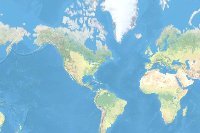

In [3]:
training_data = gis.content.get('cc750295180a487aa7af67a67cadff78')
training_data

The data size is approximately 6.5 GBs and may take some time to download.

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
output_path = os.path.join(os.path.splitext(filepath)[0])

In [7]:
output_path = glob.glob(output_path)

## Train the model

`arcgis.learn` provides an HRNet model through the integration of the `MMSegmentation` class. For more in-depth information on MMSegmentation, see this guide - [Using MMSegmentation with arcgis.learn](https://developers.arcgis.com/python/guide/using-mmsegmentation-with-arcgis-learn/).

### Prepare data

Next, we will specify the path to our training data and a few hyperparameters.

- `path`: path of the folder/list of folders containing the training data.
- `batch_size`: The number of images your model will train on for each step of an epoch. This will directly depend on the memory of your graphics card.

In [4]:
data = prepare_data(path=output_path, dataset_type='Classified_Tiles', batch_size=24)

### Visualize training data

To get a sense of what the training data looks like, the `arcgis.learn.show_batch()` method will randomly select training chips and visualizes them.
- `rows`: Number of rows to visualize

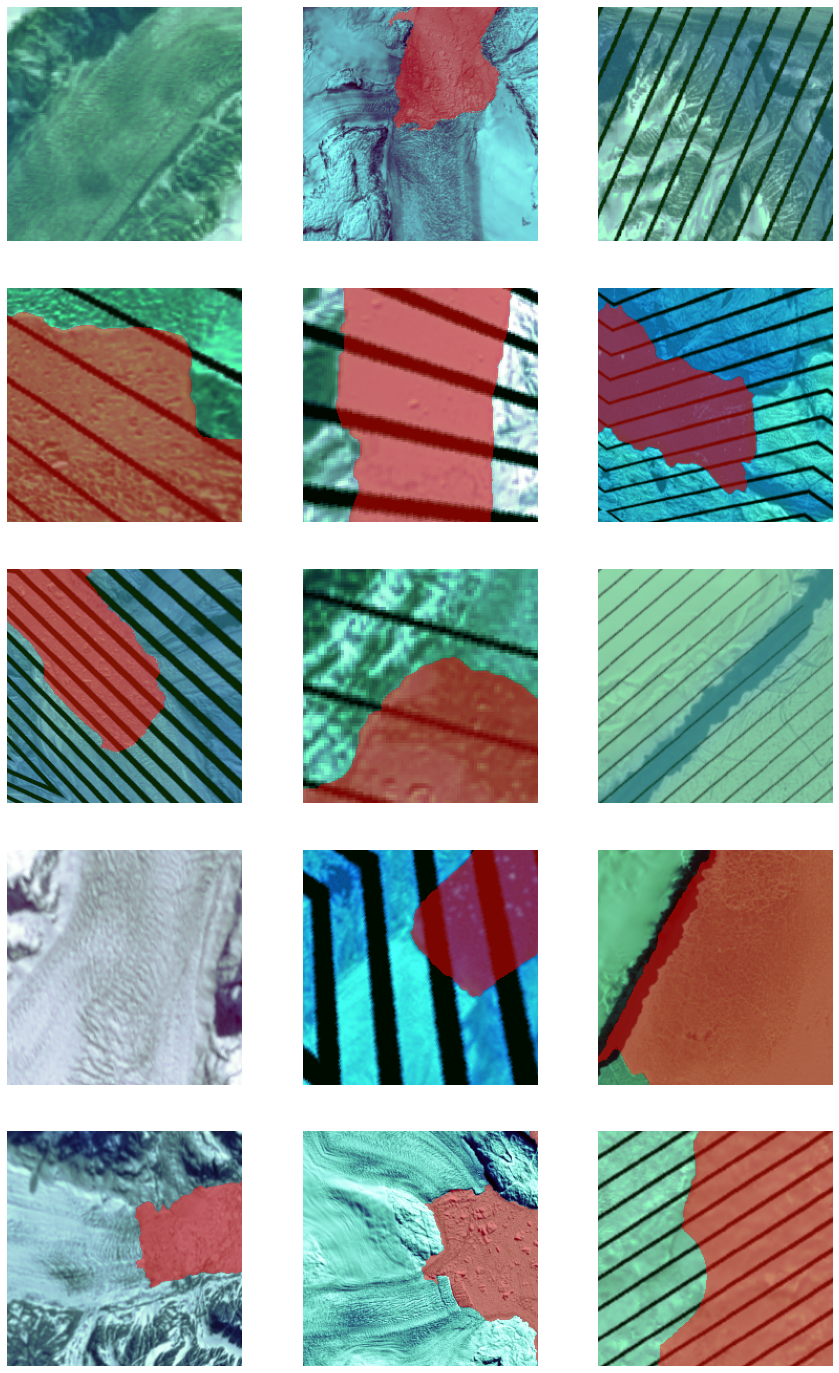

In [5]:
data.show_batch(5, alpha=0.7)

### Load model architecture

In [6]:
model = MMSegmentation(data, 'hrnet')

### Find an optimal learning rate

[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. `ArcGIS API for Python` provides a learning rate finder that automatically chooses the optimal learning rate for you.

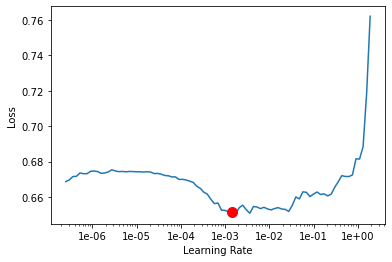

In [7]:
lr = model.lr_find()

### Fit the model 

Next, we will train the model for a few epochs with the learning rate found in the previous step. For the sake of time, we will start with 30 epochs.

In [8]:
model.fit(30, lr)

epoch,train_loss,valid_loss,accuracy,dice,time
0,0.610420,0.560476,0.724492,0.302636,03:44
1,0.557933,0.496885,0.757505,0.353984,03:45
2,0.489416,0.445652,0.789769,0.501799,03:46
3,0.447124,0.496963,0.756810,0.567582,03:47
4,0.427683,0.378213,0.833140,0.528805,03:51
5,0.399223,0.365552,0.842118,0.531487,03:53
6,0.381643,0.401336,0.811905,0.534826,03:54
7,0.378017,0.605405,0.757742,0.177460,03:52
8,0.367449,0.422544,0.815683,0.612659,03:50
9,0.358794,0.401540,0.804915,0.574714,03:50


As we can see, the training and validation losses are continuing to decrease, indicating that the model is still learning. This suggests that there is more room for training, and as such, we chose to train the model for a total of 170 epochs to achieve better results.

### Visualize results in validation set

It is a good practice to see the results of the model viz-a-viz ground truth. The code below picks random samples and visualizes the ground truth and model predictions side by side. This enables us to preview the results of the model we trained for 170 epochs within the notebook.

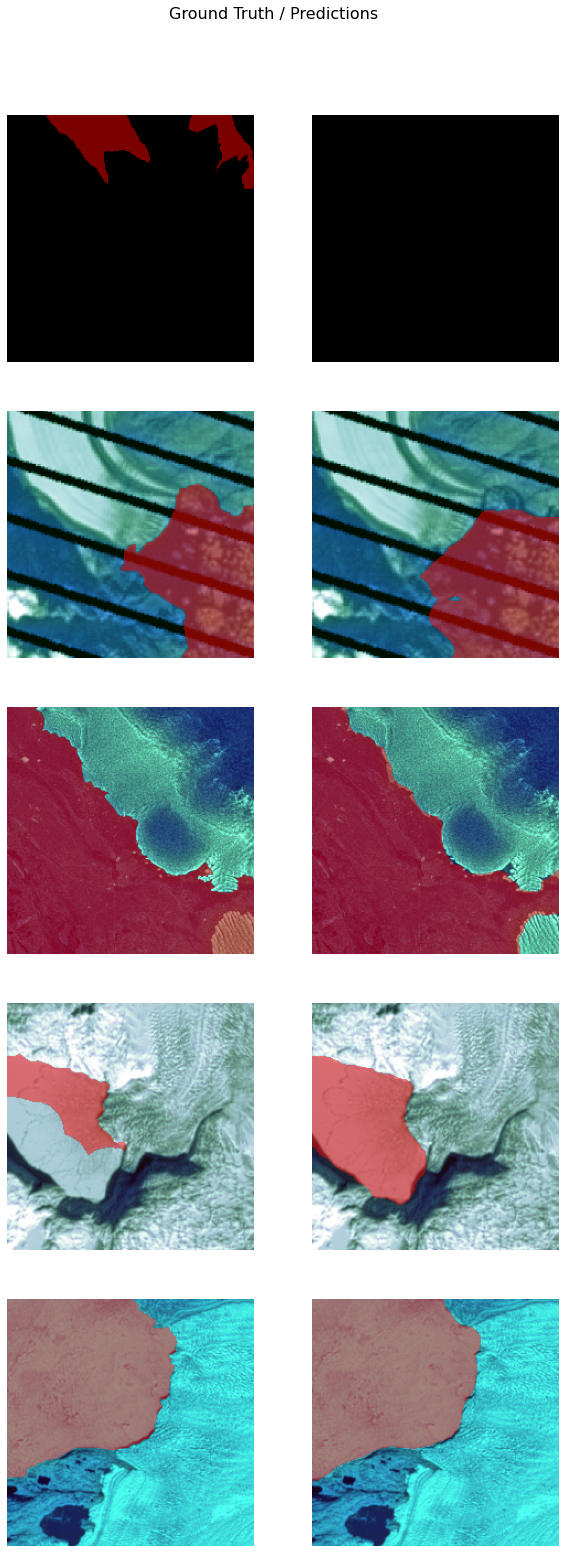

In [9]:
model.show_results(5, thresh=0.1, aplha=0.1)

### Accuracy assessment

`arcgis.learn` provides the `mIOU()` method that computes the mean IOU (Intersection over Union) on the validation set for each class.

In [10]:
model.mIOU()

{'0': 0.9026798871510977, 'Masked': 0.7716700616812664}

In [11]:
model.per_class_metrics()

,NoData,Masked
precision,0.937634,0.899602
recall,0.960069,0.848553
f1,0.948719,0.873332


### Save the model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). The Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [16]:
model.save("Glaciertips_hrnet_30e", publish=True)

Published DLPK Item Id: 2f4454094f974f74b1e67432bcaf564d


WindowsPath('D:/Glacier Tips/data/data for notebook/glacial_terminus_point_segmentation/models/Glaciertips_hrnet_30e')

The saved model in this notebook can be downloaded from [this](https://geosaurus.maps.arcgis.com/home/item.html?id=2f4454094f974f74b1e67432bcaf564d) link.

## Model inference

In this step, we will generate a classified raster using the 'Classify Pixels Using Deep Learning' tool available in both `ArcGIS Pro` and `ArcGIS Enterprise`.

- `Input Raster`: The raster layer you want to classify.
- `Model Definition`: Located inside the saved model in the 'models' folder in '.emd' format.
- `Padding`: The 'Input Raster' is tiled, and the deep learning model classifies each individual tile separately before producing the final 'Output Classified Raster'. This may lead to unwanted artifacts along the edges of each tile, as the model has little context to predict accurately. Padding allows us to supply extra information along the tile edges, thus helping the model to make better predictions.
- `Cell Size`: Should be close to the size used to train the model.
- `Processor Type`: Allows you to control whether the system's 'GPU' or 'CPU' will be used to classify pixels. By default, 'GPU' will be used if available.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAz4AAALWCAYAAACHq0aDAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P13dFVJli4Ozp8za82aWWtm3pv3M93T3lVXd3V1VVd3tX/d7/Xrru6uyky8t8IJIawM8t4AkhDCCCRACAmQRyAvZJH33nvp6np/5SC/2ftcXXElLiSQVKLMCq31LUnnxImzI06c/cUXsSPO/wXiR/yIH/EjfsSP+BE/4kf8iB/x8x3/WRE+AwMDGJVr0T6lR4eAgICAgMB7oG1Cg9LWQUzMyJdZ5eP/6PR6zM3PCwgICAh8yzC/sOAQjtL+MmA0GjE8NLRa+OgNBszTSQEBAQGBbxEW5rGwuIjFNZhnOEr/S4DZZMLoyAgUCsUyq3z8HyF8BAQEBL59MFsskv9WazQSNFottDodjMQbjtL/MvBG4eMosYCAgIDA+gWTCpPJ7OwsZIRZuRxyEiBMLJa5OYfXfGyYiMBG1pHwYTG4Fo7SCXx9SPXr4LiAgIAAY0YmQ1Z2NhITE3Hnzh3E37yJm7duoaa2FgYSJO8z88ODfAxH5zgfPucov68tfNjRLayBo3QCXx+CVAQEBN4GFjoZmZmIj4+XiOXq1au4cuUKnpWVWWfy35NUFpeWHJ57G6msF+HD/nJxDR9Z7M4JXyogICDwzWKYuCE2Nhb3kpPx+PFjhIaGwtnZWeIt9utvEjL2YN7htH19fRifmHA4qKdQKtHT2ytx4lqe+mDhwxkxqVjm5mG2AxMLix9BKh8fZnq4NuIWEBAQsAf7ZCaBOBI7KSkpKCwsRFRUFI4dO4aU1FSotdp3JhXmgI7OTvQTH5gsllXEwX/zLFJLa6t0v7V5rgfhIw3Akb+cnFTjZuU0AkumJPgXTSG6RoEmhRkmSid46uNgfsGC0XEV4p9No2DCCD31BRylExAQ+NXGyOioNMPT2dUFtVqNZBJALi4uyMrKemfhw2mmZ2akQb1YQn9/vyR+mJsYLHbS0tMRHBKChsZGvPzyy1XXf5DwYVIxmy3oG1QipGACJ3LG4Uo4njWGwIpZNMiJVITj+2hgUukbUiD8yQRyxgSpCAgIvA52+BOTk7iVkIC29nYpvC2dnP/x48fx4OFDKZb6XUmFR8s4BCEiPBytJHA4hG7OnlTS0hAQGIjKqqrXSOVTCx+20aQ1ILt2Ehtu9OD3IzrxG2Fd+E1GaCd+m37vz5OhRz/32oyQwIdhccmMhrYJ/MfFXgQ0a6GyOE4nICDwqw0WPsxRPBujI466f//+ewsf9vGctqCwEF7e3oiLi5MG6fgc8w7znoeHBxISEyVOXBu58N7CR7qhQovEklH8Q0w3/vBCF/7wYjf+iBHZhd8L64ZTwSz6BKl8NCwsWlDXOoHPY/oR2a6DhkhFjFQKCAjYw174tHd2Sn78Q4QP58MLTauqq+EfEIDIyEi0trVJI2pMKix6PDw9kXj7tkNS+ZTCh22f0xmRWjSCn1zsxA/iRxDVoETxgAalhLIBNe5VTiK4VIZ2DXHU4trrl2F3zBFW0r0lrf3xt6XlY7bjjtJI57/iXjZ8Vdp3zet985hfmINSY0DDkBa9KsvKwKeUdjmNNd0y7I6thaM0b0svICDwywf71jfBUfo3wSZ8unt6oCVO+hDhw+D7MqflFxSsiJ+GhgaJ8zyJn3j90Nj4uEP73kv4cAYmlQ6x2QP4/oVu/GPyOJI61WgY00loHtMgrWYasTUKDOiXww3sr18D+3P2+Kp0a49/VVr7v9+U5k3n7GGfzlHarzr/IWmsx+ag1hrROaHHqNYihRTap117zavrXsfaNF+VXkBA4NsB9s8rwqejQyKRDxE+DM6LF5rai5/Kyko8evRIEj137t6VwtwckcqnEj5sy9KiBbW14/i7iE78LH0aZdNmGMhf4sXCCubNFih0FujtBpC4o71AImiR8ljB4gIW7PJfSUewT7cg/V6dbk5Kx+dWp1+iPFelXfblLMBW0tHfr+yy5W8Dp33dLmtaa3r7tPYcbBMUbzpvn+5VGmsZ7M/x//Y28THpHNmFl4v4kut4OT1jge1lSPnaysjXvkpjgy1/6305ne3YajsEBAS+WfDOoMwfa+GIA96G0bExhzM+2dnZkvbgPB1d5wh8b+a1wqIi+Pj6ws/PD+fPn5f4ibnwTfa9h/BhR2VEQekI/iysEzvy5WhVUieczr1cWsCXy5izzEFjfDXiw2DHxY6Q1wOxo+ffbIzNYdpgc+a2dFJaPr58vS0dn+fj0vW87sWWfjntq3Rzkkiw3ms5nd15R/ez2WpLYwMf57La0jk6b5+P7djavCwkYlbSLKezQSoPnZfKx+BjdueWqH4ZtmPS/fgckQhfx/nxMS7vm0hCWgS2nDenWcnDLo2AgMA3B34npffyPc+tBb/3k1NTEqnw+hz24xkZGZLwefiewofBaTmP6ufPERgUBC8vL7i7u+NOUhIm6D5vIpVPJXwke2UqnEzswh/GDyN/wkzHXveF7Eu5023vWw0GM+pbp3HwwTA2Jg1j28NR3OjSQWF+xROcj15vQmXTFA6kWtNtSh7BmTI5BnRmiR84jdliRF7NFHzzZlCr0CH3+QSckoew8d4wTpfMokkxJ6VbJE6anVHjQv4ErjSqUNo2DRe6v2eZAkMmSkM+fWpGhzvFY/ic7sX32/poHHe7raFk9j6b28jMpBqhT0axgdJ9QXB6QsJvyiTxA4s6rdKAtPJxbE+mvMiWg9mTeDpOdkucYYVWY0RO9QT2pwxJ+exKG8ODIZPEF8wxk1NaxOUN07khfHF3EC7FVB45z5xZ0Ds4C88H48ieMMBAeXHnIrtqEv4FMjQqtcismsC+u3TdvSF4VSrRo6a2vWy/VBazGY1dMrg9GMIvKN0+sj93SIP0Z+PwLZWhU/Nu74GAgMDHAft3lUolbY7Dm+UkELfwb3vcJT6orat7p+2o2U/19vXh+o0baG5pkdbp3CWRYuMoJd3LEae8Dez3x0hMRV64IK1nZY56XlMjnXtTXu8sfDhz5bgcu6514gdJ46gnZ8fOe22Hmf+3JxoWHBpypsXPx/H57QH8z/gB/Cc53bgOHeSmV2nZyavUBjypHscvEindzQH8S8IQjhNR9GqtQkoiFbMBD4rHcebxNGrkGiQXjWHDzX78C6U/Sg62Ts4LcUkk0H0nJhQ4nzWKqHolHtdNYMedQZwulWOExNn8nAVDY2pcejyE/042sV0/SyYl2qXFrHm1g+X1TMNDCpxLG8I/U7p/ImzPnkLZtJVUuIxymQ638kfwb7estm9Nm0D2qHWtE9cJ26RU6nGveASfJ/Tjf1Aev7g/imQiFRZj3CAGR9UIyRygc/34pxv9OJAvWyaVObT2zODY3VGkjxtgJBLTE/EnUz24ETnUyDS4WzSKz+katu3kMwXaSZSuiBrKnzsj5c3TcLrTj3+43o+NmRNI71PjTt4IThfMSGEf9mUWEBD45YO3ni4pLV3ZfY2n623g/5kgyisq3jAYtRq8DofjnK/RNbw16OTkpLTJAZMKkwtvb81+3NG1bwKnZzEVExMDZ8rnzNmzKCMS5Hu9iVQ+lfBZerGAoe5p/Gd0B7YUKjBltAocPsc+UJplsIH+t/llk0mHhNwh/DSiE39wqRt/eqkHfxzZiT+63IeQRg3UZh5wmodGrkZY2oA08Pc7F7rxJ5SO8TuhHfgZdfgLJswSH1gsOsQ+6sdfR/Zif+YQPo/vxY+ievD9C1349aAO/CR1As9lZrwgPz42LMOma934x7g+bE3sww8ov52PZegxmtHVNY0tcT34/VCyi67/AeEPw8muS71wq1JiWM+LeYk7LCZUt0zg5xc78dt0/ntR3VJExg+v9CO6VQvd0gJkMiW8kvrwfT7PZaS8vkfl/avbo3g0ZJTWbxmpTm8+GcKP+R4XrfXww8s9OF2jlfhpekYJl5u9+AM6L5X9Qid+TNdn0vVLSxY8bxzFj727EU7CTCdxlBYXHvTiryJ6cChnEP9ypUeqh98Lbcd/DerC5iezGNFb+dpiNqG0Zhz/eKEDvxHSie9Tuh/F9OCv7wzgXyM78Ne3RlBG3L72mQsICPxywf6cQ50vkLA47uwsiQvehY1x4sQJiaOGhoclH+HoehuYL6amp3Ht2jUELEcRsFjx9fWVxIq/vz+qqqreyi1rwT6cN9ph0XTeywshoaHw9vGRdo3jHd/eZNM7Cx8mlY7mcfzTxQ4cqtRAabbe1HZeIpFlrBwjh6bVahDxoA9/QmTxg8vkBGP78MNL5Hxj+olUtCukIptU4MzdXvx+cAe+R+n+ktL9hJzu7xOp/Mv9cWn0jknFbNIi7F4vfnqxF7uIhH5+oxd/TWl/TM6eSeVHKeMSqbwksTDYP42fxXbjn4lUvkjoxV/E9uNo4SyG6EHWNU3gfzFRhHXhz+j8T6/04U/Jkf8+EcapciWGdFb7zWYjCmpG8Q8hHfhtOvfj2F78OJrueZ06GJ1aGIhUxsdncexGDxFCF35E5/+S7Oe8/oKcdeogkQrZrdcSCaT34/t0vx/GWMv302u98GzQSaJvZGwWe+K68fuR3fgJ2fKT6G78ddIYno6apIWj5XUj+HMilUt9Ohh49I7qNTiZ6jOyB7vTSSzFcT304k/CO/BfAzrxWY6MSMVKjGZ6njllI/hxWDsRY5eU/99cofogAfZPdOyvE0dRpRTCR0DgmwY7eR4BY5HDAmUtqfC21Lz957uQCgub69evS6QSFhaGkJAQ+BAJ8NQ/hwBwOIDJTH70XUmF0kmk8uiRRCoRRFR+RE4RERFoIyKUNjxwcN2nEj4vX1Lnu24M/xDaBe8mEix0zDZbI5Nrkd4gR2K9HAl1cqR0qNGrmcOX8xaU1VKHnUTAvz6axPMZA6Y0JvQPK3DiVhe+d2MY6RMWYN6IR0VD+INA4qPkCRRNGTBB6UZm9bibP4g/Jp76j5xp9BtIYM3pEZfeh98834Z/fjiO3CE9xtUmDE9qEUXHf4069nvL1TDSMx1n4XOlHb8W2gPfahW6FCbISQwo5Eocv9FFx3txtlyBbq0ZMxoz2vrlOBLfhd+42IdLnTppo5uZMTm2xjA/9SG8RY1+lRkTCgNq+1SoGtPDQP7/xuN+/G54N44/o7yUJkyqjKhpncT/JD7/72nT6CG+mxqaxaa4Tvz39GnUzZggo/L1jKnwZMAgDf5VVI3gj0m8HatSY4bsmVboUD6gRuesGQvEUdUkfH60RvhcetiD/+rZhr9MHUHagA5ygxlNPSTootrxm2EDyKT78EzS8NA0fnGpA78XO4gbXVpMUR1MTaoRnjWA/827FX8SP4JyIXwEBL55EA8wb/AmNyx+mJuYp5ifrhHfDJKA+Cp+soGjDnhQjmdkiktKEB0Tg9t37kjHWPS8i4CygfmJOYbDrz09PKR8Bun6ouJiac0Pix/e7c3Rte8ofBaIVMwoLhvGX4Z0I7KbHC4dl0QOGTk2pUZi5TSiK2cIMiS2qdGnJVKZMyO7dAjfC+/E9qcy9JKz1JksGBtTwIVI5fs3R5A7NQdYyDFn9+M3AzuxJXMaTeS4VUYLZlUG3Mun60Pb8YvcGQwaicjMWkQm9+DXvdvx8+xJVE2ZoDJYMCPTISaDSIUE1sEqDczkTIf6Z/AfMW34zYheXCQiHNda6P5EgtNy7Lrcgd+40I+wejUmzXOSXbxz2rGbXfj1S32I6SLCIFIZG5zBzyLb8UfkkON7tJg2zEGlJQU8qEYjkZ9Bq0PEo178zoVe+NVRXmSL1mBCU8cU/hc58n8iEukjUhnrncG/0z3/nUfz1BbouR6mNSgeMcJCpFJA9fQHF3rg3kBiiuzR6wyoG9ZgQMnhGo6FT9j9Hvx/PNvxd2ljKOKZIOqIdA/MYHtUB34znEhFZqJnNIee3in8j4h2fD9+GA8G9dCSaFXPEgnnWEnlB7dGUS2Ej4DAJwE7+t7eXkn8cKwzk4qrqytuLI+kObrGEVgM8BbTvH1ndXW1tK01k0FTc7O06JMF1JvEiiOw6OGNDHihKOfDC0U57I3X/IS/Rfx8SuFTVTuGvwvpgl+LnfAhHmpqHcMPfFvxf/duw//NswX/Z+wQkkdMWNTo4J/cjT+5OSrtmKkxke8l/2swmlDeMIY/J7/u36qDUaHB2cQu/PDWGAqnWDxaIxAYaoUWoSld+F3KM3eS8pzX48qjPnw/jARtr17iSp5hYltk4wrsIHHx4/uTGCcOGB+RYSOJj5/eobpVWMjXW2emulvG8VfEO1sKlZBZXt1rifLoaJ/E317qxLa8WUwQ35SVDuL3InvgQ9whlXk5LdcJh/rNDJK4iiOB82gGrcQnBguVj8qo1ugR/6QPf0J2P502YWJwFhtJQP3NvUlUyk0wUR7M8VLkAF1TXjGMP2Z+LVZiiqMm6Jyt7nlwjoXP2hmfi6nd+K3gHkR26aRQQF7jtLRkRCrx/fdCqS/RY6Q2NIci4r8/juyGe72V37i+lqhjo5pWYu+VTvyI+gpixkdA4NOARYaZxE8b8Ut4eLgkeq5euyZxiqP0b4NN2DC/cEQCRzxwZAEff1fRw+lZRKVnZEi7t3G4HUcm8Dk+bhM/zKm8mcIH7upmFT5FJHx+QsLngr3wsZhQWT+CP/Zrxf/Ttw3/V48W/PrVYeRMmGEhsjiV0Ik/TRxHAXXMp3nUiiBX65FFTvRPL5IgIYGhnVHh0HVy/smTaFBap775vpy/Sq6FX3IX/ujaCIpmSATM6RCe1EPX9uPeiGHFOTOmx+TYTE7y7x5OkWO2YJhEwL9Rh/+fH06iRWOd/WA01xGhRXTAqUIN7fL1fL9FEgnt7RP46YVO7C2SY4pI5Wl+nyRqLrRbQ8xsaaX0SwsY65nGz4gs/leGDK1EFjKdGTIq4yQJi0uZffjBlWEUkt1j/TJ8Ht2Bv6MylkwboSLxYV0AS79J+BSXD+NPSCAeLFJggBfe8ozasm2LbxA+IUTYvxveh2v99LyktBzGYURKVh++F9aN6D6TJKoeFw7gexd7ENSmh2W5DLxYVD2jxD6qr58kiBkfAYFPBnoXbeKHQ8pY9PDMzYeQCoNJip0/j4QVFBRIJOEo3ZvA6XkrbP66tvsaUuEND3i0jsUPzwD19PRg6cWLVdd/KuHz4sUcWlsm8M/k2/c/U2HGFkpNdasizqno06CoUwnv+z34/SuDSBomP0wda6erHfivgR340ZU+/O3VV/ghCZL/6tsF12oV+qYU2He5E5sey6SBLJuwYFjMRmSVDeLHIX24OWSAeUGP2Id9+Gn0ELJIUMwtr8tkGHQa+N3uxl9cGUW9wSwJny9iurAhexqDRmv4OO/i+Yy49kdhXYhgYbB8HwYv9lfIFXCK7cLPiedatHrceNCDH1J5nsyuFiOMFy+I75on8A+hrfjfiBP+Kq4Pf7dSxl78YVg7fj1sAInDBknspZWO4O+jO/FnMb3YlydDGYlB9XJ0x+y0FsEP+vCnl7rw97cG4VulRBfxNYdzL71B+ESk9OKvYoaQL7eut+J8uAyV5UP4EfGsf6tR6oTcIa78UUw/HkxaSBxZbWf+M+h1CKP6+mshfAQEPikk8UP96qrnz6WBMI5UeFehshbSbI1SidTUVJQ+e/aaMPkqcHqOcLgRHy/t3sYbGdif5xByFj+XoqLQ2NT04d/xWSJSqa8fw99S5/xYNcc9W50hk4pSbUD9iA7Pe5Vwv9eDP7wxjOwJkzQFvy26Df8loAPfj+7Bn8fY0I3fD23Hf/HrhneTGt0js9gU1YHdJDbGDK9IhR2f2WTA/YJB/CR8APfICZvmrcLnb0hQFJEznbNzklqNGh43u/E3N8bQajKT8JnGv5KT3p0vw5h5eU3SggV5xUP4YUQ3YgdM0nW2MrJDnpXJsYuu2Zgxgw6tDtFJXfjR9SGUkDCwJzsGE20diai/CmrF/ze0Gz9cKZ+1jL8R2I7fujCI5FF27iZklI3in4mwOD56W8408gf1mCVylkhlRovw9H78iO79V9f74VYmR+OsWQpleFOoWxDV9d/GDaNUmhWyksrC4hzKng3ih0QqIR0mGA1GxKf14sdXBpAxvZpUmJiCE7rwN0L4CAh8UjARMInwgk/+2CiTiqN074KPIXx4kWny/fuS6OHd2+zPMz+w+OEPx3GIwouXL1ed/1TCZ4EEhnJcgf3XO/GPqVNo11gkny7xFEFa20P+8MHTfvxx3ADukvBRkvA5dJW4KKgLf3nNurbyvy/jH8kP/2viCOLaNegdm8Wu6A58nkPCR0952XMBCZ9M8rk/CunFLRIQ9sInm9eB2gsf5qiEbvz51VE0kvCZIOHzeWw3Nj+ewciK8DGjsHQIfxbaRSLCuLIBgLUMJHxmFThAPPKLh5No1Whx+X43fhA7iFzZao5iH//y5Txam8fxj2Gt+N/De/D3VKbVZRzAhpRx5E4YJYFmMZvR0ifD6eRB/H1UF35AYiS8XQct8RAPlmlIaOXWT2AbiaY/iezCP94bw9NJEncvHK/xYeHz15eHUaxijrLWAT+H2qph/MVFq/AxGA24mUZCM7ofqRN2HEW/jZSH303iRCF8BAQ+OZhbeBMDFhbvEz2wFpwP5/GMRE9zc/N7cxSD+ZJ5igfpHAkwHqTjb84xX/H97M+9s/DhjrViVI6tcZ3450cz6NXPSQ7KRipLLxbxQk8OLKsP3yfhkzVugmxcjh0xbfhv5HD/9c4QPr87hM9soP+3pY4jdUCLrsEZfHGxHVvz5RjlGOll582O20LCJyl/AD+K7EfKOAmf5Rkfm/Bh5yiRCqXVKFRwvt6Fn94aR8ey8Plf0d3YVziLiRXhY0YuCakfhHXhUq9V+KyUgfKSTc9iW1QnNmfPoItI5cIdcv5XecSKyrtsl822ly/n0Ehi8K9DWvFbUX34OZXLvoy/oDIeyp5C6fKo38KcGR2Ds/B6NIx/vdKN79M1wa1aaCk/JgM91V9h0xScEkgAXejC394dwxMSkJY3CJ9Aqoe/JwItU1tDJGykUl0xhD+/2IVQSfgYEPewF39+uR+PJi3Sglq2n9MbKA9P6iT8VAgfAYFPDnbOHEv9Jkf+PpDEyfPnEqmsdfrvAr4/2+GICxhsp0qtdkgqn0r4sB0LJELu5A7ge2G98KhVYkjPvnHBuvMocxQJn6THffijKwO4PUj+X62DN/n47yeMIG/MKjKYBxi89lJrsMBIvl4xrcKJG5340/hR5BK3sZix7WaqmtUgIIXEx/URlPB6lzk9rpDP/UF4H672GmAiUuctnl9QPoPd0/jnqA78U9YMpswWTAw7Ej5zaGoYw09C27EhT4ExsuGFZD/dc4HOtUziH0iUOJUoMG4wIY3K89vEsb6NVi5huxjz9AzNVCcTAzPYGNuBf8myhlnbysd8xhEBUhlJ2BiJI40WHtDjbakXMDoowxck9n5yZwytVI9GkzU/3rL6BT3/3PIRfD+4Ey4VSsjnzaj5QOHD7eXBkz78fngXPJt00ppYaetxSj85OosvLrTjz24I4SMgsF7wIZziCMwzX1dAvc2WN517Z+Ej3cBkxK2cfvxBWA/c65RSSBY7MclJfbmIJa0eMY968YfXh5ExxqFuWpy51Ynv3x7DsylepM9O04oX5MB15HDN5NxmJxRSuMEPbo4hb8KIec5vGVMTSrgmduIvKY8aDoOzsPAh0RDZh/h+I11vTfeCSKqVCIHD1D7Lm4VyzoLhfkfCx4L6OnLQIR3YyKRCZPNSsmkRL+ma8ppRcsjdOF2twozeiAc5vfhNKi/HT2vmrbYTY0gxzyaql7G+afz8cgf+NVuGAa1lpXxs0wKl0VH+HApgMFm/G/GC7kMeHZNEeBui2vGXRCrtRCp6qgsT1TGfA5HI04oR/HFQJ05WqaCg/ys+QPjwjI/ZaEJKbh9+l0jFg4jRwvXF9vHmD0SI/xrejj+/JYSPgMB6wFc58vcB5/N1BNRX2fKm859K+DDYx09NynH0Zhd+N6wbWx5P4cmADs0TerRO6lHZIcPO2Hb8eswg7g+bQUpJ8rV/EtGJ/3g4gbwhHVqW05b3KHC/To4+wzy+nDMip2yYfHIH/vneONIHtWimNI2jGlzJHiSR04lDZQrMzLHf1+Nqei9+w7MV//PhJB71Wu9f3avEubvd+D3irphePdXdnLSr22ckfDbZCR+uU51CBbfb3fg/gnvgWjKLqkkD2qYMKGuXYd+1Lvzg2hBShon/KP3w4DT+/UIHfidqAFEtKtSTXU2jOuS1KVA+qodSq8NF3mwholfafrpqXC+VsXlci7zWWaS3q4ljSJQNK/GgQYFnY3q00f2aBuXYQ9z2FzdHUacxoLpZJm0K0ThhQOeUDplVo/ir0E4co3LPLguftZsbsPD56RuEz4+XhQ+vIerqnMI/Rbbhd+NHkNihQde0ATVdcgRnDJK4asWf3RKbGwgICHwcvLPwYbBDniRSOXazG78b2oXPMsmpd2tQQSRQNaRFdt0k/pWc129dHUbupJnIwoTHZSP4flgn/jV1Apl9lJbSVQ5pkNUow60aOfpNVlLJ4k0QAjvwj3fHcK9HjXJKV9Kjgl9KH74X0U1CSw0Vk6xtcwOvNvzLgwkktWtQTvd/0jKL/Tc68YfRA7hDhLC0vKvbv5Dw2WsnfLgcPDPkQaTyvwd143DBDAqGyX5CVu0UPuMRroRRPJk0wULph4hUfn6hHb95YQAh9UqUDuvwrFeNB3WzKFkmlUtMKuE9OJRPeZEtXEb+Qnhq7QxS2phU5tDVO4tb1bPI7ed7UR6d09Is19/cHUeL1oCS2mncbFLhGRFv7YgGt4uG8WfBXTjzXA0lkUolCZ8fer0ufP4uzrHw+eGy8OFRv67OSfzPC234TSLLK80q1BIpFjTNwP3hAP44uA0/ShSbGwgICHwcfErhI611XLCgb1AB74f9+CFvUR3OW08TLlq3ef7xlT4cyZehRTUnrYHRq7SIy+XQsg78PqXhtN+/1IM/v9KPM0UydJHweUnpdEotrjymDntIO34rsovSdON75Gd/j67ZmzMtrU/lwT2LWYcrHLoV2IWNyQP4p+t9Up686yfvqulMQoG3on5BHDU2KMPPY7rwRfYMhpeFD5dDKkOfDPtv9uL3gtrxe1FWu36PyvMX10jgNGsgM1uFHu88yltB/yyK8ieu/UNK98dk09/fGsbtbj0MS3OYHFPgdFIvfpeE2x9wPXAZo3rwD7cGEdO0zFHESdvjuqSdTf+E7vfHdK8fXu2Hf50WahMJv+Ih/JTKy9thf5/y+COqg/9OIjB3zIh5XuPTMIIfeHYhuEuzInx4A56fRA2jQArHfsVRNZXD+GFkB7xbrLNsJp0B6SV8rB3/jXiP7ftpXB/25Yxhd1wn/jpBzPgICAh8HLyX8GGwQ+4fViI4cwB/eaETvx3cid9hhx5GDpMEyt/fHIBPlQL9ujlpm2omlet5Q/hxKImHcGva3yL8MG4A/lVyDJPweUHptEoNrj0dxV+HtePXwjokgvgtcuJ/ENOHcyVydGvnJFLh7azD7/Xiz0N7sC9tEP8Q1yvl+f8jO/7gUi9869WYpjx5O+uBvmn8j0td2JUnwzh/EG6ZVOa4DAOzOHa7H38Q2IZfo+t/h+7164R/SBzG3R4dVHNcViYVEyoaJrEhlnenacdvUFou6z8kjuDhoEGasZoaV8Djfh/+MJDOUx5sz+9w/PPtYSR2aqBZmENn+xQ2x3bhN0gw/g7Vw2+FduKvbg0hpk0HLZFKNpHKXxDRcN38Np373Ygu/GfaJMqniTA41K12BH/q2Y2IXi30y8LH/24PfnplGCVqJpWFFVKpKh/En0Z2IqDNGspn0hvxuHwEP73Ugf/ib93C+ydx/XAumMCBqx34W7GdtYCAwEfCJxU+y2Bfr9EbUNY8A8+sMTgTjmaO4UzeNB4P6yEjkcGbBrDP5LRaSptXN4XT2ctps8aJnxToIt9qnrf6VilPrQnPmqZxjtJxfs7Z4whpVGFaR51yOs/rYFj4XH7Yh7+JHsLDHiUSq6fgQnkey5pALKUdIy6S8iOxoZRrcbtyGnfaNZCbV29OwINWY9M63H02jiN0r2OZo3ApmEYO2W+gc+zbbWktFgu6BpWIyLPZNYaoBhUGlzdiWCAOmpJpcKd0fNkWSpMzgSvNaszQfdl2vVaPzJopuGZw+TmPCST3aSHjTSLI1ukpNWIKx8mOMRyhNJ7FMjybNJIt/F0k/i6eAlFUv0XTRhjJJqPJgNKmGVyuUKCbhJ6Nf1kA8XfxLj2bQt6ERRI+XG4D8dSz1hm40b2d0scQ8lyBxmkVvOK78FfxQvgICAh8HHyA8FmQnKjWYER1+ywiCifhS/AumER4pRxV5PTUlldfZLaRCjvAwKLltEVTuNaixqje6vRepTOjum0GwZTOh/MtnpY+KKpiopCc9wKRqhZhST34W+rw5w6rkVIvgx+l9aO0Kfzx0eUvWnN+CiKVlDoZHg/oySbr8ZVykCOflOmRVj0JL7Ldh+BP9leSI5cIcdlJS9cQqfSNqHGtzFpOX7L/bocWk7y9tmTXHGbkOjwigmNb2Ha/ErKHBRTfl9IYdAY8bZyBP4kN6XzRNJ6MGqTd3SRSmdEgoWJKssMrfxIXyek3zJqlcLoFIpWRCSVulc3i+ax1m1EjiaXKtlncJXIbIhK32ct1NDaqxM0aGSpmrETBZTAaTHjeJUcY3dszbxLXqf47ZpQ4d5XXRAnhIyAg8HGwHoQPwzbDYOKw5GWYpQEt3v1y2bfb0pL/ZKFhn5a5yfah01fpiP/IX79KN7+8TbM1HedtEz68uUHOjAm8kyZv2cxpOU++ly0//t9M92W7bMfsIa13tbdreUBu1eYKBCs/WvOypbXnMQbXx6q81tjDaTk00v78ys6jfJ7AdhqXz/PfUr3RcT7PIWu2PG335DQM+2MSlvOx7VjH9cbrmHjdEefN5xZfzEM+KsO/RXTgL++Mo0m7WuwJCAgIfAjeW/jYYCMVdnY22I7bO3bp2LJzlBygLS0dW+u8remsDtU+TyYV/s3O0SZ8eHODYoVZysc+7dp7O3S6y7CmXX0/PrY2DxupcD7291pFKvy3XT62NLa8bGntz9vylc7zOcKKLcvX2EhlJW/b/286toxV5aZ8lohUuL5t9+ZZtsnBafxDaAf+NnkSHXohfAQEBL4+1ovwYdh8rD1WfOoarE1r89lflY7x6txq4cPbWfOaVfa9b8qTj73pXoy193uT/Qz7tG+616q81qT5qnu9y3n7Y9L/BPs0Ntiu5/MGajP9Ewao5ngNKq+DXYBOrcWNjD78n4Ed2P1MgVnbTrICAgICXwMfLHwYNqe1CmvSrKRdm47wTulWnVstfAp5VzfqwDtK++qa14/ZY+XaN1xvj1VpCV91fm1+73V+zbmV8w6O2f9vf5zTMnQGI7pG9EQc1k0X8OU85LNqXEjpxX8L7MSRKpV1ZsruegEBAYEPwXoSPt807IXPX635jo+j9AJWATQrV8D37gCOPZnChfIZXKiYgnNyH37bpwU/ShxDwbRZWnPr6HoBAQGB98HXEj7fNBwJH9t3fAQcQ4rtnlHAPaEfezLHpVA6n6Jx7Erswa/5tOLvkidQNUuk4uBaAQEBgffFr7zw4V3dMvrxj7HD0nd8LEL4vBU8SMcfKr33dBB/FNiG/7dfO6EN/w//LnyRMYH8cZP0PTtRhwICAh8D3zrhYzZrEf2gH/8SP4oSDnUTwuetsJFKSsEQvh/Ujv/ib8X/K7gb+55OoWrGLH3DwdG1AgICAu+LX2XhY4V1/WjbhAEykwghfleoNEY0DPOur9ZdYitHdBjR8uYSjtMLCAgIfAi+VcLHijlMK4zonzVJmyg4TiNgDx4p0+hM6JrUo4XA36honTJixvBqcwkBAQGBjwEhfAS+LsTsjoCAwC8L30LhY3WKwjG+P2z1JupPQEDglwUhfAQEBAQE1iu+lcJHQEBAQGB9QggfAQEBAYH1CiF8BAQEBAQ+GoTwERAQEBBYrxDCR0BAQEDgo0EIHwEBAQGB9QohfAQEBAQEPhqE8BEQEBAQWK8QwkdAQEBA4KNBCB8BAQEBgfUKIXwEBAQEBD4ahPAREBAQEFivEMJHQEBAQOCjQQgfAQEBAYH1CiF8BAQEBAQ+Gr4J4SM4SkBAQEDgQ/Ca8BkcHIRBkIqAgICAwAfASMJn+JcsfMwWi8N7CwgICAgIvA3MH6Ojo6+Ez/DwMCyCVAQEBAQEPgAms9k64yOXL7PKx/+xzM05vLeAgICAgMBXYXx8fLXwcZRIQEBAQEDgq8CiZGxs7Jc64yOEj4CAgIDAh0IIHwEBAQGBjwIhfAQEBAQE1jOE8BEQEBAQ+CgQwkdAQEBAYD1DCB8BAQEBgY+Cb4PwmV9YwMLi4gr4f4ajtAICAgIC3y18dOFjTyiCVAQEBAR+dbBehY9N7PBvg9EIpUqFWblc+s3bY9ufd3S9gICAgMA3D/bJ83aawgbp+Af6648ifGykwX/zx+Vks7OYmp6WiEWr062c/1AjBQQEBAQ+PmzkYfPR9vgQf70ehQ+Xg3ebGyOyq6yqQmZmJpKTk3Hn7l3co99p6el4VlaGgcFBaTvuDym3gICAgMDHg42T5sjfs65gTTFEGmVwaEjy5TxoxVtTL1C69/XZX1v48A15xKx/YAAFhYVIvn8ftxIScDM+HgmJibhP//Pxnt7elZE1QSwCAgICnw42UuHPF2i1WoxPTKC3rw/dPT0SsfCglU0EvI+/Xm/Ch21nwmQOunHjBq5eu4aUlBQ8efIEhUVFyMvPx4MHD3D9+nXp3OPHjzEyOirdY95BfgICAgICv1yw32YfzL67oqICKampuHnzpuSnGfH09927d/E0Lw99xFssjN6Hp7628BkmksjMykLslSuSMfz3s2fPpJG1srIy6f94EkFX6HxGZqb0cbv3HbETEBAQEPg4YILgkbKJyUmUlJZKMx9Xr15FXFwcrhD473gSCTwT0tbWBpVa/c6kst6ET39/P27fvo04KhOLHxZ1CpVKCnfjOmBxx+UbJZuZsyRypbI3NzfDJL5pJyAgIPCNgrmGI8Wqqqsl7XCNhM6Dhw9RSrqivqEBTeSbq+lczuPHSExMxFXirOycHGkWyFF+jvDBwodJg0nx2rVruEHGsZGszthgDitgcuI0/D8fr6uvx61btyRSbWxqks69j0ITEBAQEPh6YJ+r0WqlUTSe4eBOPg9IPa+pQUdnpzTj09LSguKSEikM7HJsLFJTU9E3MPBOgmO9CB8uJ0chMD8l3bsnRRywyLEP5bPH4tKSxEksgDIyMnD58mWJp2x5rc3/2wKOjeeyzc9/c2Xg+lqgey4sLqyZNePjL7D04gUWya5f5oya1QbrfRyd/2Asl+2j5/s1YF/fjs4LfHsxv2B9fzmcy9H57xq4LcuJO5iTYol7cp88kUKQmbPYf3N0AkeOMQfwb9YW1c+fSwNWPKPPfv5d+OGDhA9n3NbejhgiBx4VZLLgYzYSsREF/5ZeSjrG5ycmJpCVlSVdx6TCx2xpBd4HVGcLjo7ZwlK+gTrle/0y7kPl+iZJ+t3AdevouMC3H2s7Z99dsG9gUmGfHRMTg/yCAkmkMIHwYJVarYZGo5Fiqk3LMyGtbW24m5QkkRCPtHE6R3nbwD79UwsfLueMTIbE27eRRLaPT06uHGeoqYztHR1S2ThO3P46/s1hfjyCyIN0LJ6442FLs+5AdWE06KVQDx09R53eAIPZQv6KuPiFHv11BUi6k422MTksy+X75cKC2Yl2ZCbEI6uiE+o57rTR8QUL5OOdyLkbhwsR4bhX0g614e1tyRE4NNNA5dXbl5nbLx1/lc4M2XAzHl6/hif1A9DNfRyRNb8wB428Axm3kvC0bgDGD6xPi9kEPT0nk8VRO7a+e3qDEebXzjkC1fdoK9Jv3UB2VTc088v17TDtx4XZbKRy2Nrdq+eh59lUqnNH16wHWO2m+p9zfH59gPvNJgw1P0NyQhIquqdgWOABDEdpvxtgncAChzUCR4g1NDau7BHAPphndHgQ6+nTp1I6m9bgASvWLhzCzDP77LNtvvxN+CDhw0KHp58ePXokkQTfxAb+v2F5OsqeVGxg4s3KzpZG4ljJrWdSsVjM0KlVUjmsUENrMEmksvhSh45nmaQy09E+rvjGSGV6qAEpV0hwlnWSk3uxTComTA00IuVqBPz9/ZFYyKTy/mEaZnLI2lXlJVDnR2c0wbKSzoyp/lrcjY5CVk3/RyOVOSIV1UwLUmKJMKv7YPjA0SuzyQCNSgO9icl/7XlrJ0Gt1sL4Tk7PgpmhRtyPjcGj0g4i8eX6dpj248Js1FPHc82zIKg0ZLvlm2hrHwa2W03vicH81aMunw7sq0wYbi7B7SvXUdA8At3Ci+80qbBvZrLIJt/LpML+mQUPn2MC4bA3Dgl7SD5doVSukAq/9zyqxtdFR0dLguFtwuNTCx+2mUcGS0pKpNC9vv7+lfR8jkPcSktLERgcLPEXv1Nc1rX5cH1wDDnXh41k16b5lOBOuE45g/6OKiSEuMPFxQXHjx8nuOFSQh4GdRZ8CS1q02PhejwMRZ3jsLw2A/PLAPFDXxWueHvgenYtFHMvsbS0AO00Cejw8zi4cxf2HzyE8Ac1UOrfl6Mo78FaXPd1xTFnKq9UZmc4n3LD5ftF6J/SWMXCghnjXc8Q5X7OyoWWjyd8ZkdLEHDwBGIy6qF7b46iDtwLE0bbCxHrFYkHxCmaJRKo9mnmqF9R9gARAZEo6JHBTH2Nt9tuxkRPBWKpvm88boDS1idwmPZjgcrxcg6DtTmI8D4FF253/CyW26BHQARyawcgU2pJXHwTbe5dYbV74HkWIn1DkNU4Ar3FUbp1APJV8wsGtJc+QJhPELLqh6H/DnOUxDXkp8vLy62z7SR67NeY8jkOc3N3d0dUVJQkgux9Mp+fJJ/NYdvMY6wz+Dr7e9jjvYUPkyVPP3F4Gwsg23E2gtVZTk4OfP38JKLkaam1N+f/2Wg2Lj0jY52SioU64aNorctHjNdxODk5wengQfp9EhE3n2BAa8ZLqFGZfJFe9EhU9E9LpOIor48LMyZ7KnEtwBe385ugkkhlHqrxelz1O4MDe/bj6HFXRGc1Qm18344nOdDeCkSfO4R9B7isXOYDOHjMFZGJT9E1poSJ00mkUoZYX28kl3VB8xFH02QjxfDb74KYzEaJVN4vXyYVI4aan+DCmWDcL25zQCpatBUlI+h8MPI6Z96JVCb7qnGd6jsxj+v7myOVgeeZCD57DAeldkfPgsB/n/Tww8Nn7RibUcLwkQj94+CV3aHuPnjwfADa9UoqZOv8ohG9NTmIDgglAT/wnRY+NuLg8DYmFR6YYlKxnedzLa2t8Dx/HmFhYdKA1FqfzGKI46x5wIpFwZtIhfP6lMKH7Z6cmpJG/lj8rC0nz/IEBgUhPCICXd3djsuxXF/19fXSmicWe+tpgG6efKNG3o+MWF847dlBPvoUvH184EPw8vSAm3c4HlUMYBF61KVdxgnn0NeED5d7FezyX7nPV6RZe9523DJnlgbQNDoDCZEFLC3OYaIuDWfOnEZMejUm5XROGkB03Ias+b1+nP3xeFcR/PZ+hq37nOHh4wdfXx94nHXGzk27cCoiGe3T6uXnZ4JWo4ZWb6K/7Wxdk+da2yXY0q45ZxM+/gdcEL1W+Ky5xrH97CON6Kt9CPftLriSWQfVi6U1HKVBffYVnNh/Ag+bJldx1Or819S3hupU/2qWyD6N/TWOnrPDNMt/O0rL5Vj6cg5dRbfhsmMT9lL78/Sytj9f7/M463IA27ftxvlLt1HXT/0Grn/76+3v9ZZ72Kd523NblW75mGNY7e4oSIDrniNIqOiD7m2DiGvydVR3q847SGM7vvbvVfW7/LcVq683Gw3STLzWaF4ZfLZP9+q6N5Xj1XkJdOzt6T8N2G9LEyrEL7zhjP1mBfybZ3U4HPvcuXOIjIyU9gpwpBt6enqk6IRy4rq38cR7CR++Ed+QQ9U4ro6N4eMrhtExbvxMrrwzjqPK5WNsEKflUAImH0cF+FRg56aYaMWd0DPYu2sHjp7yQkhoKEIJwYH+8AqMQnbNMJGKFlVvED7WPceXJLJ8UyyzfZoF6qCvriue5ly+ns+vEgFzMNHLwIRuIae4tDiP0ar7cD19FvFPW6HSGWGkDifX6ev3tYYdvolURtvz4bPnc+w6fBoBoeEIp05QoPcp7N60Ay4hd9A2qZJeUut0PN3HZH0Z2fbX72c9tjbumGNWV8pG19mueZvwscW5WuviTfZbSaX3+QO4bT+BuOx6h6RSx6Syby2pfHV9G5bLysekZ8f1sFzur7Jr5Tkvp7HWwdr6epWenXN38R2c2LkZTic9ERRibX9hocHwPnsUO7Zsx+ngaygj8cbP2v6+q+r3DTZZn9eb01jzsD436W9Ox/Zzme3SrcYyGZLdp/YeRnxpNwmft6T/ChsY9mVhG9b6E5udXI+2ff45TPKV/fQ3HZOu5/NrrrfMWWDkd8lsWX621udpTWf/bDnPV9fZYF+P0r3pf+kY/16T9lOC7ePBJo6B5t3M7EmFwf64qakJHh4eCA4JkWZJ+Br7PBhMTCwomJjeFPLGeX3qULe6ujqJW+z5jMsr2U9CxsfXV+IvPr7SNuxge44zMzPSrqS80xvPFNnX2afC/MISjJoJPL0VgIP7jyAoNgFlXTMrvsliVGOwuw1tvTKJo2odCB8uh8mghZqEAYczqrW6ZT9iKx+lo7Qmg+5VGo0W+uVZXCkdvTt6HeVB5/i8RqeHaXmgw2wxQkf/W2d9yX/q1WjJvYazZ8/gXkk3ZtV8XmO9Zs3Mu8Vikq7V23X0XsGMsc4iBBzai7DkcszOfUn8twDDbA8yrnhhy1ZX3ClpI78zB4vZCK1WT+UiG8hWg55stf2/8i7PwajXQC3ZbivbctSAVG6ykcSERfIpfM6x8Fl9DdeVNeLgdfs/UPh8VX1TWa31vTyDxmn1Oug4lHD5b75OKifPwNj5srV5W9vCnFQerj+Tw3fNJnwScZIExK1nvdCZrcfn6dlP9tbgzkV/HNi9XRKjXdN6eq9sdUX9P7v6VZM4ZpvsBxQlm6gdaLUaa30ut88V/y09Tw6to2dD15mMemiW64UFgrWP8iq/V3h34SPZKbUhqw0qqS6sz9qaxvouGe3fEbKT29FKqD7badAvi+85qmNu89awTI48kdoWHZeiJCgPfscMVI9S+aV7cD/LQM/WLiySBL1Op5Pa1zzlr6PnJpVbbx1keO3Z8vu0XAZuM/xsub6k9O8U9fLNgG0tKCiQIsmYq17VgfXcOwkfSsd+mv01b4ogVypX5WOP9xI+fHOeimJVxuEP9ud4K9QLFy4gODhYWv/DRkmLGIlY7MGG8Dm+PunuXYlEbVNa9vl9CnAnSa8YxKNod+w76Irou4/QMKzGEttOZVmY02Kkvxs9QwosvWHGh8uh08ximkhzenoGM3KVRBgr5ZPKvwC9WiERK6ebkc1CI4WmUcPlh0mNVaVYzoMgU6phWHZyJqOOOhVKesEpPTV8rXIGzx9dwkkSPsnFHZiYUUOumMGsUkUv0eo6NZv1UKiUJI4MDkllpDUPfof2IfLhc6iWgC9fvoBZNYCc6z7YutUFt0vaoZFeHC3kVC4dO3cebVJRWWbVVE6ySXrx6L70QmtVMsgUaivZ0D34pTTq1JDNTGNqRkYEqJNCBKWOokPhw8cXpGtmpWuoPmQyqNmRvGb/ewgfO1KRXh5y1mrlmvpeJnlrfaugZRIh+5mY1RyCpjVQfmaoqezSNZTGQE7UvnPNHXB+lta8pzE9q4DWZCVbrj/D8sDBatiEz20rqZT1wbDA79ELaeRUMdKCh9fCcXjPVjgH3kLruNbaZug6blcmgwazsuV2JbUbqpfltmlNs0jEQ+1ALrOWV66USMuWxjZaq5CezRwMWhU9L85vGgotdf7o+rcJtncRPpwH26CUbKDnSjZwyMGrurM6cL1WSe8I1Rv5iulZSkNtfuU9Yjs1SqkNmS1maKiOua0ZyJfoyeZZldZKMDoVvV/cbqzv2Kt7UNmoM6SgOrK2WzpuMUClVND7Qf6ICMb2Ds4qNTBK5Gxnn9RuDCv1KON6pPfBQG1VQelt7+unhq2+ePaDNzNwRBjvKnw4HefDO3hymVeexZo0n0r4sD1MfOnp6bh3//5KfDiDQ9o4tO306dPSmiUmVz7GIRFrYRM5/JvjyXmdkFwuf63evnlwGzRhgHzcuYOH4H/zCUa0Zrv325qG2+YCCaQXX6odCB8LFBMDeHI3HD7eXvA6fx6+YZeRWdUDlX75mxjEBUrZAJ7eiUGAr7eUxi84Ejn1E/QeUB3M6THcXoHbMSHw8TqP856eCL+egrZxPd3fhMmBSty+fBulHdMwqsdR8iAWZ4/twabNm3HQ5Qy8va8jMfEiLt28i/pRw7KP5rJZMDtQQ/2CJDyt7ZfeOfuOnL3wCb3HwuelZO/SSwtGmjLhtu0gwu+XYZo6lWNdzxAfdRvP+2dgNijQmHcfkdEkEjsnYKK2vUC+WTvdj4zbl3AjowxTKn7mFqhnh1CSdgshPh7w9PJG6PUHaOidkqId5sn/rhU+8+RHNLPDKM1IRKiPJ85TXfn4ByO9qg9a4t/VvvJDhA+9h1TfQ61lSIwOXqnviBsP0DHBoaomjPfSs4i9Q/U9ibmXL4mzh5CXloQ7OdUY7qpD8vVL0rMOvHgN+c1j5O/Jj9K9JFiseSdQ3t7nPeETfAGPyppQk/cQV2Meol2he2XbCuyFz2HiKBI+dv6OB6mM1I9KizqDXQdPI7WSnuU8t8l54pNpVOfcQbg/tStvbwTQMylpHiF/Se/08rtqNqnQVpaJmFA/eHt5wSec2mdFl7QmjNu2UTeO0sxUJKcUonusE/nJ1xBE9cLtNDYlH53jGvIR9vba8G7Ch9ucyahAS0kaYkJ84cV1Hh6HvOc9UJus/QB+7oqJHuQmXYKvNz93T+k9yq7qkt4jzsOim0Ll4yTEpZaiq6UaSbEBiIjPQtfoMOoKUnDlXj56u9tR/Og6fH284RMYgvvUx1JoTdJg4MKiGu0V2bh1MwNtEyrMU1sxyVqRcjMeqaVtmOwow/VLIVI7jbiWjOe9MknMSM9VKoMSHZU5uBLqS++cN4IuXcXjqkY8y0zB3eQ8DFI/iut7bfm/abBfZb/Ln7/h7ak5qoyP2WDjotra2hXhw4NYrC/s09nKwvzFky8cxcDH7e9lwzsLH86URwr5w28c92wLIeDjTIIcunbq1ClpByCe7WFhwyER9uAQBF4Mx8Zw4XitDy9IelOc9TcK7gSTg+koTsCJvUdwIZUcKHUIeUTpVTpyziyCFplUlKhYK3yoszTZ34IHV7ylaf3Tp07CzT8SD0s7oNDRS0t1NT9nwORIGx5eCYH72TNExKfg7hOMzLpxcq7UITSr0FXzFLEhXjhD506fPIWAy0nUwWUnZ8RIdwmuR8ajhEf7lUPIvR0O5wPb8MXGjdh72AVnzl4mtRuKkCsJqB02YJFeAMluIo2prjI6d4tIZcAhqUjCx2kfIlKqIJ+3ksoLchQjTRk4u+UgIh5WYcZIjrKtELFh8agiUrEY5KjNvYPg8KsobhuDiUfA6VmqxjqQfC0U19IrMKOhF4wIVz7Rhcd3LsP7rKsk1Hyi7qCybZQ6vSQMiVRWCx/uYJvJuXSTc4mFz9mTUvs66+GNlLIeK6mssv/DhI/FpEZ3bR7iQr1wVqrvk/CPofoeY4dvwmh3KW5E3kBh2wTmviQhqCQhmHIL8Wll6Gkux00iDH7WnkGXkFHdb3XOdC8WbRazBj21+bjCz5LawtnzgUjMq0ZZdhKiIu6hVa6VnOirMjDshc9h3HxGZV0hFSrj0ktYNGPIveqJ3QdccfdZN/TUGeHnrFWOovThdfh5ULs6cxYeIbHIoQ6NhgUDkzSlMellqCenG+7jRu3rNM74hiEprxEyDRH/EovMMRQTaSYm5qC1rwmZCVE4T+m47sPi01HXP/tq9MmB3V8lfNgGo24GdU/vI8L7nPSOnPKNwKPCZsh01hE8bouykXak3wyB29lTdG+qO+8QJBc0WtsSOzj9NCqzEnAh4Sla6kpxK9ITftEpaBkcpPIl4+KtTLS2NOJp8mW4nzuDs+5euJ5dg3EF+R9J8GrRUZVF5J6MhmE55lnky1tx79oVJD6px0hzAWLCfHDq9Bn4Rl5DIXUYWMxII5Ncj4ZZNJWk46If1SM9f4+AMNwvrEJR2l3ciM9Aj8Yg1fna8n/TYL+qUCql9Sq8/Sf7XSYS2yye9DelaW5pgSd1qFj49FMdvqAOlP15G6mMTUxIO73x6JvtmD0+tfDh8nFZeXMC24AaHysrL5dIk9cghFAZeZ0Th0SshRSF0NUllZlntfjDpsxtzF1cF47u+01hnnyrmTpTj+PccPhkIIrap2AmznCUdo6Ovy58KK1FjtLbF+DlcRpnz7nD3f0sXI7sx16XQOTUDcHy8kuYZR24d+k8jh52xqkz53D2LPkJeodis9ugp47feFsBLnifwOGjJygPN5w77YJTfhdR0iaDhTiqr/Ehzu46hbtl/TCQryq4dxEuTjuxcdMm7DviAje3y7h3NwIHDx/H1bwumHiAiJ7TvEWLxpwb8HD3RnrtCPEhD5Tal8l+xqcCigVInZ8XL8wYqHmAkzudEZtVC4VFh57nSTi+4yzSG4bJJhP6azLhfXw/fOOyMawmX0Vc0Jx1BU4n3JH8rEsaQdfMdCP9ij/2796PE66ncY44x2nfAbh6xaFqgLiO/OMr4dMA3RK1EdUY8u8G45jTEbieOgu3c2eJ00/g4kOyQz9n9Rcr9r+v8Jki20nUteQh8vxxHLGvb/9LeNYxS9cY0FOXgjO7zyCpoh/z+FLqHF8POYcjpwMReylc6pifPeWK/Ts3Y+epSJR1T9P7T++0RUN8mYVA18PYu/8QTp4l+93oefv5wcPlENVDIMqnbVEedjbafP0bhA+nXySBPlRD7YDaUFhSKWTEGUb1MApuR+DQvoM4cZLaH7WrI04HcdQ1GE9aRmGmupgzEjc8volTh51w1JnLS+3zGNly4CzulnRAT3Yb1D3UPn1x+ug5hF2KgA/5LTd6t08fd8KOXbvgHHobnZNv5ta3CR/22Rb9FKoyr+Mk2XDE2RXn3M7CmWw4cMAd94nj9ZTOpJtGRdp1qS9zxs2d2izZeXgfdjoHI4+EHPevLOohpEW7YbtzAC4H+8Dz/DkExaWjc7Abj+P9scfFF9fIfn9f6ntQ3R/btxWbD7rjbnEX8RH1vxZn8ez+Ben9fdY7gwXiKN1wCbydneDsdxkJF/3g5uGOUy5HsXPbdhwPuYuWMQ21sRewGGdRT/Xoum8vDhw5Tu/vOZzzoLbj44XjBw7jnPcNtKqsAsO+/J8C/A6zWOGwYtuOz7xeh3do411GOXytk3wyL585feYMAgMDpbBt23kGX886gv29bHaWxOJNafOeN/ns9xI+vB7n5q1byCNVxsbZjnH4xEnqMDKpBAUF4dKlS7h48eIq8GwQEwsXggvKpMSG8S4NbOinfgDSSIJ6DI8unMCRcxeoU/+2XXCYVJSvzfiY6aUtuEmOxtcH/oHBCAn2w7kTTth7PBCPl0lFP1GPG8Gn6IU6DR+/AAT4+8LXzwfxTzthMBkxUJeJIDdnuJzygH9AIAJ8PeEVdgXlnXK6r55E0X3JySVXDcOoGUfxgzi4Oe/D5q3bcPSUJwKDE5D2IBqHDhGpUJ4mqcNLdWtS4TmRoJuHPx43T0gjSatHo+xmfB5UQ7UIIpSXeLlkQk85k4gLrj9pgJJIpbPyDpx3nJMWB/Kan4G6bPicOADvyxkYVM1h0axETcoFHHA9j0fPSWRRW1FMtCApwhN79hyCu5cflZteQHJ6x92jUU4vtXlxfpXw0ZMTNCiGkHPDhwjYBR7eAQgM8IePtzsup9dLpPJ1hM+jZnpmVObB+iwEux+Dy0lrfQf6esCT6ruMSMWyTCqnd58mUhmwI5WzcHLxRtTFSISGBMHPhzoJe7dgm3MIijumSEBQfZOA5UWqXkcP4sDhE/D2D0BQoB/OB/jh7NH92LMzAGWTyjc6Z8fCx3qeSWW0MQseR50RlFCIKbMFBtUAHl8PwoF9h+Hm6SO1q9PkEA8f407EIExUF5JDT4+jej8E1zOeCAgIIPHtggN76Nk+bYKW2olR04+UGD+cOHgSQZHhVOdBhED4up/A3t074ORLzmlEbWfPK7u+SvhI4TO6cZQ9uiLZ4HLag5yYP86dcSYbTuJWcQe0cyzOZlCVcROB3h7wC+L3KAAeJw9jxyEfZDzvI6FH+WpHkBnrhq2HvXGJ6jQgxJ/ETja6hnpQcCcYu4+4Iyo8HKFhofRcA3D22C5s3OOKazktRLA8g6age8TgxOEA5LdPYOHLlzCMlSGACP+QZyTiL9BzDQ6GL5HVgV1b4eR1DTUDimVSkaEm6wZc9uzDYRcSRpR/AD9bPy8iLye4nr2MBrlO6lzYl/9TgH0tf+2aZ+k5vJhnwXi0jIUOz/IweCFpZlaWRL5ePj54mp+/6jyvi+Fd0jg/DuO5c+eOtPOOI5+9HoQPCxXmKJvw4YE5DtE7fPgwjh07JuHIkSOvgc8zh9XU1kqEyRxXUVkp7Q7HH3j91MKH25NW3oF4j5NwD76DDpkBc28U128SPmrikEq0j8mh1WmgnJ1CS0kKzh3Yj9CkEsgWv8R43SO4H9wOn9ulmFQbwaEx8qletA/IYNArUZ4SiWPUmUoi36QxzcGsV2BwoAfD1Nm0zBnQ35QG931nkVTWR5xHfsegReuT65LwvP+sD0qdBWpZN277HodHdAZG9OTTqBwG5QDSr4YgICIJnVQ29qNrOcoqfPYgKLEIoxqTFKI1O9iEuxfOYs/xADwmoWMgnuytSabOrTsyWfjQOzBnnEY58bUz+e1HNQMY7ynHJU9XBFzPxbDKTP5ag4bcyzi87xiJqhJMKKluqa5aS+7i3CFnRKdWQkbiSD5WuiJ8uBM+0/8cka7bcToyBd0yysdignK6F229k9AZHXPUOwsf4iijUYln90JxjETPfeqoa80cOijHQH/3Sn331hPn7XdDcqWNo9pxK8gFW7YdRmxKKQZnNNAoqfypEdi7dQ9ic1ugI1GpGmvCdX9n7DpwHg/K2iDT6qk+FeiuTofPkT3YvjMEFR8ifLicL+YhH65EpPMpBMTmYITaQFfZbbiQwPK58RjDZJPJrMNAUy6CThyBT+xjjOlNGG9/Cr8Th3EiJBHNgzIYzUZMD9Xi6vmjOOGdgE6FgcR0P1IvuVFZ9iMsIRcdI7PQGYxQTfQiNeo0tu7YhZgn3SScHdv9ZuFjnVEdasiGr+sRnA5PQtuwHOY53lSjAlFnDuGEfzL6SDCY6D3obW1Ex9AEVDodlPJpaiv3iPv2IfxBFWYM5As1w0iPOYtNWw8SNxVT34hD2ah/ZBxH7g0/7Ni+G36XUtEyoqB+tAbd5fdxet9OuNM7MWr+Ei+WZlGWGoVTJyJQ1rcsfEZK4HdkF3YSvyXnNmJKY4Byqg9plz1IvJ7Gg+oB4npguvMJ/I/tw4GzUShuHSIb9dQGJlGbG4/j23bhuNcttK8T4cODbLyOksPcWMTwBmnsw3kjA/YZNpw8dQpHyXc7k4/mmXv7c7zEhj/BwP5eRQKIJ2gyMzOlSC1H93wv4cOkx3HiHO5gIx8OGYiKjpYWXzOhHD1KnS0ikLU4dOiQJI4am5slMmZSKSoulsIOmJg+PalQ+aabcfmkM85feoBeldHBC2+DY+FjMavR19yEfpkWer0WStkkGguTcOYAz6KUQb7wEiMV93B6/w4E3a+GnMPbLEZKN4y+MQUMOjmKbwdSHZ7Cw+dD5MCpUZrUGBsdxLiMwwj06K5NlZzc/apBWL7kTpgOrY/jcMbNA2nVI0RE89DKenDHz1l6gUb0ixKp6Ilo7kcHIiTmEfqV1CF4jTBJ+LTxjM9eBN8pwrBSB41KiYnOSlwNcMHek2EoapsgZ0Liq+ouOQ4PZDeNSsQ2Rx3BqtRoIhUvevF6MNhSgFC3EwijfCa1c7CQ6KpKj8TBA664nFkDhY5e/kUDuitT4EGkcul+OWaMZshGl4VPViMML6jD0lOJsOPbcS4qDf0q6sQtWIj4h9EzNAM9Ee5qUrSSyjsLnxYmFQVKqJN89Igr2T0o1fc82cr1PSbVt5VUztmTymw7EgKPY8uOo7iWXoUxBZGFVo6azGgcJIcSnU0CYm4JypF6XPE+ij1H/JFd0wOlwUQdCDUGG58giBd/MqlMKZdnOOzxDsKHSWW0GhddTsI/OgvDeg06Sm7B+cARenaFmCBymOcQiO4SRJ4+Bs8L6RjSGjHW8pgE6hGciUxG5xiJrvk5cpqtSAw4AedzV9Es01Eb5FBPD+xjZ32vAD0TSnLWZmhnR5B9/Tx27NiOiKw26kDb22S1663Ch96lBbJpiISmz8kjOEfvWNe4WnK8yikiYC9nHHMnZzyrg8mkwXB3B70TMuo86KGSz6CjnDoLB/cg8E4xJqj9zOtGkR3njs1b9uPC7WcY0Vhj3hdNUyhIDMZOehZ+0Q+pg6eG3mjASEMWvJx2Epndx4CBSUWB51lXcJrEamHHpCR8jOMVCDm+FzsO0/uV14IZnQlaxRjyE1hQOiOxuAuGJWCm8yn8nffByS0GpR2j0BiN0rvbXpYCt317cfj0VTQp1o/w4TBk/l4PCxjb7A+TBc/i2XDC1VXy3cecneFKf9uOs89mAuLZIvb5POvPIWP3U1LWpfBh+1iYPc7NXRE+zFu8IQ+Xh3c/CyZBGx0TI/HWKkRFSYNzPLpoEz48U8QkzBEL64GjNLJGxJ48Ba/wVPSSKHlf4cNr0kwaGcZH+1BTnIbLIWHw93HD/u2fwz02A8O6LzHd+gQBx3bDxes6yrv7Ma3QYv4lD4RR+YmParLiJNEfmpiL1uExqEwLePnll1KEAPvMVcKH3qulhTn0FifA092NeG0cJhJX7Gdr0sJw5FQ4KgfUVLfzmO4qw+Vgb9zIaYTGtg32qjKx8CGO2PcFdh05Df/QcISFBMP3nCsOOp9AbFo5JlQ8IGtAj53wMdNz453lVMN1uBzkAZ+IaMSG+uC0Xyyq+mXSAKde2Yc73oew93QY8puIb8fHMDYxjt6OUkS6kL8KTUIX+XqZnfDREUfNDjUg9hy/8+F4XNNB99dj/gX7F0fv/jsKn5xXHMW+8Hn6ZRzfcwDhd56ifWQcauPq+n5N+BBH3Qw4icPuMagdVpGA5IGeBcj7qhB5cjv87lZCYVjAYE0GPJ33ICSpDDIj1dELbh8vsDSvQGG8P5z2hn4N4TNHdVOByOOnEHQ1F4PE2xmRp7D7uB+yqtulqKBRquPBvjri07NwOR2FqpEJVCRH4KDTCdx4XI3B0TFpkGZktAs5NwJxaJcbHveSyNEOICXMDS4nIuka4hDyceyLFpZeQt7zBN5H9uJ01BPILXOr63bZ7jcJHykEWz+DosQQHDp8EglPazE0Oi7ZMDbRhbRLnjiwyxMFg1SnlNaoV2NqvAdV+Q8RGxGBQJ9z2Lvl33H2Wj5GVdTvYeET7YY9RwNQ1q+02kk2vjRNIOeaL/Y5UR+qcQzm5SgZg2oYD0IPwyXwOvEg8PKFI+HzjITPAZyKuI9hrS0CyYL+ygfwOnkYcY9biXeX0JwRQX1uZ9x+NgA992so/0VqayZlL+6FeuKM1/qZ8WHhw9zE2qK3t1cSPhxezJuk8aYtNri5ucGZ+MnlxAkpOoHFju0cT7isCB+1Wook4882vMlnv/eMTzxPIeXnS6TAx/kmTDJMKkyYHH93nZQbx5Pbg0fcbiUkYGD5uwhMSryY6d66mPHhBkRlmarFpWMu8CXBMKh9864zbxI+3LgMygn097aiKCMBwe6eOHvyGHZu+QxeN55iXA9MteaSEt8FZ/dYFLd1YmyGXiIilZfUKFkgPM+MJSe3F0HxmajvGcAsOaiX5MyscdyvhE9K1QDm6MzivAVd+ddxju6VWTdFL9FLEiJK1KRH4OipMCupUEd5vLUQF3l3soJ26BxueWnd3MB7z2fYuv8Yznqeh6eHO844H4WTqxsS8uohIxEzv2AvfEZgkV486lyMNiAu2BPeIeGI8PHA2eCbaBi1Li7Tyjtx0/0A9p0Jx9OGHmoD/egf7Ed7Qz5Cjx2CW9g9dMuJVEZL7GZ8iFSGG3HFfT8OnghCWlkDhmfVRPTWulptO+MdhQ+TyoFlUjFrUcskvnsvAq9noL6X6ls/b1ffDoSPrA3xRCpHPePQOKqhdsOksgjFwHNcOrMDfnfKiVTmMVidDs9jexB2vxJyM3+0j2zhEMkFJUoSyInvC0b5BwufOWk07cKJ0wi88hgD8iGkRZzCHmcfqqcmqaPLU7/dndW4SaTifJLa6NAYyolUnA4ex9XMMnT29aNPSteKzOuBcNp5BpmdM0Qqg3gQ6UkdxEhUM6lwyBO1a3bY6qFiBDofgGtENmZ43ZoDu98kfPjdMBtmUHwnDIfIhuvZFejuHyAb+jEw1IpHUZ7Yv+MccvsU0ntnIDE5MtiKkuy7CPP2htsZF+zc+G84HZuDIYVV+GRd8cRuIpXyfgWRO9UvPYsXlilJqOxnUqkfoffB+nxM2klkXXSGs+9lNM9wG3IsfIKPH8LJsPsY0nBHk9v2HEYbchBw2glR6fVQW16gNTsaxw4fRUIJET5/N4Py53uYdSPIiPHFybOxaFxHMz7dRCZMKvzBad6ennfT5A1beHczG7y8vKTZjhNEKkwoTCS2c2Hh4SgpLZUEB6+bSUtLkz5uuh6FD6/LSX3wACmpqas2ceAZKxYwPFLIUQa8cx3P4vDAnT34mG1tkC0q4S4JqfUSlWBQ9uOuvyvOBsWjdcpA78qbbHIkfLjjM468pAgpjOuclzd8OHTq5HHs3bEJHlcyMaR+iXkDh5HeQpDXObhSmzgfGovH5e2Y1HK49jzkY21IT4iEx0kX8hOuuHArC7UdI9BKC9yNrwkf5qieolvwIOHzoHoUBml3TBPGWp7C+6gzbhZ3Qm/Ro6UoiURYGAo6ZqT1DK+XyTrj47fvc2wh33j6HI8Iu8HLL4r8XiOmeG0ePTfmqNXCh0M1ORxYjaYnt3By9yZ89vkBXM5phprX7tE7rpypRuierdiwaQcOObtQB4tnBp1x9Mh+bPjZf+Cw3020TWlJ+DyzW+ND77xegebSVER4c0jWUbgHxiCjsAGjJJLYJzoanOurIY7aRhyVRf7k5RqOmidhmR4D590n8KBxkvhhEfKRVqTdDF+p74uJ2ajrHFuub0czPhyV4AG3qAyMKHm9CL8D1H8bbcU17/3wJ+Ej15vQVnQbbkeP4XZJD/QkRq19Au7H6FGbGgnngx8648N1Tc+qKRuex6l9JD/DmKwZV08dwKYvtuEg3VOaeaVO7NGjTtj6+S+w2yUUxT2dyIj2xI7//AK7nY5I560ztEewe+sGfLHFGQ+Jt3XqfiRH+uK83210Ub/hlZ9dgFndghjXY3D1T8XIewsfEsDqATy86IZt//4Z9h6yDgRZbTiKPVs+xxebTiCzQw6dfAzFqdHU/lxxxv08vNyoLZ52wa7Nv4Db9QKMKln4EC9f9sQh/yR6DiQyuB4XiKNM48i57odD56+jdYyXeVhtMGqmkXf1NE4E3QDd4g3CpxR+J44jILkG5uXntTA/h/HGJwg57yIJH43FiNKbvjh+wgdFfWqpDdnKZ9KOIzs2CJ6+dO/1EupGfQz+eDaHGXcsfy6BJ0O4H8PhbAzeBE0KdSP/zaFulVVVq86zP2ctwu8/D+6xcOKlNB9F+HAYAQsVHvFjUrAdt63xYaN4y1MmECYKJht78DEmJq5sXuvD4RLrZY0PT6vr5L1I8D6Kc+G30Sl73xmfJehn+vHoqg+OHXfGOZ8AhAcGwc/zDA7u3gIfEj5jWhYlM6h5moTIQA+4HHLCad9IpBc2YkxtXQOknOhE7v3L8D51HEecDiMo7iHKmwaglpzcGuFDpLIwZ0Zn3jVJ+GTUTcDIcdFMEM158CXnfZNHqc3U4X98kxT0JZT1yrHwBlKx7eq289BJ+HCYnX8Awi6Q0K3vhnx5Yfn8gm71jI+NVBY1aH5KDmXnBvzi84O4nt8BDY80LMxBMVmO4J2b8PmGLdiznwTQvn2E/di7Zwd+8b9+hqOBieiY0a0WPpSv2aBGR3U2Lgd74Phh6nB7hiI5pwKDMi14p53V9tuED9UPkcq1nIbXSWWOw/2icIxIRYqfpjannOjGk/ux8KH6Pkz1HXglRapvlYmvcSR8iFRCPeEelYkRlSNSqSBSMUqkcu4Ik0o3kQqvl7LaOL9kIFK5gONEKh8sfIhURpuy4OFyAhHJZRgnUrl++iA2/mIjdu7lurVi795d2Pjz/8Qu52AUdncg67IXdvz7z7F1196VNPv27cW2jZ/h803HkNo0CZ1mEKlR/vD0uYXOWfvOO8cstyL2lDNO+JAwMFscksqbhQ+LmUGkE7Ft/df/xDYSm9wGVmzY8HP8YoMzHrXJoJWNIP9uOL1bR3DS0x8hAUEI8HHHgR2f4+yV3FfC56oXDvrcxhCTH7+rvKDbbBU+hzxi0TAkJ8dntcFEQqr4xlkc97uCljcKH2qnp0/A93YlrN95YlKZx1RbMSK9nEn4UJuaM6EiKQQuxz3wtHN2JWSU3w0TdRjz4sPg5n55XQmfvoEBKdSNQ9r4GBODdSR1VAJveFBcXCzNAvn5+0s7nrEPt53nv3nQi6/l3+yzH5C4cEQqn1L4MPgcb2V6jUiUyY2fi+0cDwZw2DWvY2IRyPZz/diDj1n9nPWbdMxn/BXxtTvhfQrwjm5z+lnk3/DAgeNeyGkcl0aLV4dTEST71wqfCVhezKG/7D7OHNyLsxHXkfu8CzK5AmMd1bjufxTnr2RgQMVrZkggGTQYG2pA5q14XAg6j+PHTiCWOuoK4iH2ZQb9DFqr8pF0LRa+Z4/B2T0She3jxD+vz/g4Ej5ss17RjweXzuF87GMMjPYjM84PIXFZGNKRL1nuDK7Gcqib02743chFz5TcuvGJTEV5kl9cft8cCx/iAvL/NdlXcHYvCZ+NBxCaVgu1if0pf0OuHhecdmDnwVMIv3JD6oTxYG3cVR64TUBmCQkrrQmzo7YZn+XNDbhNWAyYHGhG3qNkRAV54vjR47iYWoYpvZXTX9lP/uSFGUONWfDeewDh90oxY6E2Z5fGYppCUUIg9m9zQ06XtV/BPsigm0Zr+VPcuXoZPmepQ+55AcWdkzC9SfiEesA9Jps64LbNLxagHiHx4bVvWfgY0Jx/E6cOHsKtwg5oF14Jn4UlJUoTgnFk74cJHx6EmjPNovxeOA4e5HWovVAquxB/1gk7dh9DUNSV5bq14uq1m3iYW4H+mUFkX/YmgbEHHqFRuMKD5stprl2Px52Ux+gg8alX9yH5oh+8gpLQp+A1i8t+ltq8caQcfsed4BqWgUleO7xiM+OrhM8iDCRWWHzt2bwXXuHR1oF7mw03buJuSi46qE56qzLhc2Q3XIOv4mltF6Zn5Zjseo5Ybyecj89fJXwOB9/DuJL6vVyP9sLH9yY67IWPegpPr5z6auHj6oLAB/UrZWLhM9aQi2BPFj5tJHx0KLx2HkeOeiCvSymtZbaWjzhYPYiHJBrPeV5H2zoRPuxzORybd9zkMGPeuIqP8UwQg2c3+f+6+nqJo3jZDA9QfUlcYEvDvpvLwu8b+wTmO54B4usc3fOdhQ+DZ3mePXsmNYS1u7r1kPpaIZWv2NWNMTU1JakyKRZ7eRcd+/y+afDCUYt2Bk/izmCviw9ypXUwVJGvpbWRyhrhs2QiAXILLtSZ872eivK2EWl7w6muKlzxPULC5wlGNNbpZLORjo+3IT/1PuIifKXR4+i0GsiXScVklKOrvgzp924jxO0oDp8JRX4rkwo59HcRPjZSifHA+cuP0T/YSQTjjciEfIwbeTTGUV3bQt32IPh2IYYVWiip86JU6aRYWdvLOTfvSPiwo5Oj7OFFnNm/DRu2OCH4UQ3URmt5lNP1iDy0A3uPeeDK3VTcv58sjRgzkpMfofB5J2b1ptd3dWM7qaMpG+tGeV4O4i/4kgA6jJC7xZhcHt17ZT8LH4sUn+tNnWmOV5+28Ii97TyRinES+fF+2LfDE096ZiThw3VlMinQU1+OjKREhLgfhdPpYOS1jK2QyuvCh0kli5zbK+HzilSswqcl/xZOHTiIG/lt0M6/IpVFIpWSW0E4sufDZnxYoFuM0yi5GwInIhXuXKhUPUjwOIJd+07gYvzdlbqVcP8BHpfUYUg2jCdXfbFvG4mz6Hgk3U959QzupyI9uxg9M1pr/HR0ADz9EtEttyMVJoWRMvi5OMElJB0T5Aveb8bHunFC9lUf7N+6DwExN6Wdt1ZsSLHZoEJfdSa8D+/B2QuJKG0ZhFJjjeO/EXAEHlcfY1BO914WPk5+dzBMdr4mfLzi0DikWH4+LHxmUXT9zFcLnzMkfO5VL4fyURskUplsLUKETfhQJ6fsdgCOHj6FTI7BlwYaqHx0f5NuBJkx/jh9ioTPOgl1Y5/LYVr83TX+cCf7cD62trMvfcfH01Na+D84NCSRiv15Lh+DBQ3P6PNunI5I81MLH7aJ788ha7wA1haZwLabzWZpZyBfX1/ExMRIZLvah1hhO8biSBKMTU0Oy/rNgzvp5JMqSbzs24NjoXfRNjQjbQfMz8g6Q0n8wl+mJ9+7BM0q4TP3Uo3yO+Q3drghg3cAW+KnvIjJjgKEOFNnk9doqulZ0/XSbpCUn4XqTDZUjYsnD+DQaWrXM3qpHnnrXK4Ti1mP9pJ4OG/eg7DkMmnzm3cVPrxbWWtBIjzcgvEo7yF13Lxxr7SP7HzTN7WWhQ9vbnC/EkppHSr3K6x+3JbudeFD7X3BjMm2EoT6eSDiRjLuxvrD9XwIitpnpLLolKNIDjgAp3MXqJOpkspoMnN4snVLY+s3cux3dWuQOIq/F8SfdeDZZt40RT1VL61HOegSicoR1cpouw38jGb7qnDpzHYc9LiM6gGFtLEKl4F9Fe9qF+O+G3vPXUf7tIbKwlsaL9c35WUx69BadB1HqGMekVqJWarv3oY3CR/mKEfCpwIKg4XaUSpOO22F1808TGrmySeSHfRMTTMduBXoip273k34JFT0w8Az33St1P4MCrRXpcPLeR9OhiaiY1IPi16GrEsnsN/VD3nN49Lum0auY/rN2y1reGMbswaVKeE4fMQFt4s6oCLhaH0OZmkHTqW00yiJQBI+KRHnqGPvhwJ+fovWjvH8nA4tJGyd9uxFcCoJU14L6sBum/BJpD6UgaNf6FoG+7o56ns9SwrFMRL694jD+EPwbAPbyjt2ytX8KRE5Kh7G4NjO03jEa8j4NaL3aKYtH0FHt8P9Wj7GpFC3ZeETdA9jjoSPTzzaP1T4pNatlGm18OFQt3nUpAZj376DuPKE+h9mSkPl45C42Z4yhJ86CmePm+tmjQ/bwANqvC4nIyND2lbd3i9Lvpv8+Lt8x4e5gden8q5uPBP0pvK9l/BhA3gEkEmjurp6NanQ3zVkGJMK35QNszfePg/LclomlfXzHR925Ab0VCTj9N5dOBJyGy39k9ATAbB9Euil4/3XdYY5IhXVGuGjQNENfxzc5YnH1Kme51jOL80YrKNOnNNOeF17glESPnPkqHS8PoXLTKJFNlyNCycP4ujZODTPkMgw8HdF6Dw7TIseHaXxOLZx2cmZ3l34SKSSfxte7kFIzkpCgKe/tAaIX543kcqI3eYGTCpL5Iz5pbQnldeFD71Q8yaM1OfCz9sd0Xez8PBGIFw9AsjBTUuiSacgUgkiUnGLxLNe6uzT8+f2YiZi4Y/MqXk/e3p5V21usMRrpvj7BAbrqBd1anUy61qQg8cjiFR4Cnd1++KXWz5QjaizO7D/7CWU9cgk+/jZcRmmustx4exO7Pe6hS7q5PP2pTzzaKtv3nGvo+wWnDftQfj9csiYVD5E+FD7GKh+hLOHtsL9ag6ls0gEzY7PMNmC6/4nsGPnO874lPVAN7/c/uheRhLnTSUp8DiyD2ci76F72kBtahaPL5/Cfhcv5DRQx4KctLV+zdK3A9RMKhYdatIukcg+hvinzVAazOQkrM/BuEwqZrZPM4CHl9xw6CA930YiqHnquFA7sMyp0ZhxWSKV0IdEKuRc3yZ8WLBJYWC2d4eeA2+wUUXi+PjRY7iV307ERh1Ymw28Zbman4VSEiTHtrsipWYQ5pegWmfxkYegI9tw9rJdqNvbhM/5ryF8kqreIHw41I1EQlYUDu3fi/CHNVDoWUhQ+ahzN9tTQe3rKA6dils3a3zY3/IsOxMKf5OGZzHW+mUmC97E4Ku2s2a0t7dL62M63+C3P7XwYXA0Aq/pYYHGM1u241xuJlg+5+/vL31sm9f/rK0P/p/ricPlWJTzDJmjsn4KSLyhGsGTm8HYvn07jpwMQnpFC7p7eqX4+K62OjzNykDB82GQ57X7gCnP+BjQnHUZB3bsxfmbueju60FbYzmSo7zhvG8HPGKzMKJbxGh9ITIfF6C+vRu9/X3obHiKUNdD1FlKROv0JJrKniL3aQlae4cwMNCDqsdxOLzJCVHS4N27z/iw/1D1VyDS7QhcTp7ESd+rqJ0w07u5+nm8wivh82o769fTrRU+FvK9ekUvHkb54oxnLKqG5JjtL0XEKWe4XUxDj4J8KHW6W57G4cjuXXCPSkFdG4fPDKC3vQFPstPxrHlI2nJfPvZK+OiXLJgeakZu6gNUcPqBQfS2FeHSOfIBrpfRMKUh7lrbtniAdRJFt4OwfeN2nA6/jYrmDqme25tqkBByDFu370dMdgNU1GE162bQUJKL3LxStPUN0j26UJEdCyeq75jMOqm+3zzj8xbhYyJZPN6ChMBj2LjHBVcfFaOrpx/dzdVIiQvHmeP7sWv/O6zx2XsQFx+WoK2b2l9fH7W/BmTGB+Ig8cThU2HIpXozEH9zH6G3PAmn92+HS0giqpo6JT/T29WGZ3kZyKnkcMd5TJMID3bdgwPUV3hS2UL1QmmoXdeXZCIlv1biVt6A58EFN+z4jy/gdiEBJXVdlFc3Kp/chfvBLdh3nLh/hEOm7W1+ZTcLn5N7nXDpEdUpvTdSuFRPD3oGhjCtUmOshbjm5F4c8riEvKpWyU5GXcF9JBW1QaVVUVu5iaM7d+L89QwqOz87eo8u++PIjg1wv1FEQufTCJ8rOS3SQOtsVz6CXXZj4zFfpBXVSmVseV6CxAvecKKyn/K/uW5mfBhsBwsb3tmNn7d934L9MfcR3kX4sH/n9acsot42S/9ewofBJMprejhmnEMgbMf5BhwbnUvngoOCpP24bbHS9tfz/zxNxTvlcKw5G7peKp9HteeJVJ7eCsYOIpWDx32RUlKPlpZWtLa1oqn2GdJSH6KgdoT0vWaN8NGjKSMaB3bugce1TLS2t6GmIh8J4R44SqTiHZ+PCcMCBioeIzU9B1UNLWijNPXl6fBzPoTTgSnonBlHbUEG0rPyUN/WiY72JhQ+vISDm4/g2mPqrJIQeifhQ2XhDpuynzr6bodxxNkFZ4ITSFjN4cVy6M/rcLSdtaN0q4XP3MslqGfacTfUE26+8WiYUEM+RB3A0844G0Flkuuow6tBW+ENHNvNi8tvo7yuTdrFo7WuAmkP7qO4cVByerM24ZPFwseCqb56pN+5i6L6NnR0dKK1Nhdhp4+SSLyGFpn2tYW9kljUT6H0Xhh2btwKl8BrKHreID2LuqpSXPE5gK07DuP6U46D5XUfU6jJz0Ba5lMiOmt9Fz2KgtOWI7j6uBGKZVJ5H+Hjx6RiJAc11YF7Ya7YsPMILiblorG1XXI8t6NDiFQOYPe+r97c4JQUDkG2NXP7a0NTXTVSL3th987dOOZ2EYXt1IlgUlneOtTDaTsO+1xBYVUjlbkdrU11yM+6j7RSHgXixa1luHhuH/a4BuBRwXPKk9JQu658moLbOZWQkRAxaQeQFuWJnf/+OU6FxCG3vInaaSuKM+JxZv9mHDhxGZW8McIb7Gbhc3rfAYQlWe3mmYSW1ha0dHRhdFaNqa5niDy3H/uow/aosEaaHW5r70BldiLic6nOqSPa+eweTuzejpMX76G2uQ0Nz4txN9oPR3ZuxNm4Jxh6lxmfX4LwuUTCRzMHaKh9R7kdwOf7zyAxswTNVMb68gLcjPDCoQPUifMk4bNOQt0Y7F95FIy/v9Pc3Exic7VweFfhw0TCYoA3pHHk2xnrQfiwXcxNPLDG631YuNifY1HDszjcNjku3P5aBpeTZ7Sio6MlP7Vu+GkZ7OdMM714nHoL5132YfOWzdi8eTO2ELYS/5wJTUR52xTIC6E2LQYux0Ksa3yoPRpGm3En4rT0+YONm7dgl7MnLl+5gQveh3H+SiaGtS8x2/IYfpzv5k3St3e2bNmDE95h0rdpdAYF6nOuwWXXBnyxie+7BTt3865c99AwqJB2wmTh47b3DO6uEj434e52Dqn2Mz4Es34cubGeJAL2IPROBWalQa7Xy2yFVfj4O+1BSNJXCR/2IW7IbByhPosaz7Pj4HrcGVez6klQkM+06NCcew3HjjgjJr0aSp0ZOtkQ8hKDcWjPDmz8YpNUp9u2U32GXMMz8hFGyptnfPz2H0eUJHzo/8E6xLnvx+cbqS62UH1t2Imj5/xxr5g6yK/t6mazbx6K4Sbcj/PF/m1b6F4b6dotdL9t2H3YFZfuPUbPFHXauN0ZeeOcODivqu/D8I27j6Yh4g8pKiEV5/adwz07jroW4g636NeFT9z5vfCjepYTRy1aDBhuKsAFr6PYwu2B8t+5+xCCb93D7agAHD3w1cLHZcdn+MXnG6S62kLtcNMWKsMxN4Rfvo2SpmEY6Frrs6Y2q5pCeVo0jh/YhU10ry1Uli1bd+H4+XBk1QxQH4D6X0YVWovvwctlPzZv5PbH9bIdTq6euJXfTHXKAqGXxHog3E4HIe5yII477aQ0m6hN74DzOV88quiTNnlabTPjlfCxt5uxadMmbD1E/ryUfJ9RieZCElHH9mLzBn42nGY7jp7xwZ2iDuiMZmjH2pB08Rw2bPgCG6gs/B7FXbuBYOK28/F2a3xiPHAoMOl14XPNF07eN14XPrEnpc0NVoRPyiWcdAlfJXx8eY1PyuvCJ8jjOGKzWySOWqA+V3tREjyoHjdxGage9zq5IirhNmKDA9fVGh8G+2X+lg/rAv4kDv9tf559fn1Dg7TBAe8azf59re08M1hbVyf5be5XOOInG95b+NiTCsc/ryUV/p9vyjM5TI5rr+XzLHg4no8XJL1pZPGTgV5Qy+wAnqbfhT8vxttIDmfDBmz44nNs3kGi5tJ91PXNEqloUHX/Ek64Xlhe40OkMt6KexfOYeOGz/EZObNdx31wPT4BF32Pwv9WHsb1LyBryoG382588fkX+OKLDeRsdpMoiUF+86i0dWVtVhyO7vgcP+fz9GLu2O2M0MQMdIxryD5y6HUP4HHQA6lVgyvChzc3cPf0Qqad8GFSMRGpPI71wLbN+3HxQR1UX0EqI235CDhyQJrxeZvw6a5Owql955HTMgajQYmKR9FwdT1JjokFBZOKHu0FN3H8mDOiiVT4G0b62RGUJEfg2P7t+OKzz6nsX2Dz1t04F5mA6h4ON+DtrEsQcNAVsVlN0PPOZYP1iPPYT3XxueRgPv9sBznJUDyqtG6j6phUFqAaa0f6rRAc3rkVG/he9Py+IGLae8wd19KLMDRrXWc2Z1KgLvsqju38Yrm+N0oxyCEJ6dJuYNY1PiQoqL5TqL6tpNKG+PDz8Ly8Vvi04BoJq4AknvF5Qc/FhPGOZ4gLdMW2TWQ75b91pxPC7z5Ecmwwjh14+4xPTwnV8e4N+MUvPrO2Py4/lWG3y3nE3HyASv4QH5XB+qwXYaaOfe2TeJw9vJvaKjljqW1tx3Ev/vAgj1YuYsGsRU91OoLOOpEztLa/DRu24OCJ87hdRJ1AJhUOdYsJhvuZMNy8FooTJKa+oLb/iw07cOJ8MLKJoKyLatfild1n9ljt/lyym+qert+4zwXXCnuwRDZ0V6bB//RBbOLnSrZ+8cVmHD7ji6SSTiIVCwzTvci86outm+i+VG/bjrjjavxtXPQ+Aq8bLHx4xmcM2dd8cCjg7mvCpzAxBEe8r1LHYLXwKb5xDicC4tA68yWRihI1WVdx1oVHw19tbhBy1hV+r4W6FeOCz3Eprl9lARZ5y97nmQh2P4LN0nu8ETtJsEcn3cfNC6Hrao0Pg98JHmBiEcDEwqFv9ueZVLiDzx8UjIiIkEbT1vplHnHjGGsmnVYSDPbn7LEehI8EStPZ2SlFJzxKS5NCs/k6rgs+z3+vzYf/5/WmvHkPl7OqigWwdW2jfbr1AH7vOaRtsrsGOdkZEqfyh1uznhajbYQ5mSMV6HxfM56V1mNE+mYYlWPOAtVoB/IeZ+FRRhbyqlowPjmFzvpnqGjuh9JEvks3hcbKImmWMC09AxlZxWgZmqZOLIloeh/Uk30oK3yMh2npdD4TuQV1GFXpltddmqGg97eioAydYySEJB/Fm7G0obKyAj0TGilsy1oOntUncfYwHM6uxCfU2+PZ07VlfQW69+wwnhflo7ZrDLq5Zf/3GsiGqW48y69E37QaRt0sOmqK8aSkBsOz1Cchn8DcoVdPoq44F4XP2yHTWDduMGim0VxFZZfKlo7Mx0VSOCGH/nHYmU4zguqCEjT2TcFE9WnRK9HT+IzamDV9ekYBmvrHoX1tfclqcF56zTganxUgk9pnGj+/zMcoqe+H2myR1jlwOp5J5m2anxXkLN8jE08K6zGq0a/Ut3yqB+X55egap+dO9cc7k7XUVqCiqQ9qO/FlVM9Q2QpQ3ckfMeXycKfZiOnBNhTnZiON8n+cX4VB+TgK44Nw1CUGjTLiwdc4iuyXPj/RgWd52VRmLje3QbIv+wnKW4lvSBzM8cc0V11L9hr5WZQie7ltZebkoa5rhPoN7Gutafj7QoNtz/EkK5PaNOebg7LGHii4LPTs9CR87klrfO6iuacL1c+eUjqqwxxqp4NTJKzt77ka0vcCh9vx7Km93Vbb0+ndaZbWhVK7Mqkx0FKN3Cy2k+s9B5Wtg8SRHOVE9Ub8rhjtQhHl8zAtA0+rWjExNYmOulJUUfk1ZOscibjepkoU13ZBZWA/QjZwnVu0GGytQdFz3kKcl3lYbTMb6HhTGUqft0DGfQgS8KNdDdL7y5tlcJi7UUXtr7QUz3umXpWJoJkaRG1VKZoGZ8AfGeZnO0/v1nBnDZWB6pHe9fyyegxOdOP+RV+c5/VRGu4H2d7F9QEpooCEC28qw5xlO87lYd7i9Za83GbtwBvzE2+Fzd+Y4x1Iv2pN5nsLHwaHKvGWnxzSxh8z5RkcG6nYYEtr+58N44/AsXOWvqra0rIqz3UHslfW34jCwnxp9I/XIhWV12Bghjo05MyZVKb621Fd3YYptd7qHKgO1BM9KC0qwJP8QlS09EI2OyNNH9d3j0JjJuGhI6dUXyGRa15ePgqKnqN3UgUzNUB2cuqpITwvJyf9NA9P6XxpZTtm9OREpDplUulHbXkt+qd5Gp0aON2TX8DaunoMkW0ri/559sOoRsW9EDif8UdBr+orSIXuLR9FY3kZWgampI9ivolUlDN9ZGM9kYhWIpWuhnKUVLdgQmX9aKNEIFoqZ2UxOaxuyKWPt1LnUydHZ2Ml8qSy5aGgpAq9Eyrwh1utRDCGhvIqtA/JJFKZM6gw2F6DJ5SW0+flVRCZzkojb6/b9Qp8LyM5/w5y/gVPn0rfJckrKEZ1+yj442Mr6ZhIp4dQU7G6vqf1th39rF8wrymrQd8UCU+qb4thFp3Ntahttzo3m9MyauXoqC9DY+8E9NIXu+l5LvD3i/rIURXhKeVfXN6IcSLb/BsBOHwiBk1vJBV6puO9eP6skNoelZvtp99Pi0pQ2zMB85oOmxV0T4sa/exQl9tWflEZWvvpWXL9LqdZIPE81teCZ4UFUpq8/CKpLGqOA6ZnZ9D0ISU6AOf9OdSzH821ZZSO6rCoEt1j8rfWvWQ3kfTzsiI7u62255VWom1UYX135siGXuqQ0bvFz/VpXhG9H2PQLo/S8cduNdODqKZ8cp/SM6nvkjZH6W+tRl3nsETmcyYthjrridx7pVhw63OgMszpKO8WVDR0WT/KKj1H8llGumdnLSob2jFr4AEAAyYHO/C8qnmFVMyaSTQ9p3e1jzvJr8qlpY5Aa0MVWrkDtEwq0geBB4lApXosQFl1K0ZnBpEW7Yuzvgno5l181hGpsM39AwPS+kwmD9uIms0/8//8rMrKyqAlwrHVG/9m380f9ZRIJTf3raTCPLAuhA+BRwCZp3iQjtc41ZNw44E3jlqw5cFl4017WPAwcfLmPbytNW/wwOneVE6BjwEWYc244X8SZ8JS0E/iY711xL7LYOGsUaugZb6T+g0Eeh9mespwwc0JhyPSMKYmTnfAUZ8Kq4RP4B30rNrVTcAGs1kPtUItffZj5ZhRi97qDHifPALfhCJpw6r1xlEcpszfm7t46ZIkYHjAin00n2efzWKI/bW9X+ZjTc3N0rpO3niHN1GznXsTPkj4MNgYJhWOo+awNzaWd3djJcbn2Ej+zf/z8YbGRty6dUv6YjaHGDAprXdSYfusIscGa6d+1fm1ZVh1DZ2j9Dxl/aqBUR4r561Y7VjW3PO1OrJev6ruHNkxb8JMbxWiPV3gcSkTwyQ+vrqRO8jbEfh+Ujrr/7Z6Wp1uuZxr8lpdp6vr09H9357+7Vhbz6/XEcM+f0dpHNj0hrykdULLx9nxKKizriDimOOZtqUlEiZmTLQVIPT0QRy7mEkiiL+3szoPG1aX2w4O7msPtsE+vb3dr9KsztuWhknFJnw8/RLQOavHIu+MJ6V7t7p/o92EVbZ8pZ18P9v5Zfuk+n2VRrrXa9cRpOvo+jXHrbbZHef8KP9XaWzP2vb/q+O8sNhmo5lE1+y0DGq9xdoWCBY61lOeBm/Xw1Kog8xApOLItk8I9snse3ngiWd/eHG/bXdOBnf0+f+V50HpORSMQwzYb3MIAoeJ2ee5FnyP9SJ8GMxBvC6VB9x4bRJ/UoFHE5mPODKBCZN3tONvG/Hs0L2kJEkAcT283iYFPhaUk31oqCtF0mUfHHI6hdTK5e+ovYd/F/hw8IyNXj2EotREJNxKR1ltnRQmVF6Ygwvue7DH6RzuV/av2ab608MmfJIu+MAz4LYQPg7AdaSZbcOD6DikPC5FVU2ttD6mKCcFfse348CpUOS1TsDEnObg+k8J9rnsezm6gDknITFR+pujzJiLbBzFg28zpCt47VJmVpY0S8QDerKv4CcbPlj4MJhUePEob0vNo4E8qsYqjffY5m3p+DevB2LBw2qMyYfDKJi4BKn8kkB1KxtsQWlRFuJCzuHQUU/kNIyvy0b+XQWTCm8bWZB8A1di7uBxYQn4Y725GSkIOrUT+456Ia12WFrX5Oj6TwVJ+PBWoZf84P7adtYCDBY6WkUHHpKjjU/KxNPCIhQUFiLzwW14H9sGpzNhyG/lbWbX5/vGPpvD2uLJV/OgFX+gk9f08CgZD1LxaBoTDM/i87oy/mYPCwL+hgKLnq8SHetN+DD4mTFhMknyhgbMRyz++KOlMfSbeYvDulgUataEZwt8bBDvW0xoy47GwT3bseWACy4+qIBMK4TmNwn29WbjNJ5nXcPJ3dukNS7SWpetu3DktDful7TQM7GOtK8nWAfn+vEwLhzBkSnoUwjhsxZcR0btEHLiAnFw6xZs5rVhW7Zgy469cPW5gKf1fVCb3rbs4dODfTx/85PDDHltKg9Ysc4oLCpCEYE3qOHZefbj/CkdFkcshhzl5QhfS/gweHSQt/pj8uRwMB45Y0Ll3Rmu0e879D+HdTHp2EIHhIP7JcJsREvWRSKVHdh5zA3XcxugMthCgQS+CXD7tphmUf80EW4HdmPLlq3Ytm0rtpLjOXE+FJnVXeCPnDq69lPC5jCzbl5C6IVU9IrRtNfAz9ZsmEDJnUtw3r0DW7fys92G7bsP4GxADIqbB6SQ1vX6vtn87wQJG/bX12/ckDr+PAOUTaKAB6p45OzOnTvSiBt/coC//8O7H76L316PwofBtvO6JeYrlUYjxYvzTBDXA4e/2c6/SxkFvh54N8nZwWYUFeajoLoF0xqeZRT1/s2CZ7HnYVBNoPn5Mzx9+lQKSX6SX4KmvmnpUx7rsWPM76fZpEJfWxPqm3qJR9d/5NA3D+uz1cr6UVVcKPl5KeS8uBIdI0osfPmmnX3XFyRtYTJJ2oK/ycMRB4mJiUggEcS7bTJX8SY17L9XohQc5OMIX1v42MB7oPPNedSQ4/F5PY+Mftt2bROk8g2BSEU+0oGqqkpUtbBjWF9xnL8q4DAnk1aG7pZalJeVo7yiHGWVNegckVtD39Zjx5hsMps1GOnrRFvHkLSQU7yzr4PrRK8aR0ttNcrL+dlWoKK6Hr3jaix+uby5yDoH+2QWEDxjz2HK/JVrjo/mbUB5M4DCwkIpFIxnf96HVNar8LGHjY9s4P8dpRP45WGBP/dAz/JL3qBH+JhPhnniohdffgn+FI0VX0qfXljfPmwBiy/4w5Xrd4BpPWB+8QVe0kNdebb0nPkTJY7Srlcw79h8tC0agddj2pbUfKj//mjCxwaboTaDBKl881hFKkL0fDLwNxtWkQr9/YLei/VPKtavtwtSeTOsHYbl5yrBSirfBtFjgz2p8Mgak4lt8SiLiw8hlW+D8BEQEBAQ+HaB+cqmKRjvOhjnCB9d+AgICAgIfLuwllQcpXkXCOEjICAgILCeIYSPgICAgMBHgRA+AgICAgLrGUL4CAgICAh8FAjhIyAgICCwniGEj4CAgIDAR4EQPgICAgIC6xlC+AgICAgIfBQI4SMgICAgsJ4hhI+AgICAwEeBED4CAgICAusZQvgICAgICHwUCOEjICAgILCeIYSPgICAgMBHgRA+AgICAgLrGUL4CAgICAh8FAjhIyAgICCwniGEj4CAgIDAR4EQPgICAgIC6xlC+AgICAgIfBQI4SMgICAgsJ4hhI+AgICAwEeBED4CAgICAusZQvgICAgICHwUCOEjICAgILCeIYSPgICAgMBHgRA+AgICAgLrGUL4CAgICAh8FAjhIyAgICCwniGEj4CAgIDAR4EQPgICAgICv0zMOzj2PhDCR0BAQOBXHI6IhI+9L8EI4SMgICAg8DFhIejN85jSmNEjM6B9So/+WQPkejOMFsfXvA1C+AgICAj8ioKFjWluHmqjBSNKI1ondagf06JtSodxlREaOm6h8+8qgITwERAQEBD4WJDrLKgZ0eJ67QwCSyfgWzwO36Jx+JWMI6RsAncaZ9ExrYfWZHF4vSMI4SMgICDwKwYWMjyKNq0xo2JIg7iaaQQQqfgXTxLod8kEAp9N4BqRTc2oFgr9u5GKED4CAgICAl8H1gG5OXTJDLhWN4PzheO4XDOLx31aPB83oX7SjMpRI9I61IiomIYXCaFHHQpMao0SrznK0x5C+AgICAj8CsFGKm3TOlypIVIh0rhaN4v8AR0apsxonraglojlSa+WyEYGTyKdxCYZBhQGmOcc52mDED4CXx8LWFhawuLSIuYXHJ0XEBD4LoOjDJomtAh5NomgZ1MoGNBjVLuIEUKHfA51kyY0zVgwoF5At2Ie99tV8CmZwA0SSaNK41dGKAjh86uMhQUsvniJJSYYR+cFBAS+eyBSaRjXILhsAqFlUygaZFJZkkilRWZB5ZgRNRMm9KoW0E/EkkMCKJDI51LVFLplevIbDvJcxroTPguLWHr5Ei/s8WIJC6JD/eFYrtOXX35ph4/FIwuYMxsgnxnH2IwCBtOvisilcjs8LiDwqwX2If1yA4meCcQ8n0XjtBnTxhfoVc4jrVONkPIpeBdPwK9kEvENcrSQABrTL+LZiIGOTSChfgZKg/mtvujrCZ+FJbwgp/clXfsKX0oO0GH6dY+FdSYAyJ5Fax2vIpmXL7C4+HUd5QIsJj2mR/swMD4Lg9lRmu8CqA5FJ0dAQMIrUpnEldpZaXZn2rAkkUpquwq+RBzuBePwLJxAVLUMNeMmjOuXSAiZEUqEE1M9hSmN6Y3iZ70JH5N2Cu0NtaisrEB5eTnKyivR1DkEtWWBxM+3pbPJPmwRC4uffgZkfn4OOsUk2pvrUFFZSfVqRUVlPXpGiUccXPM+4Jke/WQHUi77wicmFR0Tairzd1wUUPkWqM+0QJy+vvofAgLfPHi9aWKDDAGlU2gifpoi0cODcumdGjhlDuP44xHE1swirHwaR7KGcaVGJvHXBPFU3oCOuGsMhX2qt/LE1xA+FujkQ3heUoS8p0/xlJD75AmeFlShe1wBy7dwmprJZZEcLzsgR+e/acxTHaun+1FZXIinVLdcv48JeSXP0TuhxNzXsZPKalKOI/eGN0Jv52NU9d0cWWPStHYYvuPkKSDwFWB/zJsVJDbOIODZlBTWNmV4IYUQZHQRqWQMweXxKOIbFBKxOOeMIJzIpX12DlNEKmUjRimWOr1DAaNlzmEnbX0Jnzko+woRdPok/C7ewoMHD3DvVjyio6KRUtKEGa1l/c/8kJ8261XobKxCTfsgdO8h+j4+FrA0b8JE01P4n9qPLzZtwfYdOwjbsXXrccRl10L+Ne1bePEC6qFaXPbYj73nLqNuWPH1eG6dgwc29TMDqCh+jJqeme/wAKSAwDuA/HHrlA4+xRPI6dFiTLeIScMSOoiDgsumsOfRIFLaVBjWLKJLMYewChI/2cOoJy6bJI7i0LebDXJEVkySfze9UYN8sPDhTvlMezbc9+7Axo2bsXX7dmzbvhVbNu/BueBYPOuYhN7ybRE/C5ifM2O8owLZj5+ifVQN8/ynnrWiDjuRzHBtKtxd3RB9MxU5OTnIzs5BblEVesZVX1P4LEiE2laVi/znHZDrHaT5lmOeRKxiuAlP8krRJ1PRM3WcTkDgVwEs/tun9fAvnUB2twZj2iWJLLrl84iomJFIJblVJY2u9asWpMWkBzOHUTFqlNLx8ftEOkF0/ajKSP7p9XusN+Gj6HoMrxOnkVhK3EbXGTQKPM+Oh493OPJax2F5+RJLL16FwS2Rz1jhLKovHgjjtSaL1CF/QeBZImmAzP6aFw6uWeRBNLpGSvPqOtu9Vl2zjIWV9K/CxlgIGBT9uB8dhKjkEigXKI1dRIWja/j4vHT/JWkGhe8p3Y/P2dkgled9OITKwMJntDYDJw/txeHzF/EwJxdPeNAztwTN/cT5lE6yifLmOnhl36t7cWdfsonO2+dtq9M5vRJ9bXWobRuAUm+xloXPcYgilYfzWol4WPMsOI19vVrvRempbhb47+V0bNuKcF+uE66/V2ls9+DZmFdleC3Sgux+0zOwlonrgkMrX9nJz8IquBfxAvPof3YfZ/dtw8XsTujnXt1DivZYztfhvQUEvkugd4K3pk7vkONi5TQ65XPSLA6ji/5ObFLiWp0cjdOkPYxLkii6QhxlL3xYJFWPGxFQMoHaUQ29Mw7uQ/gawseMqeZHcNmyC66+15BfV4Pnz4txL9obuz7biJOhKeic1WNOcrwvVmC/YNHmlKwLGem8zWlITmL1NSv3tV1DTsDq1JfTLDuFV8fYuax1UmvyXXEw5H7mZpB/1RuHj55DbouM7H657JzWXsek9irfFccqEY3tvsvXSP8vw67c7wYWPkYMVN7B6dOBKGiZhMlsXoFE/uxYpbpjgnlVF7ZyWwmaiWB1PbAgsNWPte5fOWsuD///qizL1/K9bGWRsLp+V4hWun45jV2+q/NebavVTvt8X11jy9uW3t5WK2HZ2sLy9WyDdD2RNNHKYMU9uHteQOXgDObt8l7VduhvezsFBL5r4PZtIlLJ7lRIpNI2OycRBZNKr3IBDzrUuNmgkGaBmFTGdUtS/DSTStWoaSUtLyjl3d9KB9SvvaeMdSd8unPhc/Is7lROSh1Q7tTKOktx4bw7bhZ2QqFVoqetHtXPq/G8phbtA+PQma1+wqRTYWxkBKMTkxjobkZdcyem1EYYdQr0tte9uqZvFBqz1ZdZ9GqMj4xibGoGg70tqKl5jobWXswa5mFQT6O96TldV4u2vhGoTeS3pTrkDvci5OPdaKh9jio63zGqlAZqDNoZtFSkIeD0cbiHXENRTQMGJpXUQSCfSWVRTdA1xL3VNXXoHJZJA3YLUjjaNIZHJzE5MYqu1npreJ+J7qWToaOFy/sctU2dGJPrYLHz428FpbMKn3ScPHoMgXdLIJ9btK7vWfbDcxYzZKM9aO3sx4RcDdl4L5oa6f5t3ZhU8fqwJWimB9De3oZ+Kge3S+Yns1GHkb4WtHQNYkauwMRILzoGxqAymGHUytHX2YwWElbyyUG0tHZjZEaNORISc0Y1hnrb0NDYSGhAQy8/P/LvXK/UTjQzI2hta8fAhALK2TF0Ul3UNbRgcFoJEw94Ujqjcgqd7a3oGp6CXDGJ7mZK09qFUYUBiwtzmKUytNKxhsZ2jKsMUj1Y64O4aM6EqaEO6d719a10H8qXniW3BTMJuMGeNrR0j0Gp02Ckl9pQfRPae0egMlnranaqBY9ifbD7s8/gcTkD1c10X3omi0sL0M+OoLmZytVAebd0YlSmprZvfZdfezYCAt9y8Durpvf9au007jQrpYE2m/AZIz7icLYewigJnikSOLzBwflC61ofnhHidMxTLJIuVM0gs0OBJbu+uj2+pvBJw8ntTgi8XgKmuS9fLkHdX4bg47ux9bAfinsVmNNOo4VjrKsqUVldg7bBaZjmyJg5ItjRbtQ2NEv37WptRn1zP+SmOczrZtDaWCvFEFfwNURGejMLgXkopwbRUN+InvFpTA51ou55FarI4YzIjVgkJzTe2yDFHD+vb5Oc+hw5IatzJfFkIJJrrSNb6JrqenQPz8JMTtusm0VPUw4iTu3Hli0HEZ30BOWtQ1DpeapsEUb1FNoan6Oc8q2uacHwjAZzVNZ5qlTFeA/qyen1DI2gr6MJz2u7MGskYaJXoI8ItbyCylBVjbrOQXJ+ZsnJO6rP12EVPoNVd3H2XDCK22XStfbgewx3d6B3eJwcbBMqy0vwrLweQ3I9EeAcVNMjaCMHPmOwxeTTdUvkbIlUmpu6MK1QUh12UP1OSGRhMWgwPtCL7sExIvpGqvt6DE6pYCFR8cKikgj02bNnKCVU0PVyw5wk+PhZKiaG0N03hLHRfrTUlaOktBz1HcNEtnRPKo+Z8h4b7JPyZlvLSktQQXU5pjLBoJpAS22FlG8NOf5ZvfUaJhgmccVEL2ori1FcUoqG7lHojNRG6Jx+dhStTe0Ynpahq6kMRSXPUNtCnQwjXW8xYWakDWnX/OF06DSuP8hCVUMrpjT0gpG9suFWlJeVovhZBRq7yU6jhfK0r38Bge8OmFT4Owc362eQ0KjAkGZhRcyMEQbVi9JGBjyKxqTC24V6F/E3EyalxaPSaBqBZ4JiamRIbp6VOndr77NuhU/FhDQosviCiLMxF8HnffCgoh3NjeVIT72HR2mPcC/hKsJDw5DXOgUT+X3daBtSrkQgKCYeDzMfISPvOUZm2a+X40HyXes1t28gMiwUOfXjMC4Rl0y04m50MHwjr+J+WjoePbqFYDcfxCSmIz0jGSkpqUi+HY/I8DBk141Cv8ADL3r01ZfhTtxl3L6fgof3riEy+hbKO6agkY+iLOsGzhxxwnH3ECRl5KChbxrGRSMG6JrbsTFIuH+f7LmBqCu3UES2S9ELjcWIjYxAdEISHmRk4imVdWxiECUpVxB1IxHJD9JwLyULFcS5RhKE79SZpue9InyOHEPAHRI+JMDshY9Jp0RFUhCcXL0QdT0Bl/yOYcf2zdi++zii7pVQW5vHTGMazp9xhf/NEszSs1xYtGBmoArR5w7hfPRDtLS341GcN46FJqJjQgdFXzUueh3EkfBYJAa4Ye9+d9wt6sCsdhLlqVdw7tge4u2t2LZ1K3a6eOH2o0pq10YSFib0FCfi1MmT8ItKwK0oLxzctQmbt+7F+chUtE6SeKI2MUPc733mOE4HX8ftOH8c3kFp9h6B3w3ijLJCXA86jl07qAw7DyHkZg56Z/USV5gMCjTl3UPQmYN0/y3YsmkPXL3CkdvQBzUJYf1oE+KCXHH4fCzu3Y2Dh/M2bNqyDQec/fCwrA9K7SwKbvti3+af4Wf/9jP84vNN2HbME8kVg5jseIaECDe67zZs2bwJG5zOUZnbYLDwu/yufQgBgW8PmKN4hvdS5RQedqolLrIJHwbzkg2txEkXKmekcGwO0x7RWNMyR/Wp5hFbO4ukJtkvU/gchP+1IsjwEi+og2war8Olcwew7bAviutakZ8cA6c9HA63ERs2b4azdzQq+9Qwm3SoSY/CkZNHERgYhLMHnXD07A00jw2iPC0Wh/cvX7NpC455X8SzTpl0396S2zhx7Bi8IqIR4eOCXVs3YtMuJ/iSkyrLf4iQs7uxYcMX2Lz9EMITn6BfYZBmDLSKURTfi8LJQzuxaRNds2kHjntEIr9thMRSE6757sEv/uPf8LOf/Qc+++xzbPdJQPeEAvLxLmTEBeDQ3q2U70Zs3rIXHhE3UT0wQ+T4Am2Po3DMxQnnwy7A99gB7D8SjdKebhSnXIAr3euLLzbgi41bcDjkDjontKvCFN6O1cKnqM1afhvmqa71E+1IinTHad8IJD7MQFZONm5e9MOF+DR0Tmsx1ZKPUB8/JFUNSmKTZ1xemCeRdzscvpceontoGMV3g+Ab/wQjpKRNs4N4fD0MZwOjkJKZhqz8CvRMKqGWD6Ms9QaibyQgOS0TGRn3ERsThes3n2JAbSSiNaC9MBk+bqcQEnebOgnZeJCUgMjgYKRV9hAJcN5DyLnuj+NEDEmPKI+0O/T8fBESeR2JKffw8OFDPLx/F+F+HkjMb4fSzIJVj8G2CiL3K4i/ew8Z1Im4GB2HnKp+IoBFTNenw/PkCQTGJiAtMwNpdP2lkBDcflKDaa2BnmsN7l7yxO69LlQnd/GktBqjCqrTuie4djEEccmPkJqaTh2acio/iVkWcXZ1LCDwXYF1NM2C2OfTSG6zhrPZhI+NMDhMgH+z0OERM+ecUWkXHY6ntqUbJHF0o0EubRtqC12yx7oUPq5ncat4EGazRRpEybgehJDYFHRMKjA1OU6CQAaVRoPZsQ4kX3SD3/U8TOvmoR+qx2XfEzgcdBONg9PQUmfabDZiamoMI+MzUNM1srEuPIz1hG90BtXpC8yN1iHG9zhcQm+jeXAWavUEKsjf7t7njODExxicVUM+1omHcT50TRr6NS+hGirHVf9AXMsow4hCDfXsCAoTwxEYk40RgxHykQZcCzyPkPjHkp8yzS9CMVSFWN8AXEsvI5+mhko2jKK70QiMSidRq8dYbTbOuTojIDEXQzNq6M069NU8hPspX+TU9kGh1mBmekaaXTG/oXPwGpaFz1htFs4e3oXtTqcQQEIxnIRfaNxdVPdMwahVoCjuFP7tPzdg/0l/4qVMPH4Yj7NO27HhgAey6kegmqpDxPG92O8ajucTFixaNOjIv4p9JBxCkyswOdWD20FHselcDJpGtZjtLIHPkf/Ef+zcj+CL5McLq9He24eSR5dwdOc2nPS/jAe5hSjIIRFy6hC27jyBayWdsJiMaH98GTs3/QIb950h8ZmKwiepCCWB9dnGfYjKroeaeGSqJhXHdn+Bn+8+gchbqcjPTkXIuX34bNN2HHFxQ8ytZDzOuQ9/snnLjmNIrBimNmjCQPUjuB/eR/2Ii3hYWIjHqTfhcXQ7Dp2/ioYxDTRDNQg7tQM/+2IPcWoMMp/kIOVqCHZv+gJOvjfQMCzHeF8lEsPPYccvfg7X4HhkFlaho6cNqeGnsXefC2LuP0ZhQQ5upzxAXkUn9PQO86Cfw+cjIPAthiR8qH3z7qGPOl4XPgzmp2bip0gSPUezR3C3RYm+5Y0NbOd5ZoiFz93mX6Lwcd1+AN7RORgyGCRxUfEwGvu3bMXRwCR0tVXi+u0kpOUWoaK8GPcu+5AT2grfhDLMaNWoehiBXZv/J3aeDEJyehFqmwaJmNpx524CUnKKUFlRguQr/ti9ma65VYgpnRHdhfE4uP0zfHaIOsiPnqAkP5ucyxb8x4YdOOrigXg6Vvg0Ff4uu7Bxv9XRmsjpN+deweEd++EddRcFFRXIz0iC5xESVX4JqOsbQ3dLLiLPkGAjIReV9BgVbcNQyidQfDsAe7YfRkRiOp5VVyLz9iU479sO7zgiIbUFzZlh2L3137Hd+TzuPCpETW0rap8l4eTO7TgTegv5lTV4VpaLe1mlGCBnyKFajurzdSwLn+oknNjvhHNeQYiIiEBE5AXczigikgWJzBbE+x8hRxtDpCOT4iOn2jLhd8YNt8uHoZP14O6F8/CJzcEEz868fCk549iwANx62giNcgr5Nzxx9nIGhhUkTmT9SL10FrvdLqG6l4Qd5Wc2KPA87SqCQi+juG2UOk8mGDi8oCkPEZ7euJHfBaPJgLan8SRIDyM6rVr6KKJBPYan8b5wu5CK/lmjlPfDS2dw4Pxl1A2oYDYq0fL4Jo7sO4jz1zLRT+SsU02h9G4AzvrfRMeMGerJTiRd8EVUYj6G6dmzLdWP4uAfeQ9ts3pMPE+By8Hd1J7yMaY0w6ybQvmDS/AMuILqQTVevDSjLS8ep86EobhzBDoz2aUbRXq0D9wiUjCkMtL/WsiJ/HWmN+9UJSDwbYckfIwWXKkh4bO8jsde+NiTSgSRyhEilTtrSIXBwuc6C5/6mVUhvzasR+Hjvn83Dp/2Q3h4KAKDL+D6/Vx0TcphJAHBnUhe6zhJAmhkqA3p1wNw3O82BmR6Ej51uB7miZDkcsyaXqyQKH8gz2TQSKJpeLAN2XfCcJo6u21T5EPGGugaf1zOboByjq+Zx3TjA5x2OYfkyjFphmHeIkdl9hW4e8ahcVKGtifko04FI6uiGSNUd6Mjw6hPj4bLaX8UD5ugl3UgIdQHEXeKMDu3iC9hREvuDbieCkJWeROGpWsGUZdxBWfc/FHYrcBYTQYCAvyRXDFA5XyJpZcWjDRkwOOIGxILazAi08BMHPN6nb0FNuFTl4Vzh7biPzdsw74DB3HgwH7sPRuCp02jVuFz9Qx+scEJF1PKME0cYtFP4ukNb2zctgcxVC9qvRrF189hK4nBhGeDMGlnUHjdAzuPeiOraRoL8m4kBjtjq3ssmln4dJXC79jn2HQ8ElUDMswvzpF4rEP06b046BqE4q5ZSQzOzRkx/jwVLvv2wDkgFcN6PTpyY7GH+iOnQlPQrTJgaclAfYFrOLJjI5xjcjCtncNM3UMc37sF+05dQd2MFksWFRoeX8GBLz7DYd94NBHZLi5qUHrLFzu3bYdfSj0M2kE8Cj+D3TsPIS6zDv1j3BYakRrtib3bnHGvagCzAyTwzuzChp0+yG4dhpHagnK4AbHuu7HhsBdym6fx5Zc61KXH4vDGLxCe1gKVcZ7qsB8pga7YtssZN/OaSJhPS9EZaq2B2r6D5yIg8B0Az6IyR8USRyU1K6VNd+y5hwfmhunY7WYFdqcNSoNzvA7Insc4jRTqVjmNR+1yhxzF+HrCpyUNJ7ZswGfsAA85wenAHmzbthOHT0Uin150vUmPGYUcE8N96Olux/PcRLgQCZ24mIVxtQrVD8OxY+tmBCUVk6jhsDIy0mzArEKG8eF+9PZ04PmTOzjltBcnLjzCsFqHniISPuTITvNomZIcgUmJmkeh2P4fX+BcTCZGVBZYdBPIveaJDdudcLOwHYqZVlw/vR87Dp5FckEjOrq70d5SgYSwk9iz4xTSOOTAPIqHoa7Yu+8UshunJEc6O1iCoD2bySGGIKeqA9293WiqyUX4yf1wOhGBygElGjMjSBhthcfVXExqee9wA/rrH+EMlet40A2UNfRhfFoGuUYH43uFU72a8Tl90hsPS1oxPDIiYWJGDsP8l9CPNeNWsBtC7haTsFmUws4M2hbEnjuD4NQGzJm0aM65Cg+vCygf1uHlghaNj2/BP/w6KntnsaCbJuFzHudiM63CZ6YPabHn4RGXg3EdL8pcJPHUiZtEulFJBZhcDtWTpvm1Y8iM9YPXpXSMaTVozU2Ar3848tunYVnk8A2695OrOO5+Ba0jSkn4ZMQFIfB2MWYsPDtIhNOei0Avb9zJa4dWCmXUobPiDk66hqGqfwrDjek4f/wsrmVUoH9oEH19fajLuopT57yR2SLHGJHcWRc3PGiagkVa72NAT+V9eJ4LRW7DBHUQ5tFVlIDTZyNQ1jsJM3dyjFMouBGMk27RKO0agExDbYjbncNnICDw3QC/szrTnBTqdrNRvirUzUYYLIbutSqx69Egwkn8cNw0H19JQ+AwgkvVM9+uUDfXM7iZ3wOVSgm5QgWNzmh95406jPZ3oiD5JsIv8KBSCNxPHcZ+71skfHTQ/f/Z+6/vOI52zRfcZ6bHrDVXZ+bMP9B91VftVl/26qtZfXrv3nt/Tp88JZJypERPggRAgvDee++99957733BowwKKO+rYJ55I6sAFMEiRVKkRErxSs8iKjMyMkxmxPvLiIxcG0FGZBCS6yehsrJ3PukY6tO2V2fQWpSB8MgQ+zEPfsK1xwmY2tXZwSckAClN01AScLB3RCTT5fB55I3mRZ09DvM+9YUpcPeIx6hIhN78EHxz5Ud4+gQjIiIc4eHhCA0ORFh8BkZ3zNBIZ5DOwCerBTITgY91H135ofj26k944hskhLcfE4CIxEyMrimxOVCD8LAY1E9Ru2dj73kSGOyLUJOTgId3r+G+XxJa2Dsr+1qX9ehSFO5scYPr1/AkuQYrkj3sH1C5KhR0fRmpX5AL4PO3r+8ir3MJphMqNwKSkcoIXLr8FSLKh6DSGbEzXISfvroKn7RmgoYxxLpdx8OwIqzqTmCVziHjIvj89Fd87leAberzD23ke8w2w+vbr3HLJwuzcosApexdXeNOD/yvX8F396IxJtVijoHPpSvU73RBSdB5dAxKfyncrv0d1yIqIFGZBPC5efUL3AiqwC6B2tGxXhgdc/vsMvwyW7Grty8yMFMThm8ufwHP3AFoxOMEMN/iX/7xf+GvH39Gfg/Tp/j7X/8k+EOxdfOQLBH4PPgKn92mPpBAk83S0MnXURx+HR9dc0cV9VGAFiMErAx8QsunyPGjujCxB56VCH5K/smnn+EqhU2q6MCKTPFKX6Xn4voQxabb6kxmFE3tIWpAJrzPc9r3MLEVSGdkZgQ6Vndjoz1rKvuqb8591PCOAT7tO+ildvDdLG5A4HP7009x6ds78A0NRXBQECIyyzG2IqVG0gaVlC13XYqQ+9/js08+wcd/+wv++U+f4G5ktR18iglYrnyDpPoJAg+LMHVCLd/CcHc5wt2v40uCh4+pQfinf/0E9yLL7ODTkoKrly4jILcdUmHYl5zl7kz89OfLiKkZh8J8DItBhd5CivvyN0hpnIJstQO+33+Bf/mnfxGW4PzkY4r340/wETVSn1z5CTmdy9QYb6HUGXzMVOgTxfjpb3/GP//rn/HR2XEf469/+md8fccPrTMyjJQT+Fz5CkGlI9BSoyk4GPINNOdFUOdwFZ999BUe+MWjdngOe8Lyeq/YyTw31Y3K1Gk/a0Q1Avi4I6ywC2LDoQA+eu00Egh8fPKHqI7M2FvqRrS3B9LqZ6DYW0JBdATiChgomXEkgI/HGfjopSuoTAhAUF4X5OYTAgkrFDuDCPN6ipTyASjZ+1cM3CgPJr0KndnU6T9NwzzV5RRBra9/ONoWZHbwOVJjsjEZP7nFYnJ9n6CKxR1IcXdDTtAmgM9sAyICg1DVvwGdmXXOVJd9ubh7Kwi985tY6EjFtS+v4oF3GOJiYxAdHY3oyHBEJ2dhaE2Nrf5iuN32QOWcnDoEAh/qsJb6i+BxPwC1I1t0RVufAR8DpZu9jCqb70F8uD9u376DkPRyjCxtQi28N3RevlxcvyexTsVAwFA1v4+wXgmmHC+DnnUY1HmwL2BH9ElxpVyEjHG5sDQom0/tHG5cbBQ+EvfBLW4gvONzPtpuPbTgQNSPKD9P+IflY3JnH0azHN0lkbj5OJ2cTAY+owQ+wUhumILaeiK8cK7cGkeijxu8gnMxviGD3ihHX20iHjyidu4l4ONL4NOyaHgWfNzjMLJB/V1ZNB74pmFyU0HpcvQPrK0isd8qyYzw8OkMfI6VGKB03qG2d3LjgMI7HUN9wCG1cev91QRDsaifFtvBh/YLD62oTNbGmpCZEI779+4SEM5AZ32Dd3yuX4dvVhv2TFb7imMEFcI7Pmfgcw95XcswC+BjwFhVJL6iflIAHwM5OPuryPe9hp98ktFQnUHx3URczTQMJ1S/klnX4ONfiB0CH9uhCbKVLgRe/wrXPQkeydGxL1RzCPViEzy+vYxr7mmYVThGfL4i8MnpgYrqn4HPFoHPQ1fgE1LpAB8DVliYz64iMLsdYqN91bbZ2nACVAKfPAKf/TmkPb5O/skVeMekITsvB7m5ucjJykBGdh565qXYX3aAz90EzOw5wGd/AyXhP7oEn5DyaaiFKd4m6E1GKKQidFfkIi7wET7/4jK8M5qwreZT3bh+v2Lt0OiOfTnr5lWt8A055z6KTWNj7/Swh3fdm3phVMj5AR4DITZTIbhrhxjD0d5eOAfTW13c4Jg1PtS4sBVqDi1qDFXE4NtP/oI7QSkoLitDTlwALn/xBW6fjvg4wCe5gcCHGlCbSUPOciq++/hPuBWQTMeUIzc+EN9c+pKOcQafKwjI64RUGEFhowRZuEHgE1s7QZ3NiQA+fUXB+ILiTqFOS749hIgfL+Ozr28jKqMQZRUVqCCVFReiqLwG46J96PTrKA68ja8vE/iME2Swlx6XGvDok7/jqx8fIyW/DBWVFaisKEdJQR5K6zuwLNFgtDyYjvkKwWWjwouHrGwMRj20ei22FkbQVJQCr9uX8dH3T9EwuXPWCV0sz+f1y8GHwadRLUNHdhCehGegpaMWkaGRqBpYIQg4xKFGjMbnwCcQwfl2ODk8skEtnUSi7xPEFnZgj+CAdW7s6aFRJ0N9sg/cQwrpYlO+MfhEEvhUD2wS+BzZ65KBz00Cn6VtrAwU4rFbIJpmD4Trk3Vup0t7sg++7bARn58Dn5Z0Ap8wdC+zUTx72bFlRQ0qGUZbCxDk5YZHQYkYXVcKToNzGXNx/Z7EQGVWqoVP+zYqF1TYUDt1KiQGOvUramFFHfbNnovT4djv3KkDYTlrtijJB7GcNYHPk9v3kfUM+JADf2iAiNqPRw8CUDO4Ru2yDYb9JRSG3cdXZyM+BD4RQUhygM+hzYSdqQo8uuWJsv414Z1AnXwFZXGPcYUg5nTEJynYH8kXR3wePr0APsl49CgaQ1tq7I5WwPuhD0q756Bi7T5rhwwa7Cu11CZZqQ2eQ1aoF4LTGqidt7K3abE1XI4n97xR2jUDhcneLpuMWuyrtMIIy3pfNcLYiM8Z+Jih1WmpXzJR20kOuHQZBSG34JXSSHES1L3KQx9n8PnhezyKLsbUyjo2tzaxsbGBXbkSGiUDn3v461d3L4APG/G5hHACH6We+i+DEiNVYbhy+Ufcv/Ujrj8IRPuKEocEPkYCn3T/H/HJw9gz8Hn641/wmV+BAD6s7dfKV1EScQdffv4togvbsbBBjo5oAqUxT/Dll98ivHgUSuqHZ+ti8dWly/DNfhZ83H74CD+En4PPjSuf46fgZ8HH7VPyM7KcwScMVy9/Do/cARj0++jK9cc3X3yHsOxWLIl3sSuWYHtuAG2D09hRmOn6GUTwvUv49E78s+ATdh1/++GRA3z0GK1MxA9/+zMexNZgfm0Hkt1FtHf0YnZhDRLxJiY7CnD3689xK6gA83I9Bx+u361O3/NJGpIIH8yekp1PZWP/sgV42kRaAX7Yqm5shbfT/ompY10nfGuuduGAfELX35pj+oXgU4rbn30Dn8QWyE7IGT3dT071sY4613h3fPSnq4ip7sX84gy6yuLx3Zd0A4dXCuDTR+Dz2eUr9hEfEzmuOglaM57gL//8NSLLOzG3OIuuymRcv/QFbp5OdSPwufLlZfjndTiBTyZ++tPXiKk5B5/eInvcwtM6tRQNiQ9x+bMfEVfagZnlZawsLWJqpBft/WPYUZEzb9xAacg9fPrxVcQWt2FKJIZMsohc7+/w1dePkNsyhAXRKlYX5zDc34GeiWUo9DZMlAfi0teXEFTqAB+Ct7WZLlTU9mJxRYSVmV6Ck9v45LNbKOxfEVbxeS3w6c3Gfeqc22b2hA7xVMx5124S+Pg/QuhF8HlwD955BD4sDup01sYaEPjkITyeBiA2vUhwfoQlrdUEPsn2d3zWBPBZpjrzP4MTFp9ZK0NrbiR8Q5PRv7onAJONHADZSi9inj5GfNU4NAR5E7UZ8PELR+u8M/gk4ccHMefgEx+AwNxT8LEQ+NQjIiAQ1f0EPpZT8MnBnRsB6Fneg1w0jHivh4giEJMaGbAckkOggpQ6WLZYwy6B0f1b7qi4AD7u98iZGd4C5QCr3blwu+eP5tltGNl0DzM5BwcqGM2HwJEF802ZePrUD3VTkteAUi6uD09sRJOt7MZe+vTp2MXQruPbB0y6Q4ioHWxZ1QofiOt1epp2OpWgk2DIs2UbNfP7L4SP9xF8nt51Q84F8LEemiFb60WsuxfCk4rQOTSMnrZS+N64iq+fZpyDT1SI8PBMAB82SrQziAT3xwiOLUTnMB3TWobAuz/gm8cJmD4d8QkNRGrzhREfd5/nRnw8PGIxuK7FkWYNdZlReOwegbL2HgyPjaK/owkNw8tCO2fS7aGnNAG+ARGo6h3HJqXNoNxAY240HruFoaSjByMjw+jtbEXjyBL0eh022IhPRJwDfKg9tmmxSH1RfVUbhodH0N3agJTwYBR1zkHN3jt6ruxcyAE+W8PVePjDZ/jXv32KK1e/wTfffIOrVwgu0ush2qH+IukBPrp8H3ndzuATha+vsn7dDj5WqxHbM83wuvoX/PNfP8XjjA7Iafvh8QmM4llkBt7AZ+7xmHSAj8+Nv+HLgCICH7aimr1vXJ9qRYz7LVy+9CXF/S2+ufwlPr/8PR5HFmGerbxmYuATh8tfX4V/rjP4lOHR9U9wPfIUfEpx65svcTPUCXyGKczn3yDIecSnLgLfXv0Sj/MGBKdKvjWCTD93fPPlp/jqWyqHq1dx+bsf4JfZhM0DE7TrQwh98DU+v5f4DPiURvyEj697oJpNxz6xYmO8Ft7XvsBHf/8c39z3QX5jM7KCHuKbry8L7099Tf7F5WseyKofxZ7OvqKpy/rh4vqdaFaig0/bNtJH9zG7ZxL6H4n+SAAh9iHTbyvWUTBl/5CpRH9IAHSIoR0jQruliB2QQKI2ChDlKm6mXwQ+uxNluPfl9/BLbr0APuSYGxWYbM7CnSuX8PmXl/D9T3eEOcjXqGFgU922HO/4fPntt9SxnI74qDHfmYd7V77CZ59/ScfcRlCwP3669iPuRpRig8Bnib3j8/U3CMx3GvEhOLj116uIr5sUOhthxKeYxf2dAD46MznqGwNI9XbD1a8+w5dffYVLl77C5R/vIba0C1KiRptVgeGaJNz84u/4+98/wTeBuVjYllHj2ojwuz/hq0unx13CN3e9UNQxCzXB2mRlMC5fvYyQ8lFhcQELy0NPLm4RrAnhCfS+vHoNT6NLMLNzAPNZ5/tzcoBPfy7u/XQfcTk1aO/oQHt7Bzq7B4UPmCq2ppEZ5ImI4m5IjA7w0Uwj8ZEb/AqGhTjYKIZGvIC84Jv49Os7yG2dgtLMlh6lPBP4NKV64lF81fmIT2IQQgp6CE7sc9rZi6SyjSmUxIciIjkXNS3tlIZ65GcmIi6pEgsSNQ4JJibqMuEfGIm2hb0z8JlqSsHNR3EC+Ohlq6hMCkKwELdjxGeuAVFBIahxGvGZ78vD/dtB6F2Ww6rfw3B9Brwf+iMptxKt3V1oqa9Fbf+88E2K3cFiPLr7GFXO4DNQDM+Hwagd3cLRyQnUW2NI8X+CiMxidLElztmKSRUVqKtpRntbC/JTE5GaW455cib4qm5cv3cxB1e0r0dI9y51EDKMiY3YoU5DSp3KvNyCkB4JLpevIX18XwCh0w/FDWwbENwtQVy/BGLVi7+I/b6Bj1o8g/qKagyuKOzQcbaP2rZDHdYmelCanYn09ByU1Xehf6AFpXVsgRY99NRW9He0oGd2Gzrq0yxCe6rH1lw/SjMzkJGRjbLqNvQOt6OqpgubCgPM5Nj2tDajd34bWgsBBYGPcmcSDVUNmJc4pimZNRARhFRXd0K0p8PRkRVa1To6ygqRkZaO9IxM5BY0YZZ9q4Y5+dQG7+8uoKkkCxm5Beid3RI+dKnXbqG7rAiZGRnCMXkFjZgRK+gcJuyJptHa3oUZ6ifY+49WG/vUwxDKszIp3ZT23GK0DC5A81rfhWF9kgn7G9OoLspAbFw84uPtiouLRXHrGMT7Kiz0ViE9rwJDy1KYGFRR/7sx1YHc/Fy0TaxBa7Q777qDbfRUZyE5I0eYGsa+QcT6K5NyF4PNpciq6cb2vo7qcAkNJenIaRrDAfvEBKWFHW+h62B/Yxb1JRmIofPHknLq+rAhtOWsnOnanu1GXl4BmoZWoKVt7Btz++sTqC7OQlH7JBQEEsqNcZQX5qC0lX5TedgOjdTnUZicAjQPLkJB/TxblGhntgMF+dmoGRZRf8PSYIFiV4TWslTKf5xQBnG51RgXyYQy18vX0FqVh+yKHmyr7avLGjT7GO8oRWZJjfDuq812KIDwZFs1MhMTEJ9VhJ45EWY6K5GWGEd5onhTM9E4OE95f/ETbC6u35OMdB/2rKmEd3XiqJ/q2dQJMw7YYgbs+3I+7buoW9II4LOssKJ2SY0g6p/Ce8RYojbVVZzOemPwMVMDqNydR1NFLTpHVqGmhuGZm5I1TDoJxjobUJiXh7LaVswtrqCzuR6N/QtQ6lkH0oeKmhqMLO8K79Swxow93ZrqbUSRcEwzphZW0NPWiIa+GexTo7e3Oo6aqhp0T4mgpgbUbDVAtjmJxpJqDC3tQsc6G5MeGxR3JYt7yf6+DnP0FTtLaK8pQG5uDnJy81Bc34nFXfZ1V9ahWaBVbmKgsRoF2dkoaB6GVEGNFXWektUJ1JfRMTk5yKZGtLJjBNsHejqOnO/5XlRWV6F3bkeoLFYuB+JltJVTg0fh2TFlTb1YlVJjTB3Hs2X4crG5vvvb02goZ8suF9uXfC4uQVlFPYYXtqFUSDHR247+mXWoqHFm5Wc0SDDS2oLO6W1yECge2mY2KLE02omqqnYs7CqpM3J04gY1VsY60DK0ALmWLjaNHAsjveidWqcO8fwpIJtuoaE8dTdV29NAqm4bwKZcb4cjswG7SxPo7hnACuWTNfoW6mjFK+NoaB0SntKZHHH3TNrjZjSulq1goKcXC5sKe6dHMC0jmGtu7MHankaoF4NOhum+FpRRuRcVF6O8sh2zbD4+nVe1NYu25g7MO8rWYjMKS9K2t/UKYMjq3GLVC85NVVkJalq7sSqTYaq7GeVFRRRfGapbBqhu+FLWXH8sje+oCWR2EUqg07RKjrjSKrxMylZ8Yx0I60jWaBubU105r4Z/pxhRvY5O5SVP0t4v8GF9in2EXACO5/azkZ9Dx/spLAxzcNn7Ko6wdIx9u6tjTuOlY47YQyc6hsKx89inA58fwxxetu283OzxCtvot+BE0+/TOAWxdtUpzfb99vdoTuOwp9ee9lOdHmM/J/12HH+27ewc9vhfBLAv02k52d+rOZfQjwr5p/3s3E75ZecWpsE7l4tQdqy8WX9wnldW7mybEMdpOFYvLP7TMIJO64I9aLOngX1A2zku4QPjF+J/riydyvEszOk2p+OEfNE253o53XZWBs7HUBxC+pzitaeZ5eW8rtg2dpyQB9Y303Z23GmcQvqFsj2Ng4vr9y+DySxMBWYw49+xK6zmVk+wU7+sEfqnJpEWVQtqJA7v4WnbDlKGJViV64T21FV8zvoF4HPecLEb/dkG6Xz/Mw0Ca4TY346b2H5z22/qs+MccZ7d8CzMaWfEjnGK4/SY023nDdlpw+Ec94XGxBG/cyMmNIin+1jD9ILjWAd12gjZG3Q6zzPxOBqxUzn2uyqjl4vOfZpfiuNcjrQ58vlc+TnOd76NGlYqC3uj6th2ut3Rodi3OeJzPtaxXcjT2flJlO/zPJ3vd+7shHI7TauLuM86IKc0nXZUZ+UrXA+sDOzxC522Iw4hLKtj5ziF/Dvlk/YJHY1wLAtnT4eQByZWz87lx8X1Oxe7Hxk8zEo1SBqUwrd9B/FDMpTPq4QOpXpRjTrqXEpmVYjul8GbOpXMUSnW9/X2hykX4nPW+wY+gpzbPFdi7ZggF/tepNc9hsI+v+3Cb9aOvjRe+76L219+zAWdhf2lbd55PK7icxm/q20vyBPTs/0lhXvmt7Oc0uFq/4vO+9LfJFfHuTyH49yCXO27uI2Vj6tt9jgu/nbexsX1RxG7z5jWqN+pnd9H/IAE0X2kfqmgKCb6nTosRZdIgT3Ny6e3OesXgc+pnm8InpX95nX6fbaPtp/9fUEXbnjncC6PcdWQXPht13lj4rKjON13cftLjnMZj1P45/e9ps7O+wvjfNPjnPSLzv9L5Div67J+BbFjL/7+JfFxcX3AYvcC6yTEKiM6RUpkjMoQSx1JJHUkEb0S4V82rS1nXIaBTRX2tfZOxXWbeq73Eny4uLi4uD5IsQfbepMZu0oDpsUa9K0rCXSUGNxUYlGmxR71Teydu1daoMWhtwI+XFxcXFwfnhjMsCm6cuo8VuQ6TOyoMbKlxuSuGqJ9HRQ6I8xsqvArdiocfH7fYg+K2DdzuH4bvep9yMX1exJrd05nGLGpbKczD9j98CoP5C7qzRc3cCSE63Xkuiy5uLi4fiudjv6wNl3oVE63C2388+FfJg4+v29JVAYMbNqftnL9uurfUApPvV3VCxfXH0WsvzqVq/2vojcGnwWZBm2rB1yvqJaVAwxvq4TlZJlD4apMubi4uD5kcfD5feoUijNGxfj/+A3g/wgYxP+X61fT/+E/KJR71pjkFzt9XFx/dL0R+LCb7kbNCv4fXn34f3K9kv43jx78/zJmhOkjbMjaVblycXFxfcji4PP7lAA+ZgsSh3bxf/Hoxf/tcR/+70+4fi2x8v6/Pu5FyvAuBx8url+oNwafuw0i/O9+g/h/c72S/l/eA/hfObNY4+DDxcX1OxUHn9+3NhV6tC0foHNVwfUbaFel5zNGuLh+od54qhtbL3tkS8X1ihraVAkrUOjYx9tclCcXFxfXhy4OPr9vCaMN5Hhz/TZyVSdcXFyvpzcGH/bSq81q5XoN8cUNuLi4fs/i4MPFxcXF9T7rjcGHi4uLi4vLWRx8uLi4uLjeZ3Hw4eLi4uJ6K+Lgw8XFxcX1PouDDxcXFxfXWxEHHy4uLi6u91kcfLi4uLi43oo4+HBxcXFxvc/i4MPFxcXF9VbEwYeLi4uL630WBx8uLi4urrciDj5cXFxcXO+zOPhwcXFxcb0VcfDh4uLi4nqfxcGHi4uLi+utiIMPFxcXF9f7LA4+XFxcXFxvRRx8uLi4uLjeZ3Hw4eLi4uJ6K+Lgw8XFxcX1PouDDxcXFxfXWxEHHy4uLi6u91kcfLi4uLi43oo4+HBxcXFxvc/i4MPFxcXF9VbEwYeLi4uL630WBx8uLi4urrciDj5cXFxcXO+zfhXwsdiOcHR8DJvV9f5fXZSe4xOA/nfoBEeHNtdhubi4uLheSRx8uF5ZVisszj7Bxd9cXFxc70DvHnyok1LviTA+OoUdJUHQr9CwWW2HOCSQsbjYZ7aYoN5dREdbM+pqa1FbU4Pqhg5MiaQw2n5Jw2uF9fDoJefl4uLi+n3r9wA+FquN+pBzWcghdxXugxPlwzlf1l/U370FsfSwsmZpEKDH/pvDDxcX17vUrwA+RuxMVCDENxJ962Z7I+cq3NsQNZwmkwqr033o65vFnu7oufNZTAbs9BbgwSMfpJU1oLWlEcV5aYiJTEPXzAa0rDNwCv/Ksiox19eM7oktaIy/k46Si4uL6zX0PoDPi/b/LDAJzrcZWrUK+wcHpH3sK5TQGEy0/U1mBDDQOKQ+6B31BwwUBDBzse+CLNSvmYx6KBUKR95ICjW0BqMQj6tj3pnofDrVHnoqEpFU2AjRngG6g020lacjs6oLGwcm2Ci9Lo99TZ1CLIcpLi6uU/0q4LM9WggvN190rpmpQaNtQgfjeMLDnjw90/A69gn/nj6Zcu50Tvef/j7fxp4WmbQ7aC+KQkxqAza1wCE7n1NYBj5b7Zm45xGFni0NgZIRyt0pFEb5IDK3DTsamzAl7yxtgp4/39k+Ie30r24DFTFeiKuYhtJ4SMc7wjrFw+I8Swf9farn4+fi4uL68PRbgQ9rR9n2lZUVjI6O4oAcfOd9zNEfoe2itTX78bTN+Xgmg06J9akOpAQ/wY1r13Dth+9x4547kovasbyrguF1nGfWF+lV2FpfxvaeCnqzizC/RBS/Ub2HjTURJEqD6zAOsb5FJV9Fd00Gnt66iessb9eu47ZHCKr7V6E/pP7qwjHvVFT2mv1t5Pl+jq8eRmJ0QwP52iDCbn2Gr9yiMCBSwnb0FqaeU5lrD8RYFa1hT22m68BFGC4urj+cfh3wGSvE00f+6FqjRtikhXhzGaLNLayLFjA2OoLJxQ3sa+xPnowaBdaWV7F7sI/1xSmMjY1hYnoO23I1TKwzMaipMxFhW6qAUehMzNCoZBCtUuOmVEO80IG00Idw90tA48gKduRK6ujO0yOAT2cWHnjFYUhmxtHRMQ41G6hO9oN3fDXWDiw4PDRjf3sVM5PjGBsfx8SCCHKNQehAzWYTDiTrmJ0apY50DJPLWzhQKrE904wo9x/xJLYUfePz2NjTEOSZoNzbxizFMzo2iXnRDtTs6SGlQ769ghXRJnVci5haWIdCb6L8n6eTi4uL60PTbwU+NnLeNzY3ER8fDw8PDzQ2NkKlUgn7FNQ+19TU4NGjR0hLS4NYIrG35U7HG3R7GKpLx/0rf8dn396Et38IQoOD4P3oJr785Ev85JmE3uVd6Oi4n4cEK2zHVuyONyDowXVEV09R++4q3JuK4j/SY7YuDe5376JwUEZ94fMgx2S1HWFvbQI5ITfw6ccf4/vbjxAQEoLgIMqblx/SKzohNR0/NzPineoUfPwIdAh8Rja00O9voqM8AxmUno194y8f8aH8GI1y9BVE4MEjLzTNsf6Yv8fLxcX1K4NP97pNaOBKY9zwyC8c2QW5yIwLhZdvAIo756E02KASDSLS/QF8YlORm5OJlKQEhAV4Iyq7FosyE7R780iPDkFOwyhBBHuaZ8DaRAMCA8LROb2OqbYsPL3/Ha7ddEdYZhUGF7agN7Fw9vScgc+TGPTvGmCz6LE73YbIgCCkN01CaWEgtI660jykJKcgNS0eQeGRKG2dgc5ognh1EsVpsYiOjUZKWgyC0muxtLyGodoEuP3wJa49DEFiXiX6l6XQSedRmROP4NA4xMdGIiAiFZ2zm9Dp9WjP8MAtjxCk5+WioKYXmwrdc50xFxcX14ek3wp82Ij6rliM1NRU3LhxAw8fPkRjU5MAOVVVVbh//76wPSc3F7K9vWfaWovFDNFAMR5c+QiXfnRHUdci5CodDAY9FDvzKE/xxZd//QQP46sgOtBTeBP0Bh201B+cp8FM4XXQGYwChFgPFRitSsS1j/4C3/xBSJV6GExmYYaBltp/g5H+NtLfOoqHpKffp3GZjAbohG3n8ZuoH9Xr7duEB3nWbdREeuDrT79CascmNDqT40HguSy2Q1gO1lAW547PPv0UD8IKMErwpqbzs/j3xNsQrW9AZbJPBWNp0zvSw8T6O+f4mExmyjul4zQMmypnctpvNOppO8sfSy+dR3+6n8qH8mU/zgClnIHP5/iagc+6Flbar9NqoKJjhXwI+aXjDSy/5+fUGQzPnI+9QyzUhSM9rPzt+0xQKxaQ+/QnfHXlJirG96n8qYwcxwnl6TiGped0+6lM5CecxmnPz/PXHBcX14epXx985OsoCL6GG08TMLSpxrFVge7CcDyOKcaSRAvVaj+C713Bo7gqLO0ZhAZxd7YLcSF+yCIwkUrmkBIRgMy6Yagc4CMar4PP00B0Lx/AqtlAY3YwQpNqsK46sU+tc0qPHXwy8N0PN+AdlYD46GhERSejqH0E2wfUALMpaWopRFti6iDl2JNto7MsEU+DMzAr2cVQfSrCQjIwvqOnzk1DnbwUGq0RFtUKCsMfIqpsAgd6NnIlRldlGkIT8jG7rYZVJ0FzTjTCs+qwKlGiJfk+fnQn+NpR/LrTDLi4uLjekX4r8DnV+sYGkpKSBMhxc3NDRGQk7t27h1u3biE9IwNb1OE9e4yNnFwZ6qLu4eMvvkFU1fjZO5oMjmyHNuyv9CPy4Vf45Jov2helkG9OIivSHU/SGyFW6ISpytqDddSlByM8qQCTa3sYrE3AvW//jj/90//CJ19fw52nYSgfXMXmUCUCQ0KQ2TCEkeY8BHrewI2bjxBf3Iq1fT3MBCtbo9UIDfBEdNUYwYeZ0mDF3toossO9kFTaDdHGOmoyffDtp3/Gv/zzv+LSd7fhFpaOEdG+kBZ7vtioEwFdbzHuX/4EXz2IxvD6PkwM+C48YGP5NGgUmO0sR4i3G27dvo07d+/haUo1Vrb3oWfhGBgZtFgf70BKmAdu3qIwd+7gUUQ2hhd2oKM6YYAyVZ8AH/8ApBdVIj8qEH4x5VhUqnEgXkRlSgge3bmJuw98kFnZjIQnn+HrR2yqG0Hm/gbqssLgm1yOeSmByNYosmL84ZdQjr6+FiSFPsRdSpN3cDqGNpRUTgSX5FscrI4gOy4At2/fId2Cd3yJ0N/ub84iN+xHfPG3v+BPf/orvv7RDQGpFZgnH8NiUGO+q4zy+lDIw917Iajom8KeMCpHILW/Tf18Np48uo/bdN3c8AhAcdcsNIK/cV5uXFxcH6Z+dfDR7a2jMOoRwvM7sG+1L3O92pWDJwExGFrfg5LAJ8ztMfKHRfZpBbYjmBQbqEoIQ2RuM1Z2Z5D6EvCxaTbRmBOMsORabKhf8I5PZxZuuwWgangOk301iAgIQkbdCJQG+/s4erUca6vjqM5ORGRYCDzu3cA1jziCHTFmu0sR/Pgpsuu6MbMhgVJroE6BwdIp+EwK8ai3x5Ed5Y2Q1BpML69TfHNoyg2Fd3gmRlf20JzmiSdxtZCyNDmlj4uLi+tD1W8NPsyJZ/CTmJgowM61a9fIIb79AughsXdlNLNIvv8dvvrBDQ3z5Bg7O7fs0wfUp1QnPsbHf/8BmV3L2Jzrht+Nv+BTn3xs7WthJThSS+eQ+fRb/OgRgf6lfYw2puLR9c8IfP4Jn175CQ/8o1AzIsJiUyKuXP4c37j5INznCZ48foCfrn6JTz69hJCCPsj0Niy3p+Da1x/hdmon9EYLbEcW7M61IeDHT4QHgvMi6uPyA3H9y7/iXwl8Ll+/h8fRuRjfoP7vDHxsODpSYqA0Bt/9/e94nN4Oqcby3EIL7D1ao24P/ZUEat98iW+u34Sbuwfc7/+ELz/9ioAtFSMSNfXjOiz0lsL7x69x+ZtruPfIEx5ut3D5y0v47nYomgl+9AQ+vVkP8MkXH+HKPQ/43HmMiPR6TK1NoIhA8eu/f4Efbt7FQ/fHeHTvAb659C+Od3x00IkXkOH3Pb6kfnZ02wDdcjv87l7CX778CY/cH8LT8xHuX7+MP//5SzyOq8G64RBHyk0050fiFsXl4emBuz9exScff4qA3D6IVmZQEH0Hlz+mMvrTX3DlpgdCs+uwtCvGaF0aHnx7Fddu34O7pyfu/PgNvv72B6Q0LUKpkqKrMBzXr3yJa3cfwdPDDT+5eyO3cRwqPXtP6Nny4+Li+vD024BPzGNElfRCRR3G0TGw1psPL79I9K3JoGDg89APZZMb0DvAx0wNXHV8OMKzm7D8HPgYIZqofz3w6WDv+MRjWG4DzCpMNGTALygarTMymI/MmG/LQmCAP7IbxrArlWG4IRtP/KIxtquGyaDCdE8l0qK94e4XiqzKXuwo9DCrV58BH9XWGNID7+HG3aeIio1HbGwsIsNDkFraiuUdBZrTPeGV1ACZmYMPFxfX70O/NfgwMed0jfoyNvLz4MEDZGRmCtDjymll08EM4n4E37iMr3/0QtcaW8HNKYz1EMcmKdpygvD1R98ipW0RGwQ+/jf/is98L4CP93f40T0MAxtmSqVWmOp2/aO/IrBoDHINm9pmwEJjIr7+5G+47JlA4Q5wfGLAxmAF3L/5Apdux2FMpsFSRyquX/477lwAn8CfPsWj2HKsKti35ySojfTE5c8vI6tn1z51zuJULpTuI5MYrVkBuPTRF4iuZYvuPL+6mVWIuwMB1z7G1TtB1AdKqN9lU9JXURXjib998h2iKsYg3VtEmvtlfHH1Dgo6l6G2HMGiFaOnKEIAJM/EJuxq9OjNdsPHH/0Nd8LysbRnxNGhDrPt2bjzxV9xJzgPUzv2BYVW+opx7/JfccnNCXz8f8Alz/gz8PG/9QX+/OltZLZNQWEwQDbXjEff/h2f3fJH64ISx4Z9zM5NYVq0C7VagWUCs4fff0ZxpmL+QAu9dgk5Xj/h8tW7qJ1W4/DYCtlCN8LvErz9FIKmqTXIlSosDhRT+X+OH73SMbk+g/yAW/ji6/so7l+BQq3EjniTYFoKvbC637Plx8XF9eHp/QMf0QBC3dyQ1DgFFUEP+7ioamsSmZGhSKsdpgZYhPxYX8SXduLAxL7Xo8M0A5mHQehh4KMl8BGmutViWw8cH114wnX2jk8cBqUmYcRJJ1tEQaQPQjMbIVaJ0ZLmDd+kJmyrKH6LFoOVCXDzisYoAYuROhfLIfvsqRkr1KA/vO+PmsktGDQiFIW5IaJ0GlrLMYzyRZSmhiI6vwN7BvtnUq0WE3Q6PfR6DVrSPTj4cHFx/a70PoAP0yn8NDc3Y3tnxyX0COEY+MhGEXH7Ki5df4LWVd2z06MPj3DERnySHuMTYcRnRRjxeR585p3Ax0Sp1GK8Jgk/MvApHiPHnaCD+p6FhgRcuXwVAQVD0B8f0bHHOFLOI933Nr687IWW1QMsdqTh+pUL4DPfjqAz8GG9ohT1UY9x5bOvkdkrfX5xAwZs5j105Ibg8t+/QHjlBJQmtgqpUxiLDYc2Lea7cnDj4y/gk96CXf0J9alWYWRINlGMHz6+BPfockzNt8Dr8pe45ZOGOeUxjlkYKhvdege8vr+CHzxSMCVTE/g8xKdff4PI6mkcUioPzVJKQyCufHwNmR0L0NjY9HMbtAcbyH5iX9zgReDje+trXLmfhFm5lvrcQ2iVO8jzvoSPfnyC6kkZjm0mHEhX0VOXj6iQAAQ+fYgrX3xsB599DfS6FQrPwOcOaud01AXrMd+Rh1uf/RmfXr0JL99ABAYGIiDAE9/+/a/44ruHaFqQYrIhA24/foeb9zwRGpmFltFF7OlevnIeFxfXh6NfBXy2RvLhec8bHWsMfNaQF/EI4YXdUFKnw8BH1J0Dz6dh6BHZwSfk/nW4h2SieWgEo8MDqMhORVRSLka3DmA1qTFSnQT/iHhUdwxicKAFGREeuHrDD11L+zg0yTFQnYJAv1hU9s5jZ+/5Vd0229Nx2z0K/RIjNfxs+WrqkDrz8dTdH2V9Y+ivTcFjvwQ0tPejv6cFCf53cM0tCsNUWIuzg2hr6MbE9Ay6q7IRGpFMwEUdj0mGzqxgPIkoQM/YHDYlUiz2ViAyKhpFjf0YmxhBV1cHhqc2oNSo0ZTsBve4Wg4+XFxcvxu9L+DDxGBHb/gZh1WY6rWLqsi7+OiLy4iqHIPa5PgQNfUNhwQnitUBRLl9hY+/90Hbwh7EC13w/ekv+MwvHzsKA/Vhh1BJZ5Dq+S2uP3IBPiUEHcZDWM3keDPw+fZ7hFZMwHJE5zkmOCDwyfBh4PMYzcsHWGhPw7XLf8fdtC4Y2ZS1Ewt2Zpvh971r8Mnqk1FeKL3P5Iut/GYkiMrFna//hu/8MjEn0VO+CLYoX4Lo7+MjHfV92fhJAJ9m7BoIxI4OBfiTjpfgx4+/xKOoMkzNtuDJ5S9w0zsdc6ojnFCYQ0q/hsDH+/vL+ME9GVMSNXoIfD678j2iGxdxfHwMm0mC9twgXPn0JnJ7lqA7YmBFELO/jmwv++IGrsGnDb63CXweZ2BerhHqQqeQoSToKwIfL9RNS6FYG0Zq0B389NNN3Hdzh8f9G/ji47/hy+fA5y7qTsGnMxc3P/0In176AfceucPd3R2P3D3w2OsJQuPTMbJF15b+AHPDzUgJ9sK9n67jyo1HSK4ZhEzDR3y4uH4P+hXAxwT52gDKiqqwsGeFQS1Ff3MZmoaoEWTQQY2vdLEP5VVNWNpTC1PdQh94IL64FCVlJcjPzUdefjUGF7eEj4uylzc14iU0VxUim/YVlhajur4eBaW1WBCrqcGm861Poa44GynF9RhflcDgDBcEYnvz3Sgoa8Gyyv5BVTbPWbe3jMbSApS3j1GhzKO5vBj5efkoLq9BdXUliitbIJITzIx3oCgtGwVFBcjKL0fn5DJURtYgmnCwPIzCvFzkVzZgbG0fNo0EY101yMrJQ35BHp2zGmOLUmj1Bkx3lqC0dRIq5+kJXFxcXB+w3ifwYXrRSI+zLNRHCau6ffN3fPGDG/I75iFXs1XddNjfnEFJgje+/OwSvFLrsE19hlI0gOA7H+OjGz7ompVCp1NjYbAcnlf/gm/JkR8UwEeH8Wo21e0veJzZDYlSDyPFx6a6Xf7yU/wYmI3JrQNYTGqs9pbC7Tty8t2SMSPTYmMgHzcYrPimU5+mg14jRV9lNK59/Gc8jKmAyAE+dZEeuPTJJcQ3r0BDfYrR9Gy5WKhv1UgmkOLzIz766FM8TqrC9PqesKqcVqeFZGsdok0RVmftU92+fRCBjnnqn6g/0+6L0Jj8FJ9+fg2J1ZMQ780j1f0yLn37ACV9a9TnmWFUizFUHoOrl67CJ7UVO2yqW5abHXwaFgiqCHxsaozVJePaR3+HR2w1lmQEJHoNZrqL4EHl9eKpbg7w8Ux3Ah8pigMJfH7yRuPEGuabU3D5bx/DI54tWrAPUX8FPH+8hEsPUs7B5+mP+OLrmygaklB5mIXPTvhdu4RrD6LRPiOifO1BKpVgfaYfvTObOCC4WhGtQSJXQn0gw0JPEW5++TGu+WZhTqoVgNK5jLm4uD48vXvwIcfeZNJDo9EKAMJASKfXCstUnn635nQJTCM1KsqVPoQ99Efp+Ar2lPavTCupE2Kr0diftrDvKJipUdNAoTjAgVIlrHzDluc8a/jpHFqNCvsKFTXyp8tbnoudTy0sm3neiLE42XKaai2dyxH/gRC/Wlgik8GKkTpcA6VdcfpVb5UGRpYeoTFk6TJCo1YJ3/VhX/tmkGYy6oR0yvcPoFBr7GVA59NTx6PRPbsUKBcXF9eHrPcNfF5VBp0EveWxuPX5p/j8m5/w2CcAwUH+8HK7gUtffYtH4QUY35BRP3QIk3YTNQmP8dmf/hXf3H6CgOBw+Pt54doX/4SrD8PQv24kMDFhpbcIbpf+io/J8faJSkPr5AYWm5Jw5euP8cUtdwR5ByI88CluEvR8fukuklvYyJAFGukYkj1/wEd/+TtuuAciOCwCPo/v4vLf/wn3o8uEEZ/jYxX6isJw9aM/C0twh6SXYXZLeWHxAvaOrBYrYw0Ivf0d/vbRJ/jhricChOldAfDzC0Fe4zAkKina8kJw/QsCgjse8A0Mhr/XXVz56iruh+RgRkIOPwHaRGsa7n/9Fb65fhdPA0MQ5PsQP1y9jGseMehZYrMeTOhOv4uPCIQi6uYJfNiHvM2QznUh3O0b/O3vX+Oepzf8QyIRFBiAu9/8L3x2Lwwj6wQ+uwRW3t/g04cxGNki8FlqwdOfPselhymYcwKfQt/P8KcfHqNubA2rXbn46YsvcPn6ffhHRiE9Jgjff/UpPr2bhDkCH6N+B3UJnvj8T3/GlbveSCrvwPK2CB0FEfiJ0njH0wuBoSEICQ4WyiO7cwVK8SyKEoPw2MMbIbTP78ldfP3l9wjMbMKm0vEtP6frhouL68PTrwA+JGoshGWiHb/ZCItzA8L+Zg02265c7kHwPW8UT6wLX5Q+HZY/i0sQa9Adw/Us3tP4z4ahT/ezOJ2Pc0gIT/subGfHnEGMI+7z+O3hT89l18X4nfYJ8VwI79hm3/7sby4uLq4PXR8q+FhsFujVe1jsa0JCqBfu3L1LuoMHHk+RWtqOZYnG/vBN6BtMkIuGkBXmhwf37sHtaQgyy+tQkhaKmLRizEqMsB2Ro65eQ3NuPJ643cc97zBUDa1iqTERV7//Fl7pJajJiMSjm7dwxyMI+fVDEGv19hEFqxbro/WI9PKgNDzA45AklNVWIyPaDykV3djRsKl4FuzvTqAwMhAP79/Hw7AMjK4dwHaxTxF+67C9MI6ylGC4PbiHu5Tmu/cIFqIzMCRSw0RxqeU7GKrLQ5DXA9y+cxd377shNKsB8xt7MFIfx/o5vUaO2a56xAc9wq3bd4Qlr33jCjAwx5azZnVvwlRjCvxCwlE6uIFDKgOhLzWosDreQsd54d6t27j/NAZVnYPCktyBKSVYEOuFz1zU50YgIK0CizIj9FvjyI4LQlBaHdYVOiEfOrUc7fmBeErpHljZh1EhQnNhIjzv3YGbdwiqamuRnhhNcdZiXamjujJgZ6kH6f5PKL9u8E9lcWuhV0jQU54KX497Qh7uUvk9SSjB/I4CBrUY3RXJFOdN3KZr4O5DT8TmN2Nh++C57yRxcXF9mHrn4HPm9L+KCHR0kkVU5Zaif00GoxP4cHFxcXE9+9DofdOHCj5MbKEDm9UEhVyKnd1dQbsSGVQ6I5U7G704DcsAyAjlvgy7FEYslUOl1UGl2INMfgCt0RGGgEKrOoBELMYOxaNQqe3v+Hz3A8KrJ6HXKiHZ2aF9cqiFFcNO65X+Nekgl0ooDWJI5AphatoBpWtPoYbBzM7PYMQElXwPu2JKp2wfGv3zHxwVZLWBLXOtVcmFsPa8iSHbV8LA3g2i87L8mY0a7EkprWw/pVmuNtivN0c8FiuVgdlA5SPB9mkcCjb96/SaNEND55BIZTjQsNGR8/Pbj5NhZ4el9QA6oxGqAynljZUXW/FODwWVJ8urjsqPfTNIvsf2K6F3zORgq8GxY8QyKi/Kq5VgVadRQMzqgPLPPjaqOKDznx3D0kTnpXhOy5HFzfwMo04JqcRRFpRXiUJD6WTpNVEeWJ1RvQj7JI68sDw68sPFxfVB652CD2sMNzY3MT0z88qampzA8NAwRicmMeViPxcXF9cfVVPT09ikNvV9nSL7IYOPXXYIsJFzfCrXI/PO4QhIHfDgDApMbOaAPcwRrOT8n4JPWNUUbGxxA6fjn4mfxec4P1sF7RRO2CyD83DPpuHnHPPztDjF67yfzUJw2v/suRxypOM8DjuEne4/PYfL/DyTVjqO/T5Lg2P/6e/T8BfTeLrNkdfzPNnjZOX/7DG07Syt59tZXu3Hne47T+/FcnJZDlxcXB+s3in4sEZoeHgYlZWVqK2tfTXV1aGuvh519K/L/VxcXFx/QNXU1KC8vByjo6MwM+f/onP5HujDB593Jaork2NVNwf4XIQkLi4uLq53r3cOPoNDQ2hsbIRSqRQWIODi4uLiej3p9XrI5XK0tLQID5M4+Lg+/3stkxGbo/WIjk9ExdCa0D+6DMfFxcXF9c70q4AP+4gcG/rmxo0bN25vZgaDAe3t7Rx8PlTwcRJfzZOLi4vrtxEHH27cuHH7AIyDj91+D+DDxcXFxfXbiIMPN27cuH0A9nrgw/Y5ZLWRDp1kX2b4xXIV36uJgw8XFxcX1/ssDj7cuHHj9gHYm4z4GAwHUO+PQiFpE6SUdQnflzGbn/+w89sQBx8uLi4urvdZHHy4cePG7QOwVwUfk1lPsDMGhbQDsvUsbM89xs68D3YW/LE94wHxYggOdmugkHW6lHp/GEbDvmNk6Pn4XyYOPlxcXFxc77N+J+BzAiv7+NqeAqbDI8e2t2NHViMOpBIo9WY6Czdu3Lj9NvZq4GOFQb+HnTkvbM08hHgpDApxM/Sadei1W9AqprG3loHdBT/sLgZeUBC2Zx8L0iimYLEdu4j/5eLgw8XFxcX1Pus3BJ9jGA+2MNrfgcaGRjQ2NqChuRNTa/s4EgiD9qulmJuYxOa+XjjihXZyDPnSALLzqrCsMDo2vtxObEZINuaxsCqG+SWsZJStoiIlCfVTO7A5tv2admLRY2t+Bsu7Cvv5T06g3dvAcGcd6hua0NzSitaWZjQ1NaC+rhsLYqUQzqyTYKKrUQjTMzwPpYUdbDeNVISRnlZhmXFBTV1YlGhgewHZnVi0WJuZw5pM9cIwODLjYE+CPaWeao5+mjRYGmtHE9VrY1MzWltb0SyksQV9oys4UMuxODVI25qEumdhxtcOcPyqdGlRY3NHDJ3FufKOoJWvYbC9mc7ThN6xFajNh459zI6hpfrsb62n89G1tizFM1flsYmcviG0Ujobm4exrXUqtBeajZzMQTqmEU0t3ViicjzNwhGV2/rsCNopvga6xhuoLnrHlqAysxJ6gR0f4mBzFt1trO4a0TMmgsF+Qwh2bDVgY6af7pk61DV3Y37rAM45fJHp9zcx0tmEutomDM1uQE9O7UU7tpkgF29ArnMd46FGjJUdBayHL0m/w45tGiyPdAn3dmsnlaXG1d1zDI18C9v7Ohw5RXlybIN8YxadTXVCmzC3sf9sPTnZsc1CDn43moVrqAktdJ21NDehob4JXf2z2Defn5flT7a7iT3dzzwcseiwMT+MFoqvoaEBza1Uzpv7ru9/qwqL4yOYFMlf/dp9Q3tl8NGJsTV9F3ubhTBod4RpbVbrkSALyWQ4gE69Ap1qkbTkpGUciBvoHvCESj5E4EPtyHPxv1wcfLi4uLi43mf9duBzYsPucB3CgoKQVFCD9s4O1FUWICYkEe0zO7CQOydZ6kasXyCqxnYdB73ATo4gHm9ESEQaJmU/A0kOO9JL0FMeh4TcDuy/xL/Vb88g1dsLOX2iFzpf79KOydmsiQtHZvMkdMKWE+j2tzHe14b25kokhXjiSUAcyhva0dE2iNU9FTSqFdRkpSE5qwztjbXITYhFfvMYlILnZsFMQwaiIpJQXteGDnKk2jv7IZKT8/kCx+1YtYbCiBgU9s5C58K7O7LpsNRbgciIKDSMbQlwdGzWYnWyl+JvRW1hLNzvPURSUTP97sLozAb2N8aQGRmAoOQiNHV0obUmC2HRaWgc23bE+iI7hkG1jbbsMASkVmDjwFF5dA1oNsdRkBGH+MwKNNXWIj0qFuUdE1AJtHaI/c1R5MYnIr+0BnXlpUiOTUHXosQBDhrMdFUjMSEDDU0tKE1NQEJGNdZ0L4MfHebomIT4dNSRo11TkIm45HyM7hiEvXrpFEqTo5GcUYaW9k60t3VgeHoNGsuLwOEYB0sjKExLR15VHTnxtUiKikNZ9xxMbDc57qu91UhLzkBlRxuqi3MQm5CHoRXZS+DnCKrdKZSkpSK7oBItNWWU7wRUDq0Q/NhDnNB5zfo99JenIjI+BQMbwtmcjOLYmUV53FOElAxBY3o5OJwcytFXXYD4pFy0tVJZpsUhMa8B65rz406OzVgbaUJiZDBK+jdwxq8En5uznUiLSUJpdQPqKI9JKTnoF7kGvONDM7bnB9DZ0Yrq/AT4PHmCmIxytLR1YWBkEQoGvnRtmA176ClNRgTV1cjWzwCtehOViaEITmXXZhvKc9IQQ+npXT2gknjW5DN18HnwI7wLR3D43L1xDLV4DoP9ExArfvmI8euAz/asB5R7PdQGnwhfqbfQ9lNZrexr9Mf074n971PRNq1yDrsLAVDt9QuQ9LqLHXDw4eLi4uJ6n/UbjvhYsdlTTrBCoLO4R44PddCabdQn+yI4rQUy4zEsegXWlpYhUZkdx7zAGPhMNiM8OhPTrwg+h7odtOaHICy1EXsvIRo9OXwZfj7I71/7TUZ8jtTbKA32QULtCLQOz+n4+BiHh0cEb9toygxASEo9NlVHOD46xNGRGQstafAJyMKkXItDix5L/VUIC4tD14qGjtZjoCga8Vlt2FZYYKM6YvV09JLH1ceKZWT6BiGzfRKaC+H0eyJUp/nh3o1v8eW1h+TErjtGhU4ojTbYrGbszVTA96EXWpaMVFU24cm4eXMYicGByOxYgJYK1qaToT0rGJ7hBVjXvSgtJ1gbLEd08GP8+PUn+M4vG6ty+7VxZNxDd0UKlUUJliQEcUcGzLfnIjQ8A+MbKhwalegtjEFgQg22dGaY1DtoKYhBVHINto10/t0hpASFI79rFlqLDWrJCJK9niCnZ/2FT/JNO4OI9aVjumehN1uh319BaXwgIggOmJur2uwTQKtpaAtGcipt5IAeHh6/2AE+PsL++iKm5pawpzfTPaPHQkcW/PyTMCE7xrGFoGBqFNNrYhiO6P5QraIiMRAJhV3YM7iO9cSsQF9JCoLjSrF4QPfGoQ7jNSnwiirEkkxHaTmBdK4DSeFPcOfaZXz/MBg9a+fgc2LVYawhHQFeD/Ddlx/hfkon1MaXg498sgrBT6PRNL9DebBALhpEcrAf8nrWhP2mvRXU5kbB8873uHT1OtLbRWfgYzxYQ2VSKGKLenHAViA7WEd1ZhRiC1oh0bs67wnV9aEAQOLpesSGhaB6YBMmKm92jzDbHatFbLgPbn/3Fb57FI6BzZ8BH9U6iiMikNW9AMPxoQCOebEBSCkawDMDVyYx6lL9cfnTT/Agq98F+NiwPlCAmLhcTG7pX1zvZOwL/nt7e9jZ2cHu7u6Z2G8GPMxeG3yknQQvFMash8mkflZGtQA5kpUY7LB3gAQ9oevrDkQjn2Nz8gZ2FryFhRHMllcHDQ4+XFxcXFzvs35z8AmPTiNHS2V3Co5U5JSHwCOyHNtqchItBki32dQbqzBtSLKzBYlMgo2VBcxMTWFxex+WQzrSGXz27E6C7mAHyysrkGtMLh2OI90u2gvCEJHWBLkjaYaDXSzPTWGK4p4WSWAkx0u/M4cMf1/kknO7tbmEWdo3tygS4hWe29O5lbItbO/sYmtjBXOrdJyNjlPJsDJrj2tmZQNKg1P+DzXYYnmYmcHsEtv3YkfsiBz00lA/JNaNnYHPmVmlaMsNQXhmCyT2bOPIJkFFpBdCisbOnpAbxPMoiAxEStMCbVOiIzMO6ZXDULwE+JztWLGCLP9gZHVMXQCfYyi2p1FXVoym1kakJ8aipn8F1mcGNAgAlmoR4OmDzvVzx9WyOYKk0BDk9YoIEpgdQzKUA3ePYAzsuKoxshMjZjtKUdbcg66qVATGFkDkAB+jbAaFCYHIqJvF6YCEaXccCUEhqBhcgk4nJ7AKR3TZGITJkMcGTLblIig0A3P7J7BtdCM6JBmdq3tCvZ4ciVEW8gghpRMvGAk7xmpHDjyDszEnZkBJdmTBAkHCkwACMiM5/AtdyEzKQu/Sgf1aeQU7OmTwel5OyrVmBD30Q/Miq2CCSQap9l1kavQVRiAorhobCtdjPgb5HLKiQpDWMHM2YmkUdSLIMwS1szuwHFuxMdaI4soG9HZWEThEokd0Pl300CRHX20+6nuGUJ8WgKCc7p8BHwMG8kLxOLaG4M1OCccmBXpzQuGf3AQF/dbtTKKuqgqdPe3CqF9+54pjuukhpCtdiPQNRMMMC0l2YsVyWzFCwtIwtKW2b3Npx9hfaEFiZCQaRqVOZXSI1b4KFNR0YLCzHFEhkejb+HnwKY2KRv6ASHjYYdOtoSo9AgnZXVCeFuKJGUsdRYhNSUa4xy145Q08Bz5m1Rbdn0F46BmMksZBLGwfvHCaIGt7b9y4gX//7/89/u2//bf4d//u3wn629/+homJCSGM0Wh8PfCRdcNk2MfBTjWkqwmQiZLPxH5vTt3EyuCfsNL/Txf0v7Dc939ibewyVPJBipODDxcXFxfX70O/Lfj0liMsKgWdywfkXJ5AtzWO1NAApDRMQkcex8HGFNIjvFE5vgcNObFJAQ8QGJeEvIJ8ZMcH4XFgNDoX9nF4RE6zA3xm9vTQSJZQlhSA0OQ8TJKz5MrVcAafA/IZ1TvzqMyMRUJSAjKz4xGQUosdisuwO4fUp7fhEZGKgpICZKenIiYsBCklTVhT2HBs1aMt/Qke+oQiIz8fZU1jkKv2MN1diaSEFOTkpiCUnKiSpknoWREcazBNDndIUAxS01IQER6FrMZR6O3DJM/ZS8HHIiHHKhgRGS0QO8DnUD2JJE93ZHWL7RvIjpUbqEshQCoZhN68j6a0MDwJjkdRZQ1qGruwuKNwOY3o1F4MPuT/HR9T+R5DJ51GQUYSavuWnwWfk2MoF2sQ4OGDjrXzszwHPic2iJoS8OBpPKaVrsuCGRvVOqbUbg2XISyh8Ax8zAcLKIwLQHzJEAwOr9cqn0fKU1/7SBUbPWktQFB8GdbV5Dipt1GfGYa4jCZIWb3o1lGUkIDsjgnh/RfFegciPXxROrrzgif1WgwWRyAgqR7bp94w5UE6WAJP7ziMEIDLZ1oQ5eeDiNQCVNc1onNoEWrLy0r6oh1hozcb3j4JmFS4gA3DFirjgxFb3AtHMVwwysdaF+II/iqHpef5kE8i5qkPsgfWwF43OibQOjo+JIe4F2kEDt1O4EOZEkDsGCaMl0chNO9nwOdoFxURjxFeNArd6ZQ+qxZzNfHwDKf6EgaT6Iqh68ii20RFUigKO5ft4HNiwfpYEQK8YjEqOU3tMWSjdQgNjUPzvPy5qWbndgz5fDOBTwTqRyVO4U6Ea+bwyAbZai+Swl8NfEqiopDbtwIj1alkqQdp8dGo7t9wjPqeQLM5jDSCxLLuQZTEeML7OfA5wd5yHzKCbuHba3cRGJOO0t5FmKwvzsEQtZX/83/+T/ybf/Nv8A//8A/4D//hP6CyslKAHGavN+LjCaW0A2oCl43x77Dc/49YGfiXZ0WA8yIt9/4PAZ506lUhzufP41ocfLi4uLi43mf9huBjw/ZABbwe3oVHUDQSExMQF5WMovYR7KrsU2321yaQHOKJ8jEZNDujiHH/Dk8Sa7ClJefBuofaRC/45PRAa7YS+LQgIiYTAzPTaMiOQlR6KRbk9tGeQ5MRWo0GGkF6csxPcHgKPuktBD42TNUlIyw8H3My5hRZsCdTkHNxSOAzg+QnV/EgqgyrjiEShWgIKZEhyG+bhtqgRXPCA9z2ScW0nE1nof+sRij2drF7oCMnZB9DtekICKX9UjX2ZuoQFJaA1sldcjbJUZ5qRDBBUOeKWkjrRXtd8LFK+xDp+Qhl4+dPxwXwSQ1FeHE/1FQP4tVp9HR3o7u7BUUZMQh4moz+DQJIR/iL9jLwOTUDA5/01wCfrREkhgQilYBQrjNBvdyP9Gh/pDUs4gWztpzsCJtDpQQ+5yM+JxYlhqtT4Bsci25ykHVqBaZbs3Dn65tIaZ2Elhx7rXwRFQS1MVExiCUHOCwsFf3r++QyswjMWKNrKCk6CgkJiQj3CkBCcQu2jCzNJ7CaDXQNqYVrSKujc9oO0JkTiNCsdohP3105BZ+nsRiSmmBRSTA10ofOri60Nhch1CsYGeX9kDP4OTmCSa+1X5NqLfQGswD/Z0bp1a31IznMG9ElY8+XiUWD+c4C+BHANk+LXzAN8wjyuSZEBYeicdpptOQUfPrt4GO3IwF8Up8Dn1MzPwc+J8dHMBt1jjxooDfacGJYRX7wQyTULNhBn5lVR+CTYAcfp6it+q1nwefYhNXudPj6JWFOaQ/DgOaXgc+pUf5We14ZfIrDn+D202AkJCcgNNAXYcllWFbYS9mmF6O5IBZxBa3YVcpQF/fYBfgws2C5MwuhURkYW9far7OfscHBQfzjP/4j/st/+S+oqKg4gx5mrws+B+J67K1lOWDGPpLzqlru/T8hWY6zL2v9BwIfi5X9axbO8eEBlr2eTtP+W6TfZNJCLtuDktp0V/t/K7GppOye+TDrlYuL623qNx3x2eqrQGBQBEq6prA0341EHz8k1I7D4Bj9cAYf9fYI4gO9UdRLjrWwF5itjoB7WCF29UYCiBYE+/ggJPgxfGMzMblz+p6CGct9NUiJCSdHNwyRUYUY3TqARX864tMsjPis9ZUj/Kk/8puHsLxzAKPjpQP2jk+672Nkdi2TG+MwoxR1KbGIL2rDjkaJptSnCMlqg8IxjeWIrR61OYu26jzEh4XgyYMbuPYwEqNr6+gtDsOT8BwMT69ic3MDS8N1iPB+jLzeXZfg8TbBJ6yoFxcHUyyGTVTF+CM4txfqFyxv9y7Ax7o9ijifu7h23wsh4REIp+ugoH0S+ybX8T9rz4MPM5tqF8ON+VTPBHkxicjNz0GAmx9yu6ah0skwWJmCsJQijM5vYm1+AvX5SUgqbce2nr1zNIKc1Bjk1vZhaXUdopE2pMWHoqR3EwZy3Bf7a5EUEYSQkHDEpVRhYVuEtvzgF4LPgPSic22CaLAcgU/J8V46IGDYQ1dxMiLCwyjOaGSVdGHHMR2STfFc6aPzhT1GWH7b+YiSYCfQK8Tor0xDUJA/iroWoLO8qMzeLfhY2YIINTmIDg+h+y4S6UWd2JLMIi/MHYkfOPiURAYjprwTy3SPrs4MoICujZjcZkgUakw35VCdJWNwi61wt4/aWE945/a7mMZmwYoAPpkY22DvU/28sff35ufnBQBiU9uc7XXf8ZGtZ9C/7sK0NVdw80L1/SNdq3+DfLuMHFmdEOfz53Et5lR+uOBjgkK6hdnJUYyNj2OUNLUogkylt78r5fKY52UymWA0vc00mik+itPsap9dDNhMBh0ka/NC2plGRsYwu7oNhf7XcvTNUMqGkOYXjKoRKSxGFdYWF7C0IYXeZfhX1y8qU7MB+5JNoV5ZnY6ODmNqefvN4YyuP1YfJlf7uLi43nu9F+/49K4zp4yc2b5i+PiEonXO7uAcnILPqAN8QgJQMSg6A4SF+ii4B+dhU8fApwne967hp/sPEJzXCtnZkrUnODSboNfpoBNkhM15xIe948Me5B6ZsDxQi8z4IHgGRCC7agB7Ogu07B0fPx8UDKyfP1U3yVCfHIu4wlY7+KQ/JYewA0r2vhGlXDrfgWi/R0ipGYFUacBSdzEBXixGVpfRQc7yjdue5AzFIT4+HnGxMYhPTkffssKFs0axvSb42JQzSPN1R8Gg3L6BzHawhqrkUCTUjOP5pR9MGC4Jx4OYKuyfearP2rsa8UkODUJG6zSdl+pHbxBG4l7NXIMPs6Mjcvz0Ohiok9xf6UdcRDSaJlYhWW+D/30CzP4dR0hylGc6EBcSgZrxGfSWx+OhXzrmTgvyxIqVenLWA/KwZDzEsdXpGmLfdDrSYqgsCkFpjdhROa6MYxu2egrgFZyFWcfogLNpdocQQnBfN7qJIyoXMzkqQnxaSq/RIowIHFn3MVSfh9AnwSghEJQ/M62MQc8SqlOjERyYgq657bP3mVwblb2IOfthqBndc2yjWCgdkf7hqBjfdqqrNxjxOTmC1WQ4KxeD6RAnFjFq4x4jtsIxtZOZRYOJsmj4JtVC7HSJPQ8+ZmyMlCA4IA4TMnsYlq6d4WpExKShR6R8CTy8XfA5fcdHSC6la7m9EMGhMahpqEWc32MEJhejs38YgwMtiH1yE7eozqcWN6B75hZ6ffA5tRPn0T+HvTr4SLA980hYnEA0/DGBzGuO9hAorY99A9VeH8XHnM0/APgQ4G0vjqAwIRah4aFITE1FUnIiIuMSUFDRhlWJEsafhR8rTEYFlqeGMDm/DY2JrabnKtyriwGN5mATk0PDWNzRwOTqo7JWM/RaKcbbG5EZFY6I5CSkpqUhNjQciXm1WJBpXwvc3lxmHLAHb/c9qL+UQLc3j9zIQMQXdUFuIn/gDdNgsaqxOtGLkXkxtNROugrzQhm12JnrQW5WCuJj4oRySYkORHhuI5al2jdIkxF7W7MY7JuETMNWSXQVhouL633WewA+qehetS9ucGyUoSHJmxykGojJ2TxYf3XwkUy1IjIyCY3NVdTAhSNFAJdzR/uiXVzcgDlx9m+JkKM1UIT7d3xRPyel884izdsNcbWny0lTx7u3gNzYKGTXj0ChU6MpzQl8Dg2Y70iFt28y5oSH7GbMNafjiXcUhjZ2MN2UDK+oAizvOZwvcnAOzRbhPSVXZgcffyQ3TMJ40RdyAT7HNi3as/wRltsHtZD9Yxws9yItOg4tc8wZOaZzsXc2HGYSoyrOB08z2sihdV1ebFW3LP8Q5HTPweg6ma8PPs8tbvA65gJ8qByP2cIAp2V0pMdsaxEScqqwtKeFYr0V3nfckNt3Dj77s+2IDgpCSf8Euktj4eZP4HO6SsSJBfPV0bj3NAlTSteZloxXIjgkCYOiA/v1a1WgKz8WseVs9a9jgiO2UMHpsYfYGq2El1cI2med3rd5xmxYHaxEqG8kGse3npu+dmQ+QG9xJAKCczH7iqsXWtQbqEoLQ0rFIDSO4t/qp7JLLMYcdfzn6Xh98HFtx5hvTEBAbCnWFPa6sShWURoXguyOlWeA5DnwodQotseRFu6HimHHEvbk9AxWZyK5oBFbpxlwaW8bfGJQOLRhj+fIhIXWYoRR+1LX04+2ugqUFBejuLgERUWZ8Ll5Gd88DEVT7yT2DScw6bTQGVntEfh0ZSE4IhOTW6etx5vb64DP5vQdgpfvXht6mBj4bM24Ce/3WNjKes+d48X6IMGHyvFgexRZoX4Ipr5nWaoW7r0TagN253uQEuyHhOI2bKgMsFCfZjs8gs12Xvb2bYew0b1uUi3Tte6LpKIhHNDlf3RIzrGNvWPGlgu3Ce38EVuVk9pgtuLh6fGHdLwznFjpN9tmOzRDttSGuMAgVA3LYKUG7vS4U7HvMk0SmAf6x6KuYxYqx2qGFq0KuztUF1qDkEe2rLlNeJ+PpeFIWHXzGcedwljp2LM0UhhnMGBpEvLOwrBjWTpOjxHiPIRKPoCoB54o6BPDQulanp7E3OoudHS8jcpAKCeWN0cani1HexkK6aN0CvvYSpjmHVRGuyOiaBxKanvsx7ByZeVpz49QvhfKhZWnRr6EwjBPeKU2Qqqzt8VHlK61bQlUeisd92wZnNUVKy9Wr07psdJ5rRYNZtuSqX9Pw+I+e3/QDqLPlK3jeCFOYbsjz0JcrOzsdX1ebs+WAxcX17vVbwo+G90lCApLROfK6ZPcE0hnGuB7/wkKuhawsUSwE+CG4mEpVFtDiA7wJid15Qx85mrCcN8/C+taI8QTjQiJTMeM5ACbo7UIpbDxhW0QkXP3vBNEjR9bzjo3ECFJjZBTOtfmR9HXMYjZuQUMNxUiPCoVAxsKaLdnkOj+Le74paN1dBLTk2Ooz89AXFo+JnZUOLRoUZ/kgcCsViiEFeaoUKdqEfw4AAVNY5ge7UZ6qBuu3w9F/4YKZukUsuKDkVreifGpaUxM9KOrZxr7bDUHF3ak2kZx0CN4JxRhgK02Nz2NmUURdWYU3ipFc6Y/QlIasevwgxnAiRcaERsag6KGXkyND6M2Px3ZZR0Q0yEnqh2MD/Wid2QCUzPj6GrIR0RwEtqmd6hTtcdx0Rj4ZPh6ITijFP2TjjQsrOHA6Rs37Js1uSnxqOpZwjOfqSHwUSxUwsftCVpFzuAzhPhAf2R1rdi/UfNaRuAzWISgmFys7DmOPrRAukz56evD2NQMRttqkZWZg+aJLTA/3arfRWNqMIISc9E9PIPpkR6UZ0UTNFZiYU+P/cUeJEcEIq28jY6fxVRXFWIiw5BWMwbVxUvXYTb9Bhpy4xGTVo6R0QkMtNUhPTGTHGsCIfYy/cokenq6MELxTY61ITc+FkkFbHqka8f72LqHhmR/eDyJQfPQFObmKJ1U1lNTC9iSqaGUTyH+7o/wSazC5OIcZoR9U3TNUl3oLa5h6tiI5eFqxEUnoqplADNjfShKSUVJ9xQ0Fz7+Kl3pRmJoKN2PrsFntCSMrvMOqE5Xj3iB6fcmKK/RSC1qovRNoqOmEClppZhzgNCpsfIrjQ9AbtuSA3xom3Ef/XVpiIzOQdfgBEZ6mpGTloG2qY2fAeQj7M2x6z4EtUNiF/c8y18X4oND0bP+8pigXEMhOcEheXUYm53BeG8TMhJikFoxgP3noE+Nhjh3eOUPCb8s2h00F2WjpHWG0ktwTWmKCYtCYW0PFrb2yQFyDdGvYq8DPuvjP2Bl4M8EMqcrtb2q/pH0z5AsR8Ggl9M5fu/gQ2Vo1mK0KhYevlmYVxrIMT13Wg+PzFQeFQgJjEbz5CY0WnLmF+l+3FM7pjoZcSDbwsKSCLL9A6wMVSDY/QaehGagfmAW23Il9rdXMbe4gR2JCGP9Peju7cXo7DL29Qx4LFBI1zG3tIZ9td5+XrMOu6tzmFuXQbm3id6KGLjdvYfInAYMzKxArjacO/n07/7mJFKov0tliwIxsHDsY84464OZk80AVq/ew8LEAHp6e0hDmFkRQ09OueD4U1iL2QCxaAaD/d3o7unFwMgC9gwmoe82GnXYEc1hfnEZc7MTlH4R2BQ6C/vA9uIU+oU4BzE204SIB49R0C+BzayHeFOEtR05tAYtdtaXIVoXYWluksL3om90CtsH7OO6LL1smuEGJgZ70cXePx2Zxc6BDkaDBusT1J8//B4Pw/LQ0jeGpV0lDm1mqGQb1Jex/pPa/PkNapcoPU73hMVGZSueRPyTewgt7INBWOKe8klwY6V6212fxyKbhnc6hdBswr50k/K3CBmVsVYpxuxYP7q7u9A1Mk11qYJ4eQjF8R64cdcPJS1DmGKrv9LxerUMi5PDFLYb/WMLdLyezmOFVr6F2ZklbIjXMNlHeesbxPSalO4tFdYXptAnxD0jvA/snHYuLq53p98QfI5wsDKOptZuLO8Zzpy2E6MMfTXFKCZo2NpdQ3djOcY2NDAo1tHeWIfxdfnZaIV4ugVlDQM4oM5LvT2HprY+7DCAsOmxMtKInPwyDC6IyRF/3iU8NquwMNSI5p55avytWJ/sQWVuIUpLS5FXWIX+uXUYD49gUe2ip7oYVQ1NqK0uR3FhEYqKKB3LYmEazMmhGbPdlWgaWHR8Yf8EFr0Mo60VyMnMRVlNIxrqq1FR0wLRPnMoj6Bc6UdRSSmKS0pQUlqM1sFlaM0u3VacmFQYay5CelYuHUPh6bjKhi6sSIl0jjWY729Ac+88VE6+9MmJAaLxDpRk5aOouAw1zUPYUdqd2SO1GEPt1SgsLqa4KC8VtRiZl8DyModMv4fBhhJk5rA0lAplVF7fg/X981EHi3oHg71d1BHIIMz4OzUCH4NkEnXlNVjYPz/H4cEaOhsbMLi899zIxs/bCQ7WRtHUMQw5A0BmVIeSxSFUlBagoKgEZaV1GFrchO7Icc6TE5j2ltFZX4LcAirHwjyhbmbFRvu1d2SCbKGX6qOEyqwUJflZqKZyletf7qgalKtoKqb46JxFZfVUltsQXlNiC1csj6CmLA8FbH9pIarbxiF1LNzhyk6OlJhsq0J2ahaVcxnlwV7WJZSX4fkdqLRraM7NQlZuEcrLHPvomqio6sHagf7svrhoxzYVZgdaUZKTT2VTjqaeKezpLn5Q8xgaKp9uuleX2BDoc3aIjbEWNNK1yr6R83I7hHx9FJU5BcL1WlbdjkVyVi4iw5FFgfHOBgwvyXAe5TFMBA999RUopPQWl9agd1IE7c+e8xja3Tl0NrdgesPVSo72/HU1NkHEXup7mRF8DTeWIp2ln66H4qIC1LQPYFP1/HEnxzpMt1WiatD+jSKrToyu6lLU9y/YQc2wh9GOWuQXFKNueAXmn83Hi+31wOeqsDLbct//fD3RMauDf8X+Vslrv9/D9OGBj42c6w0Uh3oiqHD4uXdRrNR+aLbGkBwUhOyWMWxujSMhPAQV/cswsjAmDaZ77VO2RxbXMd6cCo+b3+CORwhSy9swtynFdG0C7t33Q1pZGbU7+chKS0R4WDBKuhehoTpc7i5EQHQmJtfkQp9pMu6hMTUAgfk9kG4uoCb1Ca5/fw1e4Rkoax3G1r72fISAoG15sASPPYPRtURg7WLkgAGAao/aqaI8pKQkIjs/HxlJyYiMSETbPLWRliPKhwJz1EZkJ8UjLTsTuXl5iA4IQXZDL3a05NgrpahN9sQj3whkl1WggdoQqXwb4711SE6gOHNykEdtZmpCMO5ff4CCQRnMym1UZUQgsawbUoUUjVmB8PIPQmZBEQpyMxAd6ov4iiHhcxVmnRxTfbXIysilez4X0dFRyK0ZwK5Mhqn2THj+9BV+ehyJrNJa6jMk0MrmUVuQgpi4NGRQeYZGp6Kd2gkdQcj5CA7dC9o9dJVE4NEDX2TX9WFl90D43ITNpMVwRSz84ouwKLO/w2XUUT9Xl4HwmBwMz86jrSwbKakpyC1MR3hKIfqnN7A6wqa63sK31x8iNqscLWOrUB9sY7CpEHHRCUjPzEBkeDQK29nolAWS0Uo8ueeB6JwilObnIiUhEoFhcSgqLENhQSHyc1MRGBiI1MoByNiIolO9cXFxvRv9huBDrogwJOw0PUmwExxaWQdqtQ8L099stSS2bDKLw/lDm8eHNuGJpPA3i4satNPPQ54cHwovRLKnO886eKd2LExDsNrs7tgxdQ7s3RAdm6bivMIWOe42Oi8bEjca9MK7DEaT/SOcp3ZIx7Lh/3NjQ+AUH4XVG03UGdkEnaWdrehlNDjeFzEInSsbITAKv/XQO6Sj9JioY7ZRWbJzn75LoTdQnA7IOmTD75SH5/PIVg1j6dVTGTmljb2XYTY6vZdhPTv2+Jg1/ufnt8sg1IXVaj7LvyAqI/au1OmxbIUv1umeT+06N1YX7Ivxz9QzC0/lyqYSPGsnwhNLwzNpoPOyJ49OcMamGLD6Pn8V4kSoTyMLq2XlbnnmWjm1QzYfXqhnA12jtmfLjcrG7FQvr+qjslUDhXpxvKdzaseUHpPRUV6ULitdwy83+7Uv5OG0nAWxOqRrm8rMajY5rlMn6VnZsHMZnikzJiPVHcvjCd0rRjpOS/l+vsztdkz1ZL/HHBueMSpfdq298ojFMSzkqLP0GcwvQluWX3ZvXawndi6qJ5Y3dp05Lt8jdo+y+8A5j1Q2JmGIkbUR9qk5L/oYr3CN0v7T3UeHjnveOT6qd2HaiuN6F9LA7tHTRDxn9jo7LZcTob1g7cFpOdF+dh4WF5XD+fX6+vZq4ENtp1GDA3Ej5FvFpJLXVDH2d6ocy1g/H/fP6UMDH9Y/6OUjSHjshpTmtecWEGAPhEzSWWQFhiCpbgCr60MI832K4u4FAh8qf5Ma4x2F8A6IxtiWFmb5DPKjfRBf1A+xlu4nul+nyoNw9bs7yO1YxAHdqzqFDL3sO2ThCRjc3Md8RzY8gpIwJjoFHxmqYjzgmdlB7bMRO1N1iAgIQHn/DnTUXpvP0miFxajEVFMc3L0TMbXLRmcupJ/aOLNRgf7qJHK4MzG4tAut0QiVfBONuREIiMnDolwP6XIXEsNCkFc7DKmG2g2jHkuDlQj29kPZyLYw+lEWdhO3/NIwIVUL07nE042UriDktIxDoTXQ9SnHWF0S7l2/h/yBPZgVmyiO90NkQRskCgmq49xw0yMY7XM70OpVmOvIgbtPOPpFKljpmpXubmJ5fQc728toLYzGY994DFKZmDWrKIp4iDACU5naBL1Ggj4ClLCEfMxsqXFokKG9IBYRGVVY3rswckL3sZKgryU/Fb5PHsEzMA4lzYPYVWqwPVELby9/1IxuCRCrFM+hhMAttW4QswQ4EV4BqB7egvnYBIlEjD25GiYt5bE2Bk/82ewSip/Ac2m4BjFRcWikeCzUbom6C+AXmoLBDTV2Botw5/tbwqJNe1TuBxsTSPOmcnSPQfuCBAabATPN6fDwjseASGqHaS4urneq3xR8uJ3aEZS706jNyhRevkxPT0c6+zcrF22T2y+cgvZ2zQbFzhSqM9KRys4vpCEVaTmF6J7egelnHpK/NTsxYH28AwWU/zRHOtJSU5BZUo+ZTeUzwMnt3PT7K2guzLVfN47rJy0zB3V9s9C8YDTxwzIbxPODKM/JeiaPGXR9ds3LXgBrLzMzdhYGUJqeRvec43qnvzPzijGwrPhFgPKu7FXB57fUBzfiw6aA7Q0h2v0+oqrnCXyejdt6eAK9eBoZQeQQNwxibX0YEX4+KOlZPAOfic4i+AbGYHxbB5tiHoUxPkgoHSJHFzi0MPCJxAOvNEyrTATF7CGYlWCmE3H+gagYW8FMdx4ehyRj3Al8quMe40lWJ4wEPpLZRkQFBqJqWAozAfgz76QY1ZhtTYKXdzI54uwB1fk+YT/Fp1POEbh5IalqHGoCJ3YOm82E7cl2xARGoHFuBaMtmQgMIqgheBMegFAYo1qMujg/hOT2QqISozLOA8FZbTggGDyBDqNVCfANzsL0NoHLoU3o4xXiboQLixvIBPApSQxAVGE7JAdiVCUFIDKrChsqI/VpbES8H6FPPVA9tkWAp8MG3Y+1FQXIyshEXOBDXLsXKMCBWb+BkshHCC8Zh1JvhVYyg7woKp+wLLT3DWNkqAdFsY/xwDcRg6tK4WGhcxkIeSHQ2pgbpvYjDp4PHiG2sBNrBFhlcYFILOuHXK/H2kgVwvzj0U/5kVM9Z4b4ISolH63DbNqdRoiHrVQ31RgLr4BMAsZjWHUSdBSF46F7MMrbhjAyPIT2snjcv/UAJcMybA6Uwv1eKDq2FMLME7N6F/VJwfCLr8SawSo8KFMuNMPXLQg1MxvCu1DOaefi4nr74uDzXtgJrCYNZFQZzGk40/YO9tWmX8nZp0ac0iDd3sLmWRo2sbWziwOt8cKo3Lu0IxjU+9jddCqHzU1si2XQGM9Hp7g9a4cWPeS7O+dlxkTXk0yhPRsx+bDtGGadEpKdC/eIcH2a3wBUjmDSUnzOcQnxiQXn6n201wMftu+XyFWcP68PD3yYU7yN4mA3eMTWY++ZJZOtsBEESOfZIijhqOxfhHjzFHyWhNFUBj6TXUXwc4CP9WAOBQx8SgYhM5zAZjES+ETjkU8+loxGYeTbYjVDPN2DxIBgco6XMNWdi8fBKRg/m+omQ40T+IhnGgTwqRySwL3UqksAAP/0SURBVESg9ux0KAM2JusQ8DgAHQv7sJy+n+QQAx/twRhSnnoho2EeWhNto+vGYjFDNtuP5OAIVE5Mo68uGUHBeZgTG4WRapZ3NrrRlREKv9Q2bDHwSfBEaF4nVNSgHEOJ/pJo+IUVYmFXS+lmx5ihkPUjmi1u8Bz47KIyJRjxBQ3YUVM5ULqky8OI8nmEiuEVbM13ICnMFxlVPVhY28VYQzo8n4YS+Ijpvl9HMQOf4jHhvVL1zjiyQtzwyDcBReVVqKgoR1FeJkrqu7EmczE9k+XXZl8swsSmsVYmw/NRJNoWNzDXXYDg8AyMibbRSQATnNkOBYU1G/XYmBlEXVkWEhKiEJ5YjIk1GQxGJSYb4gh8MrCwRxCq3kZrTgDu3vNDenENKiktZcX5yC8qxcSGBtsDJXC/G4ke8QHMh0cwq3bQmBKF4OQ6rBvNYAPDqsU2+D8IRsX0OgcfLq5fQRx8uHHjxu0DMD7iY7e3Cj6CjFgZLoa3WxDKRjboN4MT+8iIUS1BW348QmOyMSVWQy2dR3KQJzKbJqFlDjY50gP1aXD3isXEDoGPYpbAx1sAnz0DCHxMmKqIwF33eIzI2ZRJtoqYHvO9FQgLiUbH8j42R8rhExCJrvldApdD6LUryA18CM/0TsqrA3wCGPgQBFwY8WHSyJZRGu+N0KwWbCvYtFf7ggbsZX02dUqv2UFFrA/Cslsh0dF+SgObojXbU46QoBj0k0O/1FdGf0eja0EKqzBt3AalZA45oV6Ir5uGUilGBQOf3A4BDI5ODJhpTMeTpzHoWWTpssFKELY9WoKHd9yQ9wLwicuvx/YZ+Awh0sed8jWHuZ4s+DwNR+86e1n1EIudBIOPw+zgw0Z82FS3olEoDDYYDkSoIiALSqnGmpR9VFoFhUIJpYZNq322bFgZ6HVGSh+rU5swhX17mMr7vi+qpjeh3B5DPIFsfH4uooIiUDsjx+ERQR9dY0Yjm1ashmShF3H+AUiuG4JMdSCAzxO/dCzID4XFWIao/n2DE9C7LIdOq4FSRWlRqWAw2bA7WCyAT/euM/hEIiip1gl8WgXwqeTgw8X1q+hXAZ+mpiZh/jyDHy4uLi6u1xN7R1CtVqOtrY2Dz1sHH/ZuoxQDVWl46hOL2p5RrG5sQLQyg+aSdISHxKFpfA0aCwGBVob2vBB4x+YLK6xNDTci6slNXHsch8kdLWyGTTRkRiA8oQwjy1JotFoCn1Bc+eomYks6MLexjtnRXmRGBCG9ug9SyzGMbAn3SG9h/7xoFX31GXj4w2XcT+sicDHjYHMIGeFBSCntxdouWyHNRE68U/pNBkjZ0vyhAQhJLMX40io2qGOfHexFR88ANggKVgZK4fs4CLl1PVgUrWGG0pARFYys2iHsWw+hFU8jPz4EgTGUr9kliNZW0JgXg/DoPEzta6FT7DqBj01YnlmzNozkCF88TS7D9OIqRPMDyI/2xJVvbyF/0P6Oz6uAT8XIElan6xD8JABFHXNYmx9CVshtXL3pZwcfmxxd2aHwianA1NIm5AcHWO2vQHhEBMq65rC5tYax4V70Dy8KsxNO7ws2snYgnUVdRiX655exvrWNrYUxlKWHwyeuBDO7aoI1JXrzw3Ht26/hFlaBTa0Fh4c6bKxNobttBKKNbSyPtSMuPBylvTNQGTVYHSpGwJMINI6sQryvhGyxD+kxQUiu6MbyOoVfGERryxgkKiN2KSwHHy6u90vvHHyGCHwqKyuFUR8uLi4urjdTY2MjKioqMDIywsHHxbl/qUwGDTm5rchMCBGc6vDoGGRXtmFxWwn2QWQWhi1RrN6eQVlWHMLCI5GYkYmy2kYUlNZidU+P40MTZPN9yEqIQEByCcZXdjBRHg039yjkV+UhhsUbkUB/92JLRwDAwNZsxMZYM1LioxAaFobsKqrngmzktk0L7xFZ9Qos9FYhMpLOV9aONZlWWNTmmfRTHHLxImqzExAREY6IyAiEBMWhqGEIu+w8Fh1EE+3Iioug/aS4VJS1jwuLLbDriC1eo5Cyld/SEBUeirDIaCTmNmCRrYJG+/VqOfrq8lDeOQMN9ev2dJuwtz6C/OQ4hIeFIyq1BN3D7SjJyEHXogImjRS9DcWo6ZnCPh3f31iG2q4R7OkYuFlxsLOIyoIcDKxIhA+wDjcWICIgGDHpRSgvL0F2QSVmtuUwUV4160PIpPNEJOeibVaCQ8MBZrqrEB0VgdDQUMRm5GNwQQKdmY2o2cuEgY9qbx6VibFUV/YyCQuNQlY51alEJUxVZAC23V+AO9duIbnN/t6W9dCI7eVB5MdGU77CEByZhPL2UUg0OqGsDPsbaClKQlBUAkp6FmDUa7E93YXMpCgEh1I5xMWjtl8kfBdvf6EHuZnVmN1XC6NiZo0cY01VKGsehoSuKbYIimZzAqVZZRhYlz63qiAXF9fb1zsFH9a4raysCE8oubi4uLh+mYZIorU1l+3t+6APGXzeiQhI2Ds+D73zsGBgAOIiDNdvIgHe2Kpq9Sl4FJCJ2T01bXMdlouL6/ejdwo+TPbGxf4hNS4uLi6uXybWprpqa98HcfC5IAY+ZVFwe5rLwed9Ed0/FosJGqUcouk+pIVHIrdnGmrjB3RdcXFxvbHeOfhwcXFxcf0x9EGCD8XH4nwnMhmx0l2O5KxmrBP4vNNzcb2aWJ0b9VgdrkNCRCzyagexqzMI212G5+Liem25bGvfE3Hw4eLi4uJ6K2Id3ocEPmz0bFcsxuLSEuYXFt665phmpzE5NYPZ+XmXYbh+G83OTGF8YhLTs1QvvG64uN6KFkhiicRle/u+iIMPFxcXF9db0YcGPmzq4MjoKMrLy9FQXy8sIPG2xVY1bSY1udjH9dtJqJfmZuFfXjdcXL9M7D6qpza0tLQUExMTLtvb90UcfLi4uLi43oo+OPA5PMTo2JjQYYvFYhwcHHBxcXFxvaYUCoXQ9jc0NGB8fNxle/sqYqPwruQq7JuKgw8XFxcX11vRhwo+7Ikl+14SN27cuHF7M2Pf62xtbX1t8LGDzSnkvBh+zuQijtcRBx8uLi4urreiDxl8TCaT4wzcuHHjxu11TavVoqWl5bXAx0jtrkKpxPLyCnp7+1FZVYOc3Hxk5+TRv0z5KCktR3t7J2ZmZyGV7UFvNLqM61XFwectyGL99ZaYZef65UvaMmpmcbjax8XFxfVm4uDDjRs3bn9Me13wYdAjkcnQ09eHtPQMBAWH4vFjb9y954b7Dx7hgZu78LfbI0/4+gUiJjYedfWNEK1vQKfXv3Ff8CuDz4Xhql8JFt6aLqRdSL/JCOnWCla2ZNC9xQ6ZyX6O899sadRd0RTGJ+ewIVXBdHj+lepXF8Vp00GysQLR1t7ZF8kv6mI++fcnuLi4fk4cfLhx48btj2mvAz4MetiKmu0dXcKoTlxcInx8A/DI4wk8nzyFn38QAgJD4PXUFw/dH+MRKTgkDBmZWaiuqcPSyqoAP67i/jn9euBjNkG6PoPWujJhBZ2yimo0909BrNALc6tdHvOcHGuEu9z35hLifFlnSukz6VUQjXeiqrIC5RWU/tJKdIwtQXogR32aL8Jy2yA1mFwf/9pisKHH2tQAugdnIdcZaJsZO1PtiA/0RkxOJfrGpjA81I/huQ1ozQQqLuN5XhbrIYXdRFVcAKLy+rCvNdO20/1WWM1GHGwtoLWxGmVUTxUsr5UNGJxdh4p94O2XjBI5yvlt1x8XF9f7IXZ/c/Dhxo0btz+evQ74sOltXd09SEhMQUxsAhLp3/iEJCQksd/xCAkNR1BwGCIio4XfsXEJSE5JE8JFx8ShsqoaW9s7b9Qf/CrgYzQcYK63BhHeIUjMLUJzZweam6qRnhCNxPQyTG0dwMimXrk49lRsapZRv4uh5mp0j65DbSIH/hdO1bIemrG/PY222kZMiJQwuUyDCWrFOloLshAdEo/Cpma0d3aiJj8HBTVtWN4RoybZC0FZzZC8LfARRlkU6MyLgm9kEVYOtNQp76MlxQdPk5uwT/lW7U4hKzIYyeUELyb7CI3LuC7IDj4bKI/yRlh2D+QaJ/ChOA7NWqx2l+CxhxfiiurQ3tWOqpJMhPhEomZ4GUqCrItxvopMRgXmR5rR2DyKPf0Rwa7rcFxcXB+uOPhw48aN2x/TXhV8DEYjFhaWkJ2bj6CQcIRHRCGW4Ke0tBwdnV0oLa9AUUkpikvLUEz/1jc0oqGxSRjtiYmJR2BQmABLvX39UKnVLs/xMv0K4GPC7mILIrz8kVY/DqXOCIuNvadigXxrGgVRQYjJbcCaUm933l051mxEg47RSceRFeaF1KoJyHWHzznPrONiw2cmYQTEAQLUST43wiBss8Jm02NjrAoRgaGoG5XAcHqMkwxaMTrLk+Abmo3xJQmMQtoJwnQaKFUaaFRy1CQ9OQcfIQ/2dBhN9nPbwcI+ZYyN3Nj3UTpPzyMcc3G7CQeyHWzuyqGlePS6bVRGP0ZM1ZQQr1GvhmRnG5J9lT28ELd9+PA0DueRHAZ0QvmYWbh1Ah+fF4LPSmcpAkIS0EkwaD06gU3LRoi8EZjRjI3985fKTsvb6HBE2DlOp8U9s4/i1ys30JIXgpD4amyqj2GlcmDnE8rEEdZeb6dpdshRLs9s4+Liei/FwYcbN27c/pj2KuDDfD6lSkUw04TY+ETEJyYhJTUd8QnJKK+oQktrO0rLKtDd04Oh4RFUVdeitq4O9fWNSElJI6UL4SMiY5CTW4DNrW2X53mZ3jH4WGEy7qMzKxhekVXYNpqcYIXA48QMUX8pggJi0T61BbVKipnJKWzIVPYwZj2k26uYnluBdE+K+d4i+LndgE90PpqGFyBRaCBbm8XIxAJW1uYx3NdNhdWF4ck5SFUW2A4JrjbnMTqzjH0NAyuK06TB2uwoJlYlUO6tob04Am73HiIurxGDc2tQaI1OU+9MkCz2IsbXDyX9qzA4v1PDnHYGQNr9M/BhU9302j3Mjvajp6cbnb39mFjagtbA4MIKzYEEsxP2fd39A5gUyYTtOo0CK1MDwvaOXtq+sg2t0UpgOI/J+VUolHIsTnUg+skteMWWoI/yuy3dw9riDObWxNBTWVrNGmwsTqGfLpbunj6Mzm1ATYBkZWk16SDeWMRQbxe6ugcwNtuDzMAnCMsh8HGe6kZpOQefRHStqXFI18WJfhtVCb7wTq7D+p6O6sUAyfoCxcfKuwe9o6zO1BSPTYA+iWgGg/20r5vKYGwBcoUKa+MNSAy6jwde0ajumcaqWEFlaaQ8LmG4v1eIp29sUZjWZzEZIRZNY2R8CnMz4xiaXISUgbHttF64uLjeR3Hw4caNG7c/pr0q+OzJ5UhKSkVUdJwwmlNTU4dcgpjyymr7+z7xSaitrUdrWzvSM7KQlJyK8vJK5OVRmPIq9JH/nJmVI0yFm52bd3mel+ndgg85wnr1PDJ8HiK6dl7IsPN+6xGgWR9ErG8g8runsL7Sg6CnT1E5TOmgsCaDAgONWfAPT8XowiqG6hLh9uNV3H0SjvSqHixvSTFcEIDvf3qMxPxCFBYWIDstHmEhQchvm4GSwGWKjnkYkoH5LYUANAbdNkqj3OGd203O+xTKEj1x/Ycf8TQiE5Xdk+RgG87Bx6TGbFcWPJ5GYnhdDdsFx1uYfucMPnoj9kX9yM3MRnFJEbIyEhAWl42BeTHBjRQ9VblIiItFVl4uMvLSkF0/A6NhH+NtFYiLjkJmfhaSMzNR1DQMOaVjtCIST8JysLS1hv72Yjy9eQW3nsaitLkfc/PTKIr3R0xxB/YNeuzMtSOF4ohPykBmRhKCw5PQRue1EDxuzbYjNSEGcYmpKCgqQG5WPDx/+hH+2b3PvuND+RbAp6sUPn5hKO9fwNbuLkTjrYgjui7tmYPSQM4N5WWopRRZ2fkoKckjUo9FRkmXkP/duV7kxEchMSMDeQVpiMisxvzyJibbchDgfh3Xbz1GUnELxlbFONieREl6DCKikpCdk4mw4AgCzEVodWp05/nixp1HSMgrRlXLINblGg4+XFzvuTj4cOPGjdvvz9g3ekQiERYWFrC0tCRocXFR+JcBD7NXBR+2qEFQUKgwba2jvQtNTS3o6urBxuYWBgaHkZdfRP8OYXp2FmUEPGx0iI3sDI+MoqauHsOjY8Ko0JMn3hgZHX/tPuGdg49W3IOIhw+Q1b373H7L4TEMO+NI8g5CRtsYVld7EfzUG1Wn4GNUYLAxB/6hyZiTmXCknEVOpA8yGxegOwQ56QQHRX749icPVIzuwEx5ODZpMFiVCr/gBAxuyjHVlIpHYc7gs4OyKE945/fh0GaBeKoO0aFRaJ1V45iOf2b6nP4AozUR8PBLx7zMCpvzPpb+i+BjMEKvEEMk3sPu2iKGOysR6OmBxMpB7O6MIPGpB1KrxqC1AScnekjESmiVKygMeYTg9A4cUJ6ObWYolSoYDCYCnyg8DsvG4gFbAEKOhgRvpDSvCOk0yFeRHxeAuNJO7ErmUZQUisSSHsiNtNe6j9Z0f/ilNWFDvI6KOC/4JddhU8vGbwClqJvq5CaBT48L8NEJ7/i4338A//hM5GSmICwoCtkNlAeFzj7iZdBAuifB1uYmluZGUZlF6fSKQv+mGMPl9PfTZIyLDcK5VAoFNBojLFoxOgrDEJbSCLmV8mmWobMsASFJpVikuqXaxEJ9PB4F52BOokJ3rh9uuIWhe0stxGOjtDmXPRcX1/snDj7cuHHj9vuzTfL33Nzc8F//63/Ff/yP/xH/6T/9J0Hff/+9AEPMXgV82KsiDHz8A4IQGRktAAxbqGCEYIZ9o2dyaloAnQ063/7BgbAAQidBkVQmw8zsHMoqq4QlrQsKi+D5+CmGhkffQ/CR9CPs/l3E1C8JpOe8n70/ot0YQpxvEPK7J7G+2odg7wvg00TgE5aMWYkB5r0JZIQ9RWrNFA7IwbeY9AQ+oXjol4cVk00AGwYuW6MtiA4IRe2MCOMtaXB3AT4+BD5WixGbo5WICApDw/geTMKL/07pNyox1ZyEpz6pBF6WnwUfCRvxWBpEY00BMjNykJeRIABEVEkXxMotcvyTEB4ehbzyGrRPrguLKZj0exiszkF4YCDSSmqFqWH7eiuOj2wYKY/Ek3ACn30tjIZdVMc+QWLdLMy2I+hkKyiIC0R8WQdW5lsR+vghguNyUVPfgPqaciSzaWVBaRicGUTCk6co6N6A7ZgtCHFE+Xj54gYrXSXw9glGUfcU5sY7kRJK5ynphFhtFspQq5Bgsq8aeVmZyM3NQ2yYH9y8QtGxtIuNmS6khgYgNiMPFa0DWJNpcXhog0GxgebcYAQn1mBXT86LfAbZYY/g4Z+A0ppGNNTVoCjRGzfu+KBtUYWeglB4RRZjU8+mR3Lo4eL6EMTBhxs3btx+f2YjYGFQ89//+3/HP/zDPwj6z//5P6OiogJGo1EI86rgs7MrFhY0KCkpR3V1LbKyc9HQ2CyM3rDFDZqaW7C2viGAUE9vv2PfGFrbOpCVlYOKymphGlxoWIQwCvR+gY/FCr12GyWhD/E4pg5SM4OHUyeWnOwTKzaGqhASGIPWqU2IRf0I9nl6Bj5mAp+h5lxhxOfF4BOORwElEJHzzhY0sFrN2BxpQpR/OGqn1zDeSuATSuCzTeBjswoAURb5iuBjMWB9sg5BXgFomduD7chpP6XPajt0Ap8W7EoXURjpgbDMGkyI9iDfnEZmlB9iSzqwbyZg2N/BcHc9yvLj4eUfjYqOaWGVNL1KjpnBBpTkpyIoOBzZNUPY0xkxWhn1s+CTUNqB5ZkmAp9HBD50QdBFVF1djarKSrQNjmNpsQsxnk9R1LMFG3tHiYGPY1W30JctbhCaiK4NDU6ojtaHKhD4NAjlQ6tQG3VY6i9DiK8PSjrmINmTY6KjFMFBIWidlxHMWrE1N4Cm2gLERQUhKL4M82IldIrNZ8FnbwpZoR7w9E9ESVUdamoozVUVqG3pxqpEje5CAp9oAh8qBw4+XFwfhjj4cOPGjdvv005OTtDV1YX/8T/+B/7bf/tvqK+vF/yzU3vVqW4MfNiS1I0EOJ1sFbeyCgFumHLzCpGWnoXq2jo0NrUI7/yw93yqq5mfWEe/84QRn/7BIWGqHAOi9wx8SGYDRKPlCPQIQH7XHDRGK46p8I6OD6HYnkFhTDCis+ogOjBAtTuDpAB3ZLTMwHB0DJNuG3U5YXjom4o5KYHP/tQZ+KgtRKBmBj5BuOEWg/5tjfAivs2swlBNBkIj0zG6q8HWYBG8/MLRvSyD7eQIKukY4j3vwCunnyqMwGesCuEB4WiY2Ift+Ji2PZt+rXwVlSkBCEypwuwWW+XsCEeUfhtBl1qjhfpsVbcW6vB7EfnwDtI6tnFEaTlYG0S0tzuiijohNeihYaMXhwQehj10ZATgXmAellS0XWcgqDrGoVGOnpIE+ISmYGhDgZGqaHi9FHzYVLcuqkQCwqgApFYPQmE4pLI9gsGggVKhwYFkCpn+ngjN7yb4Yqk6hnKlC6HuN+HrcqqbHXz8QxLQsaKA5egEVt0OapP84RVVhmWJBOMNcfB4moLFA1bgWgxUJ8HzcTDaFnYJjIxE/1YcHdkgn23G0/tPUDgkgkrpAJ/4GkiMwJFhG/XZEQimcl2Vm3F8fEJQqcfBvgp6vRpdbMSHgw8X1wclDj7cuHHj9vu1Y/KTJyYmMDg4KAwEONurgo9EKhWWo05NTUdpaZmwktv0zBz6BwaRX1CIrOw8YUSHLdRVQvuzc9jvDjrnMKpralFeWYXC4lLhGz+TUzPvIfiQjHo5JtvKEBkai5yScrS0t6G5pQ556clISivGiEgKvdUGi1aOvhJy9kPjUFLXjLqqbPg9vIWbvsmYk+gIDLbRnBkOv5AUVHROYke2T+ATgG+/u4+Y3HI0Urw1JfmIDolAWd8cVIfHMIpnkBPjjcDkItQ3N6K8IAEPfriKR5m9sNgsUG4OIzsyCGHJJeieZKu/GYWKOU07W2Fsb3kIWSkxCIlIRhURantnB6qocipa+rAuFaMqwQN+6Y3YUawSIATCMyQTra2tKMmKwq1r1xFe2Enh5tBYWoG62iba14zMmCDEl/dgR7WOlvIK1FY3op22Z6ckIK24DusKPUbKI+AenIkFAh+DYQeVUR6Iq2HgcwyddBm50b4EVe3YJ1CY7yhEWFQscssb0drejJr6anQNb9NxB5hsycUTv0Ak5dO2jjZUFyXiPpXB0wyCIRfgs9xeBJ+AGLQx8LEdwkbOgXiqBr53PZBa14ep0UoCWW+kFdWhqY7q1ecufnILQefyCsb6Kf6SakpDB2pLshAWnYKBNRkMxn1MtGYjwCsEuY1DWNrew+5UK5KjQ5CQV4Xmtjai+zLUNM9DpVOhMy8InhGF2NDyqW5cXB+KOPhw48aN2x/TXhV82Ls7RQQu0dGxiItPFBYwmJmbx9z8gjDK097RBbFECqVKjdHRcWEp67HxScwQHFVWViMtPVNY/jo9PRurojWX53mZfhXwYTIa1FibG0FzfQWqqmtQRdTW1j+OrT012Dd12NQ39o0blWQFXS21qKQwjQQP3QPD6BoYg0RthM1mwv7aNMVRjbLWQazv7gnv+Dx4nITGwU7UVVejsqoenYNzkJvIobcRTJlNEC8OEXDUUJzVdM5h9LS3oHN6kyqA9htUEE31U5qq0TQ4iz2106puDgnLLktF6CNYY+Gqa6pRUVaHngkCJa0GS6Pt6J1cgdpkEKa3NVZVobquEW1dvegkSBpZWMeBahsjBCTVFbSvthb1HSMEPVroDXuY7CFgI4Jlea5vHxCWembf4dme60db3xRkWiN19iosDHdheIktgX0Ig0aO6eEeDM+tQ2uxwaqRYnKQgIxNc6N4GtrYlDGDADUGtYzCtlOay1FZ14qBKaL1jlb0Tm1Ca2T5O80rWxabQG9tDt29wxDJtcJFaqbzmXUSjHY0o7FnGjKFBDMDbaiivNQ1d1DYfvSS1snZ2VgYQ3MN1S+ri9oWjC5tQcPqgn0IVrqO3pYalDZ0YHpDTmWvwfrMIGprKSylubaxCRNrShioHNem+9E1NAsFO/bCKBwXF9f7KQ4+3Lhx4/bHtFcBHyadXk8gM4HcvAJhWeu0tEzU1NQLIz+FRSWoqa3HwuIi1jc20NHZjQLaxuCnsbEZmVm5SKXwbPpbe3sn5NTXuDrHy/SrgQ8bTWAQojfohUwzGaijYdsvhjUaDfYwBqPwAczTj1va95spDtrP9um1BD5heORfjBU6hi23p9MbKF7qGJ3jpfMaHOfVU1wsPiGMY7/pNF0U5/l5nhVzvs/SdXoeI/uwJksfpeUsPjOdyx5Oz6Z9sfNRHkxO2+37mENvhz32Fdvz7faPdbLzsY5YKCNHvOy383lO4xbCk0yUjtN4hLwI4ZjoPAQ0p+VjpPw+m+ZnZT+P0wdWBdH5KJ169pFWFuY0PsqTEJaJ5ZPitZ/nYhpO4zBAS/vO8vXMNUFxOcKyOmFhnj2ei4vrfRYHH27cuHH7Y9qrgg+TRCpDc0ubMI0tNi5ReK+HjQKlpmUgOzuXIKhNWOK6qKgUySlpyM0vpO15iIlLEP6trKzB8sqK4D+7iv9l+vXA50z2r/ULcrnfrpftPz3eZLQvbuAeUIxVcqrZSA3b/rJjXO1jetVRhdN4Xh7+Bec6O/Zl+y5sf029MH4mts/V9jfVC9J7moaX1d/F3y8Lz8XF9WGIgw83bty4/THtdcCHDWCsrK4KK7SFhUehqKTUsXJbOyqrqoS/2fLVbOpbbV09hoZHUFNbJ4RlsMTe7VGp1S7j/jm9c/A5c2rfgcwmA0QDDSipHoKUTdNyEYaLi4vr9yZXbe37IA4+3Lhx4/bHtNcBHyaNVoel5RXhOz55+YUC5DQ0NgmvwswtLArf8mlrZ69w1AiLGxQWlQofNx0ZG8eBQiHMNnIV78/pnYMPm8Kk1mjemTQ6HZ1D53IfFxcX1+9NrE111da+D+Lgw40bN25/THtd8GFi/dnm1jYGBocIgGqQkpKOmOh4FBWXCb+TklMRE8t+lxIEdQmgxEZ6fkk/8E7Bhz2ZnJ2bQ29vL2VqkIuLi4vrTTUwgJ7ubszPz79V5/9tioMPN27cuP0x7U3Ah4mN3IglEmG56tLScuEjpcUEOmVllcJ3fHJzC9Da2iGs4KbV6X/xrId3Cj7sC61sre++vj6sra1hY2ODi4uLi+sNJBKJ0NPTg5GREZiZ8/8eTnn7kMGHvWPIjRs3btzezNjCVm8CPkysXWcAZDCwRbQMgp7528gWH3s7bf87B59h6qTn5uZwdMQ+nsmNGzdu3N7EbNSezs7OCp2K0AFw8PnFOgWfhoYGIc3siSUXFxcX1+tJp9NBIpEID5HeBHyYnN9jdSVXx7yJOPhw48aN2wdgHHzs9tbBZ3QU5eXlwken29vbubi4uLjeQM3NzSgrLX1j8Pm1xMGHGzdu3D4AezPwsVG4I1hsx+diHyRm3/ZyGf6X6UMDH/YUkaV3cmoK4xMTQtlycXFxcb2BqA2dnJzEzs6Oy/b2fREHH27cuHH7AOz1wMcOBwadFAfiOkhFyaQkyNYyoN4fg8lkuBD+7ehDAx8mFh+bW87FxcXF9cv1ttvoty0OPty4ceP2Adirgo/JqIVC2gr5dikkyxHYmXsMyWqsAD67CwHYmX0M2XoW9rcrXagCB5Jm6HUSip+NDD0f/8v0IYIP08W55FxcXFxcbyZXbez7JA4+3Lhx4/YB2KuBjxUGgpat6XuCZKtJ0BxMwGhUkJQwaHexv1OBncUAgiA/kr+TArA9+4iOuw/N/gQsthMX8b9cHyr4cHFxcXH9MfSbg8/x8TGOaR/bf0R/n5w4dgh2Qr/termdQC/fxPjEHA5MNse2V7BXiNuq3cfc0BCWJGocO7a9D3Zs1mB5agRTK7uw/FzxvK45yuU0Wpt+H1MDTair6cGGUo+jVyg3V3ZkVWF1ZhzTSxLYXrkw2bkcfwp/H9uvFadrRriGnknPCW2z7z/+BWVzbLNANNWLydU9vI/YfkKZc86fSbGNwY46NDSOQmq0ntUft9+HvTr4iLE98wgKSQssZqOwTLOFtttFYWib2aR1ks4uswHqgzHsEBCp5EMEPnAR/8vFwYeLi4uL633Wbwg+h1CIRlCYmYDI2HgkJSUiPjEd5W1TUJkPaf8xFDtzqC4swdDqgf2QF9nJEcSTzQiPzsS0TO/Y+HI7NisxO0BOYuc0NOx0LzD9ziwy/HyR378Gq2Pb+2BW5SZKEoOQWN4LzVsksmOLCpNdDahoGMABI6ojI6YaChGXkIzazgmsS1bQVJyP5vEtvAZiCmbRrqIiJRxJhYPQv6TMBSPA0crWMTrUi+U9s32bVY7R1gqk0bWSmJRE10wSEhNiER2XjhZKj3CFHRuxMdWNovQExNF1lV/djS2V+Y0gwKI9QEXsQ0SVjf0KdX+CQys5dGara1ija9xiMglP4ZlZtbvorK1C88Ac9FT/xyYFuvOTEZuWi46hRSisP1fA3D40ey3wmfWAUtoJtpDBOfRclBkmowomw4FdRiXU8kHszHkTNLXDaNQQEOldnOPF4uDDxcXFxfU+6zcEHys2e8sRGBiGks4pbGxvYX68HQlPnyKzaYqcuUPI14eQFROLlhnZyx3XNwCfI90O2vJDEZ7aCPlLvltnBx8fAXxe19F/l/auwOfIfIC+mnyk5TVCaj7GoXYd+XFhyG4Yg4F8aZNKhOLYcBR2Lb82DFi0olcCH4teibX5fmQE3MUdr3D0rjm+qH5khkImxubGBjY3N0kbGO3IQtCTEHQsG9iRWButR2RoPGp6JrGxMIqC2GDEVfRDbnj9MRs7+LghksDn3de9DnPdpSip6IXM6NjkZIemHbTkpaB+RCaMPFrU66jOTUdx4wi0lDWDdBKxgYGoHtn4RaNc3N5fe23wkRH40DZhmpte9pwEyJn3webkdWxOXBO0PnYFoqGPsD76FTambkG5109xMtBwda7nxcGHi4uLi+t91m8LPj3lBCtp5Niq7GBzrMZAYTC8Yiqxo6HwRzbqxDUwWY+EKU6Hh4cUzyEsZhOMBqOwNKtgLsDnhIWjDtt25JoKjnS7aC8IQ0Ra0xn4nND5zCYjOQpGmCw2YYrV2YjPgAjGo/8/e//VH8eR/u/B9guwfe7X4RMf+MyP7X+w9xc3r7TSSqtd5cRMkAQBIuecc84555xzzmEADIDJETMI11PdAxAgCUqiVoHU1i19P8R0V1fq6un7mkrixS7SdThdPI1WBDoVaR0fn+B2ObGrv9grQ62ORVw2NZ9KXCfPOKNnuEXePOm85Bf+5+3UjUOEV65xus9wHK5R9Az4nIo4Rb0oYRxKua9EqtSdkjebyI967rJOTpTjarwOXMfKUMNTXKJ+bTaniPEM8+4kGdEhFDaNobe51XLZrWZsTlE/53Eo5ffkzcnx8/Ut6lQ55xBxmnVzlCaHfjP4nLlZ7i3G7+EtvO5+zdcPQulZPQef5+3ESFOiD5F53ZhEZk5Mm1QkhhGe3cbhOals9hbg5RPP0Lru6XA1tczqfTwS9/HllX/Z4zOEXeRLLYdL1MFlwYUzqgypc+FQe2OUv49xi7ZwciyOqeW+0lbO7cTtOafUl7jEc8y6QUO6HwExZSwdiDTERU9zJtKxbg8Q//gWSfWLmJ1Ke1PqXNxPEf+ZKJl2qZOooCAaR9axnbddab8se3Xwacdu2UG7ns32rB+auYBLic+rw++x2PPfWez+r8+q57+x0PV/i/N/wXgweE0aL5cEHykpKSmp11k/O/iERqbSu270HLLvUJvoy8OEWnYswrEz7DHY2cT0tgWncYu+1nq6+nrpam2kurSQspYh9kzCw70CPpP7ds6O7SwONVPd0MLiruXauTlXwUf4mZy5rKyMdVJXXUZlValw9EfQmY8E+EyT8tiL2LIWerubqK4op6KyjuH5LRxKkQQMLQ420djSSWdnC009sxhsVjRLozRUllNVVU5pXRszwvH2+KJn2PZmaa6uorKigvLqJibXDy+d3BdMgSQjs0Md1FVVUllZSXVrHzMzM5QmBKrgYxGwYt1foae5jmoRpqK6kuahFdQRg6JuDBpxrrGUiooyCquaGF/e4/j0FMvBNv2tFaK8Qso1Y1vqvJaNmWG6B6cwGLWMtObjdfNLfMOSKO+e4UCnY7K7nr65PRUkTpw6ZvpbKCspo6S0mo6xJSwCVBU7dl7mu7qmlvq6YuJCAonP7/9G8NGuTjIys8zKdDtJEZECjK/pAhGmX24izCuU1hWz+tm4NUh8cBD57ctP7/npdj/Bd30pHN3AJerJoVulq6GG8nJP3Y8s7r60N0cFn8iv8EkopW+gXbS5YoqqGplY8wy9tO3M0tDQSP+AaDdNHUyIel2b7qSmsZ3hoW7qykspEW1FSePoAnBsuwy2N3rufVUNHaNrAlQcbIzWEP7gEz6/5Ud6RQczG/viHnmuOTJpGaqN5/bHf+VeSBY1HSOsbu8xN9LH0OyqAMp1WkoTufH5l4Ql5dMwIp7j7z6JStobYq8GPvfQ77ZgEPCzMviWCjIvAE73f/OAzzVa6Pq/2Jp+gMUkvke+Y2+Pol8C+LxpKxRdL5e6OavSZtR5XdfJdc2xb9Sz9fJU14b9ESTSch2fcCx8Cbf7Nb0vr1ynUlJSP7V+VvDZ6C7FzzeAjJpuxifFC72jjuSkVBrGNoWTCvvLw0T7fk3BwC7GzQFCb77HTf94atu66KnL5cnjh2S1LXPkPmZHgE9oZAYTO3rxoq8XDrYvKRVtrOkc10LFJfg0cCic8I2RBpKiYiiubaS7p5assi72dHZs21MkeH3AFz5xVLV20dXeRnlmPOFxqfQsHuByWqiN/Iy/3XhCQUM7g5OrmEwHzA21UFUnPg92kJsaQ3xmHRoBcyfGJcozoohILKKltZnCtFhC08pZN75kvJ3LyHhrHsERSVTXN9He3kRls3CsB8YoSxTgU9qNVcDX7uIQjY3NdPX00tKQT1BArMifDodplaqkSOLSi2jvaaW0po6+yU3s1h1R/iRiU/Jo7uigua2K8rYlTo9MdBbF4hedxeqBVkBNBb73bxGakEf7+BoHO+tk+X9GRPk4zhMr891FREbECiBopbEkg8DwZDpmdgSsmZlU8h2ZSE19swqFFbkx3P3iayKLBtVhc99sp+wttpMYHnE9+Jzq6ciIIDC1hV2V8E7Yn2skyj+YmtErILk/RsTDR2T0iPti2KKtWLl3OTQ1N1OcnUxkUiFTu9cPj3RZDikJ+it/vxNCaXOnAMtyooK98U+vY98Bh+Ol3P7wA/zSCmjpGWJxY4/O7Ee8//fPSSpppKe9gez4QJ4kljC36xRwbWCkIZOwqFRRJy3UluUQLu5r28w2ewsdJAd8zY0HYZS0jrC2Z3jaU+Sy6pluy+TBFx/iHV9O1/giW+uLFMcHEVvYiPZwm776TO7fuElCbg0Dc9u4XnjepL3p9irgsyXA53C7gr3lBAEynl6c6wDnZVro+S/q8tfKMLnr07lebzb4CCdeAYULh16V+Py6Otkvk8i3w2ZmY2WRpQ0NZsc19aWUTZTVJf594dxLpALOxXWqrtTTc2F/DCl7T23OD9PbO8Li1gG2n/2+vFh2pb28Sp1KSUn99PoZwcfNZk8pj+7ewS8mg9zsRJ54BZLbNY/9/Nfqg5VREgLvUTK8J8BnkOgHnxNe3INBnVxyRHeOL3djqjm0OdgZbyIkNJ7KmhISI0PIqR89D3e9PQWflEYBPseMVcby2DueoW2PE3ziPlFXzVKGuiU+/Bi/nA4Oz9nEdbhEbmQQieU9aC0mGuLvci+8iE21C0jY2QlOq4715VkGOpvIinrMV16RDAnHeK41jUdhWYxvKemcYVvtIszHl7KR61cOs+yMkxboQ17H0vmcGmW1NZGvnWWK4gI8PT4nZxy7HRxoVhnr66ShMpcHn31CfP0Mh/sjJAhwSaqeQsWH0xN1GJXTNEf6wxtEFQxiPPZggvvolDMBLN2lSQTH57FpP+PEvEphcjQ1fSuI0xyZNOSF3CC2ZpzD3VGSAx+T1rTg6TWxrVEU/YSYkl7WVsZJ8ntIZvPM+apzIs+aIRL9HhCZP/AdwOeE3YWXg49rd4zY4Ajqp7bP6+2YvckawgOCaZg870FUTDtKuAI+3XPMD1Xg5xNK16JJPWXeGCQ51J+s5nnRml40l1mAT/BH3I0sYUsNcMxcWy6PAmMZ3TlCN1WJ11f3KRpdV/NwduykL8+PL+6GMbClzDkSbXi2CX//UOpHBTSuiHutzMMZ2BS1IWIzb1CZ4ENoXq9o8yZ6ikIJS21Acw3nuQzTpAV4kd21q35WhvUVJ4WRWNKKQSRuF/ciKTKS3kWjGre0X5696lC3veVE1se/YKH7/74Wbl6q7v/Kcv9vONgsF86msrjBd3fk3lzwUZxY8R26PktrQxVlSo9seRkVNfUMzW9icnxDz8lrJmXIrU23SXl6NEklDWybHSqkXIZR5kqu0N3UwvjaPs7vABB2q5GFoSYqK8vVeiktKaW0XPm7gsa2UZGGFceP2dvhdLA1Id4HoQEk5FXQP7Ml3ns/9z1xiGfNis0h6vz4CP3OAh0tHUyu7mK7NryUlNTroJ99cYOgkFjhqG5j0q9TmxiMb1IFm0ZP2KfgM+QBn5gAX0r6l4X76bHZmnDuBGSzYbGzO16P942P+fSrz/FLr+UlP+I/tas9PspQN/3aGAWxgYRGR5Nc2sL8lkEdLqWAT4qPN9m9q0/TxaGlLimaqLwmkVc99SkPCc5uw3AOELbDDdor00nLyqOioobMGD9uPAxncGmR1uwAvrzlR3JGHvn5eWQnh/Pg9m3yerY5v/yKHaMZLyXQJ5rRrWcp7mJxg/gyAYJ2M3N9lWRmZlBULF7YRbmiLj4jtnoCm0vPUE0uEQKeIrOKaB6cx6KMuzq1MtlYRKQ4HpueRWHLOEa7gD3XVfA54ciwQF5CJBWd8zgV8DEq4HOTuOpRNHN1PPz4I7wjsygqKqQwJwX/u58LR76VidF6Au8F0zGnf+qIH5lXKPu2OT5P7RvA58zJQls2/rEFLF/QqKgr7VSdKGcIdROG82PCtCOEPfIhq3uSodoYPv7b18SkFVBYkEdWUgSPH3iRWT+F7bx35ap5hrrdJKxo6OlwuI2hKoIDQ+les7A/VcGjR+H0CefhKfgUhvAwspgdlydC6/oAUYGBlPdMsjxYwK1PviA4Lkvc+3xyM5MIeXyLkKw2dGY9nfnBhCTVcM7ez5hrf5xkv3ukt22paV0FH704YNoaICEsnM6ZAwk+v1D77uCzw8bkLTan77Pc9x8CZl6xt6f7/2Ft5AOMBwNP43wxnev1ZoKPKJ/TyNJ4G+khMaTk5FNRX099TSUFuZkUNPajMR69vsOrnpMKPodrFCQEEZ1bfQ342Nma7ybuiR8lvSs4TpX5sM/G8bzsVpOony4a66spSAnh1ldfEhCbR1VNA62d4z8y+Liw2w9oSfHhQWw1GovtR4Lf764jlxODdoamkjJG163i3e1mZ6ad6KAIKnpnMSkgfc11UlJSP79em8UNFDOv9BPtfZ/0pmnswm88fB58Ap9Q2vci+Kyr4NOA/8OHBIX68Tgmm6E10zc6gM8sbqAyxRlm7TrTQ63kJoXzODCT8W0j5s1pUn0ekX11VTfbDpXxkcQWtKAxGVTwCcoWDqhCLqdOVnrz8fP2E0B3qOZ1vb8Uf/9IBpaX6cwL4rZvIg3tfQwNDTI4NMz41Awa/XVD8txsDxXg8ziS4Y3zJZ3PzQM+ASSUdbG12k9K8GNSq4bYV+ZGGbfICbpBbNWk2kt0cmRlc26Q5upcAv3CyG8a9yzhfeJga3GM/rYSwgMCSSjs4cBqpLfsu4DPGDtLTfjfvEFMYTsjw0MMDg4Jp2yU5d1DtubE/bgbQOv0/iX4GBcpig8k5h8FHwGejelhxFf0Yzhf3lkx0+YwaZEhlPSsP53j41hqFaAST/vcKhONidy48YSylkGGh5W6H2JscprtQ8tzi0947GJxg7DikfPeNgE+gwr4hJyDTyWPvMPpXX0OfKJK2D2f1HMBPmW9UyyPFPPg1gOyKjrUtBWNjo2zuqPn2L5Pe24QwckvB58kAT4Z7Z4eLgk+/3z2KuCzPv4Zq8PvfOM8npdpofu/qHOELCbxPnAdX5PGy/VGgo/LjXalnRjfAJJKe9AYLOpQ0ZNjN1aTDo12H5PN6RnW5D5WvyuUZ+zs7OSZYU3KMKfjU6U/3nP+RAGKZ2DAhVvZq049fybOnwqd4BbpKOeVRWeUz8qCK8o+ZErcLgExyneZJ73TS/gSaSnXK4ucXKZ5Jj4refSAT2FiiPiurWXX7vmyVfZe81zvFPf2kM21dfb0FhHXed5E+k/TOk//Mu/ifX6sjIJwsztVR3RoCBV9mzjFd4+nLM/lW4S9Lt9q/Yl8KwvAiODqeWVxnKf1JK69mg/PuWMRp5aamAdEVgpfQlx4fDW+83g85b/sBbpIS1lw51TJgzjnFvdVmSOkzHFV01DrRBnOeBmPpwyX+bl6T5XFfZS8uo6P2F+sJ/j+I+pmlN79M2zifbG5sYlWb8Zxnge1Hs7jvcifGu/5OcUvUvN3zXlPe7r+Wikpqe+v1wB8kuhYOl/V7cTGSHkMd70TmTqwc7A29p3BZ2eskbCINAamJ6jNieBheBqDKy8f9vM8+FgtJqzn469sc/U8vOVL5aRGpDtFotcnPEpqYlclnzP25zqICw+noncBu8NMffJV8LEx25HCA68YxnUiuPuA9pwAvrwdRt/6vgCZYh76RdJ3PiFfGXam3zvEfnQ9Cdg0I8T7PySmchj1/SW+wO0OGwer8xQLiEgs72JjsYUwHz8q+rfVutmdrML7i0/UHh/LiZX9A8+wKwXYqsTLMCS9hlWDCb3RKe6LyPOZm8mSYG74ZrKoM9JX/m3gowx1m8RoWKQ4xpfoiiE8666dYdw3YDTbse5NkOh9h6CCbsxqvo/ZGizH68tPCf5Oc3xeDj62HRF3SBA1w5sqBFzYiV1LU24kYUqvoZqog+HSZCKy69g0inqYayXkyRNqJ/bV8MpL3KLXYzY/C5UXdnU5638MfAIo7Z1DrxkjUQBqTtvC+cpwpzgsBvQ6UXunh3QUhhEcV82mRTl3hm5jjsm5DazCkVGHugnwSW5aV05K8PkntFcBn9WRD1js/dW1YPPNEqAkrttZisFuOxBp/MLBR9Shw7lHc2oAt/3zWDE5VCf9Yu6KSzjEisOs7nuk/MqvmaOpooS8vDyK6wfRmGwiDo+TbTPsMtJeQX5eDtnZxTT3z3FoVxxYz31yOPTM9rZQnJtLflEFrb199AwMM7O0K949NpYmeunrH6Sno56S+gG2DUZ2VydoKBbx5eRSUNPG3JZedZhtB2v0tvUyubpIf1O5SDOXwpJyhld06qqfdmXVT/H9EJedR2tbAyUFeeRUNjOzqVPzY9ZrGR/sZmrtAIeAp6MjK2vTvVQW5ZIj0spvHGDrUEDRM/UloMTtYHuihqiQYMp71rHanSLfffQNDNHdUUdpw6DItwHNyjj15/kurBX53jaoQGPQzNPR1c/M3DD15cXk5hfSMDiP0abUtXDsbUYWRtsoK8gmO6+IWlGHpsMdhjtKxDvtfT73jhbxtTO3Y1JhS69ZpL22kNxcJa1KBhY1WNT6drK/MUtXZxcTI52U17QyvrDG4uQ4Q4p6RRr5ok4qmpnd0mHZX6BZ3NcckZ+qzlG0JqcKGjbzPhPd9RTn54hz+VT1zWOyOthfn6Qs6QF/e+8DHkXlUt01xur6GmPDg8yu76lD3ZTy7K+OUldeIPKXR2GxstDNHg4FmJ12NhbG6BP+0fBAJxXFBRSUVDK4dCDuj6hrca1FtKehFtHWcrLJKqllaEGDzam0p6v3REpK6lX184HPmWeomwd89OovHorZNMPEPryrDh2bmRkg8QJ8tgaJDRLgc2Wo21xtBHcDs1lTe3waCY1MZ1Jrxbo7K5xCP7z842gd31Qd9udNAZ9WFXwaOXQ7meysIi0qgaysLOIjI0jMq2PNYMeyPU3yw8+48ySKlKxM0lNSCQ+IILOiHY3jmFPXOfhknYOPyJ1uc4CUAB+ehIj4xJdWRIAXXz8QDvKaUe2t6C+Lwz88kbS0DNIzEsku70VreQkJuG2sjNUTKZza+NgkET6F7IpGJiaWxBdvIPFlXejNmzTkxuLvF05ySjpJidHc//Iz4mrGOdBPUxgdT0ZaOqlJiUTGpIk6WUFvWqA0MYX05DQyMjKICIukpGsGq9NMT3myCj4bCvgYF8lPfBZ88kNvEFM9ievsiO3RBuIigghPEF/OmfEkZlYyIcp5euxgdbASP/8AomKTyRT1kJsZh4/XHaIKB4Qzf16+l9oF+Dy/qps4PlWBn3cYvUuW55x8ZQW7MfKTYogMjyctJYmEpHz6xMvQpfCdXcd4fQYBYdEkpop7mZ5EnriPa/vXZ0YBnzIBPuFFQ5fgM1RFiAo+Zg6mBGAK8OlZ8czPUsGnKIxHylA35adQYQr4RAcFUNIzx5FSJ72lAtAjiU3KEPWeQmZBGeOrSvncbA1VE+77hMCUUkZWVunJFwAfnMeaALMzt46h4lju+4STXd3B7MIcFWminV6Az7YCPmF0SPD5xdqrgc9fPSu3XQs336CL+T1b5SIN4dSL+F5M4+V648BHAZb9YeK8bhJVPXc+N0NZ4t+CwWjCaLZgsStL1bsx70xSnBJORHIJzW31pEaEkFI3gsXpwKBdoEp8n0THp1LX0UlLdRkx4rnPbBxiz+LEYdYy3JSFr380ZTXNdAq4yY7x5bPP7pPXIpx7s4mW9Ad8dvshqaX19IwucnC4zah4L+WUNtPT20xuRhxJ2Q1s6IVTvNJF8J0vue0XRWFNEx0dwpFPC8EvIpHeFQt2/SYl8Q/59MY9Uopq6WipJSXiMd5JVeL7zoJ2bZKU4PvktC/jcBkYby8hNDyWoooGenqqSS1sZGn98Ln6eg58ejewWMw0pXnx6Z1HpJXV06vk+2CbkY7Kp/nOSYsV+W5ky3jM3ng13jc/4VFEKtVNrTSXZxEQJOIa3BbwZ2CkpZT4qFhK65poai0nu7Kfg909FibbiXrwCfcicukcmkajN6JZ7CcjMpqkrAJae3qozUsjNCiUmrE1zALIFnuKuPvlxwSkl9DWP8Ha2grN2RF89fUD4nOraGtvJDMxhED/YKKE71BY10BDbYF4d4SQ2zCJxXGEbnWY8opKaps6RB2XEREUSU3/GvrdFdpLRFwffUp4TjPD85usz3QTK+qlqHMKs8vC6kQr8YFhZJUpabVTnp1KRHgErXO7og07GKqM5cZXXxCWVkxLWxtVGeLdEZXNpMYpwHSN+qw4ohMzaepqpriqipa+OcwCui5AWkpK6vvpZ+zxORNfzlrWNrYxnHfFq3ZiQ7Myx+zyDiaLka2VBfZMR7gdRjZWVtCaLvd0se6vsbC6y9HpKU7zAavr2+dLKZ9i3t9kemqWDa3pmrkzInVlM8ydNda39bhPTzDurjMzOsb4+BijkyJNo011Zk+cVraWF1nbXGdhZooxEWZ6doUD8TJToj07PWZ/c4H1XRHPeTpnwsE92FpkXDgok3NL4gt3jeWVDVFOj4PtNu8xMz0p0hpnfGKS1V2jyIN66lo7O3Oyt7bI1JgIL65ZWBPltIljm6tsaQVkiP+s4iU5OznB2PgE8+u7bC7Pqr/YuY4MrClpjYlyjU+ytLGHQyR2emJmc26GCXFciXN6cQubkglRHv3epijvnjqM4VSA186WcGQMNrWX4vT4iJ3VWTYPPNBx5rKJvM0zMjou6maUuRUNVmUVBMXcVrZX5kXa40xMz7G6tYNmc42tPdO1Q8uetTN1gQhlOIbecbVyxHHjDisrm5ivI1oBEHpxL6dFXkbHZ9T74rqS2LFNx+LcNGNKuUXdr2wfqOW8zk5Pjthbn2dt93LYpMOoFc/JGgaHgELhzCwtb2BynmPR2SkG0aaWN/YFaHmuOLYbWBfPlVa0J/XIkZn1pTnPvReaX90UbVYNyqlDhF2YYmhynh2dkcPNZWYFtDnU/ItyGzRMi3s8ubAm7oeJ/e11cf/1avtWlg7fWBdtzHaBaNJ+afbdwEeBDwvGw1EM+31C/a+oPowHw1itu9fG/W1608BH6amxarqJuH+DzE6Nui/Wkc3CykAN4SEB3L//kPCMGpb3d+gtj+NJVA6T6wfYHVaWW9O5+ziOwXUtQ/WZBIUmMbC4g9Up6sFuZLQ6Ca+AJIZXtewtDxLr94DM5gn0NgdOp4nFvmIe331ARv2UACxlkZx73HySxIhGJ/Kh9BDZMBxoWN/cYl28B1tKEnn4OJS2xUNMKx34ffU3fDOaWTu0ivwoCzPMkB1+n8jiAfYF+JRGewkwiqF/9RDHkY3Z9hxuekcwsCzyszJO/JMbZLQviffXCOlhT0iuGhCQZhd5E2C0r8diFX8/U1/XgY+Juti73PRLZlSjF/kWkPd8vosTeOgTRueyHs14Bfc//ZjoikG0FhuWw1VKYh/jm9nC3v4ytRmRwtmvZOlA2QPNJI4Z1D3lbNYtKqK8iCobF6B5hPlglYq0MEJTK1nUGgS8ubCatqlP8eNhfCVbejPzHXnc/vw2JQKErC43R+L7sy45kLt+CXQvaVXIXR+q5MFHfyespJdtkx2LXkNTbjT+MXks6gT42/Ts7mrUd/jC3AgZATfxTmnmQNz/bVEWv3sPqRw7RNk373CxmzA/X/I7JtnbmSUr3Jekkk62dCb1/uh35ilJCiYss4Edo4UBAU5f37gvoG8FkzivXe4m+NE9sruFf7E9QNIjLwHOs+L94sBkMqA3mEU8V++HlJTU99HPCD4/hQkg0GlZX15iaelSyyuKI/r8Ol5n6nhfVedHXrTLMN/Nvins1bjOcAvHdfv5fC4vs6MXAHYRxXn4l6b+NL4X7TKtq3Ye30uueSX7hnheTOMUh2mfjStlVbQi2t/+S4advap50jz/cI1dPe+yGdGsrbC0eCU/ou43hUNx6hmT9oPbRZ28EPuVfL3Mrr1O2i/eviv4/Jx608BHGcpnOxBQ4nWL1OZ1FTiU4zarhf3dDRry4wmMSmFicYyCiPt4hWTS0NZNd3cndQWR3PpaOK5Ds1SlhRKe0sSe2TNky3VyimWpncC7wZSNzTE9WIzPnVB6lo3qfXSdHHGw1kOCAIjc2kkBPkbqUx/jJ5z+TbNd/VXfZtYxO9RIblo8kaGh+Hrd4KObfjTNajEK8Am46UvB0BJmkV9lPojdqKUlNQCfmDrWdBuUJAYTlV3FpjJ87/SU3ekmHj/0oXFqQx2KluB/i+z2KeZE3iIC4wQMmHB94zyS68GnNsUb/+Qqts7zbTUfevKdGifyHYaPmm9/WucPVFh4+CCAxukNbCKsw2ZSF3V5EFHAqn6PobpsAn38SC+to3N8kX2DTY3TbtdQFf1AANMkDreT/VVlcQZ/shpmBcB4ltZW9i3S9ORy/24c/buHzHUV8NA7lP7NQ47E/TgyblObGEVoSjmLRpt6j4zLvQTd9CZPqUfRFo5UYM3mSUAyQ3tGDncX6KjLJyEqnPDwMG5/+j63oqrROm3sTFbif/8R1RMG9R2tW+oh3N+Pws4xlmfrCbzvT/3Ilme+jyiDS8Q9VpuLf0gGIzv79FUm8CRcAOO2Uc27UbtGRuDXRJUPC3BVtqEI5UlgBCXt/UwtbWJU55k9f0+kpKReVb9w8HGyPtJObmICsbGxxMXFqUpMy6Zz9nUaEnTM4eYYpckJxFzkU/wbn5QqvjjXn25++csxB+vj4r7Ex125L7HivuTQtaBMjPop7RTdxiRVmanExVy2kfiERCp7l8VLViKGtNfDJPh47IcFH8Wp3qEy8gF+6e3snzuXyoT6I7uJnoo0QqKTBfiMkhd6l6/uBpKckU1OdjbZQsXV9UysLFKRHCzAp5l9q2cfF8XRtq91E3I/lJKxWaYG8/G+FUqfAB/XsXCCz8En/nnwEQChgs+RnfXRGuE8f01y/SSHIt7VgUoChbPfMLN3Dj5+FI8uPwUfpTe6JTmAx7F1rCrgIxznmLwadVU3ZX7N7nQzPgJ8GqbWz8HnNtktY0y0p+PnH0vvqg1lcQSlXq4fTvUN4JNazZZF5FsAwepINQH3b5BaP4XO6mKlv4KAJwE0ze2zPSbA52EwrXObT8GnqyAEr7A81iyi7m16ZgabKcwI5753AGml3eyYbDgcO8+Aj1aAT+wTP7Ib57Er90q5Z8LH0PYXcv9OHD0X4OMTyoAyr0mc84BPtKeXSAWfExV8Qm77UDAs6lHpFToHH7+gVPpXF6jPCsA7JJEekXebzUpz6n0exFax5/g28KlVF/dpHNV4nlMhl8PEdEMhAQKehzUe8PGPTGVcI9rEyTEm7TpZwV8RUTaMSTzrpoNN+uqziYkM4qFfNLV98xjlHB8pqX9Yv3DwkSZNmrRfhikreCnfpRJ8fkDwUSTiW+0vwOdRkLpdgrKCm7KogeIEd5WnEBiZyPjmOm15YfgklLNyYFdX4nK5bBj1FqwWLZ1lSfiFpTG6IZxsca3LbWO2OYtHAQkCdrZYn2rgyc375HYtqMOu3EcWdQ6K1z0v0humMCngIwDiSdI5+AgnebY9RZwPY2D7lFO3ieHaFO7efULjzHmPz41bxNYMo1XyK9rC/sY46cE+xFaNYhDgU5QYTPRz4PP4weOn4BPvd5PM9lk2phsICwikUMmbcKzdAiwMRjM2u+O5uroEn8jgoCvg8wg/FXwcIt9GZtqS8LofwaDmTM33YE2yyLcfzXOeHp8HD4KeA59g7ofmsiLSNFst2BxuTlwWJqqTuOUVQcfKoTi2K8DHiygBPnZRf2btAgVx/oRl1LNp8ECM035Ae1YoDyKKWNWbmBfg8+BxyLPgkxBFSMqz4BN86/Fz4JOFX2AKvXP9ZEd6E1vQh7jl2HRL5AR8xd0oAT5Kj8+0ALy7D6gY9cxRVsAnzO8J+Z2T7G6NkxTwkJTKAQHDyhwxF+aDNaoyIwlJrWJLZ6RfGToZkfIs+AR9SUTpEHqnVdwDq6dch0sUxQTil1TOwoGnB+zZ+yIlJfUq+tHBp39ggLHxcaxWKw6HQ0pKSkrqFaU45xaLRZ2bJsHnBwYfIYdpj6HadB4ERVNc287o2CiD/e1kxIYQmlAgHE4Luvl2YsP8SShuo39olL6+eqprxzkUzvrech8pyiIv8crk+xH6OhtJCQ8jt3lAgIkD2+E6DVnBfOUXS117PyMDHeTHP+aDD2945nEI8GlI88E/pfq8x8fG5mwDIfe9SSrtYKivlcSAG/z9qyc0ze5jWu3C/6tP+OphDJVdvQwNDlCWGkNYfD7jB1acegE+SaHE5tc+Az6+j3yfgk+i/y0y25awm7dpKU3gQUg81Y09jI+2UdE0wMaO4bl6ugCfWs9y1hdzfFIfE5BW4+nxObKyMaMs8/yY5LJOhntbSPD/mg+/9qNl4VCATyXe3iG0XQGf7sJQHkXmMb+/Rl9HEw01ncJnGKUmN56I1BJxXJnbskt17CNiKiexOd24nAJsBioI9Q8mtaCaAeFjtNUWEh0cS83EqgA4B/OdhTzyDWPwCvjUJYk6SnsWfELv+FL4DPjkEBCUysDWAk35MfgGJtPUPURLVRZen/1FHeq2d+RErxkRoOJDeE4Lsxt74n51ExXoT0HHpIBnPWOtOfh6B5Nf28Lg8BCNFYXERsTSOqvBIeqprywe/6g0Jq6AT3bIDaLKh9g+mKZalKu/f5jBnjYykuLIretmV9xLCT5SUv+YfvweHwE+LS0tDA8PS0lJSUl9Tw0ODtLc3KyCjwJCEnx+SLk4Es700ngHBWmJJCUnk5SURGpWCb3TG5iPjnELZ3Vrsp3M9FQSxbm0zGw6Z7TYlWuV4VebM9QVpovrEohLzqK2e5J9BQaUoUnCqbYbNmiryCMpIYmMogqamkpJiAijqHkOk9XGTG8t9T0THJ4Pt3NYD5juqiY5Np60vFJqm5qprWtidseMcaldneOTUllKfnYGSYnJpGfVMLl9iFM49HbTPsPdzbQPTnnicx+j356jrqaO6c19dNoNOhvK6J3bFVBwrK4EONhcSXp8IomJ8ZS2jbNnfLHHx+Vycrg5RVtzE+PLh9jsVqa6a2nomeTQfp5vywFTXVUkx8WRll9GXaMn33O7JnSb49TWir81B8L5F+DjsLE4JM63D7Fr2GG8o4r0mHhRv6I8hfUirxfh9Ex01tA+sSXuv7K0uGj7Tgurk90UZySJ8IkkpBXTo94rpX040SwOU13XwuqhSS3/kVUn8tpOc48om9I7JfwT694yzeV1DK3tqiB25BDgNjFIXUMPa0aLqLMZagsySYxPIK+mi/b6UqoE2BiUIWd2E8tDjSSlpFHYOMji4iydzQ0ML2xiFXl2HpmZ72sgJy1JtIlk0nIrGZjfxi7SPXLYWRrroL6thw29Ve0RshoP6G8qoW18lQPdEk15maQkJhKflE6JANFtg0VCj5TUD6AfFXwUbYgEpmdm1CEaUlJSUlL/mLa2tq79rn0d9OaCj5BwKt3HAnAECKj/nutyI8/z8xcSDqwyqf7iesWRvjzvOafs/6Ocs9vMHBoMl1srnNiZ7y4lIjyOpnGNcIaVjUyVIXJXHFtlSNyV+J7Ge3KGcaEVv5v+lAon2Sac+otwT/Mq/lUmzCt5fDa+8zlI539fzBfxfL4Sj5KPl80lOS+n51qRjjq077l8C/i6Gp+aljh3UUcX6SpS90oSxxWnXs3zhcSxy7oX4cSxq58v0r6ahqfOPecV2PHEexHeE4e6T9P5Z889F9ddfH4a55X8qu1B/CuOK8NNr7YHZU8lJW1PnXraxwvnL9rTeRkv0lZ+GH66Ia0i9frz+6Nee36dEqeyMe3L7oeUlNQr6UcHH+XhlpKSkpL6YfQ6/+r7RoPPU3mcWI+++fyL5xSIePGc5XCN9pp8iiqaaO9op7m6hNT4WNKqetjQ2dVf/K+Gvyo1vqufjwX4zDfj+6UyKX8Rs8jj82G+m65J85q8f199vzwJnefhOzv6rxr+e+ib6uTby/kq+Xs2Hc91P8z9kJKS8uhHBx8pKSkpqX8O/TLA54eX3bzPRE89RYUllJaVUVpSTlPPGFuG7zFnw32MZXeB1uoWxrf2zzddlZKSkpL6LpLgIyUlJSX1g0iCz7O6+MVeGb7kcNgxW8yYLBbxr1WdG6QOY1KGXp2H+05Sev1E3MqmmJe9HVJSUlJS130PPy8JPlJSUlJSP4gk+FxKeQkbDAb2tFqP9vfRPqPz499TShzXHZeSkpL6p5T4TlRWkL7u+/iqJPhISUlJSf0gkuBzKWVy+vj4ONXV1VRWVkpJSUlJ/YiqratDs7PzrT0/EnykpKSkpH4QSfC5lAI+Q0ND6gt5dnaWlZUVKSkpKakfQcp3bVlZGVvb2xJ8pKSkpKR+GknwudQF+NTV1amb0EqTJk2atB/HtgXwlJeXv0bgIzKhZOSlyzlenL/u3CvK4bz++LNyvjzc07w+q2vDfpNEWZWXnV15Sb9SHErY64579L3zIyUlJfUjS4LPpST4SJMmTdpPY68d+Ci7Myur2Fjt172wRAaddixWizj//E7R31122yFLk2NMryg7aV8fRpXTwfbCCEPTa5iU3ZefO6/m1WxCbzA8lcliE/DivrIx2bdIpHGwvcxAdztDk8scWETZbDYPBF0X/qmc2EQ4i9XuATORnmffjivn/8F6kpKSkvqxJMHnUhJ8pEmTJu2nsdcMfBzsz3eTnVtI68gKlqMrO0kLuY7d7M73U16UTce0Bovj1XszFDAw6abICnhIZMEwJhHHy3pNlB20W1Lvcy+qHI3DKWDm4pyAjCMbO/ODVBQXUlRSqo4XLCsrobyuhcnFbYx2Ee9zG4xdJ6N2ndrMKHwDIqnqHGFkuJPKqibmdwzqrtfXXaPcKLtVx3h3M7XNfWwbBWyJ/Bh0OowWD+iYDVt0VBbTPLSM7Xxn6efjkZKSkvq5JMHnUhJ8pEmTJu2nsdcKfI4cNpbroviXf/kPvgjLZVl3hPsCNlzHHNu0NGQ84e3f/DuhFdMYbFccepF5pQAXuhrv1fPKPghm/TTZQY+ILrwEn6vXXsSpgE9buhde0eXsXAUfl5tjl4mJulQePQwiu7ye1rY2Wlpqyc9MJioknJL2aQ5snriVa67Gf5GnoyM7GzPtRPj4Uj66L2rVxWxnKZGR6Qys7uMUL0PP9ZfXXuTVbtmhtTSDxMwKVvQ2LPpZavLy6JnX4RDnDftzFEQFk147geXksp4u43mxji6Ovey8lJSU1A8lCT6XkuAjTZo0aT+NvXbgs9KYxF/+/Fc+eeBH5dCmuvO0cs4lnPeD+U6iQ+/y4Z/fI6FmDqMCPgoIiDCXvTHKZ7faO3T1sxLOofwt/rXoZ8gJ9n4KPsqwtKu9M+r14ti3gk99NlHJFSwcOjkVdXJ6doL5cJOW/DC8vEJomNo7H36mxH9+rdJbdJ6foyMrKxMNRAUG07Zo4fREQJnxkN29fVE2ZcM5JS3PpnXP500Z8qfXHaA9NGA/cqJbbiT47l0K+3axOUXZHVb2d3fQ6i0ChJR4ztO9yIfy+eQCrDxyibTcSlqqs3CZz4vzUlJSUj+UJPhcSoKPNGnSpP009hqCTzKffe2Ff2ggIekt7Fo8DvjJkY6+8mzCE8MJuHOLtNo5tcfH5T7CoN2muzaXzOxMMtJzKK3pZuXQpPZ8KI673aZjrLOOwpwssnPzqawvIcbnIdFFw5idxyrELI93UZKbRUZWDsUNA2wbrThslm8En8n6LCITS5jZMasgoZxTAE23NUbio1uE5XVjPDnFbdMy2llPXlYm6dkF1PfOoLfaBKwMkB7nz+d/+xs+8YV0jK+wuTBBW3sny/sWDtdHqalpoG+wnfL8HDKzsqnoGGffLMrlMLM41kvnwBiL8yJclj8fvfsOdwMTyanvZ2Nnj9GuWjrH17ErPT4ClDam+6ksyhBlzCI9tYj2sSV0NsUxcLK9MERtbT29fa2eehD5bB2aF/n0wOLV+yQlJSX1j0qCz6Uk+EiTJk3aT2OvJfh86RVBcWUh/o9j6FzR4zo9xrw9TkZsHNm15WQFe5NeOyvA5xjTwSzFifHEJGXR3NtHR1MtKeEBxObXsqxz4rbv012VQUBkEjVNbXT3tFKWFcHXf/+YsJIxLA47m1OtJMVEkZ5fQ1tLDXGhIWQ2jaMzKT0+D14JfJQeGZt+m6oYb3ziathymJjuKCIyMp7iqmaaagoICYmicXQN/e4SdSVJeN28RXJVLwub+0y3F+LnH0rHko7NkWJuf/weD6Ozae7opLUiU5wLoLB/E5tZT2tRPCHxmYwsLDPcmMLtTz8lLKuB7olltrfWyA+/QUjBANZTG4vDDcSHRpFdUkVX/wD1hemE+gdSMriM2eZgti2LLz98jycppXR2d1KVE8uTiATapnZwHF3pKZKSkpL6ASTB51ISfKRJkybtp7HXEny+ehhPz/Q4mSHexFeOYRJwMtdbQZyAm/75EUojfEirUcDHylhNPA/8Uxle2+fo9JTjYycr/eUE+YVQM7KGdrmbiCd+5LVMYHQIYBHntYsdhN+/QXjJKPr9VaoyI4nKqGPLpAxYczAt4vQKzGBy0/Dq4CPO2fUa6hOe4B1TysTiIGkx4WTXj2F2KdHvUpvkR2BmCztmB+vTzcSGhNO1qrzsTlnoKuSJyLsKPsPF3Pn8C9JapzEfHeMwblAa54NvWjP7Bh1txQmExKUzu2/DtNZCyIMHlA3v43SfYD7YoiD0a0KKBtg/mCcvJpDonBY0Is3jszOctn3aMvy4F17Kus7EbGsOt7/4muLBdZzivHFjmDgBkGnVfejtyjC4b24cUlJSUq8iCT6XkuAjTZo0aT+NvZ49PgJ8Rnb1TDSkERKezejiLBVZ0SQXdbBjWqMi4rEAnzkM9l3q4x7jHd+E1uwBk6PjU+yaSQFN4WS0DjM1XILv4xi6lZ4LUcCjp4sbeBNTPIx2Y5S0wNt8edOX+JQM0tOSCH/8BZ/eDaF3Sf+9enwsB+uUxXgTmtnA1EQdQfducM8nguTUdNJT4nj89V+5HVnGyoGNtclGYoKVHh4rnJ2w0F3EE/9L8Ln/IIiORY3IuwAqq57WnCAeRRezfnhAe0niOfhYMaw0Eez1gJKBPWxHbkwK+ITdJKykl421LqJ9A8hvW8Th9szrcR2fsNdfwL27CQzu6Zhuy+OhTyiDW0oP2xnW/SWyY4OIL25i1+L81sYhJSUl9SqS4HMpCT7SpEmT9o/Zsfge7ejo4IMPPuD3v/89f/zjH/nDH/6g/h0dHY1Wq1XDvZ7g8yCesQMnh6sDJIcEEJaQQkJcLHUjW9jdG5SFez8Fn4YEAT6xjeyZ7E8devPGCKkBwWS0jXjAxzuazkkBD+rqaEcCCibJCHwkwGeE/fVRMsMe4BeZR8fAGCPDQwwODjA6vcS+3vTq4HNkY3OigSDvx+R3zLMxWUvw44fE5tTTPzTKsHi5DYj4p1Y0mG02Vr8NfB6Kvxe3sSvgYxHgk/vq4LO53kXsE3/ymufVeNR6EgC02Z7F3TvxDGgF+LTn8/BJOEMX4KNdIuccfHYk+EhJSf3AkuBzKQk+0qRJk/aP2dnZGevr63z88cf8L//L/8L/+D/+j6r+9//9f6e2tladsqHYawg+SXzhFcfogQu3RUtXURQfvPsRgellLIhjx+41SsMU8FGGujmZa0nlgU80HdObWJSNPB0mptqLCQyOoW1uG+1SB8EPHpFQ1Y/WbMVhN7E+WM79Lz8luGQMo36L+rxoQpOKmN8xiRelA5NJx96eHqvVTGu6F/ejXg4+EQnFTG0b1Q1H7XYLmpVRcmOCCE+rZtVox6wZI018TiztYsdgFy81G/rDffZ1Ii0BSSr4BAm4WT4Hn2eGuhVx70Hwc+ATyKOoItZ1AnwuhrppBfhstBMmwKege0vUg8sDPspQt8JBdPoVShMDCU2tZElrVAHQatygKiEA39Q6doxmZtryeOAbdgV8lskW+Y4vbpTgIyUl9YNLgs+lJPhIkyZN2j9uCvysra2pvT7/8//8P/O//W//G5WVlU+hR7HXDnxWm9O4+TiRsYMjjo/F59F6gu74kNM2i00U6OhojfIoPzLr59VV3awH85RlxBEQHE9lSwt1lSUkRkZT3DKM1uHixKqlryaFOz6hFJRW09RYS25KKDc/+5yo8nFsAmj2pttIiYskPruShuZGKioLqG6dQ28205H1mMdxVc+BjwAwl5np5mwC/MLJKaujWaTdWFtGWkIM8bnNAjA8G5AeCxCb6ygkLCqGrJJ6Ea6WgsISuscFoAjwWZtuJj4skq4Vq7hhJyz2lBAYFEHXsrK4QRnevhF0L2kE+Ch79xhoLwjjSXwZG7pDuspSiUjKYnbfgs20SHlsIMEJhTT2z7C1uU5R9F3CiwexnYh0xluIDQkjPj2fxvZ2SrISiY7Jom9tD5uAvdnOInwCoxlWwecU2/4K+YlhJJW1sGuV4CMlJfXDSoLPpST4SJMmTdoPZwqjBAcHU1FRIXx3ZYL9pb1W4KPsTaNbm6Cta4wddRllF1b9HjMzkyzumgQIuUUYHQtDvUwuH2B1KkPXXNgsWkbbqikuKqSwpJK24QX0docHVFxu3I5DpvvaKCsppriygcHZBWZGBxif16jDwo4FgGwtjFJTUUphYSHltU3M71iwO+ysT/fTM7qESeTvmb14XA6061M011SIdIsoLi6mqKSCzpEljEfKPJrzylR6h+x65ke7KC8VYUQea9sH2dYrL2QHur1VRgcH2Th0qHvo7G/O0tc/zPqhFcPOAr3i741DTy+N0lu0PjdE3/g8epuVzYVJhsen0JrtuI6UoYHjVIsylLQMsa7ZY264Q5R1G7sAMJfbiXZtkuaqErWMhZWtzGwdePb4EddqN+boHRhh22BV5ynZzTpmxocYm1/FaFfA56LsUlJSUv+4JPhcSoKPNGnSpP1wpvT8KN+lz0OPYq8X+Agpm5EeKxtrXhwTmVL28Xna2yKkvCSubuqpgsjxCSenp0InKiA9u/yyC/eV824lPhGHulnneRhPusr5U/HvydP01OMvxHd+ToGa82sudH1YJX/HV8Jc2ThUAbMrn9U4Lz5f/fs8LmVujpJ/Nazy93PXqmmoG5N66uSZMl7Nryij+8oNV8554ro4ptT7ZVpSUlJSP6Qk+FxKgo80adKk/TT22oGPlJSUlNQvXxJ8LiXBR5o0adJ+GnutwEft2ZGSkpKS+kH0bV/qP6ck+FxKgo80adKk/TT22oCPkrhOr2d3d5ednR0pKSkpqX9E4rtU+U697vv2dZAEn0tJ8JEmTZq0n8ZeK/AZGx+nvb2dvr4++vv7paSkpKS+h5Tv0La2NiYnJ3G+ps6/BJ9LSfCRJk2atJ/GXhvwUYZlXACP0uuj7LAqJSUlJfVq2t/fV3t8lO9SxZlWwedbvtx/DknwuZQEH2nSpEn7aey1Ap+BwUGmp6fVFcekSZMmTdr3M2U1xqmpKUZGRjzOvwSf11oSfKRJkybtpzEJPtKkSZP2CzMJPh57E8FH6aGTJk2aNGk/jmk0Ggk+0qRJk/ZLsu8PPiKs0+GR8ve1YX4YSfC5lAI+w8PD6stYAaDR0VEpKSkpqR9BnZ2dEnykSZMm7Zdk3x18nNgdFiEzFuMy2vVcNPPBqnYWItDvtmGzHarnr5NDXOuBpOvi/mZJ8LmU8v5TFqKoraujtrZWSkpKSupHVH1DA5qdHQk+0qRJk/ZLsO8GPi4cdhP7myXsrSSzPefL1sxD8Xca2rUcFXw2Jm+jWYwQnzOvUToHm0VYzRvi5XF8TfzfLAk+z8pqs2Eym6WkpKSkfgLZHd/+o90/DficnZ1x7HZxfHJ6fkSaqBVOT47FfToW9XN+6BdgSpnc36FMZ6cnqjN5cvpmF14t7/Exb1ox3tR8/1z2XcHHZtllfewzNidvsr+WhdW4iNNpV3txHHYD+t1mdhYj0SyEPqcwNqe9WB//HOPBEEfus2vi/2ZJ8JGSkpKSep31s4LPqduJSXfA7pUN+rQ6E+J9+6KdHeOwmrDYjr7BUTrFJV7se+dxaTQ7HBptuAXruK2HDLbXM7ai5fg89KvY2akbm8mIxe4SuPD97eTIim7fs6Hr7p6yTK32vPx76IwWrDYLFoud4+/rDZ6IOjUacSqF/lZzo10eoqltDJ3t+9TKNXbqwmo2YnMK8Dg/9NPaEdtz/bR3TnBo+6Y6OEO/tUBXRwcr+7bzY8/aqduG0WjG9S3MfuoWDuXRRaAz3A4T2vM26NEue9p9cX+tl/dVUJnNoGVHtNG9fQPO4+9fW7vzfbR0jXDocJ8feX3s7MyF4XDPUw+irLvaA6zn+dxb6Bf5HubA/n3yfYbLYRX3xyKe73+8pR0fee710fH3/IFGQLTDZsJsdX4LyJ1yJADEfX6/z05cWPQH7GxrnraX3d099g50WBzPftd8d/DRCOi5i2GvXcDLCUfi2KXcHLncuFSdiO9oJd5LmfVz4vnxx3g4rLZ7pwj/YhovlwQfKSkpKanXWT8j+Jxi3BilJD2RxJRM8gsKKcjPIVP829w5isZ4dB7u3E5tzPRUUdY0KBylFz2LszM3h6szNBflkJ6bS36hiC8zmfSyVpYPjrDvLxLn8zUZrdN8n/V17MY1ajOTKGmf/V7XX5htb57W2hK1rKnx4QSHRJGenU9hUSUdfSO0NZaQX9qMxvJ9nEHBPdZNGgoyaZ3VnR/5JnMwVR/P3ccZLO5/W6ncGHa32Dc4OPkmx859SF9tPjV9yzh+IJZ6NTPRVxqNb2Aui4ffkIGzU5b6qgjy86V57rq6OhNtZpZKcZ8GN15eN/aDLQbEPWua3D13Ut3oN8eoLiogP7+AAtGeCwuziI8MJ718gEOn8hy42FkaoSw7nbwc0ebTc2gYmMf0/W45YxUR3A9MZUFvPz/y49npiZX9rW1Mjm8Ha7ddx0xbHXm5meQqz3eeKGu2KOvgIgpnT1RF4RWYwrzu++T7iJXBGvHdUcaK8VWXCj7jyKZHq9Ficyl37YydySYSEwuZ2NaJb6ZXtzOXlfn+OkpqutG9rLkICNRM91DV0MKazvP9dizqaLq3kcJs8Z1VINpLYQE5GQmEhqfRM7en/gjkdh5iPVjnWEDZdwafqbvqXB5luNrRkZDy73NSeoGsxmXMuimhSQE9UxxuV6lD4fY3ijAZZrHZtNek8XJJ8JGSkpKSep31M4LPCTtj9UQLx7+0fZy1zS3xwlxitLeJ9GBvItJqWDFc9QRP2egvJSgikd5l/fmxcztzolnsJjU8luzcesZX1tgQBduaH6G5e1D9Rd++v0xywF1yOua+F7gcmbdoKysUTtuKcG2/vx2rvQGbrC/P0JDhy1d3wumY3GJrU8OeVsNIVwNV9T1obd8vlbMjEx3ZfvhktPFM9V1rTmabk3nknyPg8NtqRUtjSiiFHWs87dy4zoRzN1mdgE9cMcv65+D1JzEzg5XxBIYVsqz7JvI6FY5zLeHBQbQtXA+JR8YtKhJEWywfE272s3ZsNzA/1kpGyF3+9v5fiKhfPgefU46serY31llbX2dzS8PccBVhD++RUTuJVWTJeTBGin8wiZWdrK0tM9hQQGhYHI3T2vM4Xs0mqmN5HJbJsvH7tOxXM/v+AJlhsfRtflMjEGjn2Ka9LIvIoAxaByZYEc7wpijr5Eg/vRNLmAVwTNXF4xMmoPt7AZuLjfE28oua2DS9arldbI3Xkp6Uz+y+p8a18z0CUutY1Jq+1z3gzM36UA2hoZF0L5vOD16aeXuattpcfD5/l/fvRzO27YE1pcfHdLjLxtoa6+ubbKwv0lQYxiPfBIbXzZycCsDrK6Ipv1LkS9TZq4DPXrs6vM1m3sRimBdauKI5Drcq2Zi4werwe0+1MvQ2S33/wfLAH1kb+xi9tkfEqYDGdWm9KAk+UlJSUlKvs35e8BlvJCUhh4FVw6WzcXbMzmwDIbdukdy0gDJgSpmb4zo+waVfoiAxnIyGCa52iDh0yxTHBROR28a+9Vlv/1ikq8Rt3196FnzOTnBazRiNJkwWu4j/WXfnzO3AqkyWMpmx2JShKW4cIvzFMB3FTlxOrBZlQpUVp/uifCK/4rhLcRQcNhH+6PpfkM8czDbF4ROUzbr1/Ji41uWwYxXpKb0qZydudWjKsfjXbhX5NJk8585Dq3bqxmmzqOfMVrta3kNRf0EBEXSuXzOES5T7yG7FZDRjc+iZbErB2z/3KficinLazSa1Xsw2J8dK5kVe3IcTJHt/QVjxMFqDUl5x4kwZWmjBLNJW6+B8TJhja4j40BAqRna4Wq2nypwa4ay5xf20qxPRLDhEvSlBlHKbRV0rZXA9N1boVCm/RaRhNIrzovzPjyU6O1PrwGiyYHfu01eZQNAz4HOmltks0lTupafH6hrwOT7CJu6xes/t4r4dO1npKRIQlcrkwbN30bw5QmZ8OPGJ0Ty88TkJTStqOV60Y+ZbcoiKFU72nuLsnrIg6vy2Tzqz510DLuM6JaL9RuZ1YjhP5tR9pLYts1JH3zLWTgEfn/BMFg8Mav7Vay6GOop7pNS5MrTpSGmPolzHxy4col2dCKfbrpRXhLc/l8bZyTF2tV2JduJ0q/OlTl0OtkYLefjVXSrG9aoDenLtRCo3yz0F+HrH0ra4/0z7V+baXdy/iRrR/q+Az4nDikW0PZO4jzbn80NKBVCK/CttzVMnx+J2ObBYbJdtTLRtlwhjEm3XItruRTqnSnmdx+J5FeFF+3JaDxkV0PXocSQd80bRbt24RVxmsw23+uB56uz41NO+lWfLYhXn1Ifh0txOGxYlP6KOlPw4D1coSw4ntX6CZzvETpipTyEkMoa40EfcehzDhOb6XqoT2yZVSWHkNExiFs3XbduiLPIhiQWD4uzpK4OP1bSmzufZmPhKnfPzVAJ4Vgb/yGL3f2Wh+/+5ov8ijv03Frr+L1ZH3sd4MHxNGi+XBB8pKSkpqddZPzP4NJESn0Xvov5Z5+jYRHP8A+6HlqOxHzBQW0xuWScHdhszrbnEppVd6aE4Ym2knMd3guhYNJwfe9GeAZ/TYw5WBilKSyI1LZnYlAzqeuaxuZSQZzjMO7RXFZKZmkxqahJJRQ3MLm0wUJdDdc8CSrBTyyYdIkxyQhKJSank1/Vz4DjGbTfRW55Iel4pZeVl1HRNY7rOcXVbmKqPwTswi5WLH4iPHcz0NVLZ0M6eTeRxuo2s9ELq2xoozskQeUkmJTWNblFfSozKHJTFwWbyMuLF8QQiMyqY2dDhEo5PTWoQaTVTOK94j2cnNpYnuinOTCE1JZWcwnwy455wxy+HlYMjUe82lkZbyUxKFPWSRHxWEf2zeziNWgZqErnx1z/w8d1gEvOqGd8w4BTAWVuYSZrIV3xyCgX1/WiV8Vri/nUXxxCb38nhUw/wFN3qBBU56RTX1FCWm0l8QgJZle3MTo/RXFVMhognNjmNmoHVp/NqnCaRdmMZ6SlxpKSlkxSXTfvkMpancyTMLI11kpccJ+onnbziXBJDffANLRLgo9YSh8s95KakkJKcTEJqPp0zW+LoGavn4NO+JOrTZWK8tYSMdFH21ESi85vYPhSO9s4M+fGhlHSvP9NGXcJ5Xt/Y5tCwSUW0NynN14OP63CWvPAwMurGMall0tOS4svjlHaM6rA3YUd6+vIFvMSUsKowgHOXnroSUpOSSRL1ml3eza795b1XkzUxPPANoaiylNzMDPFMRZNSPSjiP+XUrqNPtNusvAKKSkup6ppheaqT3Oxs6pqqKcxMJyUxlrSydraN5/lxG5ntrycjSWnbSaTk17N8aBf12E9B3D3ef/td7oelU9o6zOE1c8POnGsUBj4gILMX23WVcm6X4OPgzKWlvbKAjLQUkpV2XlzPgsbiCXhiZ32mj9LsVNLEfUxMT6O0a4nduW7yCqtZNyn9cS525nspTE8mMTGJhPRiBpf21Odkb6JetB1R3vpysgqqaKgrJcH/M957/yMeR2fTOLLK1mwvBYWVAk6NOPQbNIh2WtTQTH1FvkhT1ENiApUd43hG5Z2hW5+jpkDUjZLXjBTy2xZFG7KK76cCopNLn+utPsGws8ra7gHrIi8RoXEvAZ8TNgZKCQ9IpH/dpLY3q3aQqDt3yR/YF035VYa63UO304x+p14Azu8EzPzfLPb81+f034T++7VSwGdr5rEA0U01zhfTuV4SfKSkpKSkXme9luDDyTFTZaHc9k5n2njAaEuVcJZ70Alv2LozQkZslHBWNjyLIAjHd6oxlod+aQj/VTW39YCZkR4am5pp7Zlg22DHehV83A72loZoH1lGe6BhtK2IyPAk+pYEODm1NObFEpRYwOj0AmtrcwyMT7I8M09J9D0iivuxuQ3012YSmZBNz+g8C+MdxIeGUtq3jMmwR8GT9/nwYSzts2sc6F8y+fo68HFZ6CxJJDReGbbkYrMzjU8++Cv+6XVMLK6ztjRLU14kflHpTOw52J9vIzEkkrL2cTa2F+kZHGN9yyhg4IiVgRIiItNZVJ1/YWduNsYbiY6MpLChj9X1dZam20nw+pSPfUQeBPicOgzCKe5nYGqdfe06bWWpRMUXsbBrxrLdR8z9T4Qz28b8+h5mmwPr7ixdg1Ns7eywPNlOUkwslZ2z6rCwg4VmYsJiGVozn6d/wq5I3/eLv/EovpKplXVmh0R+vL/m9r0wyjpGWVpZpKsqhUcB8cIxtHPsPKCzPInIqCy6J+fY3N4SAJZFcHA4DQLIlF/0NSNFBAREUtQ2hkajxFlH5N1PuRlSyIrxFLd2jLTYMJKK21lcXqC3OosA4ezO7llZFWHDg4PpXN0Vjl4hkWEptI3OsbE5S0ffBPvCyz11GRmqzyAutZydazrQTt1aKl8KPi6Wu8rFfchicE3vOe/aoiT8LuHFk1guxs8J0Bgqicc7uoj5Qz0TLTlExmXQOTTL4nQfaWGBZLSIdvsSiJisjuDTjz4htqyLBfEMT7bnctvLh+oJ8UBYNRSHfsVHd0JoGF1EZ3GxNVTK3Q/fwSu2VLSrFZZHmogMEGVoWRaP3hFro3XER8dQ2TrKyuIEhQlhxJb2sHOgFU5xJve+uEle1yp7OgOu53pBFDs+6Cfi3i1yevY8ZT51Y9qaob2thaa2LsYWtrCL6yZrL4a6OTk1rtA9MM6qgMlNAcgladEkFXZhcp+inWsnOiKc3OoultfWmF8coWd4XdRtPl6Pw5nQmjBsjZGbFEFqcRuLK8u0FiQQklzOqvGY5eZ4Pn7vE2Jq+1jf3uNgb42uknDu3Q+kZnAdvYA3zXApDx+G0LmsFVU2RdzdP/P3B7G0jS2ysb7KUFMh4WGhVA+tY7FuUZUcSVJ+IzMraywujdDRvy4KeoZpe5TM2EiqhjVKyZ+zM3ZmGl8OPs4tahLCiSvs5lBAqxLeuFyH360HNC66xSMkvhdfAXwOtkrZWYj09OJcAzcv139jQWh3JRm73aD2iL2YzvWS4CMlJSUl9TrrNQUfNzMVEdwR4DNrPxEfneJl5/KEOdLRkhtPakUPh0fiyIlVBYjHQVmsngPEsWWfmeFuSjNjuesVRM3oOiZljk/g5VA3t4CMjcUx6pWJ56GP+fhzL8qGV9EutxMbGkPz+PYzk/jtOuGwxjwQzmUfO+t9JEaGCWdbxKUUy31Ia4a/AJRmNna0lIR+If7u4MWR/lfsWvCx0l2WTHhitgo+W50Z3LntQ+PC4Xn9nGFYHSHR/yG5PYuszdQRcvcRRd3LnuF7AgROzyHLppkkPUI4ahO76ucTxx6NubFEJpaxbrr4ld7EYEkYt/1EemoP2ilHdh0Lo12U5qUT5nOLT++E0rsu4OVkg5yAWyTULeM6v1mnwknW7a3QVV1IhnCOv/z0a2JKulA6Ds7MmxTHhZHbPn8+p0q53y2EPxT5HdjwrKzn2Kc2xptHkbksnM8HsqwPE/3oIWUj62hWOonxfUJF/7Z6TrETm4aqOD9Cs9vZt+9SE3UfP1HX+osf2N37tOWG8DisiHW9gOKaOB5HFjB3Ti32zT4ifR9TOKBhcaiBCAE+XQJ8phuTefwgnPYFncipsNNT5X9REAFsUx0kRCfSc9HArtiJa+/l4GPfo6EglbSKTnRKW1XMuUlR2B0iymcQDOIxFXwS8IkpZGRmkNTwQHIbJ9UFAJTes6HiUB6EF7P5dEjkszZZFc3dh6H0b3rmp7hM62QG3BSO/jwu2y4lUd74p9SiPV8ucX+snAe37lM8uKbeh1O3iRbRfr2T6tHur1CVGU5UZgNatcrcLLWk8TAghcldJ+aVWvzuPaZ1TTl3vR1re4m4f4eioXPYE+Cj35iisaaCuBB/ghMLWTMeifYvynwx1E2AuUU8tyNNZeRkJOJ9+0vuRhSxYdijtzSRuLRq1p6221OOXSes9RTx6Ek049vbjDSmExiewdSe53vGOFdHkG8g9TNGFlpT+PpWKAMC4D3mYLEjA//ARCZ2z+tkvALvx2F0K+CzM0PSw88JLxtEcJNqJ+ZtKpPCiclvYV23QF7APULTmtgR30+KHZ8PdT2zH9Cen0BMQSeCu5+zEzTTos2FXA8+psU2osLjaZvbe/q8G+er8Ln9kObl41cEn7vsLEYLiP3o1cGn+7+yPPA7DrarRTo2Nc4X07leEnykpKSkpF5nvZbgowzh6sz05VFMNdrnLxPXbY/WESPgYHzTyNmZU7yss/F5FCecnnPv90wZyAS6hXZCnvhTPrSEUYBPyjn4mK0HtBWEERqfSm3HGP0N+fg89KFiYJb57myCw7OY3LQ/48i6jNsq+MSV9rA+10Tw3S/46rY3wSEhhAT5c+/Lv+OTUs/qlpbSyJuElwyrQ+Jeat8BfDY7cnj0KJEx4Rhe5MW6M09usDdJDcJxPjYzUpNDmN99HgTHUt49h+3CAXMZ6C1PIVY4agoUHFuV+QdhJApguFxzwMlsi7K4QS4rAnzMu/OUpvgTnlxA1+AEzUXxPFCcwVWjyO8q2X43iatZUFdrO3PbmWrNJSIqgrzqbsZ6mgh/4kNCqYhfdbCPmGvNIzxFgJZRuS/ifo+1Ev0kmPr5fTV1ZYhXa2oE4Zk1bJ4vaWzbniLlsTe5fTMsTlcQ5BVO58qVye+nDqbKk3kSW82qeY7sh7eIrl64cq8EzFUmEBhWzMbBPt05gXzy6W18/YMIFpAT4HOfr768QUHPJgsDCvgoQ910OMx7tOZG4/fEm8cRKbQK8D0+n79ypF+nJieRrPoRnl8h++Xgc4Z+qYuU2Giq+9cul2g/2qY0QunxmbgEH3GvBosTeBJXzOBoC2F3P+eLm48IChZtKziAh7c/wSui4CnYP28XixssGTzOtMtyQFmUaIOlY9hsO5TG+xFZIED8PA8K+Dz0DqdnRas+d2cCYPuKQngUVcKaqP88AWYffnQL/+BQQkKCeHzvM276xjEqngnDYjVPBGwrjvjL7MQ6R5r3XVKbVp/+eKDM7XHZDHSVJhEam8ai7hJ8lgx2tkZrSYgNJqmggZGhfvLjA/GNzmdpe5qypEDSykeeQojHzljrFeDjJ8BnY5WuwiD+/t4neAeI5zo0hADvW6IOvaiZNDLfksptnyTmjedddmd25lvT8AuIZ2Tb87w8Dz4pAr6ze5cvF7VwHtCSHkd4ejUbDjvbU12khT/Ex8+X4OwWNLqLZ9TN5lgDieK7ZXDjfKjeU/sG8Dk1M1AaR1BSBav6S8AzLtfjf/cBTUuv0uOzw8bkTaFbLPb+i/h+fPmQtuukzPVZH/0Q0+HINfF/syT4SElJSUm9zvrZwSdZgE/f0lXwES/7lU5CHz0io21JhPKY4jhd2IlugazYGMr6FnEIz0q/NkhcgDclfcLBPA+jmHWth/CAQCqGlp+CT277DDsLdYR4PaRyXKc6K/rFLiL8ngjwmWGhNw//0DRG18zPOLJHBg/4xJb1srHQSoxwmPPqR9HsHah78ezt7aEz2bAatJT8UODTmc0DrzgG961P82LamCQ9wJeM1iXPr/XKpOzDLcaac/G6409p39L5xOoT9iYbiYhIZXTXitu+TkVKGLFpjew/9bmsjNXEcFdZ1W1Xz2JXFn6+kfRvenK+0luMn9+L4KP0ch0dTJER7EVSzbS6DPOxYYXcmCCSStvQq0sECwdlc1DtPWtZ2Of07BJ86ubOVy9TwSdSBZ+NF8BnjuW5BsK9Q2ieu+Lxu4x0ZYURkNTApmWJAp87hAmIOE9SVIiO7sII4VAL8DnUMVgYysPwfEbmt9BqtR7tH6h7pKyoQ90uFzdw283otMKJLkvg5u1wAUT7nvZ3bGOmrVidu7Ek7stVeyn4nB2x3FVJfGIOoxdzVVRzMlwSjl9KIwfn83ZOzBoacuJJquxjfamT2MAnZFUNsrXraVta0bYODGaerp/xnH1n8Dl/yL4RfDQzlCQGCGCtEdBxyMF5+vs6g7onjPEp+LwkM8KUuWLduQE8ia8Q9+hKfblt9FelExanDEs9B5/wLNH2VqiKe0hITjca44m6MmF3STz+MXkiDzMC2AOJL+rjfAVoj4nvAxV8nkQztrFGX2UsvoFpDC4doBPAq9Xusac9wC6SX25J4pYCPoYXwWdU4ynH8+CT/MiL9I6L3kpxiXWH2pQYorMb2FV7706xmfTsLPWSHPhIlLX2/LjybCxSmhZDbqtn2OelfQP4mFZFvceRXj+G+fw+KWbXi++6IC+K+nZEkt91js8O62Ofsjr0lrpQwXVw801Seoi2ph9gNW96lr1+IY2XS4KPlJSUlNTrrJ8ZfBpJjEmlfUqDTRlOIRzPnZVhsmPCSMhrYsfmUp2ojflJxqZXsD2dT2BjtCKV8OxGNOYj4SjpGa5JFs5uGs1jm9jtDlzHx+xONBLg7U/l0IoAnyWS/W+T0zYt0mgk8M5DSkYOOHYaGK5N4qvP71EysIJpZ4yEiGDiy3rY01tEXGb29vfZ21ihJPo+UaUDmE1rlKVFEFvQzMaBHZfLxv7Olggnwhu1FEd8ra5+9m3gM1kXzUP/TJ6ufuuyqL+IhwkYXDa42OrK4OtP75DZMo1OlMlmNTBYm05oeCpje2bh4OjY3joQde3GsTNNaog/6U3CcTqngCPDKmWJkWS1L+ASzuRgpbKCWzRt01s4xP0xbY6T5vsJ7z8WedgzsNyXjbeXcIjXnByZtqhP8+XzW8pQMIPw/DSUhtwlrHAYvcWJTQGfwAdElo5jEXnbHK/D9+ZXRBYqw87OEcCloz0ziqjyQSzi/u6MtRDlEyjA53zuh7hvLcnhhCm/op8v323bnhRO50NyepfRHy5RGOdLZHYLm3qzuKdutmc6iA8OpqR/GadblCk/lJt+yQysiXvpcnCw0Eu018d8FpzPqukEw2QNTwJC1DlhVocTu03P5tqOutreymAtoYGBtC3ucHB4wMGeXq1L00oPoY+fUCau8VSlMsRwiIz4BGrGtp8BHAV8KiIfktx0sZy1x04c+zQXJRKfVc2e9eoZ2JsV6QqgrBlZxeEQ7XuyndS4BAFgogwCVKozwojOqWVdAO/RkR3dvoatTcPTHwGet/HqaB6Fpj8DPqWRXxNaMopVOOwlcU8Iz29/Cj7a0TK8Hgonf8UzpEoBn96CYLwiStgRbWq4PpPQ2HRGV/WibTsx6nbZ3DhUN/c0rbcSfNuL8jG9eKaPX7JZ55kI10NisB/Rpb1oDs2iHEfYTXs058cRFC3am0GAT1083mEZLB+sUpPgjXdKG1qjlYONCVL9b3BH3MMNs57xpiyehCfRMbWF3SFA37LH1raB1e4CHvhEMLGnY2O8nsgQZQ7OBg6XsgrigbjPe2rv5JIAnxveicxdgI/AmZXePIKeRKmruilF2Bsr49GjUM8cH/EsJYk25BVTKfIp7oHTxtpIM/GRkVQNLmF3i++pbS0Wsx2nw8p0ZSR3AzJZNJ/foWMzo/X5xGdUqG3w0gT4TNUTFhzD+HPgczjfRlSEMsT22blByma4PaVhFBc2iU/fdTnrHXVpamXI2iur67+w1PsrdlcSsNl1rzS/R5EEHykpKSmp11k/K/gczHcI5yiAUAE/ufn55OdkkZ6aRkHdIDtmz2+tx/ZdGnJiCUssZ/vKClJH650E+8XQvexZLvfYuktPcwmxUTHk5OZSUJhHUkQQgdE5jG0asevWyY3xo7R/UThOmzRmxfAkOEHd6DQ1Llg4PQHUjG4I30JUymwLMaGRpKRkkpuXQU5VC/MLG9SlB5NSMyqARjjCcx2kJsYSm5xNXl4maTnFjCzohXN3QE2yD4nVk98CPlbm29IIiylGmULjOWYTYJNLUnYJ6yY3W51Z3P7sFiFJaWTl55GVnkZ0cCxNkxpR5mM2ZrvIjUsmNzeP9JRkErPLmd2+0nt24mShNRv/qBK27Ce4Dxcpy1b2uIklKzuP4rICUsK9eRgp0tPZBfRNkBcVTEikuB8FBcSF+/EoMIGhDaOIzM1Gez4BIbFklzcwubbJVHMegX4RZOcWkJ0ezyMvbzJq+zE+HdcF+qkKvJ+kMnNgQTvTQ2pEHK1LBx5IODLSnZdCUlEz2+fLhNt358gNDaVkWOm9O2JrppPUKAGZ8aKceXnER8dSWDvA4flmQo6dGQrSI/AJSlA3Cy0qEWHCHhMYX8m6UaRybGCyMZ0g0cayRbvIyU0lr0JZfe5IOMutJMXF07+xxWRPHTkJ4pxIIzUpibTiRjafOsrCHAe0FSYSk9fK1e2BTt37NKSGktu57inTuR0ZlqjKjiWnYhjLlfCKnZ2ZmO4qISQgRt3ANC0li5qOifOeMgENS71kJscSk5wlypxNtrj3XWOHLwWf2SbRjhILWT3fyNMl4K425TGJtVPCedVSK+AzpbIP83kGD6fqCAlNYnDj4Cn4jFTFE5xSw4HrFJd2nuq8BMJilTrLISs3k4aeNezHynC1LZpSQnkcJfLcLfJ8PsflBTs9VleBS1NWRRTtN1883zmZKYQGhZIp8qKUda4lg/AEkW+Tie2xWoKfhJGRJe5RtgCvJw8JTK5AYz/mxLROfVk64RHxZGWJ+ihIp6Zni/XBKrWtzh7aObNpGarLIiwqjrRskVZuCoXVI+hFlWz05OIblsOy6XLIpG13gpLEcAITclWgWh+pI0LA1cD6gafH58EX3POLEs91LrlZWeJZiKegppsD0baP7CtUpmeQlarcn1xiopOoEUDkvNICjMt9pMTG0TC5c+XoKXsCcJISMpjZvehLUszF2mApsXG5jF6ubX9up+I7ZRHNdJe6mMd3Ah/xXbg+8TUrA79Xl6x+JYlr1kY+QKepVzc4fZX5PYok+LxOcnF0bRuRkpKS+ufVzwg+wpW2G9lcWWBqYoLJyUkmJ6ZY2dzHfWVYm7JCmV67w/aujqOrqw2c7NEQH0RyzQTm89n2ymR77fqCiEeJT9EM63t6lBEoinOn3d7k0OwQrsQpTvMe8yLc1Nwim5o9NNsa9NYLZ+QE4846s1MiT5MiT9sH2I/c6Pa22NNZVGdR2ahTv7vOjAgzIeJZWNvGJpyiU7cLnbhWc3g5PO1aOzvBbtxlW7PvWSDh/JhZp2VXe6jmeaMtC+9HCXQtLTI3M6WWZ2VDdz6c70zdj2R1bkZNf3xqHo2St2cSPcW0MUB6SAQN04fqEaf5gJW5aXHNFIuirk0GrcjDoWffF+Gsmg83mRkfZ3phjZ1dUS87u5ic556708jq4hyTc0tozUecHJlYX5xlcmpa5EvDjgh7oDdxsYWMYifWZYqC/cjrXlf3mNnd3sHoOEfCs2OM2l129g2ivJ6MK3utaLe2OLA4zuvvBMvhNvNT44yLcs4s72B7Znlw4YxbtCyI+z0+OcuKqE/94a7ItyjTxQYvArBWlHwqbUzkdevQIpxIcdhiYEejwaw4i/odFqen1LqcmFkW6V91YxVzsTFQRUJ0BkObl0B0JtqBbneDvec20Tx12znc07Cvtz2zSMaFnZ5Y2Z6fEWWaYn5VlOnq6miiXvR74j5MK21rkvml9cv5QNeYXb/Llii34zyOs2M3+p010R5E2qeine5ti3ZrfgpObpuObXEfLKJNq3Z2KupYw/beRds6xWbYY2F2ylPn80vobW5PfYg26tRvCwd8mvn1XewXK128xJymPRZnlOfIU5bZhXV01iM1Lruoc0++xacTO7tri0yJ521+RdTn3p54Dg7Es+GpvBOH+K5Q7qHIz/TsAge2ExzmQ7a2d5+2B+X7ZH1plvFx8exPz7BjUJ51JQ9aNre1Iq4reT1xY9hbV9vD6q4Bq1nUiWYXq+sY+840KY+8yWwdEnU/x8T4JHOLm5iU7iNhZ6d29lYXmVbaiijX/Jr2hR85ThVAzIkno6xfwOT5QWFHIo87O9rn2rCAG+M+mt19cfy6+lTqwI3b/V3m+Ag5rJgN85h040ITr6hxzPppbDalJ/mauL9Fby74uNT31fN6o8FB1JNdSOndv/b8D6gj14t1p9bfNWGlpKSkfk79rODzj9rhbDcVTaPoLhy4X5itt2Tg5ZXImPHK5P5XtBMBK9M9jbSObXxzD9SPZi42R5up7pzDdgVo30RzGTbpbW1m+LyX8ae0MwFKG1Oj9HR20tXVpaqzs4P+iUV037DHz49pbgEjS2ODdD2Xp6H57Zc48G+GObamSHzwgKye5e//zJy50cwO0tQ+iMb8wzx5bvF9+p3AR5EAuCMBV99HykbEr9rTc6GfE3z+EUhxCFg0GvTo9FdlxGJ3cuR2vVkOvKgHh9XI8lgXda09LGoMPzL8KBt5m56rOz16owmr3XFN+Bd1JKDefay02evP/yP6MeOWkpJ68/RGg49iJ1d/xf2F2XZPMcEhuUwZL3o/vp8pC0NcLHP9c9kv5T4p9fhz1OXpiZG53hbKi4ooLi5WVVRUSHX7EBrDs71NP42dcWTdZaSljpLCyzwVi/w19M9h/Jlg7Icw594COaEhlAytPbc4wavamXj2TtXn74ewVwKfn0k/J/go2hAvtJnZWUxm81MQUv41GI1Mz8ywubX1IiAJh1i/OUxufBTBQYH4+/nx5IkfgcFxlLSI58tiE9e82lynn1NHop3YDlcoDvmMf3/rSwq7l7GKMv848ObCZdUz3VlGZHgIAQH++In68/X1JzyugOE1pUf3m+vuSNxP06GGrZ09TDblfl0f7vvox4xbSkrqzdRPAj4z4oVzqm6KIu1VzGnQsLS8jeVly3lJkybtB7ezIxtby8vsGp9d0v7ntuPjY/VHJAk+L4KP8ov+tkZDWno6/v7+au+j2WJR30EKBLW0tvJEOOTK/M89rfYZ+Dk6crIzXsRH//Yv/Ntv3+Xzmze5ceMLPnjnT/zprc9IrOxDY3Kqi6so113VZR6ePf4yB/vZMC+//uo1qq6cU/VN50SZHcY9+qrSCYnNoHduF/uV+JVrroZ/Gs9TXZ57Ri+EExJAeGzaoSHxLv/1v/8b73z4KV/fuMFXX93kkX8qPct7OE6PcT13/dM43S5shk2aM0IJTcpnds/NyfGVPF2EO9fT41fPib+vhrlIR/lbjTtdibuAWe3xs3FLSUn9U+rHB5+BAfVFrdfrMZlMUq8gs8WG3W7DYr7+vJSU1I8gswWb3Y7NYr7+/M8gs3DedTodw8PDqiT4PJuuAj5Kb090dDR///vfefjwIZ0Cfg4OD2lpaeH+/ft8+OGHJCUlodnZUZ3ii2sV8NmdLOWL373L3bBS4SAr2xNsMNqSw1e/+zVvfRlO94oyD9LTc+ESUKMMHXM4xfXib4/DLf6+yJc4rhxTnP2LNC5g4umQMyXM+d9Kb9IzoCTOKauSKumo55VrhTzl9qRxEV5NW73mIm3xr3rMgdl4iPZQj8WuhL24XuRLGfYl4vHkRYS9OpTvPM+O83Sefj6/VimvevxCKvjs0pT6gH//822KuyfY2t1lR2hXq8Nks2N3OsT1njIo1xy5xXUiPjUNl5NDTT+hf/sD798Mon/TzamAk6swc1FmJQ7Fp7jIq5In5R54wpzHqXy+KI/bycG2J+6/3gymf+v4adxqeCkpqX9K/ajgo/zyNDg4SENDA51X5gFISUlJSb2aOjs6qKutVcHnwsG97nv355TijP4c4KM4v8pS50qPWGhoqAo5Xl5epKamcu/ePT766CNiYmKYm59Xwz1zrXCsPeDzFx7FN6M9PeX09ASrZoIkr7/y63dvUz22zdJII0nJ8ZTWN1Oek0hYRDGTB0bsNiML/XUkRPjj6+uLT0Ao6ZWdrO+bLu+R087B8jB5qVE8EWGe+AeRVt7Out6J22ljdbiJpOhgnjzxxT8whWZl7p7tHDbMB0x1lhMeHCDi9+FxaAK1g4uYnW4cBg1jzfkE+PuLa5/gH5FIzeimulnwVGcZMVnFDC7vq9ss9NVkEJZYRP/kJI0FUfj5PSE0Kp32yU11oRMFpo7cVlaGW0iLDsLvSQAxaeW0dzWTlRJFee+Kug3AM5B2FXz+8pCmuV2UQa5KT6kih3GH7upMIqJiqOlfxOA4xWlZoT4zkfD4HMprKkgK+Yq3/u1X/Mfv3uaLx5HkNw5xYBVxi3KPtRSIcot6feJHaHQRwxs7WES5jyw6xlsLiU7Koal3hLaqNEIDfAgIiqN+aBWjw8nWTAcJwV/w1r9fibtpiH2z8zkolZKS+mfSjws+4stF+cVta3tbSkpKSuof1dYWh+I79brv29dBPxf4KFLeN8o5ZS6PAj8K7Hys6OOP1Z6ghYWFp+Geue4q+CS0sH92xtmJi/25NgI+f5vffeRD65yWsZpo3n/n3/nz5zfx+uIr7nil0Le+wXBjBnf/9jZ/fu+vfPzpZ3z4t3f5/e8/wDuhnIV9o8iTjcWhKgK/fo+333mPDz/+hA8//YTboVmMr+wx312M96d/5S8ffMDHn33GB++8w/uffkVWxwpG0wGDVcnc+vhd3vvwEz795CPe/ew2iZWD6PVa2nOC+PLv7/H+R5/x6acf8febd4irnubYoqU5/TG/+egOpf1r2HUblIR+wq9+9z5f3b7Pg7uf89Ff3+E3//YbPnqYwtCWEfexALCxGvw//Qt//NM7/P3jz/js8/vc+fpj3nr3N/jmD2GyK70wV+r9Kfg8VOcTpVa3Mz41pa6WOL+mEfk3MduVz+0Pfs+nj9OZ2jOy0pXLl+++w43wEtrbygi8+y6//v/+O//yb//J25/cJba0m13tNp2FMXz1gSi3uIeffPop7//pj3z2KJDmWQMuswe2/vN3f+KjG/d45PU1X330F/7zX/+D976MoGv9gLXROgLviLj/3//3Mu6SDnaNDlxuCT5SUv+s+lHBR0pKSkrqn0c/J/gouoCf2dnZp/CjQM/i4uLT8y9c8xR8/siHt0LIr66muryAaJ8vBRj8mcfJNaybHEzWRvH+7/8/3r4ZSuvoCnsHOjYWuwj++Ne889ljKvsW2RHl3l7oJdXnc/7191+S0znLnnaetPvv8Id3/k5S5QCrGmULgRWm5ueZG+gkwetv/OVjf+rGVtDqDSwMl+D1wZ/41DuLqY0Z8gM+5w9/+oLcrnkOdPssLs0ys7CNUTtK1Bfv8af371I5uimAeJellWnGZ3Zxm7W0ZPjw24/vUjaggM8mpeGf8av/7w/ciixkfHWDjdk+4h9+wK9+/xFpbQuY9RsUh37Bn/7wVwEfPSxv77E6P0q630f85re/5UnBy8GnOe0R//ovv+Jf//0/+c2vf81//PaPfBKQwcyOBbddQ0OyN39593MSioqJf/SZgJUwOhcPsdlNrM014PPu7/nghj8tMzosdjMrvWWiDt4SoJPO8OoO+4daBuui+PCP7+CT3sG+cZ+WtAf8x7/8mo8fJ9MzL9rcxhjJPp/xn799m+CKSaw2oyfud5S4A0TchxjNFuzOK/mXkpL6p5MEHykpKSmpH0Q/N/hcSBnOpsBPWXk5S0tL3wxLKviUCfD5D371q3/lP4Xj/p//8Z/8+s8fEZxax/KuHufpKRPVEfzl7d9zL6WZfesRbpeVhd5MPvz33/MwqZYtq7J65QmnLjMzzSn89T/fxje7lenJau784S1uhhSyYrrYL+iYY7eZuc4Cvn7rP/idgALf4Eiio6IJD/Pm77//DW/97R6Ns9v0lUTyt7cFSNx+QnxyGQOL25gVwLPt0Rj/gLffepuvHgaTkFLB2JZWHbbmMu3RnO7D754Bn0/51999TcnwCjZlno/1kI4cP/7w1juEV42gXesl+JN3+NudGIbWjRwdK8ub25hsSuXjd36D7zeBT+pD/u33fyMgMVOt89LKKhr6Jtkz2jk+cbE710HI7Q95+w+/5rfvfE568xRGuzKX6QjdTh/B7wvovBfO8K64wWciX7nBvPOvv+Ldzx4QFBEl6iWSoCe3eOtf/51PfFOZ2jqgVYDPb37/IQk1I5hEvSt7lg0XBfKuuEd3snpwiHwqcQe9p8QdwfDOKWcnb87qfFJSUj+OJPhISUlJSf0gel3AR5ECP8oy1t8W/rLH58985ZtOl7rZ7gRT8yvsGKzqsChlQQAVfN79I49yujHanBw5TMy2JfH+v7+FX0YLu44zdZPZEwWIOrP5+Ldv4Z3awGhrBu/99s94RdeiUaBEQIuyt8zpsQCkthw++8O/8y//LkDnnXd5912P3nnnHT697UPzvBWrcYfh9lICb33EO396i3c+u0d64yg6iwOjdpXupgIef/Iuf/7jO7x/4xFZrTPYTVpaM54DnzABPn++T93kBjYBLMpeP70lobz1rgCfyhH2Ftrw/dt7fOGbw9yBRYCPMu/HzmxrFp+/983go87xedfLE/eVulXrV4CeZX+FvLAv+e2v/n/89z/doWp0TYRT6kFZgKCHIAV87oYxqDmDYwFtGf786Ve/UnuO/nxeJ++KfL4j6uh+WCZT6/sq+Pz2zwpETWMV9+f45JSpqlDef/cPHvAR91WJO1ABn7vhDG7LVd2kpKQk+EhJSUlJ/UB6ncDnu+rqHJ+HcY3sXF3lTNVLwMdlY22ymrt//A8+e5LG6KYZuwivzKdpyvTjj7/7mMSaIZanarn7zq9576sAWqZ2MVsdWKwmDg37zPVW8vhv7/L5o0S6ZlbR7O6qq85tLU4yurCJToDb7t4u2kMDhoMdZtvz+eLPv+dDnwymNrZZ3dJiNBk53Ntiujmdv/7hD3wRmM+yVkt7pu8rgc/+ah/hX77Nn/7mTf34piijACvdGlXxd/njv/+WJ4XfBj73qRlfxaysiHguu7Jogl3PVGMmX33+JXe87vH5X//M7bAiFvcUuDoHn/eUldeC6F51cHJqZqQqgc//9A6PE6sE5Gyzs7sj6mWblflJpjcOsOk9aX4n8PmLiPtWsIjbhvtq3qWkpP4pJcFHSkpKSuoH0RsLPhPFfPrrP3M/puGl4DNeGcaf3/4dXlld5+Djwri/Qknkl7z9m3e4ExhLVl4eaTF+fPTO2wKGUhlb12EybFCT4s1f/uPfhHPvR3JmLhlZySTm1zE6Pk5N8iP+8rv3eRAeR2Z+Hnm5OaTFhpDcNMeBZoaSzFiiY1IpEOfSYp/wt7f/wv3ocmYXuomPjCUjI4tccU1ylDfvv/U+3vG1bOr2aU1/xK//fouS/lUVxopDPuL//dMdaifWn4JPT1Ewf3j7LYLLR9WepdaMJ/zpX3/Dx16BpObkkp6ais+N9/jDH3/3jXN8GpO9+NWv/8Kj8Hiyc3LIyc4mr6SCoflNlkdqeawMobufyMjyCk1pj3n3j+8TUTbIvtWOfneU2K/f5dd/EHmPzad9bJmNpV4SH37CO299TnByBrmi7LlZ6STFx1Ayss+xeZeGpHv8558+IbVp6in4TFYE8+7bv+VmRre6XLdOifurd57G3TY8h96irOp2pQxSUlL/VJLgIyUlJSX1g+hNBR/tfANPPr9DZG432mvARxmuNdeazp3bXxFVOSwAwAM+ylCw/a0ZKpNC+Pzvf+aPf/wjb737V+6FZdE3u41ViV842SbdGg2Z0dz48G3+9Mc/8ad3/o5fWg3rFgcGzRKVyQF8+te3+NOf3uKtt97mg4ex9MztYjVsiusC+dtbf+CPf/qTGvf9sGz65nYw6pcpCr3Le2+L+MS5t//yAQ9jSxhZ2sdpO6CnNJYvvENpHN/CbtihIc2HD2+F0zG/7QEfm4nR+lRu3Lkl4GFaLatxa4L8uCd8+Jc/8ycBWF/6JlGQE8NnH/wWn5es6uY279NTHMWHH/yFP4u8v/WWKMcf/8B7n9wktbyV8rRAvvz8Jsn1Y+gcZ+gXmgm5/yVfPI6ne0mLw37AUIOo2/ff4XfvfohfViMak4nt6UHSA2/yvrKRrFIv77zHrahC5vesuCxauooi+PzWE0p6FtU5S+7jE+ZbU7kn7lFIubLJrwubdZ/BhrSncftnNaAx2HHLVd2kpP5pJcFHSkpKSuoH0ZsIPsoGmTbzAatLy2zt6gUUXBdGQMGhhuXlJbb2DeqQtovjChTZzIesrSwwPz/P/OIS2wcmHAIKLiDhyHWM3aJjY0Wcn19gYXGZba0euwij9CZZDXusLivXCy0usLJziEPZw8dpR7e/zfKicp0nbo2I2yniO1L2BtKssbgg4lsQ50T+d3QCCkR8Rw5x3d42S+ubHBhtOBw29nfWWVzZ4tBkPY9bQNe+KNPqCppDEafas3WEWafkZYnFpVU2drYZqFRWs/stgaXjL4LPRR73ttTlwhXNK/+KvC4ur7K9u8fG2qLI2xr7BqvItwhvN7K9tiLKsizStajx2UTdrItyzy4ss7F7iNXhEiDjxqDdYEkpuxKvKN/GvtkDLaI8ur1NUZ519vQWT7wiPyZxj1ZWllnfNz7N44txi/bzknssJSX1y9dPDj7KLtXq5M5rzklJSUlJvbl6M8FHSOm5ODn5xp4AZUGC45eEUd5ryvXK+e8TRoGnq+eOhdN/ec6T7ovXeYbgXX/u/Dpx/mKzTnUluZPLz5dhTjwrzdnNaNYXWdzYw2RzYBeft2ZaCL3xPr/93acUDHiGyD0LPlfiuZIPj0RaSrlE/M+kK/59/tjVunGLa14W7wvlu6Y8z9/Hl8UtJSX1z6mfGHwcWE0mDEblF6frzr+5Ul5cype8BDopKal/Vr2x4PPPLgEHxw4Dk635+D725vETfwL8fbn12Xv8+td/4UliNUuHSs/KNddKSUlJvUH6ycBH+ZXIql+hKi2O2KQKFpXdk6/8UvNmy4lZr2Vn9xCL47rzUlJSUr98SfB5c+VyO9lZ6CUl5BE3vvqSr27c4MY9H5KKWlk9NHmGx11znZSUlNSbpJ8OfJw2NibqeXL/a258/YCKoU0c7l/CkDcXriMDk82ZJGU3sakXZb02nJSUlNQvWxJ83mC5XDjsVnTaXba3t9jc3mZLs4fO7MB1ZeidlJSU1Jusnwx8bCYN7cVJRCblkRMXSHB6PVs299N19R1Ox/m/TlXKijmeaz2fVZ1/vojT4XC8MGTu8pgIfzGJUcTtiUP8LT4rq/io4S7ivNJ9/zSt584p+VOuV/YGsItzTvG3OtZZ5PPIrqUzz49HEcUsaj3lUKXEIfKgxPX0mJSUlNQvVMp3nQSfN1jifabMG3Jf0S9nZIaUlJTUTwY+Tg7XxsiMCqO0e4bp/koiIhLoWTFyfKJMlnQx11VKekY+VWWZhCUWM75xgNm8w0BTERHevvgHhpGan092RiZlzZPobGbGG3NJqujh0GznyH2EUbtIVUEm1UNrHFn26a0qJa+ynDJxLDLIn8dhSTQPL7A60UF6dBhP/AKIzK5mfsckvuA9G63ND9aREBZMQEAg4SmVLO6b1GU/x1uLSM0uoLoyj0g/H56EJdAwsobRbGasMYW7H7/FW+9/zqPAKPI7ZjHq9hluLSYmVIQNCCAit56VXZHOlUmXUlJSUr8kSfCRkpKSknqd9dOAj9PIZFsOvr6JjGlsmDYnyA4PIKl6BP3xqbrSylCxP+9/+CVJ9YOsa/YxGPYZqInHyy+WhoEFdnaW6KxI4usPPiAwp5t9q5GOdF9uxlSyb7ThEkBxuDVKfMADEhtnORbQVJP4mA8+vEdO8xAr63M05oZz69PPeBCUS9fcIgvjbSSG+xNX1CNAys76aA3hoZGUNo2yvDJJQYw/4UXdHBr1tGc+5L2/fkZSzSCbG/M05oTxKDKLoVUDlv0FqpMfcC8om6H5LTT7Gkaa8wgJiKFtYom1jUnaukfY2Daq+by2jqSkpKTecEnwkZKSkpJ6nfWTgI9Nv01twiMexVezrrdi0i5TmxnCk6gC5g5cnJy4GSgK5vaDOEb2DDgFHOj3pkjzu0tc1TiWY7cKR5a9MVIDvQjN6kT7beBj0lAZF8iThCJm9y0cHZ+wO9WEz6efk9Yxh/HIjdNyQHthAgHRuUxuzFGWHEhoWg3LOwJmTDpmGhL4+n4kfWs6OrKfcNM7huEdCyfiP814Hb5+IdQMLqsbsHXnB/A4upzVQ/Hyt2vpq0kmyDeOngUtZpsNm90zVO66+pGSkpL6JUiCj5SUlJTU66wfH3xcR+yt9hD82ft87RNBRnYWmZmpBD++zSdfP6Z6eAOHgJLB0hDuB2cxf2jmyO1kb6OV0BsPKBzUcqoMQxPgY7csUhT5hKjnwEfZoO1F8NmmIjaCsKxaVkx2ddyyfrGboFu+FI2tYlGWn7bpGSzLICA0k4HZHlL8b3LjfgjJGdlkZWaQEOHN3UchdC7oaM8Nxju6iA2LneMzOJjvIOSJH0Xd01hsl+CzcqDMIbKjWRwhNyaAwNBQEvOqGJjbxqa8sK/MJ5KSkpL6JUmCj5SUlJTU66wfGXxcOB1GATWR3HuQSOvYKCOjQmNj9LeVEfLYi8jcNvasbobKQp8BH+1GJ+E375HVscHx6Ym64ZldP01WyCPCVfAx053tx42IEvYE2Cgbvh1uDhHj+23g43MN+GQwsDBIVtgDfCLz6BwcZ3x8jLHxCWaXVtnX6WnLDeJRVCHr5uvBp+uix0fnEhDm2c/HcLDN/Hgn+UlhPA5IoW9pD8f5uevrS0pKSurNlQQfKalfppTnTkrqddd1bfd5/bjg43Jj1k6Q7HOLsIppjs53Tz45PePYpqUtLwbf0DRGNw0MlAZzNzDjHHwENGjnyQu+x/24Chb2DNjMOha6i7j3xcf4ZXeyL2BpuTWF295hdC9rMRr3GWvL4tZnXxFXP6eCT3lUGCEZ1QJ8bB7wWegi4GtvCkZXBPgcq+AzUJLOk6A0hrc36C6Nwy8mh/E1HXa7Hb1+m7VVLRaLnpbsAB5E5rNmdpyDTzuBPr4UdgnwceoYKAvjUXAu01sGTBYTO7vbaDR6cSNsrPRW4P84kLKhVawiXQk+UlJSv0QpLx4JPlJSvxzZHQ62t7eZmZ2VknptNTs3x8LiIgaj8dp2fFU/OvhsjpQS/DiUlmXDFYffhdvtYGu8iaioROqGVhisSSAgrpglnVldUtNpM7E6XEdYeAhRiTmUl5dRmJfAw6+/ICynC63ZjX1nmrx4P4KT8ikuzSc9MYL7Xo/J6lji2LJDQ3oyicUtai/NkQAfw8oAsb7hVE2uCwBRenwMjNYVEhVXwOSBGdPGKIVpMUSn5FJUUkJBYSYVzYsYBfh0l8QSmlrJpjLU7RR0S70kREZSNTCP2eVgZ6KJ6NAIUvMraB2fZrirksy4LMpEvtNTkkkvqWdp3yigTi5uICUl9cuUBB8pqV+OlBV3LVYrfX19FBUVUVdXR319PfXKv1JSr5GqKispLS1lc2vrynY41+tHH+q2vzHP+MQiB8qeOlfOKb06VtMeszOzLG9q2d1YYGphHYP9fB8cAU3Hbif761N0trTS1jvC7MIAuRF+pJQNc2A7xiXi0G3O0NXZTntnNxMLK8wL6lvZFZDlsLC1tMjCmgajSFupCJtBy9zkLBuHRhxKxTjt7G+uMTu/yoHVgftYxLe1QF93O62tbXT3DbJ2YMfpsLO7Ps/M8iYmEZcylM1q2GNhfo6NfT12BeQERC1ODdLe1cPo8ha7a7P0traq8XT0j7MhwEqZp3S1DqSkpKR+SZLgIyX1y9FV8GlqamJvbw+dTicl9dppdnaW8vJytra3f27wOcJ1rAxtO8F1zbkjATfKuWOl90UJd3LytFfIbjOztTLLms7pydyJjaWeIvz9w6kd3sDqUoaMuXCdnHIqTp8pQZShdKee5bGVzUeVeUHHx1eGlqnpKecvK8XlPvake77ogJKPUxGZEt/p2dnTsC5liN7Js3Gpc48u4lI/n3EmrjkW4dR4zvN1dibSPP7mGyElJSX1pkuCj5TUL0cX4NPb20tnZ6fqT0mT9jrazs7O6wM+31d2yyGjjWkEBMWSlJJMUnQkkdHxFLVPsmd0fGvBpKSkpKR+WknwkZL65egq+HR0dOASn6VJex1NmYf2xoOPMgxNt7vMyOAww8PDDA2NMLW4gc7qGbZ27TVSUlJSUj+bJPhISf1yJMFH2ptivwzwUSQy/8wKaM9/lpKSkpJ6bSTBR0rqlyMJPtLeFPvlgI+UlJSU1BsjCT5SUr8c/ajgc3bKsVtZ4fdYnQ/9fe1UmdstpMynlvbPaxJ8pKSkpKR+cr2p4KPsE6e8OJUXoqqtbfYOjNiUTbivCS8l9c+g68Dn7NiJUXeIVqt9qgOdAYfrVfDllMPVMfJinhCWUMrUjul7g8tSVwlpBfXsWGVv1D+zvX7gIzKhZORi5bSr+rYMSkm9KfqmNn7d8Wf13XcdlpJ6XfUmgs/RkYOtnly++OwL7vr4ERgQQEBgFAW1Q2jFs+t6ybNrtx+wOjOHRu/4B4dgu7A79KwvLrC5b1FXJL0+nJTUTyvl3XUJPp2cHB9hWu0h5vE97t73ISg4hODgAIIiYyiu7WNt16Duc/ht5rZpqU8OIjyrmT2HspXI9+/zGauMwjs8m1WTE84c7IjnaM/oPj8r7Z/FXjvwcdhtmCwWrPZnX1gOpx2reKhszx2XknrT5HDYsYg2bhNf4s+cE06TXbR/s8Umzl3TzsUDarcYWJoZZ2JxG4tTccSeCyMl9YbojQQfp4PN9gy+uh9J77YVp3iGledZfV5dylYLx+ov3Wp48a/7WBxzu9BvtBJx/zH1c3ZOTy+2OhCg5D7GrQy/ee46NR63W1yvnBcSfyvXKMctuwMk+/lQ0qfB7j55KWxJSf2Uug589AvtJEYm0zGrRcGLs7Mj9leHyAy4j094BqMau+dB/QZzGBfJCHxAbt/O+ZHvb0/Bx+zi1D5DyqO7lAwbz89Ke9NN2SLGIb6T9Xo9BoPhqZS9e8xms7odjWKvF/iIl8r+XBeZ2fk0j6yo++8ox5UNTA3aBTpa2hib38HmlAsXSL25Mu6t0lZZQs+cRrTxi4dOGb9sYmGwmbK6PjYPrC88kEfCyTFrl8mL8iY0uxmtQzhC3/LQSkm9rnqzwSeK/h2H+vwpz+nRkROzfp9tjQad2a4ec9iN7GzvoNFsMd2ezp3PviKjZZ4NzR4mmxPXkZ1D7TbLyubZK5scmARIievsVjPavR0O9Qdsr6+yuLzC5p5OvPfcOK16lgeLeXzzS+JL+5ld38VotV+bVympn1LXg0+HAJ8UOucO8LicHrNpx0l4dIuggn7s5x04bocFrXhW1tc32dNZPOFdVtZmO4gWYVPqJ9k5MKj7Mbod4hnZ3hRh19nYOcQh3o2KHR/Z0Ov04vN5pKfH2CxGjGYr4jLGVfDJYXFfz850DT5ffExc1SSbuwdYnVdzKO1NNOUHJGUD3U8//ZRf//rX/O53v+O3v/0tv//970lJSVEhSLHXCnyOHDaW66L593/7HV8GpjG9J14gx27cJ052F5oI9Q2goHEas3gBKMOB1BfOU12Ny1OQq+cvjr94zKOrx799qJGU1PeVC7NmihSfz3iU0c6+zdPejsQXtcuwTH7oXW5HlogvZpvnV94rbVIBH4t2hfxYX8JzWwT4KL8Yv/jQKuGfPXYRx4thpaR+Lr3p4NOnEe+ni+MCfDTTnaQnRlPes4BFpLs6XkNsXDa19TXkxtzjvbfe4U5wCvn1PWwfGtEu9ZGXEk90dCzhYdFk1faxa7JxuD5FZpQ3Cdn55GelkhAdTlRKLv1LenRbs1Rl+PL3d//MTe8IEkvbWNMaX8inlNRPLeX98l3BhxMRLieEu4+zWDs64di+R39jMQmxCSQmJBCdUsTYtoFj3TIVudF8+cE73AxIoqJjDL3JwNJwE9mpqWRmJBMem0J9/5KAHRd7i90kxKcxuW1Rkzl1HtBZm09uRTt6xxmTVdE8jshjammWxrxAPnrnT9zwSyCnqpWlfYd6jbQ325R3ytdff83/9D/9T/wP/8P/oOr/+D/+DxoaGnCK72XFXjvwWWlM46NPvHjg/4DY0n4OhXN3cnrE7mIrUYGhlLTMiJeKxyFUCmF3OFQpwwwuCuBQhgApfwtn0S7CKOOgXedDDhzixaUcU4cTXCnw0/jE+atxSUn90Dqy6+gpjuSGVzyTu2YB9y7cp8fszbQQcO8h6Q1jGNRezWfbt+v4evB5AdRF2708psSjDK9T2r1IW4WpK2GlpH4mvbngk87fP7pJdG45lZWVVNa3MLa6j92koaUojujUUsamJyhKDCWxrJutg0PWhot4dOM2Rf0ajBYLh5uTFKWEEZPTyPLOIVsjNfj5hVM/usHWwiCBn/2GL0PyGV/ToFkcJCPGj4jcZjQGO7uzdQTdvyO+J2bQ6MzXD4uVkvqJpfhM3x18XMxWJ3D3USLjOh1z3SVEx6bSNbGJQb9FfUY4oTniHWe2s789SrK/F7lda+Id5ubUYWRjZZ7ZFQ2Hhxq6S2J4GJTF7K6e9YkavB740bfiGb52Yt+hMjuS0NRytLZTpqpjeByezbLOgmm9neCbn5PWsiaeSTvuE7nW2y/F9vb2uHv3Lv/r//q/8n/+n/8n7e3tnJ5ezg17DcEng7u+GVTUp+PlFUrrnBb3mULyF+Azi0U4c/qdeRpKcsnKyiIrP5/a3nnMDjdOywGTXS3UtbTS2lhNfmYayUW1TC5vsD7TT1leDhnimoLGATR6q2cc9ZGJpfFOinOyxLkcihv62TJan/6aJyX1w8qJRjg63jdvk9u/gV1ZotNlYLgmjUdByfQuaTHsLtJcnnfevvOo6pnD7DzGsu8Bn4j8VuH0bNPT3kTf5DJmu/LicaBdn6CmtonFXSNuAUVmEb6ztoT01HTSc8rpm92Qc4OkXgu9yeDz4Se3iM2vpLqqiurGNsZWxHvq1I1pc5yyrFSiwoMFAJUzp/ywId4xh3PVPLnjRc2sA05tLPQU8viBL3nNY6xtbrE52UzwrU8JLx9neWaIsPufCodsBsvxKW67jvbSRIKi05jV2rFsdRDh7UVBzzY21zGua/IpJfVT65XBpyae+z7JDK/NUJIUQFB8CdMrO+zsrNGdH8zXD2MY2xHfE8ZFskMfUzau91x7Jp6zw3WGOhsoLy4hNdyLv34ZTO/6LuuTdTzyDqR/9QJ8dqnOjSEivZL9c/C5mONzohsm8t4N8gc9w5+k/bJMo9GQnp6uQo8yBO6qvZbgc8+vmKmdWQqjfQlKqWbLdoR2qe0p+FjtNrZnOimtbqGvf4D2lhLCAyJpntrHZdykKvYhH33xiPSKJnp7mkmJ8ufxI1/CY3Kobu+gta6QQD8/MhumsIg0t6ZaSI6JJC2/mtaWauJCQ8hsHMVgk7+kSf3wUnpcbAezZAbexzu5Hf2RG4dumeLEMGLyG9k2mtme7aG8ppnevn4620sJ8w+jaVKL9XBNBZ/IgjY2NVMkhT8hpbwbnfVIQLydlZFKvLx86Zjfx2nW0FGeTKh48VQ3d1CZFUdwQj7jG4dqr9B1eZOS+qn05oJPBl8/iGFQ6/LsC6IuRCCeJwEhuMwMVKbw+Wefk90pwOVIWbTgiP3ZSnxv36d62ib8NiOTTcnc/uwrgmKzyMnNJTszhchgfwo6FlmfGyLc5w4lAys4To45shnpqUwjOCqR8R0zpo12wh/dJ79r0zP64Zp8Skn91Hol8Dky0JoRgE98jQD/MQE2d7h1P5TMvCIKCnJJTwwnJr2UxQMXNv08WSHelI7qxIVn6FYGKUgOJTGvir6RMTpLYvjybpgAnx3WJmp56B3EwNoF+OxRkxf7IviYjnAfDBJx92vy+nVyX59fqCmLGVzt6bmw17PHR4DPypGNzdE6wr0fU9q3wtZKO9EXQ90cysRREztbKwx2NFFRksnDrzy/llnNWwJ8fLkXlMnEnoVT0aQ3+wq49bfPSWiYwCBeREeWfVoyg/COKGZBs8D/n723fI/j+N909/Ve+3L/pnPO7v72S0HHnMRxHEPsOGaQxczMzMzMzMwwmtEwM0vPqe6RbMmWHduRE0n+PLnuWGqs7unprlvVXV2TE42Y7AaIDNwOsmG2LhHPgjOZfJkPLSdB/GmsekzXp+H5i3hMKkyQzXciLiwCpZ3zrDLjOb6lW2sY6m5FTUUuvH+7jvCycWg0AhTtio9IMovUqACk7xef8Vo8f+bPLjRbEE3XIzIwBLXjcv4765QMIS7IDznt89Bb6ZY34u/lJIvPG50bMBxuB7SCMZSmJiM8KACxeW1Y05rBdc6jmK/yiM+cBTtuM5YHSuDr5Yuitkl2Yd3EhmATwi0xVHozpCtMfHy42+JWYdkVn94qj/hMceIjYOLj9RRFvSKYuOvZIeUkiL+ad4lPz6Jq34tHXex614YwHz8m9xtMbLg/+gUhNKGM76xDIpFALJVBbTDxHRmYNQse8ZngWnzsWGhNh59fFHpWPT3CyUdK8fR5JBMfOcTzHfBndcauJU6SOPFhFdyMKISnVENpeVN8Ih/dRcHQbksS5bPJMRWfEqzaWeXPIEV7cSzCYvLRPdSMhNAIvsWH6+56vq8CqSkJyM4vR0VpIfwf/4rw0hEYDFyLTxhCM+qxabHB5QY0s43wveuPqvlNmLmLlFmPsfIkvAjIwvDSIDJDHuG3+75ISM1EeloyIrzv4NbjcAxsmA4tJ0H8WTjpUKx2I9bXGwVdC5hszkNYVBIG1tSw2UyY769kx3c8svLLUFlWAv9HNxFWPAT1a+KTFhX4hvh4eQWge06Axc403Ll6A37R6cjKzEBafBDuXv8ZMZWTUJs9f4k+rGwE8VdwcsUnE3cehqNjVcX3EqRh6I0mGDRbaKlIQ3pRPeamB9l3MwIZLdydA1aoN7sQ9egJcrs2YbJaoRNOoyAxCDFF7dhUmWExSzA5NI11sRri5RF2DXqA4v3iU5mOkOgkvsXHqBxDss8zpNZMQqajaxRxPDhUfBY7kRCegOZxIQxWGywmLVbHGxEZEIbs2kGo7W7suEyYa8tHRGwyehaU/B8KVLI1zExuwsoqcGbtArJDX6BsnBMUJ1YHiuDrHY22GQXMqk1Uxd3HxeuB6BOoYJHOIzvsEeKqR6DSG7E+WgOv327AK7keaisTn5pYvIjI4cXHZWbL9X6IxPpFvqdgrtc3yueR4ys+Nmbk7AsgXRxAWpgPgmMj4R8QhcqOBcgFw0gOeILk6lGIlAYoxavICf0dES/FJ5wXHwETH+6BNc1sExOfQFSxyiDffTC7kOyJz9DyELIjvBAQXYju4UmMj41iZGQYE3MrUBroVjfi08B92UzqTdSnBMEvKh2Z6TGI527r1Dth2BpBStAzJFYNYVOhh1q2gbzQu6+JTzsTn3mkRwcitbJnV3zMWOVvddsTn0w8vvcCBc2jmBwfw+jICDu2R7Ei1vIn+sPKRRB/FSdVfMRDZXh47wGe+wcjODgIwSGhSCusQlN9LVKTk9E2LYLFbsRiTxEi43MxygTJopdioCQeD14EI6m0HUL2vZbP9yAtPgwv/IMQFOiDBPadXpOZoBBMI5NdwxpZxc/icsFm0WO0rRTpuUWYZ+Oddg0mG7Lh7e2LwMxaLEu0h5aVIP5KDopPF1xMfAzCYaSG+OK5lx9CwrgXmIYjMb0YfXNb0Fkcu99SwG2QoL82G4FBwQgKDkZkYio6pxXgeqW26NZQnZGA1nnP7WsOvQBNBUnw8/ZDRHIO8jPiEBSZhSn2Pdhx27E5XI3wYPbdCI1ASmYa4hNSkV3VDY3VjaXOPCTksOusia1724q1jjy88AtBbF4tFqR//E4hyunIsRSfR/6c+Ng8va5Z1BhrycHDa2dx7tozVHQvQ7bajrAnT5DXzf31zAbhbCtCHvyKsJJRj/jEhSEk/e3iw/0FjROf5/5ZmJSto7kwDhEpxVgQ61k5rGwZashkapiO+KJJEK9gx6FFh7l2drxf/RE3H4eioIN7mHkHuo0ORD5/htz2NRisdogXOhD64CZCioc94hPnh8jCDsjUIlSlsotEdjXWVNzLfRUYqInDjV+5W90kbL5OxAT6o4B9Z7jecKw2VtmSKqDl3hdyaJkI4q/jJIoPh9VkgIKVWa5QvESp1kKnN/AvzjPsPhtqtRj5d4oYTJ4XFXPvE+Gn1ejYdctzvdNp1S+XodIaYLax+bgWIa1m3/t5bDCZjNDquPl2l23WQ6li87H1Gi2vvQiZIP4GXhcfrv62s+3i30ul0+6+TJIdwwajBewy90bcDhsMej0/nd7A9XbqaYLZ2XGzayW7Zu3+zj3n47RboNNx3zmj5wXCZiuTJM9Cd9xOmIxsOdy6TGa+F1+up19utJvV77iX4O8tasflWafOaGbroyd9PpccO/FZb83B8+ByXny4e5ftXM9UsiUUR/yOC1fvoaRvlX2JVlGREIqAqCzU1TcgJyUSD+/cQlTFGJMWEeqTolllsIm/1Y0TH+18C4IehqJmXvhSfCaqUuEbnIc59sWRz3chPTEKCTkVaGhqQEVlIWrbFqBl8x9WToI4CuzsRC9Z7kP4b5dxzSsJg2savltrs34FFcnh7PjOQG1dPXLTYtjxfRORpSOsYrWJ0qQgxBZ3QMO+L6t9pQgPj0BGcTVqagoRG/AEPz8IRu+iEnadBAPVaQiKSkRhTRuaGgqRW9SM+U01dW5A/O2cVPHh4C6W+zlsmsN4c9oPX8Ye/HyHDCeIvwPueHxdfCiU45hjJT42mwVqwRx6BpehYr/zJ3WuUMzoRUtjaO/s5Ctt3Ht5dJJFtNdVo7KqGh2j85ge7cXokgQWiw5r0+MYn1tnFUO2DCezf4UAI32jWFVo2bzc8rgHSGcwxOaTmZn9283YWplAI1teWXk5aprasSw1eqbdKxtBHDkOmHUKzI50oIsdi0qDffdhaRu00kV0NNTwX872kQXMjnZjdFECI5P2pekRTC5t8j1G2Y1qzI92obqqAtUNTRidX8bA4Ag2lQZ+WRatBBP9zSgtK0c5W1bP1Aa0Jm4dh5WHIP46TrL4EARxEBIfyknJ8RIfBicqTtebXXTana5X3YbuTufiuhLluxPlXu64f5zL89b7vfnZhjm58fsqe3bHwfU4uOXvLc9ND34TfxUO/tjljuH9xzx3fO4dj9xxyr281HN8e6bfO9b53517xy2blv/+cMfvvvFs3lfj94YTxN8LiQ9BnB5eFx/uWkShHMdw7/g5VuJDEARBnH5IfAji9LBffLiXRprNZl5+uD/CEcRxQiAQkPgQBEEQfy0kPgRxetgTn4GBAVRUVPD/Dg8PY2hoiCCOFe3t7SgrK4NQJDrd4sPd/kMQfwevf7G43w+bjiBOE390QSHxIYhTBPu+m8xmLCwsoKOzEx0dHQRxLOFaJPv6+vjeNP+oo6cTLT5iiQTLKytYXl4miL+EJcbaxoana859Xy6um80VOhaJUwp33K+srvLH+f5z8OuQ+BDE6YL7vnGtPjqui2iCOMZw9TKL9Y9fBXBixcfhdGJkZARtbW18MxfX/EoQn5qenh6+SVUqlfLH4N7xKBKJ0NjYyN8Lfdh8BHGS6WPHdVNzMzbZBeNdrT4kPgRx+uC+8wRxEjjs+H2dEy0+g4ODGBsbg06ng9FoJIhPislk4it13d3dfA8iXE9se8cjVyHkhEgul/PTHTY/QZxU5DIZfzvBhkDwzosLiQ9BEARxnDnR4jM0PIzZ2Vm43e7dLaBQPm1UKhXfqsOLz74WH058uNYgrpJIoZy2cMd1b28viQ9BEARxojkV4sO9C4hC+SvCVehIfCifW0h8CIIgiNMAiQ+F8gEh8aF8jiHxIQiCIE4DJD4UygeExIfyOYbEhyAIgjgNkPhQKB8QEh/K5xgSH4IgCOI0QOLzntl222HU6WCxv60jBTdsJj30Zhu2d3YHUU5dSHwon2NIfAiCIIjTAInPe2UHJtUsqjPz0LOg2R32evQYr8tHQeMszHYXzDol27liGN8qSpSTmI8VH6dRhbWlWUxPTWFmUQij4+Bx4bIZsbU6j6nJKSysbrHj5uAxbTMosDI3hanpWWxsqWDfHU6h/BUh8SEIgiBOAyQ+75VtaLe6EfXIC8X9kt1hr0eB5rgX8EnqhNZkxHxvBaIjUjAhphaA05SPER+XToL+qgKkZGchrygX8dHxKGoehXZXfpxWBYZaK5Gekoq8rCwkxiSgsmcGOgfXdLgNo2IZtXmZyMjIQm5mOlKSs9CzpADd4En5q0LiQxAEQZwGSHzeK9vQS3oR98wXZYPS3WGvR422JD/4p3VDZ7FDJVrEQN8oJAb62/xpyseIj5EdCz1tXZjdksNkM2J9tBKBz/zRtqgDdhwQjNQjIjgODZMbMFv0mG3Lhz+T5sFVFVx2PQbLE+AbUYh5mQ4mlRAthXEISy7DqpZaEyl/TUh8CIIgiNPAKRWfbVgNOqi1eui1CgjXlrG4uASBWAn7ywdwdmAzqrG5uoCFhUWsCGUwObZ3x3lilG9ieXkJq2y/rCy2MvHxOyA+TpMGW+vcspexKV1EXaI/AlK7obe64bQaoVYpYXVu8z+r2M86rizrK1hcWoZUa2UleBWX3QTx2gorCyunRAaVQg6F0gCH62CZKH9vPqrFh423OpzsqPRkxzyH1Kd3kdom5Ft72oviEZpcDbnFM4VLwcYHBSOvYwYy+RzSA54jvXV5d343xBOtiA4KR+2k5MAxRKF8qpD4HD0OlxvbOztwuzznEYd7m32fd9j17O37dz92Jzc/9/zpq/PQqYedR7lL4va2mx2Hh4wnCIL4A06n+GzbsdxTjdiISKQXlqC0pBh5GUmIjgxH/fgWuMdutm1azPTXISMtC4WFmYhNSkNDzyJs3KJ2LFib7ERmUjJycnLZ+FxkJIXi4W9eKBuS8aswKVZQW5KH9LQM5BfkoaAoDYH3bsErjYmP2QEBN39aOmZkVsjm25AQHoiU3CK+LPlsWWGZ1VhXOfhlOYwidFTnIiYiGfn5+SgszkFckA+bpgVinWcayvHIx4jP67GL+xD2gB1LUwpYtcsoTQ5GYukIzHsNOJYtlEcHI7qqH4vzzQh97Iv6uVfLNa4NIy08BFmdS/SsD+UvyUkRH65sh5Vvb/jby+5g32cXnOxacgAnm+fQ6f8EXDlsFsjXptDY1IjBBRHMFgu25vpR2dCK6Q12Xjhsvn3YmQBoN6fR1FiPjikB2ydvmY7brje2yXng3HWSMGllmOxrRFP/NJRGVg946+dJEARxOKdTfNw2zNYn47dbN5FYPYQtlR5alRR9FdwtQ5lMRkzMjYyQbi5jWaiCXi9Hf3U6wqJyMCe3wyLqR2xICDIah6HUaKBVb6KvPBZ3f32E0hF2QXdo0FmagrDkfEysiqE3aCCca0fE/Wt4wosPE6/+aoQGBWNIZIZopBxPbvyIsKIubCr1UK33I9r/KdI7N/iyLnTmwjc4EW1TGzCZ9eyCOIhkr1u4E1KCDTVVbY9T/rT4mJXoLAjD49BirOhtsMqmUBDrh8z6edj2mm+sYlTEhiCyvBczw6XwexqAbsGr29pM6yNIjwxBZvsiiQ/lL8lJER+pTIa1De48aj4w3MDKz7Xcy+TyN8rPtRyoBcPIiYtEcFAQAgMDERAQgJCwZNT2zkHDpncwgdg/z5+CW57VhIX2PPx651fEVI1AbzRgvCwUF248RHHvMixvEZk9uDsBxAMFuHvrGp7l9sFsfW2fcC0jNjWmu6oRHx7Mb5OHIETEFGNMJIOZbdORS90nxQrpygAifruAn54lYnxTy/bDZ9TaRRDEkXBKxceK6bpsBIUmYECgf3k7kGGlFyFP/FE3L4FzxwWDagMDzaVIZJXIZ/du4NqDSAyL5ZhvTsWLkDwsMkHyZBuqNSY2j71RPsouGLIxpEZEoKh5Bta9+qhbirpYL/jsis/KQC3CQ0IxzMRHOFKFAG9/tMzK+NuVdlwmNCU9gW9WF7RmIari/BGR1w/Dy83Qoic3FD5RFRCoqGp7nPLx4rMDnWQNDek+eB6WhK45OX8sWKRTyOfEp2HhUPGZHSqB77NA9GyS+FD+vhx38eFaMjipyc3LQ0hoKH9t2JMfo8mEHlb2ICY1xSUlUKnVB7bBbrdBOl2B3777Gl98fQ4//vwzrl69gkvnv8PFH39DRsMIZEauReiI5GdXfOaaM/HzLz8jrGyIF5/RIn98feUO8ruW3kt8tnpzcOPqZdzP6D5EfFzYtkrQmh2EC//+AmfOX8ZPV6+y7foe333xHW49DUbzFHcr9hEK3V+ARjiLvLCH8Iovx4rcfHSfCUEQnw2nVnymavMQEZOFCfmevADmzSGEP/JH5awQkpV+JAU+QGxRB9a2lBhvyoaPfzSGt4QYq4yFT2QlhGrb7pzb0G318M/4VI5KoRf1ITEsCtXdy0ygdieBEq1JvnznBgfFxwThaBWCgyLRt6rmp9xx2dGR8QzeKS1QmJZRFOaD+PIp8J148TFisCgK/tGVJD7HLB8nPi7I1/qQ7MMEN7kY0yIdnLseY1XMoTgxCJn1TKI9D/EwsxGiNC4MibWDWJqsQfCLQHSuOXdH7sCwOoy0qHDk96xhbyiF8ilzEsRndW0N4ZGR+OWXX+Dn54eRkRHodDr0se/r8+fPcf36dcTFx/Pf1TfFpxx3vv0eT6KqsKRSQaEQYrgxEze/+BKX70Wjf10FG1sHNy23/sPKsP92s4O3qr02z574tGTh2vVrCC/fFZ/iAHzz028o6H5dfPbmfzWMF5++XNz8+Xs8yOx5q/i0ZAbg8rd3kd01ATHbLplsHlXhD/HNv8/iWUwdhHYXHGz6/eV9/Ta7vbK/7XY6npfTHLZfDh++x974w5b/ctzeMJsFeq0KSq2ebfPedPuX/e517ZVz7/c/uqWQIIjTx+lu8QlLxMCmfnfgDpQzzfB/HoHOhXXMdKTD1y8RMypu3DaWOvPg7RuFoS0JZhtT8MQ3A9Nbe/O6IJ2phc+jF54WH+kYkpjU5NRPwrS76h2LAMVhD/HiA8VHaRagMtoXwRmdePk4j1uOpjR/dhGugIBudTtW+RjxMctGkRXoh5jcNsjMB1XFbVWhqywJsTkNkFs85msVjSItPhnNExvQKpaQE/YC+d2b4F1pxwnBaBOSE9MxsPG21iUK5Whz3MWHK5PFasX4xAQCg4J4+fHx8UFBQQG8vLxw48YNhIeHY3ZmBlY2HScfL+dllWVefM78AK+EFkjZ9cTFvttG0QRSnv2Er398jLoJEdTCOVSX5CApKRkpqako65yBysDKwiRmfaoT+cVFaOkZQHt1KfIrOrGm1MMonkVlcQ6Sk7l50lDWPg4lm8dpe7f4cBLAPQekFMyhsTQTiYlJSEkrRMfYMrRsnNP9/uLz/bcPUDq2DpObSY7DDtlYMX45+y1ueadiUqzHbHcFckqr0dvXjcqCQlR2TEJmssKsV2Gys5yVO8VT/pxCtE8IYOYEhe9YwAG7xQjhdA/ystKQnJSE1PQstE6KYGHjLAYVZvvrkZmezMqfigK2T5blWlh3971ZLcJQSxlbdhKSklOQWVqPKYGGv55bFatory1CSkoyW24yUis6IFSw/amR8Hdp5DcOQKyzwiBdRnNVIUpbRrAwM4SakgykJKeisKoDa2qL51Y+7tgwKllZmpCXGo/EpCw09E5iqLMSBZUNmBdqD+47giBONaf3GZ/GDNy/9TuSqgchVGogEy6iMikM0UWtkBn0WBsphs+TEDRPy6HanEZB5H1c+z2ciZIGpo0ehPs8R1hxB7ZkCiiE86hO8sKP1+6heFgB2ORozY/Go5AUdE9vQK2UYr6rBI+uXcC91C7ouGd8BqoRGsw948PEZ6QSgQHh6F3lLYsXn/a0J/BKbIbOacI8K+ujFyGoGFiCTqvE+mgjgn7/ETfDSpn4UOcGxykfLj5OzNQl4/mjCLSxY0Wl0UClUjHU0BkscO84IGRCHhMejfKuOagVYvRX5SI5tworSjPcTiNG6hMREJ7DP08mFy6hPjcJWZXdUL26+41C+aQ57uLDsSc/Y+Pj/DM6XAsPJzwcYWFhmOGkh837evkPFR+HDcrlPkTc/x5nfvFHa08fStNCcOWHy7hw8QK+++rfOPPjHRT3CWAw6jBUHonLl7/Ez/ce48GVa7jjnYGJuTGUpIfg6o/f4yKb58w3X+DMD7eR27kGo8WM+dZ3iY8VW4u9SHxxB5cvnsP5S5dx/sw5/PTrQ+R3zEJt3YGk/yPEx2bESlsafjhzBr8F5WFWKEFl9C18+f0l/H7/IX69dAP+aY1Y3FpGY1YY7vz4Hc6cv8jKfx7fnf0Ol254o6R9CmrnNuxmBQar0/DiV7aPzp7HhQsXcPHHK/DKGYBeI0ZvRTLu/3wR5y5dxIXzF3Du7AU8jsrDpEgHnVKIuhQv/PIjG3+BjWfLv3zPDzVjEpilcyiOfYor37N5LlzCpYtnceZBDMZWFdCK5pDy4kecfZKIWbEJ6vk2+Ny+gG+vPoC31wPcunYZ59h+/vdXPyOqdAAKmwNWixpjLdl48P15fPPNtzh/8Qpu3vHD4zvf4rsbj9E4IaWWH4L4jDi1LT4zDXkI8vFDXEYW0lOTERedgOT0aixrTOA6DbVqBWgtTEFYaBSSswqQk5mChLRCzHAvHGWV0a35diRExyIpIREp2YWori9Belwq2mc9rTY2zQrqijIQExWDhOQMFNfWoiQtGulVEzBZnRDN9iI/Nw9zMgvkC93IzilkJ3xPC9KOy4Hx2iSkVAzBtMOKa5JiqKUQEawsCUnpKK6rRGbYM/jG1WBTQ+JznPLh4mPBfGcpIvyCER2XgKSkRCQmcqSipHoYqu1tdgAYMD/QgPSIaMTHJSI1txbTAuXL29gcZhE6y7OREM6OtcQUFFb3QKTbuw2TQvn0OQniw7EnP+OTk7z83Lx5E2Hh4Ziamnq7ML0Unwu4/SIZLey6MtjXhrzoZzj31QU8ia/E0vIU6traMTi5CKFoHb2l0bjy3Te4HVGLLZ0aQ5XRuPzN/8LlR5FoHV6GTKWHRTqP6uY2DE0tQrC5iv7qZFw7+zVuhlRAqNNjvu3t4mPQCVEd/YDJxE0klvdjTSbBVG8FvG6cxy9PkzEhNmBrIO89xCcQl7/+BRGFNegdGcFAeyn8bl/BN+dvI6VhEirNFiqif8V/vvoS9yPyMTYvhMagxUhVHG5d+Bq/eqegb0EIsWgD4625uMvk4fLDeAwJNRCMVuH5z1/h8q/PUNbDtlG0hZW1UbT1zGJlsAYvfj6PG8+S0TO/js2NBVQmPcaFc9eQ2jSO1blGPGHL/+lpPPrmN9kxs4LRqXEsLG9hbaAYd859izshuRheEEC0tYiu/jEIt9S8+KR6X8G5p0m74tMOv5tn8H++voaogmbMbwgw1ZKJn89+iQsPozAq1EG5PoiIO9/h3BUmjW0TEIilGK7PwsOf/o2vrj1B4ySJD0F8TpziZ3zyERWbiUGBDDq9Fmq1Fma+r+q97MBlN0OrVkOjN/G3P1gsVjjdew/auGDW69h83HgjHExWrGy83bU3fgdOmxk6jdqzbLsDTqsFFpsTO5zMONkF2GKB2839bOe7K+VuT/DMugOHzcQEycGWwv3KysKmMRl00LKy2E1CNGaEI66gB3Lz3vooxyEfLj7sOLFbWEWGOwa5Y2UPjafFZ3eqbXZ8mbQaqNhwo8XOv59jf1z8sabh30118DimUD59Tor47MFNMzo2huycHP4a8U5Z4sWngonPF/jHP/+Db86cwZkz3+LMxat4HlmISYECFocVGtUWJnubUVFeisKkQPx44Sx+CSiFUK/BUEUk3xmCX14PNOwawF2T7Ox6oNVImbA0oaKsFAXJIbh66Rx+9iuCQKvDwjvER7HRihcXv8F3P95GVEYpyivKUFyYjKfXzuO7i/dQPSmBoK8At669W3y4zg3O/+Mf+NeXX+Pb7zzbdfaXx0gv6oKQXX/MaiHKIm/hq8u3kNu5CBu7RG07hCgNuY9L566jYEgMK1sW9wyVXSNATdxjnDl3H+X9I2gtjsRP315FctMUNFZuGq6bbHat04vRVcjW+1//wR3fWOQVlbPylyA1ygsX/vEvPEysx/zyOFIfXcOF6/cRm1aMhrYRCNQ6WJxWyBc6EXH/Z1y5/RxJmaVo7Z2CUKPnP0Ot8HXxaYMPk8Hv7ydghMmYY2cbOtk8Eu6fwb9v+KGLidzqYB5ufXMO3qn1EJrZ9XjbDatOxLbxOs5df4IGti9JfAji8+HUis9kdQ5CI9Mx/rJntmOabSdUG5PoH1+ERKaEWibGYm8VomMSUTsiePXAO+VY5MPFh0I5+Tlp4rMH14PbH03/qsXnPK4/CEdRXR1qGQ3dw1hTcHcAuCBZHGDiEoh7N37CD5cv44eLZ/Gv/3yF64FlHvEpj8TFy5cQVjHGP9/idDkgXRpGYWoQ7t+8ih++/x7fXzyH/3zxNX7xL/5D8ZEv1uLed1/h3198i0s//ojvv7+My9//gB9++BG3nwWjeVoGQe97iE9WIC59eQW+iTmorK9DXV092sZXYbRyHUK4YVJt8uLz9bUHKB8SwO3egcu0hBy/O7hw7jdULWjY5+2EnZ3r7EYp2jK9cfbMbRQ0tKEkxQ/nv72LkjEBLLvPD3HTOkxitl5vfPX//l98e+ESK/MP+P7y9/jhx5/w05UfEZzLPa9jxNZ8N7LjA/Hrlcv46afb8EnOR/+SHA6rHqszXUgPf4brbL6fr/8On7RyzIrU/HNWr4uP968XcdU7EzNSHRysHHqVEHk+3+HfN/3QPbuOhdYkXPn6B4QX9ULpBlxOF2xmNWqjbuHCjcdomCDxIYjPidMpPtt2rPa3oKi0AUsa6+7AY5odJ7vIdSInMxsFRcUoyc9FdnY+GoeXoOP+/EY5ViHxoXyOOanis/87+jZeic+P8E7ugOdm5t2WeLcbbosCHbnBOP/lt/BJr8f4/AL6KxJw9eJ3+OWA+FxEaMUozEw6duxqdBeG4jyToxcZbB52neqrScONy9/h2nu0+KjFowj9+SwuXHuGgpZhzC0vYXFhHpPDvWgfGMem2oqtvjzc/APx8Tzj8wgV0yLs3TS9s+3mP0M7E4BX4nOfFx9ue51OBZoSnuHSmQuIrpqEml2HdnbcMIgmkOZ9A2d/9kXz2DTaCsNw6atv4Z1eh1WVA27uTganDmKhAIOVMbjy72/wJKYIfdPzWFhi5Z8ZR3dXJ0YXRVCqZBApTbAZ1RAsjKMuzQtffsHEsaATG2o9NAYTjGopNuaGUBDxO/7x7x+R1rkIqeAt4vOCiY9kV3yUm8j1PusRn7lNrPTl4vrX3+B+aCEWdl8arhL0IeL2WXxzlYkPtfgQxGfFiRefubk5bHPPSRwIOwFbjNDqDLC/vHXt+GbbaYFiaxNra6tYXV3HllzLTuC7IynHKlzHBO8SH5PpmLcwUigfEe647u3rO3Hi8z7w4jNVhl+/uYxncU2QOPe92NPpxrZRxL9/68y/z+NhWBIKy0tQlOiPS2e/w8/+nlvdBssicP7ieQSXjzDxYSdvixTNmX44889z/DxFpcXITwrCj+fP4apPoUd8WjNx9dpVhJYN8uIzUuSHr368jfyuRRgNSnTk+eLKtz/iSXAiW2c5ykqKkJORjPyWMciM25D25eD6T5dw7x3v8WnO8MOlr++heGQNRna+2v/C0j3xKQ2/gS+v/o6yQSY+3C1tLic2JyrgdfU8Ll65h6j0PBTkZyMh+BEunb8Cn7QGiAwWSBbbEX73B3z33ffwikhHbn4+snKSkVo5DMF8JyJ+/wE/MrGIzy1EKVf+vHTEZ5djdFUG8UILosMTkV9YhJLifMT538WZM78gobwdg8OtSE9MRk5eMUqLcxH+7Ca++uYGcnqXIN+cQ4oXW+fjRMzw4tMKr5vnceV5Bqb3iU+O1xn887oPOuelUG8MIfb+Zfzn25/gHZGC3OJiJMWE4O6V/+CbX55S5wYE8ZlxosVncHCQRyQSQSKRHEAqlUEml7F/Dw4/nsgglyugUOxyYsr9+TE/P4+Ozk6I2c8OVknYOx458WlpaWHyunbofARxkuGuDa2tradXfOZq8fTqbYRkdULGtYa8HO+Aw26CaKYNUU/v4CKTnau/P0dBdjoe3r2DR9G12NJrMVabiBu/3kRC/STM3DM+DiYGC52IfvYbLp8/j6u3HyIjKwteD3/Hfe4dcTo9lroKce/BfSTUjjHx0WOiMhJX7j5H+cAqLGwbNfJl1KVH4s5PZ/DdufM4e/4CfnoYhJrBFZgc25AMleLR77fhWzTo6WJ63zZx4uO2ytBZEIXbV31RPSWA6TDxUYtQk/QIV+77om5MxMTHyeZ1wGpVYqarEbFeN3GO65GNCduln24iJLMRC6Lddxo59Fgd70Giz01cunCWn+77q/eQ3rUMs0WH5REmN0+v4+KF73Du3Dmc+eEa/NNrsSrTQbHRh7C7P+HChfNsvvO4/PMthGW1YEWiwPok16vpVZw/y5bJ5rt88yESS7qwrtBBu7WAnNA7uB6UjUWpCZrFLoQ+uYnfQwsxL9PD7nbyt7oVh/6MS48i0LeshNOqw9JAFfzuX8fZb77FuZ9+R3hGGVIC2Tpu0q1uBPG5cWLFh7v4ToyP8xfjrq4ugvhLaG9vRyf7l3tL/P4Wny2xGM1NTejo6Dh0PoI4yXCy38zEXrS1derEh8Okk2N5bgFrIiVMb4xnImQzQiJYxfTUJOaWN6BSKrC2soTFDRmMVivUciHmFxchkGk9lWi2jxx2I6Sbq5iZmsLs4irkSjU21rh5pDCwefQqCZaWltg8Gr4nOq1sA3NLK5CoDfx6uf1s1CqwujCJickpTExNY3ZVCI3RAgc3Ti1l8y9iRaw+pOLOldkMpUSAhflVSLXGQ6exWoyQCVcwu8ym0ZjYOnfHseXbbVYoRct8j3iTjOn5ZUg0Zn7dL6dh0qjcYvNP704ztwypzsyWwySLrV8uWuH32eQk24bZBWzK2bayeS1MjDaXZ/l5Dizb6eDfH7SxPMeGe+abWVqHUm/hy2Yx6bG1voj5dRF0ZhsseiXWlxewsC6G1sy9n4lbtgmSjTnMsM9JqWdl4YTPZmKfxQqmJicwNb8GoWgOOb5MfK4/4Z+XsrJ9cXDfEARxWjmx4sOhNxig5nq6Ioi/EK1Ox1dU9h+L3O+HTUsQpwmT2XzguH+dkyo+NlZR53ou4yreh49nIuP09G7G9V7GVab3T//y9z0p4GHz8NO/mof/fW+evXXuzuNZBptm3zL2lvsS9vsrOTlsnQfZW+a7ZNWzXfuWuweb59U2e3hzXYdNc/j83G10L/cvN253+Kv5POO4sh4ct6/8e8tk23VgOWy5B1rpXm4T9/JSLbY21yHW7z7l5NZhtj0Hd777Bj8+iMaoiBPNt+8fgiBOFydafAiCIIjjw4kVH+JUwomPVSlAS2E0HrwIQXR0FCJCXuDm9+dx5uyvSG+chMJy+LwEQZxOTvStbguLi+gfGMDA4CBB/CVwHRuMjIzwnRzsv9WNu/Wtr68PA3Q8EqcRdlxzxz53nL/86/shkPgQxwruWDWrMdGSgwdXL+Lipcu4dOkSfrobgPLOCcgNlsPnIwji1HKiOzcYGhpCZ2cn/8D5IpMggviUcPfjj46Ooq2t7dDODRobG/n74Q+blyBOMtxx3dTUdCo7NyBOPxaTAWqlHDKFAnIOpRYmy8HblQmC+Dw48eLDvceHu9+X69KaID4l3Hs9uF73uJadw7qz7u7uhsFg4Kc7bH6COKlwx3XPCXyPD0EQBEHs52SLz9teYEqhfKJwFTp6gSnlc8tJfYEpQRAEQeyHxIdC+YCQ+FA+x5D4EARBEKcBEh8K5QNC4kP5HEPiQxAEQZwGSHwolA8IiQ/lcwyJD0EQBHEaIPGhUD4gJD6UzzEkPgRBEMRp4HSKz44LWvEGFpfWobV9WinSbi1idnEDJqd7dwjlNIfEh/I5hsSHIAiCOA2cTvHZtmKuuQQJKQWYVph3B35IuO6I3ez/f5yZ+iQEJ5RCYLTvDvnI7DghWZ5Ac3M31pWW3YGU45aPFR/t+jiqSnKQnp6GjMImrCiM73V8USjHISQ+BEEQxGngdIqP24qp2jyER2diXPYxf4FXY7AiB03DIvxRg9FEZSSehedi3fBnxceK+Z5yRIUlY1Cg2x1IOW75GPExi2ZQwYSnsKULE7NjqM6OQ0hcMVZ1tt0pKJTjHRIfgiAI4jRwqsUnMiYLE7vis7O9g51D/sS+s7P7kr794yzLyA28j8S6RZidr823+3JK7iWVXCarouEVkcfEx8YP22a831/y2XS7Lwf0LGsHTpsJWo0OVsc2P8XeywO58R74wZ6wXzzjd3+n/CX5GPGxKGUQbIqgdzj5Y8MiHUDMk0coGpCBPj7KSQiJD0EQBHEaOLXiM12Xh4joNLQOj2KorwOtza3oG5mHyrL7LM6OAyrRIvramtHc0oyWvjGI1BY2qwHLg6Xw/e0nPA7PRWP3CNbkJjbDNowqIca6W9HS0oSGzkGsSrQYr4yCV0gaBiZH0dPehpbWVgwtSuE6YFIH43Y7IZobQEdbC5u+DT2Ta0x23DAqRZienoVMq4N0bRY9bW1oZcvj1tfY2ITBJTmczHScZiUWxnrRwoa1dA5hhZWDnjD6a/Ix4sNL6+7PXNymWaQ8vYfUts2Dwk2hHNOcfvFx8Nt1kMOm+3isVgtMZjMsrPxWqxXm3Z8Pm3YPbrq9eQ4b/2aZ3/7ZHBs+cTlf3x+fcl0EQZw8Tqn42DDbmIVHv91BcGoBahsbUVtehPhQP6Q3jEBj3ca2RYXJnlrkFdYwsahCckIUMkp7IVWosNxfjOfXL+N+cAaqWvuwIjPAIBpDdlIMYpPz0NhQiYzCMnSOrmOkLAy/3r6P2JxS1NXVojgpAL/5J2FM8LZb7OxY7CpHXEQ0CquqUF1bjIzybqh0FqwP1SAsJBTdi2JI1mfQ3tSI+vpqZEQ8ww8/3kFh3zLMJiXGW/IRHhaH4opqZCXHIS63DpvaP3mrHeW98jHi83qUU1XwfhSCtnX97hAK5XjntIuPWa+GSCTiyy5gbG6JoTZYj7DSbINwpgvZuUWYk2ogWhxGSWE+BlYUsLtfnUcOYLNic24QRfl5GBWoYXe9Np1ZB4lk62WZBcItyLUmNu44V/Rt0KlkEMtVMFk/gcCatQf3CUMklkJr+sh1kTQRxKnj9IpPQyoePXyC0oEN2Pm/qu9gc7AM3t4R6F1XY5tdbMw6BSRSKYQbS2gpiMEz3ziMiEyAS4C8oAdIblqDk8257dCjvzQG/nFlWFZ7BMPOlcPmxGR5KO78/hyNcwrPbUyyKcT6PERK2xo/3ZvRoDnOCwGJTZDZuNvXtmEx27DNtmFtqBYRoaHoWtHsTgs4tRuoTAxAZF4bZGw66WI7YkJCUDki4ceb1nr430sGWIWEH0L5lPkz4rPjdkC11I+MaH+E5vZA+Yl7HKRQjiqnWXzsdivEgyV4eP8BvIPCER4WguDQYKRV9mNLbWLf88Pn+zBsWOopgZdPKAYECqwMNyAswAe1E2LYt12e68nr2CxYGqhDsL8vWhdkBwXJ6YJpqQOBzx/hsW8wK3MYQoL8EJlVj3mRBo5jWWF3wOEyYLgiAf6RBVhU6g+Z5uOxs31iXGxDANsnT/xCEB4ejjC2XxIzCzC2YfhgibVa9RAL1rApUcPErvWHTUMQxMnj9N7qVpvLd24wIeNuU/PEsjmM8Id+qJwRwWRSY3aoCSUFWUhLTkGo9wPcfBSO/g094FhDDveMT/0ybG4mOZoFFET4Iq9dwIvQ/kxWRcErLBtru50b2AwylEY9QGT5OBz8kNdjx1J3JaL9fJBR1YSesTkojdyU21gdrDkoPk4dRquT2cU4GaObBlZxtmChPQX3bj9Bbn0/Bvp70VmXiyCvx8homoeJ7nf75PlY8XHZNZjuqEdy6DNEFzZjXWXdHUOhHP+cavGxWSHsyMJvT6LQs6mH2aTD6mgdAr1eIL1+EgbnNlxuN8Pzr9P5avsd7Nrj3MXlcvICw1XAPdMz2HDPLXNMfHpL8cI3DIOc+Iw0IjzQD3WTu+LD9qnTtTuP2+URF058BusREuCHttfEh6/kz9Th2UNflE9uwWgyQb42iKSgZwjObIHc7PQshy8bVw5P2fbmfVm+vXXtjuPHO5xwvhzvfjmeG8797mY49y3PIzSvpn+1f7jh3Lq2d+dh63KasDjUgor6PogNJs+6+OGvyrR//+5frwe2PWzag+vfnY4NN0zX4MkDX1RMefaJBzPMNq7O4CkLv5yXn8seB7fBvb0Ni3YZ5cmhyK6egMbGzuF75eI+q5fl8eyLl2XY2x5+u7ntOrgtBEH8/Zzqzg0iYrMwua87a7NgEKGP/FEzs84ubJUIevYYRb3rsG4DgsFyBAZFoW9Dx9xkFdkB95HUsMKLj1U2jlR2QcnqEB54VoMLLz4R+S97dbPp5SiLvo/IstG3iA8XNzbHW1BWmImI8FAkFbRDYrTta/HR8lPJphsR4ReEkj5WDm7FbjMWOlJx++c7iMosR3lpCUpKilFZW4/pDQ3Y9ZnyifNR4rOtxlhTDoKeh6O0bRxqG31QlJOVUy8+nVm4+zQGgxIrX3G1aDZRn+oN79gKLCstkAlWMD83i7mlVYjVRn4fWNl8KvkWpFIZtoTrWNmUwWC1QqsUY2VxDrNzc1jYlPO3dNnfJT4723DYjJBsrrF1sHlWt6CzcPP8gfjM1uM5u55Vzin4FiCHRYfxqmg89onDkMgCnVoBpUIKIVvuskACndnGKuyeZ1WXF+dZ+eaxvLYFrYUTOM9nylXYrQYVBKuLmGNlmV9Zh1TLtXo5YDEqsba0gNn5RQgkKphsDlYOJxx2KxRbq5ifn8PcwhIEci2snEg4bFDLNrE4P4tZNnxDyt3e5oBJr+RvKTeyfWXUqSBh+0+jkbJ9Ns/vX4nawMrCls1tJyuX2aDE+hIrzzwr77oQMpWC7XMljKzc++WHF5+ZWjx96I/aeSX/GXF4xM0CtVyE5QVWFm67RXK2fjYPJz+8rNgg31zht3lucQUbWxJsTNYj6sVdBCRWYHBBBLXexKZlwsQ+K/HGgmfahWWI5HrYONlh6zFx2yORQiETYXFlDWKVDpZ9ZSQI4u/n1N7qNtOQgedP/VE/LYNnrAOLrbnwCU7FhHALs+3JeO6ViFmu5+htHYbKInH/SQQTHz2bfwN5/vcQV7vC97rltmyhITUQL5JrIdR52nzsNlYOduKdqIjEC75Xt/3ic+8d4uOAVm/z9Ma244awrwgPHwaiY1WF1eE6Xnx61gxw6pZQlhKJnLpxGHZ7eeOESTLXhIiAIDTM7t0OtwOrycr2yettUZRPkY8RH8lULSK9QlAxuHfbJYVysvK5iY9VLUBdii/8EkowNDWB6qIc5ORkIz0zGZllHRAqjKxCrkZ7QRjCEjJRVF6Buu4pSJVCDLZVIjsjG/l56YhKykHPpAAmi/Ut4iOBy23C2lgT0hJTkJGZgfiENFQOLkBvNr+X+FTx4sMq72YNxiui8Mg/FcPrMnRXZSExJQk5RcWobB2D1KiHlFXYa3KSkJaVieysbCQnpKOyYxhiI7umMgkwsO3uqC1BVloa294sJOfkoXFIAKtOhL66PMTFpiAtLRXJuRUYXZOySj0r+1Q/irISkcGmz8xNQ1b9JExmE0RL46jMT0V6VjpSszOQVzcImdaG9b5CxGdWYZVJwcZEC+KjIpBfXo7C3CykJMYho7wFS1JOtpwwatbRUpWHpPgU5OTmIi8/G2nJCUjOboBAzURu322Ie+Lz7GEA6hY1L1tkuJYXk0aI3uZyZKRnIjcvDXFpheibEcLM5M1mVmF2pA1ZyWxfZWchNScH2aV1aC6OwaNbV3DnSTCSyzuwvMXEzajAeHsDMlPjkMXKk5GazvZlKcaFCli3dyCZbkFKXCQyC/KRW1KHkWUxTLvlIwjieHCqxefx7TsITslHdUMDqkqKEBMUgfKhBZjYyVK23I4Ybx/EZLALVm0FYgLu4ebDMPSvc60tRowVRcMrlF2AWnqxJNZAudiFpORoxCcVoLG+AkVV9ZhYlGOECdPT0By+O2suNr0MJRG/I7x45C3io0QX16lBaSXq6upQmJGCxJwqrGvM/K1uYSFhaJ1YQFdJCH6+fgdxmWVoaKhHfX0DBhbEMKrF6CtPRAi7AJVUNaKWXaTK63qwqaBbp/6KfLj4WDFWFou7N54ipbCS/yy5z72urhHdg4vQuan1h3L881mIz5Mo9AoNsDBB2BiuQ1RwCArbZrAhWsXU9DxWNzYwM1yPMB9/VPYtQ62WoTjwCn5+EouOBQEUah0Thy3Mzkxhen4dQtEiqpID4J9QBYFKz8Sn7A3xaZwWQ77ag+SYCORU9WFdJMRkYxa8gpKZvCiwONjwB+Ljh/IpVrlmoqFcHkRGhB/iK8YgUYlQFvUUvz4PQdPYIsRKPVTSWRQkRiIuoxKTqxvs4r+BwaZihAaHooKTG7MWw/UZCIhMRtvwLCu/AHOLbFvm1jDdUYCgiGS0jixja3USRamxSCxpw+rWPEqjgxCX34alzS1sbM5icGIDRq0ATXmxiEwoxfQGGy5YwPjMGrQGO2Zqw/G7dxJm5RosduXhzpVLCMpvx8qmADO9lQgNDUVx1wKMZiMmm9LhHRSP5sEZVp5NzE80I/rJr/jNPwtLCtur289e7pNaPPj1DnwSclBcXIyi0go0989BphBhfnYKUwsb2BTMoTQxGKGpdRBqLZDONiI0MBiZ9f3YZOtYWpnD2NQyNqY7kBz0BOFZzZgTamAwGTDXW4CQwHjU9I5jY2sLK3NjKEwKRkRWNdb0LoiGCvHoxi8ILWbyJpTwrUTW3fIRBHE8OJ3is+OCSrCE8ZEhDI8MoqujDS1NbegdWYJu934wt12P9ekBNNc3or13CKOjwxgYnoREv9t5gWIV3Z3taOsdxjp3u9yOHXLhAnqbWtDa3IT2/jEIVRbI1ycxML4EvcPzgI3LzgRmshcTK4q3vKPFivXJYXS2tPJdX7d2DWFNpuOn1cs2MDkxiU12Qp0daUdtXT1aW9vQxqZra2/H2IoM3D3KVnZxHe1vRyNXltYWDM8K8Gffn0p5v3y4+DhYxWYKnU3NfNflXPfkHjowMLYGI7UAUU5ATrv4iDoz8dOVG/COSkJKYiISY+NR3DEOsdYOs0mF2eF2lOZkIiUuHL9e/xXJdWOQq6Uoj/wNPinNULrdcLvcsFuNkIrm0VZTjKz0NIQ8vcHEKBkzrJL/uvhEBAWgeXIBA1Vx8ApORc+0AHK230STtfC+ewfZ3QLMM/EJfYv4mObq8ODWDTwIikFyUhISo2OQVdWBZSYEFo0AxfHBCM+swCa7OGzDhpW+IrzwjkbfIlsWu2a6uOdYVGuoSAxDeHYLVkXTKIgLRW7tCJQWzzMq3PM2Rvkc8sKfITCzBWtiJTTydbTmhuNFWCZ6mUwUhT5DUHwJJtelUOjN/DMwZr0QTZlh8AtMRu+CGCq9kX1udv5Wu5naKDz0T8UcJz49RXj6+AWa2fZxfyi0KJaREx+CpLJ2iOSLKAx/gZjifqgsDr48NpMY7YUReBGQfaj4cC0+j367j4i8GrS2sfNsWycGp9ahYdIiFcygtboIWWkpCHh0C7/6ZmBeKUZPfhiCkhuwprHy6+Bu6+OWZZFPIy/aB0lMJNU2ViewbKA49ClCcvugte0+k+U0s/1ajbCACDTOKSEYLYXPUz/UT2/Cxj3/847vCkEQfw+nU3xYPC/79LwklBvvYiepN+qYO9vsYuV54NHzglD27+4oLm52EuTm5V5Kyod7aSi/LBf/8CM3lH8B6msL5oa5t9mFSaeGhEkMV0nmYT9LFBpY7c7dMnnW/SpcGTxss5Mmx8vp+HW+WtHO9qtx2/QymL8sHy4+LNwx8tpn6eHg8UahHNec/hafTNy6642irjFMTk5hdmkDalbZNikFaClOQHhcCuo7hzHc3YTg5/eQWj/iEZ+Y+wjM6YaekwSHFetjjUiODkJKUQOGxmdRn+6DOy/eJj6BaBmfQmteEG7ffozQ6CQkJycjMT4CAX7+qB7ZwsIftPg8+f0xEmt6MD4xianZJUh1ZiY12zCrWCU9OQzxhfXYMjBB2DZgqikZz3wzMSfc7U2Ne7bFJGcV/2SEJFVidKYZCSHBqOpdh9HGJM7B1sOmM0rGEP/sFu48CUNCcgorYyIr+wuEp5VhRqSBcG4IhWxdUdGhCEgoxviSBCabBdK1KVRmxyA8MgQhibnonNiA2enGTF30PvEphpdvBIaEajjYNdWs3EBREltPcRNWxSNI9X6BjIZ5GK2e53WsVjkG6pIQ6J+NxbeIz9NH+57xYedou83E7+/EyCCklTRjhO3zihRfPApi4iOaRUnkY0SVjENlPLgsk3QSuVHeSCwbgcLCjjvTFFKfPERC3SKsfMcI3PNDdshn+5ASGoniYSFWR8vgyz7jzsUtWPddHwiCOD6cWvH5u+OyqTDZXom02DgkcH9BZCTEc/cvt0OgslCF94Tmo8SHQjnhOf3ik4Xfn8ViSGbnryfccz4ulw3S2RbEhwQgt2kW3M0AJvkikvweIbXuoPjouD+wmaXoLAiDX2QOJrds7By/janqaNz3eUeLz9QiBipj8Dw4Fb1Ta/wfx0RbYkgVCmgNpvd4xicA1fMqvlMCrncx7gF7O5OLPfGJK6jjxce5bcNybyGev4jB8JqSb5XhpMCiXkdlcgQicluxstKDxNAAFLSybbV5ej3jPmuzagE5YY/hm96CNaGYlW8LW2IJ234t31kB95yNTiWHcGUUZQlBeBZWiEWtle0/J995gXhtApVpkfAOycSIUIfphhj+OaRX4hOOwU22Dbz4rO+KTyPWpVNI932GuJIhqPmOCJj4GMRoKwrF44AcvmXrUPF56I8a7rknfhgbr99CR2E4/MJz2OfgZJ+LHcNlUXjGxGdOvIq6pBd4kd4BJdtPfIcKbD1cD28vxad8lBcfm3kThcEPEVY8DCObhtuHDrsFq8P17LOMQMOMAoKRUl58OhZIfAjiuELi86mysw2nwwarxQLLPqw2x4GWG8rJCokP5XPM5yA+XOcGA2LLbk9hXOXXDsVKN2KDA5BRNQKlVoeJpmTc+Ok6Emu5W91k+8THDadNgd7yWHgFpGNMYIBaOI5U31/w44PEQ8WHe8anYUYM5VI7IkMDUdgxB7XRCpN5C2P9M5AysVgceo9e3WblB54jeVN8rLwYGcRTyAjzRkBCBRZlahgMWkx3ViAimKu0C2E1StBRxKQkJBk9M5vQG7XYFC1hZmYNU/WpeBEaj/4VDVuHEaKNZczPCSDXbGJyehlKtQFmkx5DJWF4HJyNabkMS0uLEG5pYTXrMFaXiYDwZLbtWsy8h/jEFzViSyNDf0EEfvWKQuuUgC/v+mgtfH+9glsheVh5H/HhjlWTFF3c5+KXivEtM1Rrg4h7/guue6VhTqnG5kAJnnj7I6t5EjqDDjL5JuYXN6GRzqE0IRAxWW18Rwpcy9F0SzIePg5DVf8iNBYzFMIllCWFICa7DkLLNoSDxfAh8SGIY82JF5/p6Wn+QvXq9qHjgud9B4dz2PTEcYf77GQyGfr6+g4Vn66uLuh0On66w+YniJOKXq/nxf60io94sAx+oZkYk+6JD8PBvt8mBYZbihDi8wK+AaGIS0lHRKAvCjqmWKVfhoasIMSXD0HH9pHDaYVyfRS5caHwevYCIfGZSIsLgm9UPhYVWqyNNiAqJgWjm0psTHUiNTEW7fMyOOwGLPeVIzQ0GD5+AQgI9EZKxTBkOjPWJjqQFB+D3hXFm+Kz3MGEKQ7NS8rXxMcFs1qIuoJUZFW2QczEh2v54LthFkyjJCGMrcMPfty6wlPQNLwALfeeGzavXr2O5vIshPn4wt/PD2EJKehd1MOs2GDykMTkIRAB/t4IjExG69gmVJollMZFIdCHLS8gEH7h6ehiQqQ1CNFWkoLApy/gHxAA//Aktp556B0uLHZkITi+AEtKLd+TKbdPxkVqtn1MfNSbqM1PQXZ1BySs3GbFChqKEuHrxYQtMATxWXnITA6AX3AulpXsuv+6+Cy2IzwkHi3LqlfDHWbI1oaRGx2IZ0/Y55KQicToIAQllLAy6GEzKjEz0YAYH38E+vsiIDQcZV2LMJhMWO2vQqjvczyJzsXIkhgGrRhDrWWI8nnOtjeAPyaS8uuxLNPBvrMD0XgdYmJT0bciZuLz9u8JQRB/HydbfIaG0NnZybf6zBHEp2ZuDsNMtlvbWGVCIuH/irp3PHLi09DQgPHx8cPnJYgTzMTEBJqamk6l+PBYDFCptfy7XV4fZzEZoVYpIZfLodIZodNpoDVyvXXZYNSpoWbDPM98sEq23QoDG89Nq1Br+GnVWh3MrMwWswkarRYmC3cngBlajQZ67lUEbH/arSbPOhQKHr43MCYj3B0DWq0GBjP3yoKD5eLn4ZbBlvf6OBtbn4HJqlZvhIV79cLLcazMeg0USs96uDIaLAeXbTaxfcE+P368UsWW75mPe7Grgi8f2zaVmpXdwspuhV6jelluuUrHv7fIxvaDUa+FQu6ZXq5k5eS2gW0r12ueSnNwnxj3tuG1cnOftcmkh0atgpKtUy5dQ3sp11tcDYQG7q6KV+XmsbLPiu0Tw+v7hMntq89Ft/u56HfLyo1n+3lv/7Nt1hrM7PNlx7mFlU+thEypZiLEtpdNa7Wxz07l2V6ZQrn7fh/uO+GA1cytn9ueNz8vgiCOBydWfLiL79LyMgYHB3kBIoi/Au544+RGrVYfaPHhLoLcuMFD5iGIUwGTfu44338efp0TKz7vwzuE7w0+ZNoTx4fsB+7fj9kXbB4mdlsrExidXYdEroSSu32uvwYxkRHIa1uAwe55Dunw+d/Cqf5cCIJ4H06s+HDwD6BytxURxF8Id9y9/ldvToIOm5YgThPvau3hOIniw20T1ykAcYxg51On3YSVgXLERicgNT0DGWlpSIlPRFHXNBQGB3+bG312BEHs57Bz/Ouc6BYfrklbIpVCIpHwtx4RxKeGO9ZkcjlMZvOBSqDRZOKPxcPmIYjTAHd8c8f5/vPw65w08eG+wyq1GiKRCCJ2MeQuiMQxQSTExsocBnu70dHRiY7OLvQNTWJ1S4ItNu7QeQiC+GzZ2tqCwWg89Fy/H27aEys+4xMTaG9v5x8253raIohPDdeBAQcnP/tvddsSi9Hc0oKe3t5D5yOIkwzXsUELO745Qdgv/K9z0sSH+w5z1xHuu8v1WsddS4hjRP/AvtvZB9nPA+g/bDqCID5ruHoZ9xwqVxd71zWK48SKD3fBGtg9IUqlUv6hS4L4lHCVueXlZb5DDe7Ltb9zAwGr7LW2tkIgEPDTHTY/QZxUOJnhju/T1rkBdx0ZGR3lOy3hyqzVagmCIIgTBvdHuY6ODgj/4I9zHCdafLiHbbmetrjugymUvyIqlYr/C/jb3uNjMpl2p6RQTk+447q3r+9Uis/o2BimZ2boOkKhUCgnNAaDgW+1/yzE59i+wJRyKsNV6N4lPvQCU8ppzGl9geme+ExNT8PJfqZQKBTKyQv3rjkSHwrlE4TEh/I5hsSHQqFQKMc1JD4UyicKiQ/lcwyJD4VCoVCOa0h8KJRPFBIfyucYEh8KhUKhHNeQ+PxF2Xa72Lrd2Nn9/ciys81vk3t7e3fAUWSHLdbNP8C7c+QF/quyAzfbLy73Ue6XDwuJD+VzDIkPhUKhUI5rSHz+ktiwNtiM2pZxqExOuJ02mIwmOFx/vlK+bdhCZ00D+hZEbC1HlG0HhHMj6OwfhYyV92RGh8mOOrQMrMLq/Hvs7UPFZ8fthNmghVqt5l+4q9VqPD8zdHoLXCdWQimfU0h8KBQKhXJcQ+Lzl8SIgYJw+ERUYFNjgWy+A3GRGRgTavB29XHDrJFBrjLB+Y6eU92yKaR4ByCjbRLGo6oYuyyYai5GQmYJltRHplN/ccSoivJGWFYvdLaTIT4O7RZ6a/OQnBCLiGBfPH36AqFRcUhISEFR5RAUf2PrFYXyviHxoVAoFMpxDYnPXxIThoqi4B9dycTHCs3GGEoKa7Ag1b9DfMwYrUxASvEAVOZ36JF8Gml+wchqn4b5CMVnurUUSdllWD6x4iNBbawfInL7Toz47LgdMBv10GsVmG5JwZMnwWibkkCt0cFgdBz9bZIUyicIiQ+FQqFQjmtIfFh10mm1wGK1wW4xQi2XQSqRQqU3wb1b09x2OWExGWEyGfiXUmqNNr4SuuNiEqOU89OrddYDFdMdNo9RJYdEIofOLEZPfiQCOPFR29kCnTCxyoH95a1urAwWAxRSCSRSGZRaI8zqZVTEPoZXTBmmVqXQmth8h4QXH98Q5HROQq5TQy6TQipTw7JvM3e2XTDrVJBJ2PJlSugtDmzvL+y2HXqljJVVCplSA7PZ8Ib4OCw6KNUaWB2eMm+77dCyfcXNo9LqYWb70GSy8Pts22mF3mhh87BtUqrY9jv4ediOZOVQQMptp0QJg/VVZd7tsMJgMMG1V7AdN2wWM0wWO3Z2duCwcZ8Rw6iDgm2jTMG2cbcse+FuIdQopGzZCra/1lAZG3CixOdV3NgaKYSffxzGhJ5jzW41sM/FxKRIxfa3iS3HCqPJDOfeQcoU2sqOTyPbp3txs+OTO54lUnYMsmP2wGdOoXyikPhQKBQK5biGxGfbgc3RDhTmFaCqoR7VVeUozstCZmY2BlY0/HMVRvk66vPjkFVcicq6FowuSeGwazDTU4e8rFwUFuYjPa8G8zJPRdZt12J2qA3FOTkoLi5h85Qg0e8hnkdWQqhhQrQ1heKCUsxJ9axS74RavIjmqhIU5hegqKQAORWt6G0uQdSTq/jlQSDSCqrRuyjnl/163PIZpPv7IiSjAHV1lSgrLUF+WhpK24YgNXE13W1W/hW01ZShpLgQeQU5KKjpwZbK4pnfpsLUQAsKc7JRUlKI3NJydI6uYLa9jBefVa0Tdo0QbSXJyKnp4MVt267CZF8dspKzUMLWV15VhoKsDORX9kLBFmvaGERuZgaq6qpRWt2M8VUlXG4r1sf6UJ6fjoKSEuSlZyO/vAlLCgOr5u9AsdTH9m8dhGqzp1xs/4501qKyfRwWuxNrww3Iy81BVS0bVlaK/MwUFHfOwsjXP3ZgN0ow1FbHtiOHbUcpKqvzEfbwHkJy+6G3/z01/o8XHxdEQ/nw9YvFiMDGxNyE/spEpOSVo66hAR0js5gd70RJZRM2VFZ+jp1tHfqrc1Hau8yLktumxlRHOTLSc5Gby6howapMz09LoXzKkPhQKBQK5biGxMdtw0xdEm5f/wURBW2YWdnA6sIkqjNDEZjMKv5qG1RrYwi/ex6P4sowub4FtU6LldFaxMYmobZjHCsrM6hMDkN4YQ+0NicEI1UIDY1BefsoBJvrmBttRvTjm/g9vBxCrQuquRZ4PfFBx7IcZq0Q9bmRCEspw8TCMlZXp9A7PAvBwhhKoh/gWWQRhmbWIdF5Krivxy2fQ7rfLdzyikbT4CzW2Ocy09OA+LAXyG1fgWPbCQMTt9HxKaysC7A41YmkiHBUdM7B4trG+kAhAkITUNc3gY31ZUzMjGN6VsCLT3JuFRY2BOgojEd4TDI6ZjdhsDohHCpCYFAUk6tRdlCsM8mrR+TDG7gbXIgNVrdWTZbjwc8/I6SoCfNrQij1RmzOtiAuNBalTT1Y3hRiaaIPuTEBiC3tYLJkh2CgCHdfxGBaqOO3y2UWozorEkHp9dCZ7RgvD8f1azeRUt2LpZVVjDVl4plfJDpXmSg5DZhoSkNgZBrahmcgEq5grK0Q3r/+Av+cvhMvPnajEsX+3+Pa80R0L6xDoZZjrDkbXkEJmBCZ+Dm2HRIUhT6AT+EQtplkrgyUIywiEfW97JiYGUBOEhP32gGo/6bWL8rnExIfCoVCoRzXkPhw4lOfCd+ACCYi6pfP3GgW2hH4JABNi1LINiaQ4PM7MtqXwPUzsGPaRGVKECJz2rClc2DHacFaZxoePo/GoECMxtQghGS0QbVX4d5Roi09AM8jK7DJxEe90Aa/F4HoXhFDxH5OCAxD64LBMy2Lm1vJthYd2f4Iy+6C0vKuZ3xmkeb7BOFFXVDYd6djFd+hAra+iEpIuAfi2TbKNxfQUV2C7NQY3L11G9HFPVAahaiJ8UJ85dTL54O4f3bsJsy0lyM+NhbJiaEIi8tE/7KKv41txyVHbeRTBGX1Qr/X6YJLifa8MPhEFPPio56qxLOH/mhckOy2PsjRxO2T9DYora+2ZWugBH7+CRgQyLExXIZH7OdZkadVwmWWoC4vFuHZTdAxMRqvjodXQDSGhAZ+mTb1MlL87yOtfRkGzTyyA54juW4WezcE7lhWkR/6FCGnQnzUKI+4g4DMTniOEifmOwvgF5aCqa1d8XHKUBb1DIElI3DoVlEc/QJhhQPQcMeOQ4uBsngExBRgRnr4LZMUylGFxIdCoVAoxzUkPkwSpmrzEBGbhQm5pxLJxbI5jPCHfqiYEUG6MYnkoCcoHhTx49zqWWT4/4Ybd54jLCoWMTHRCA94iueBsUwQllES5oOE8hk4X9bx93VusE98uhbXMd+TiSD/FMxrdyfdy7YabRm+CMnsgNTwShZej+cZn2Bkd0yztXjCPdOzWB2Lx74FWDbrMNtRiJjYGFQ0D2JysBMxfk8RX9oF6VY/4p49QunYa7dAMVGab8vHs1sXceb6PWS1TMOye513OZaR6/UQCbXLngF89BiqSkRwRIlHfCYr8Nw7igmNkhdJJ5OQwlBvxHH7ZJ+DuAS9iPaORcOyEKsj7xAfsw1jNckIjs/B4u6tXTadBAXh95FQPwm5rB/xT16gZEDGj/Nkt3MDJj4n7xmfN8WnIvoeIpjUeD4GB+Y6DhefIDaNXTGJ+Kc3cONBAKJiYhEbE4mA5/fgn1iMeemrZ4AolE8REh8KhUKhHNeQ+DDxma7LQWhUGkYlryqiuuUuBD4NRsuiFHJefB6jaEDIj3Prl1EQ7Y3wjEYsCmSQSSWQSmVQabUw6NZREumDiPwBvOqMTYOO7GA8j3qtxWdJgIX+PPj5xWFsf52dy3uLzwwTHz+kNU/AsNcCs23FSEEonoVXYlUyjeJ4fySVDULD6rzbTCiKY/2RWNoJqXgUid6PkNP32srdFsy0lSE+KhzxcSHwT8jD0IqKfzje7VhHoe9DVgmfgGPPJ7ZV6C6MgPcB8YlE/4aCFx+XVYQqTkLy9u8T7pa4WgR4x6BzTYbN8So884vBxKbHAF1mEaqzohCawbX47IpP3GHiMwWFfASJz54jp2ODH8fHvo6i8OenpsVnT3w82uLCQncxf4vi2KanDWjbLUZhyGMEFDPx0SwiO/gxgnN7sClmxybXqYWU64TCAAe9DIjyiUPiQ6FQKJTjGhIftw2zjem49+t9ZLXNwcgq5i6LEh05kQhOrcKmzgr1+gSS9okP3CZM1KYgICoTk7vPWNgtMqzMi2F1aDFaHou7XlHoXFKxMdtQL3Yi9N4V3AwrhVC3T3xWZVBvjjKpeoZwJiZ66zZ2tg0QbclhNbNKc2Eo/BLqIVS/vStjzzM+d/G7XxamZAZeNFRM2mJfBKBgaAVm1RzyYgMQVzwEMxMjyXQ9vG7fQkRhF5RmNQYLQvBbeB6mhFxLiwsGgwyidTGmWkuRnFOGhbVlNOSE4kl4OgZXtXC7jZgoCcevXnHo29BwJYByvgPB937G7bBiCFg9fL/48C7G9vFCRxaee4WjeVLID3MZhKhJjkBYdgPEJiYFm0OI8H6MvP4N2FwOiOdaEfDgFl6ktsLwVvG5h/i6aZjMW2hM8sX98HwsKLle6GxY6y7CvWs/4EXOye/c4E3xYZ/xXBuigv1QMrDBtwJtjpXh2fWf4V04gm2nAeNVCXgWkYElBbe3t6GRS1glUw7by17gKJRPExIfCoVCoRzXkPi4rZhpyIX/82cIS0hCQnwswoPDERqRjXGxhlVBWUV+cwbZMf4+zxSzAAB//0lEQVSoHNl6KSAu9TraSpMQEBKOiMgoxMRHo6pbyKbfgV21isaSJPh6ByI6JgFZRflIDfdBYHI9tpj4aFd6EBEShf51FbZdFmzOdSI9PhLhAaGIiglDRlU/5EY3zMvdiAsLQXB0MqpHBLtrPhi3ahEFUSEIiYxFYkoif9td4PMg5DYOQcnda+c2YKGvCuF+/ggLj0FicjKCvL2QXt0HjY1VxlUrqK/IQKhXMKKiIxCTmoW+aSkWeutYuWuwpmUHhWIFVWmBeBKUhp75LRiVK6grioeXVxC/fZmFuUiK8IJvdBkvPtq5BoSGJWNkU+kRH7ZPnCYpBlvKERPoj8jYaASzfZyYXY0FmY6XNTYBppuz4B8YjIjoaCQkxyIoNAKxxZ1MCO2Yas5GTFoxVna717brpahI8EZa0zyTATe0m+PIS4mAj08IomJTUFCeh9jAF4gtHYHhBIqPeLwc4eGpmBB5xKc+zQcJVRO7t7pxzzCpMFSbDv+AAISEhyMpKwshL54jsmrS0/03+8xaC+PgExKN6KhQRMRnoHOCfcn3tbhRKJ8iJD4UCoVCOa4h8eFvdctHZEwaepc2IZGKIRKKodSY+K6s+UkcdujUchit++dlgmPSQSLe4neeWCLbV8FmFU+zDlI2fFPElqXTw6jTQKUzg3t1j9tuhlqthtW5qwXce33UCojZDhaJtqDSWzzrdtugUcogEkug1Nuw7XbDvZ/tbWw7bdCrNdAbdVBKJazsQmxtKWFycArGLx0uhxkqbrtYeWQaPTQaDXS779zh4rQbIGfjuPESuYqVi5XfYoROb4SDn4jrLlrFtlHOvwNoZ8fNv9dHurXFD9OoN9BRFIu4jGaIud6oHSao1DrYXJ7t24ubL4eIP5CEW9y7iawH3i3jthkh3ysnqwxptHpo2b7YZhV5m0nLftftloeViG2/QSNj22H3bCcrk0WvwharSAm3ZGzZRrZf2DIMf9/7az5efJj62NjnxO/DHbZpLhi1bD/vvj9qL04r+9wk7PgTiqBg+0qnUkDFpuHD9ofdpMEW25fc/hbLlTDbD34eFMqnCIkPhUKhUI5rSHy4zg1qchAWlYFx2avODY5XdmDRbWGKVaK5ijRPXx/6h8awKlbv60Thr8gOTLJlLAgUMFussJmNkMx0Iik6Cvkd8wee4fnc82fEh0I5qSHxoVAoFMpxDYnPtg0LbZVIyyzFnMrz8szjFye0kjm0lJSiuKQEJRzFRSipqsPokgR/6R/yd1yQTlYjISUPVdU1qCkrRnZaCvKaRyA1vLZvP/OQ+FA+x5D4UCgUCuW45rMSn7m5Of4WsYPZgUWjxJZYDpODbgV6n7isaixPTWB4ZBjDw6OYW9mCmZznjXC3M75LfEym49rCSKF8fLjjurev71SLzxt/QKNQKBTKiYjBYPg8xGdwcBAjIyP8RZZ7xuUVWuh0Bn5H6LTa18YRh6HV6mE0mvgKDoeR9t0baNn+4L4jXV1dTKqZ+LCK0t7xyIlPW1sbtra2+OkOm58gTiqc6Le3t59K8RkZHcXAwAAkEgkUCgVBEARxwuDqZlwdjKuLnWrx4aSnpaWFt7y+vj6C+OR0dHTwFUCpTHagxYf7K0N9QwO6u7sPnY8gTjLccd3Y2MhfME6b+ExPT/Pfa/45SyZABEEQxMmCu+OmjdXNuPcbnlrx4TZMwS6unN3xsIstQXxy2LHGtfYYTaYDXy6D0cjLDx2LxKmEHdfc8a03GA6ch1/npIkPh1qr5Vt7uO81QRAEcfLg7krgpIermx12nt/PiRUfDqfLxXf/TBB/JS63+42/KHB/OT5sWoI4Texv5TyMkyg+3HeZ2y6CIAjihMJ8gPv3j1p7OE50i88aK+/4xATGx8cJ4i9hbGwMM7Oz0Gi1B75gSpXKcyzS8UicRthxPTE5ybey7z8Pv85JFB+CIAji8+FEP+PD9erGPW8xwS7KU+yiTBCflKkp/iFo7gE6rkmVOwb3jkfuVqCGhgb+ubND5yWIEwx3XHPP+Jy2zg0IgiCIz4uTLT5DQ/yDqVarlX8HA0F8SrjubqVMeLjONA7rzrqzs5Pv0Y2b7rD5CeKkwvXsxvVmSOJDEARBnGROfIvPoS8wpVA+UbgKHb3AlPK55bS+wJQgCIL4vCDxoVA+ICQ+lM8xJD4EQRDEaYDEh0L5gJD4UD7HkPgQBEEQpwESHwrlA0LiQ/kcQ+JDEARBnAZIfCiUDwiJD+VzDIkPQRAEcRog8aFQPiAkPpTPMSQ+BEEQxGmAxIdC+YCQ+FA+x5D4EARBEKcBEh8K5QNC4kP5HEPiQ/Cwz97pcjNenfs+FofTxV+77Y7DxxMEQXwKSHwolA8IiQ/lc8xJER+ubG8r3zvHsUq4e3sb7p2dV2y74XjHth5H7A4nXNx2fKKym3RKrC4vYEkghdFiY+s7fLo/xGqBXLiC+ZVNaIx/YjkEQRAfCIkPhfIBIfGhfI45KeKjNxigUqvfmMZitfLDufGvl5+rdGs3p9FQX43yigqUl5ejjP1b09aLFZkBbrfrwPQfBVvnUbWUvA1uO3RqEQabalDb2ItliQZWF5O9Q6b9cDhptEM614MI77vwSm/AlsYCp/Mj5IrtC71qHWURd3HtUQR6FuWwfcxyCIIgPgISHwrlA0LiQ/kcc9zFh/su6nQ6NDY2IjMzE0vLyy+n46Rnbn4e6RkZaGlthYFty/5tsNus2OrOxg8XvsWXX36Nr7/5Bl9//RW+PPsDHgXnYnRFCguTn48XCAcMig10VKSjvHMGarOTl4jDp/1I2PbYrQYsdmTh+tn/4OtLvyK7ZQpa+zYcR7Iuj/iIJ1vgdecyfo0qh1BtgeujxMcOg3IdJYHXcO52IDoXFLCT+BAE8RdB4kOhfEBIfCifY467+Ljcbl52goODcf36dcTGxmJldRUWiwULCwuIiIjAjRs3EBkVhfWNjTfER9SZhrPnv8eTmBKMsGvKWH8r4r2u4l9fX0Z4UQ/kJufHtW5wOExYH6/Co7Nf43lGGyQG1xHJyCu47TGqRaiKvI0fLp7Fxau38Di+CgImJx9d7gPsis9UK7zv/oA7MRUfLz4MK/tcFMJlLKwKoTVaD52GIAjiU0DiQ6F8QEh8KJ9jjrv4cGXiWnKaW1rw9OlTXn7i4+PRzb6TYeHh/O/Pnz9Hd3c3jCbTIeKTjnOXfkZo8RAMTKIcdh1G6xPw07ffwjujBRK9Ey6HDTrpOsZGhtA/MIiB4REsClUw8+VhYmDWY2ttDoODbBw7R/SNz2JLZYBMMIHaglD8+I9/4HZAGpr7J7EsVvNlsBq12FiaZvMMsGUOYWp+A2qzRwTMBh1W58YwPruEjdVFjA6z+UQKmNh8r7c+2VnZFGud8PvlFzz0jkRk8CPcuBOCrhUFbOz6aGflsxjUWJ2fwPDUKmRKOZZmhtDXP4ix6SVItGZ+G/jtMKiwNDeJAW47GGMzy5DrLbys7YnPb7EVWFpdx/z0KCaXRZ7nfbiysH0p25jD6MQMNmR62Cyv75M5iFV6Jj5mSNdnWVkWIdV6Pg+TToEVVr4+Nt3AQD+GZleh1HPlOritBEEQfwYSHwrlA0LiQ/kcc9zFh4MrF/cMT3NzM548eYJfmAT89ttvvPR4eXmhs7Pzjdvc+Pn2xOfiTwjI6YRYr4dcvIDS6Ls49/UVxFYOQmXdhlU6j7JEb1w4+y2+/OpL/OeLr/BbSA5mxWZYTBrMdpYg4ME1fPX11/jqi3/hv64+Q3X/IjpznuLSd//G//3f/xv/9Y9/4asfbiOhcRYWoxJjTXl4fvsyvv6aLe8/3+KHG0+Q1zEOuYGJzPoEIu99iTO3HiL4+QP8ePEOkmpHoXa/2WJktxgxUxeHn376BdFlveipjMGNK9eQUDsBtdUBB7tG6teHEH7/Er6+5oOUlBg8uf41/vXPf+Kr87eRVjcOhc0Bt1WPha4SPL59hZXpa3zxxb/x7ZU7yO9YgMFih2RXfO4mVGCqtxq+t7/Hj0/SMCfX87erGTUbKPS/jvM3vVE1uIzZnlL43/8ZX33l2Sf/l+2TupE1GNVS1MXexhc3/dG1IIdJvYWukmjcu3YR/2b79csv/4OzTxIxuaFi59m3H28EQRAfCokPhfIBIfGhfI45CeKzx17LDyc/P//8M9/S09HRAdNrLT17vBSfM9/i/NU7ePbCG08f3scvP/0E3/gSTIl1sLNrjHahE3Hpuahpbkd3dxOSva7j27NXEFc7A+nmECJ/u4yL154gp6YL/b0tyCurw/C0AKKlIZRlBuCHf/wTN3wSUNs1isVNMZb7yvD4p8u4/SIONZ296GipRuiDCzj7sy9a5yWQbkwi+u4/8H+++xE+UTloaRvColABEzvvvN7iY5QvIsvvFn5gwtG2ooJ0phle19iyA3OZlBiZ+Lh3xeci/vHlJdz3i0Ntawuqc6Lx03df4tK9CPSt6wDDFuoqC5FdWoPO7i7UlSTjzoX/4Ptn6ZiTGdhy91p8qrElX0VF1GNcvHQXpWMiWOwOKBYb8PjKZTyIKMLEfD8i71zCpV+eILeO2yfNyGX7ZHRuCwaVhBef/9z0Q+ecCBsjpfjt3Ne44RWLmo4BdqzVIqeyHesiDYkPQRBHCokPhfIBIfGhfI45SeLDlU+n16O1rQ0RkZHo6up64/a2A9Pvis/5M9/g7Pe/4Pbt6zj79de49jQRg6sy2Nxuz7wmLUSSLSzPTmB0ZAA1KT747tyP8Mvpglg6iZTHP+PC1QfIrOrF3LIAYrUORrONSYcFa6OFuP2v/+B5VieUVsBuEKAy7jHOfnEBAamV6Bkex+hoD/LjnuDsv84hum4KGyuTiPrtX/j6hj9a56RwYectz+tYsDlahQc/ncU1v0IIjDaYFEvIC/oVF6+/QMOECFbXNhOfYV58vjj/HLVMPpxseUbJLFK8fsQXPz1ExbAQ204rVDoVhGsLmBofRX9rBfyZvHxzMwIjmypIZto84hNTCZHOhI3uXNy6cgW+2T1QmgwYKw3C9z/eQHLzErTSCSQ+vIqLPz9CVnUf5tk+kbB9YmL7xKzmxOdXj/jMiyGarsOTy9/h6pMIVHVMYk0khkyrh+XPdJlNEARxCCQ+FMoHhMSH8jnmJIkPB1dGruWHK6+BSc/+7+rrvLrV7SoCc7v4loyaJC9cPH8V4YWdkBod7BrjgGR5FDVF8Xh8/XucO3sWZ898hf/75SX45/RCZ9djebgeUf4P8OPZc/jx2kNEFTViQaKG1W7E0lA+fmXi8yyjnS3PDZN8BjlBt/DP/+e/8PUZtixueYzvznyLr7/6GsGlI1hdmETk71/g/JMETAn1cL+tK2yzAj1FoTj/r/+Ls3d8kV1QhKK8DPjf/wn/+uJ7xFQOQWV1w8CLzyV8eysWk3It7C5WDtUmyiJv4eufH6CciY9NL8dEXw3i/O/jyqWzOPfdd/jyi3/jzK+RGBW+Eh+ucwOR1g6LbBwx967h+rMUjK/OINP7Fq49jMCgyAynRYfFgTpE+t3HD2zbrvzC9klxM5YkWpg03K1unPj4MvGRw6qTor8mHc/uXceFb87j5uNA5LQMM3k0/one9AiCIN6ExIdC+YCQ+FA+x5w08eHgyvmusu7xZucGDkgXuxBw6wzO/uyDugkx7GYxquMe48K5SwhILUFdYz2yQ+/j2+++h192N1R2C4wWK7SydYx01CIj7BG+/uYHhJf2Q2HipCgft/7JiU8nVDbArl9DaeQDnP3iEnzjc1Dd2ITGpiY01VejpKwMffNb2Fp5JT6TQt3h4uOwwyCdR6bvVfzjH1/i/MWLuHSJ4xK+v3geX/37C9wMKsSCzAzDxq74/MrER6o5KD7XHqBqZB3i8Vo8/uEbXH0cioLqBlQXZeDxL+fYPG+Kj1Bjg8uuwUBBAL7/5QnSMxJx/5ef4Js7AJ3NDrPFBL3FAo2U2yc1SAt5iK++/QFRFUOQyvdudfNFx6wUNqsReqMBkrUZ9NTmMWm7iq8u3WcytgaT/e3SShAE8aGQ+FAoHxASH8rnmJMoPu/LnvicvXQVIUWD0LHridXEvuflkfj+izN4kFANwdooEp/9gi+/vYmU2k4MDnWjPNaLic+P8M/uwIZoCjWV1WjvGsTE2BCqMwLx3b++hXdWK8SsQr86Uoxf//lfuPI0BvXdY1gWiTDWmIrb5y/icWg22oZGMTY+jrGeBpQ09mBDYYJifRIRv//nneJjt5mwNlyJ3y7+CxceRaOlbxSTk+MYn5zCzGgHUvzv4tyFeygfFUC1PsLf6vYN1+JzQHxu4qufH6J6aBHzLSn4/j/f4LfgDLQNDKGnMR9e19k8+8Xnt+9fdme9vc0kcb4ZT6/+wHejffbHe6iYlMDhsEK6MYGqimp0dHP7ZBCVaf747p9n4JfbCaFUzIvPv7kWn9lNbM51oKC4AUOj45gcakWSzy188cXPyOxegp6JD7X6EARxVJD4UCgfEBIfyueY0y8+3Ht8fkJQwQC0TgecTjtUgnEkP/8Z3579FRkVzagtisP182fx9bdncP2RL9KiAnDm3BX4ZnViUzCE2CfXcfabMzh79js2/AJuv0hA54wARrZ85dY4Utiyvvyvf+Lbq3eR3DwLnXIdjdlRuP3jWXx39gzOnWP/XmbLy2yEUGXme3UL/+3f+O5RHCY2OfF5bb+zz8Gsk6M55R7+9eV5RFSMQOcEdnZ2sL3D7SkbljvycOfyeTzN7sLm/CAimPh8fSsaExL1AfH58iqTo8FVKFd6Ef3kV5z5+htc+OEnBEbEwu/ez/j6RhiGN5VMfFrhdecSbkWVYVNlgcvtglkjQEXk7/jqv/4PfgkoxpLSBKfLBvlqH6Ie/YJzbH/x+4RJ3h3vJHTPiqDjnvGJvoV//uKN9lkh1kbKcO977na/czj73Tf47vtf4BNbjrktDazv0WpHEATxvpD4UCgfEBIfyueY0yw+NrsNevECOjp7MLkqhZkfxrbRYoBwaRztTW0YmduAXLGJsd4ONNTVoXN4FpurC+js7sX4kgQGoxILIz1orK9DHaO+tRvTa1L+/TbcOqw2o2dZDfWob+vE5LocDpcTBpUYU0Ptu/PVo7atB3NMMCw2O4xaBaYHW9ExOg+5znzoS08tJgNWJjrR3DGAFQmTBP5dPLvj2fnJqBRidKALvdMCaJQSTI90oWNwFgqDmYmTExazHmsz/WjrHca6TA+nzYDNhQm0NzeiobkNU8ubWJwYRHv/NKQ6E4wqEcYGuzAwuwadycrK5ITTokRfcRDO/+cnpLTOQsvK7mDiaNIrMD/S7dk2ts8a2roxu872iZXtD4sRgtl+tPSPY0ttgJ4J2EhnI2rZPuCmbe4ZxbpUx/bbwe0lCIL4s5xo8RkcGuIrmysrK1hbWyOITwr3/ZicnER7ezvEEgn/boy945ETn6amJszPzx86L0GcZLjjmns/zukUHw7bW5fLDecq4J7exfam87xE9OA8nnE83O9sP71xixY/bm+evWeQ3pzv4PS7P7+Fl/O9FW7Z+35+x/iXny1fHvbvbvlsBwTkVfn5brLFc0j3voLvboehf0X+xvL3to37mVv+q17aXi+LZ7r9074aRxAEcTScWPHhToozMzP8S+m4t3MTxF9BZ1cX/2ZxBavY7W/xkUil/LtCuDfDHzYfQZxo2HHNHfvccf6uCilXaT2Z4rMnNocNP7i979p+bhzPIeN43jLu7fO9T+X/Het7T96Yny/Pa8P2YWfnPrN6CzMjnSjLCMbVCz8irKgHEoP1zWnfum2vr3d3urdMSxAEcRScWPHh4C6AFqsVZouFIP4yuGPusMoXHYvEaeZtx/1+TrL4EO+Pw70DzUIHQh78gP98cxZP4sqxsKU7dFqCIIjjxIkWH4IgCOL4QOLzeWB3OGHWyrE0O47hsSlsyHT8c0mHTUsQBHGcIPEhCIIgjgQSn88J7rY0JxxO7t/DxhMEQRw/SHwIgiCII4HEhyAIgjjOkPgQBEEQRwKJD0EQBHGcIfEhCIIgjgQSH4IgCOI4Q+JDEARBHAkkPgRBEMRxhsSHIAiCOBJIfAiCIIjjDIkPQRAEcSSQ+BAEQRDHGRIfgiAI4kgg8SEIgiCOMyQ+BEEQxJFA4kMQBEEcZ0h8CIIgiCOBxIcgCII4zpD4EARBEEfCyRcfB+yO1zh0uldw5bFYrexf9vv+nw+ZluNty9/7/fXpCYIgiKODxIcgCII4Ek6y+NgdTiYhFui0aihY+TmUai0MZiYyh0zvwQa5cAm9Pd1YUxihFi+jr7cXyxINbM7XJIYXGzuMOg2/f/jla3aXz7bJaNBDbzS/Y10EQRDEn4XEhyAIgjgSTqr4cEJiNmmxOtyFgqwUJKWkIDkxCUlpeeicXIPe4T685cdmweJALQJ9X6B1SYm10RoE+PihfnITNrfr4DxWA8SCGdQXZSKVLT8lKR7x6fnomhZCr5ehszwXBfVDkJusB9dBEARBHBkkPgRBEMSRcFLFx2yUYLC5CJE+MShp6sH00hLmZ2bQ09aCgakFaG1uOLgWG6cTDp7dW9SY+CwN1iMkwBfty0qsj9Uh2D8QjVPC18THAtl8N+JjQpFa1oaZ+SUszY6hs6MNvTOb0OgkaCtMQVZVH2RMfF6t5xWcnPHLYuV4NZxujSMIgvgQSHwIgiCII+Ekio/dYcP6SBn8n4WhcmQVZpsDTrcbThcnLjaYLRZYedmww2TQQa1WQ60z8rek2d9XfGxqDNck4e6LeMxITGwrduByOdlwK8z8M0E26LUqqLQGWNgy9TqtZz0MjVYLrV7P3xLH3y63b7xGT7fGEQRBfAgkPgRBEMSRcPLExwGbSYK6RB88i6uHjC3bsdeywsE/l+OE02mFYmMM1UWFyM/PQ2ZeOfoWxbBY31d8DJhuz8Oju09R0jUDmc4C1zaTK67liK3DZjFiuqcWtd2TUKo3MdBSi5KiIhQVFSAzNRGJmcUYXlPCZtVhZaITJfkFyC/IR05JExakmn0tSwRBEMS7IPEhCIIgjoSTJj52pwtm+Qhin99DVPUcLIf0xmZ3uaDbmkRRWiRiUsvQ1d+HmuxY+MQWYVGiweJgw3vc6uaATrGM2vRIeD97hsCEAvRMrUBptPECZDWqUZv0DD5JVdhUybA6N4Xh4WF0t1Qg5PEt/B6YjkmRCsK5DiTHRSGruAG9A13IjQlGVEk35Gw5JD8EQRB/DIkPQRAEcSScRPExbfUg4vE9ZHZuvSk+DidcTh3G6pLhE5aG4VUttlkZLOsd8H/8FCWDQsy/l/h4bqnTyUUYbi5FfFQInj15ipiCFqyrzLCadahP80ZAag2EvAztYNtpxlJfJUIDw1E/vgWTQYTGnDCEpVZjTe1gpXBB0J2Jh8+iMLBpefUMEEEQBPFWSHwIgiCII+GkiQ8nNmbtNFK9HiCxfgnmN8THBbdNitbsQNy69RBBEXGIj49HXLgP7t66xWRpA/MD7yc+XKsP1yGBzWqGSrqG7toMvHjsi8yaEcj1GjSm+3jEx8AkxmmDbHUQqcEvEFvcA6XNDatyDjkh93Hj9jOExSaycsQhIuABbt/zQdsKiQ9BEMT7QOJDEARBHAknTnyYjFgtGnRkB+BFbAXWNZaDz/g43di2y9FZEIrngSloHZjBwsIC5ubnsbC0jC2l/j17deNafDzP83A4XUxkNBsoiwlFSGoVlpQKNGb4vhQfq24LTRlB8IsuwLTMDCdbllkxj8JYJkdxxRiYWmTlmOfLsbSyBoVhX5kJgiCIt0LiQxAEQRwJJ098PLegyZc6EOvnjciCLqzLtHwvblaLGUrJFiRKKVYGKxEQHIGmsU1Y7JzQaLG+JITGYMTi0Pt0bmCCVLABgUgFM1u2w+GEVjCJtBBfROY0YVOtetniI9JrMd+Rg4CgWPQsavlWKV6YLCr0VyTBPzoDo+taOLjnk0wKCFbFMFiPdp8QBEGcVkh8CIIgiCPhJIoPj8UI0UwnkmMjEBIagZT0dKQkJSMmOg1NI0vQGxTor0yGX1gs4pLTkZoaiZSiXojUeqwMNyE8JBCdTHw2JuoRFhKKpmnRa+KjxEBFBoJehCIxIx3pKSmIj4pEXFY531ubyahFU6Y/QjIbMDXViogn13DlrjdS0tLYulKQUViJkRUF9MJpVGRFIYCVIykllY2PQ0HtLHQkPgRBEO8FiQ9BEARxJJxY8eGxQiUVYHpsBCMjIxgeHsH41CLEKiNsLgcsGgnmpsf53tZGRkexzLXeMOHQqWRYWVmBXG+GXiXG8vIKpBoTbAdeLmqGXLSKCbbMvWWPTs5BqNDB4uDe52OBRLCEFaEMcuk6ZiY90/Fw65vipjUwkbJBzco4NT7Kl2N0YhKbSsu+9RAEQRDvgsSHIAiCOBJOtvgw+GdwnHwnBBz8LWYvx3uez3k17uDw/T8f7NRgF2747rxvLvvVM0Cvl+GNaXenO2wZBEEQxLsh8SEIgiCOhJMoPnsSQRAEQfx5+D/gHHKuPS6Q+BAEQRBHwkkTH+4CrdfroVKpoCQIgiD+NHqD4dDz7XGBxIcgCII4Ek6a+DhcLszNzaGtrQ3NLS1obm4mCIIgPpCmvZ/ZeXRhcfHQ8+1xgcSHIAiCOBJOovgMj4ygsrKS70hgcmKCIAiC+ECmpqYwNDSEiooKjI2NHXq+PS6Q+BAEQRBHwkkUH66HtoaGBpjNZuzs7BAEQRAfAXfbMNfqQ+JDEARBfBacZPGxseVSKBQK5eNiNBpJfAiCIIjPh5MsPlardXcNFAqFQvnQGAwGEh+CIAji84HEh0KhUD7PfJT42Kzs3GtiGD3YjHzr+6HTHhEkPgRBEMSRQOJDoVAon2feX3yssFg0sJjV0KnGIVmOhnDmKYSzTyCa9YZa3ACzUcaPPxSLlsmR5ZDlvh8kPgRBEMSRQOLz+Wbb7YLL5cbOzu4ACoXyWeX9xMcBs1kB2VoGxIthTHgeQ7IYDpWoCqqtGshWUyGcfoit+SBIVmLfZDkK8vUsmIwi2B2uQ5b/x5D4EARBEEfCaROfHbcTNqsNdier0O8O25+dnW047RbYHM6PrvBvuxyw2exwubd3h5ywsA03yTfQ116HxpYxyKyOg/uK20cOtq/fsg8pFMrpyHuJDztXGvXrEIzfZHLjB7W4ERajBHZ2DuSwWY3QKQYg38iGbD3jNTIhXgiAYPIu9JoZdl7ePnwdfwCJD0EQBHEknC7x2YZuYxQ5KYnIbx6D1v66mOzAKF9FTVY4Crjxjt3BH5QdSGY6kJdTjpkt7YkUA7dZiY7ceEQmZ6F1YBZKu3N3jCfbpi30N5ajbWQDZvfuwE+YbbcNBq0ONtfuAAqF8pfkQ8RHOPOECc4gHM4d2O0OBhMfHgccDhdjmx/HJn8F+07r1RMQMWHixYf9zrUgHbqed0DiQxAEQRwJp0t8XJCN1+Phla/w3YNojAgMu8N3s23DUkcqfjrzFZ7FV0P6UXfK7UA81Yb09BJMbWlOpPiYpZOID/RH1Yhod8jBuDRzyI96gcTyMej/AhkxSgaRF5+GMenuAAqF8qfDvadne/vNVun9wz5MfB5DK+/jb1fziM+bWM0aGNTT0CmHPahGodgsxObUXSiFZfzzQRaT4vD1vAMSH4IgCOJIOG3iIx1rQdijX3DuxmPkts/CvK/i7jQJUBb5AFfv/I6YxJqX4sPdumYxGfl3Wphsu60f/C1xVthdryoJ2y4nu7g7+eFGowkO7lY3/rYwJ7bZf3aLGUaTCRbuz5xc3A6Y2TKNZiuc7j1F2oHL6WC/71vuthsOpxP8oB03vzz3tgs2M1seW4/F4Wl22XHZ9y2PH/T2bDth3t0ms8WOl6tny5WtdCM2OAgNIxswcLe5vXbPn0szj8JYX6RUjnvEh20H9xfdbW572PaZzBa27Z5pue1xO11s+exfrnzcOtk0Nuf+7eP+Gsz20ctBu/uA7dttpxnC0QI8v++FpjkDzLa92+524LCa+PIbLbYD+4tCofxxpFIpCgsLERERgcjISERFRSE8PBwZGRkQiTx/9Phw8emHzcrOS9pl6JnEGFQTL9ErRyHfyMLG2I9YHfzyJSsDX2C5/x/s339hbfR7JkRDbLkfdk0g8SEIgiCOhNMmPpKRRsRHBMDH+wUCE6qwrNybxg3FZAV8ngYiMSceyfFVkHDvP3UasDjagcqSIpSWFiC7rAUrYj0cJg3G20pR1TUDI6v8u6wKjHQ1oX1wGZL1SbQ0tmFFboRTt4X2yko09vWgraYSxUUFKK5tw9ziKqb72XJLi5BTUITmoUUY7UxwzDJ011eid2lvfzshWRtHY1MnBDo3ttUraK2qRnNfN1pqqlBalIus6i6sb6xjoq8FZcWFyCksRtPQMqyOw9qbdmBnZZ/sqkNZWRGKi0tYmaoxNL8JK3MHt1aAxuJ43L11C8Hx2agdWHopVnvZLz4GNo96vh2lFfXoH+hATSlbXkE+avoWYOIc0WXGIhte19SO7u5W1FSWoTgvCyX1XRBqXcwLndhaGUV9Uxcku81HTosCAx2NGJjZZBI2gorUF7h25ReEpJahYWgeOpMZovkR1JfnoZh9JpnlLZgXavl5KRTK+0UsFuPJkyf4n//zf+K//bf/xvPf//t/x82bN7GxscFP88Hio+iHUbPAP+uzMX4NgombL9kY/8UjOX3/G8u9++j7PzxLPf8PBJO3YdAuHL6ed0DiQxAEQRwJp058husRHZuI4opCRPpHom5cxNSCG6VCS3IIgvMa0duaicS4Ski42c1SjA32omdwEnPz4yhOCEF8QReUWh1mO/MQGByHoTUthNOtiI+KRtOUHMLRcvh5B6NzWQGreBzhv1/DvZBsdAwOY6inCakR3vB6FozM0lYMjI2gqSwVfmHJGFyWQ6+cRezz+0hpW+NKxTzFgumuQvj6R2FE7IRzvRMBv93Ak8hcdA6NYayvARHeD+AfEIWs0hYMjw6joTgZAWFJGFhWe5axL06LEv212YiLzURr/wBGR5hAFKYhMiEV/StK5ikqJkUl8HnyCOnlHZjZkLF9erA1Zb/4GJlbLddH4JeffkFUYSPb9yPoqkqDb2AE2heNgF2Ntgw/XLv5EKkV7RgZH8dwVz2SIl4gvnIUGrMBk+35eOEfgxkpZ5psFs0SUiP9kVY1ALlEgKHaWCZi95BZP4bZ9S1srQ0hLyoKedUdGB8fQF1rL5YEb24rhUJ5dxQKBby8vHj5+R//43/gt99+48/3e/kQ8RHNPIVG1gmlsBQr/f/hRWap9//bx/9iosNJzn8dCje9eCkCZpOMLffDnvMh8SEIgiCOhNMoPlFRSWgZn0dDZgQi81oht27DsNaO8LAE9CytsYp4JhKY+Ii52Xdc7EKsxtJYLxpryhHnfQvXnmdgTWfDtl2BgbIUxKQXIS8tAYWN4zAzR1BOVCHQPxzdTCSskklEP3qAhIYpmLgi7NgwXpmIhw8C0Laq44Zgm8lOUkAg8jqnIVPMIcn3CTI61/lx2LFitrcEgSFxGJMw8dnoQujjp0hrnYGFn8CFsXwf3LobgT6JZ4htawJpwX7Iap2FRyX24oZ8uQuRL3xRO7LFfvPEqVpCfmw4kst7oWXltyjY/NGR6Fk8vBXldfFZbYrB7/d90bqs8YzXriE3/AniaufgtmvQkRWKZyEpGBV7yse1Oq22peDh8yRMsYrXVHcx/IMTMCfbFR/tCjJjQ5BZMwgLK6R+qRr+zwLRL/bMK5lvQMjvj1E8IGa/eYZtvyZnFArl/SKXy/lb3Ly9vQ9ID5f3F58NcO/tUQjLsTXvzyTm/ztUbt4KJ0T9/4BCUMTO20a2XBIfgiAI4m/gVIpPRDyaF5SQzDUhOiwF/Ytr6MgPQ3h+F1RGDSbaMpAYVwWpHdAJJ1CRG4eUnFJ0dA+gLOEZbr9Iw7LWU4k3CaeQFPIUQUnFWNV6btWSje8XnwnEPPFDyaQAfCdxbhvmW4oRFJyKCbWnfDu6deQGhSCtaQQiOZMgv3eJTzcinoWgena3pYpV+lfq4/DYKxsru5V/p2IJhWGBSK4Zg5Efshc7NsZL4PMoChNitnF7cWrRW5CBmJx6bNpcMEpGkRIZjo5Zxa5YHMyb4hOLJwHpWNF7tsdhVKCa7aeIogH2majQlhGPqKxaCK2vbplTj1fg2e+R6JVK3yk+Zuc21HMV8H3ij24Bt307sOml6ClLR1iAFwKT8tA6ugar87CSUiiU9wknOBqN5w8X+/O+4mPixGf6MSRLEVgf+YGJzP86XHDeAtcatDZykW8x4l6GSuJDEARB/C2cWvGZV8FhFaMiMRwRcYlMRCLRNLUFh1PnEZ/4GsiMZozXJCAkKhOjGwa4WL19oSEOj/zTPeKz44BkpAa+T58hKD4D42JP/9fyN8THHyUTG0w7WPaJz7jKI08HxEexiJSAx0hrX+XH8eLTU4SAwNfEZ0boESlsM/GJZ+KTg+XdHg084hN0iPg4sDlZBf+nkRjeNO8OY7HK0ZyViLjcRkjs7o8Tn8AMrOg82+MRn6e8+FjtarQz8YnIrIHAstupA4t0sAiPH8VjRC7HTE8ZAoLjMMPfW8jm1y4hIyoYGVVDh4iPJ06rAbLNGXRWZcLreTiqB1f5Z5QoFMrR5UNafARTd9n55TYTmX+8ITZ/BNdCtDn12+7zPdSdNUEQBPE3cTrFJw5Nc9z2bGOzvwh3v7+Kh7HFWNfYsePeE59qyEwmDFZEwzeyCKvcXV+WLVTGPcaNp6m8+BgVMyhMjkVdyxBaSjIRV9ABJat8qyarP1J8RqHQyVGX+BgBOR3gGpAcJiFqUn3x29N4TEj/rPjswCidQXrIMySWD0Lj8LSgyOZ7kBQdibKeediZyBjFI0g+MvHRoDM7FHefRKJjUcE+AVY+kwR1ySEILWiD2mLju/+ODPJF3ZScjd2BeKYez+89QGLFCCxMfLQr9fB/xN1Kx7UIbbPPVcOOR4+4bbPPID00AMl1o9DtdrhHoVCOJh/S4sN1XrA6dIaJzNuf4zmc/4MlhnghGGaznF/eoet5ByQ+BEEQxJFw6sRntBEx0YlomVfylXq7ahapQQHIaZ2FlQ3gxGeqPRvJCTWQMQtQLHQiLjgIoVFJyMjJRZz/bfzmk4np9RU0ZgYjsrAZcrMdiuVeJEdHoLx3HZuj9QgNjkLPqucZn3ivIJRPCl6Kz0JrKULDMjCxT3wKQsOR0TIGncMOyVgtQgNeIDwhAxnpcQgN9MOjoBRMylxwCnoQ7R2O2lnRS/FZa0zCM988rLwUn2WURIYitZ6JCT9kX1xmrDPRSAwNQXQ826aMdLY/klBU3wOZxWMOBvEo0qKj0Dn3NvFZRElCINKrJ3jxWWtJwPOQbKzuE5+6ZG9Elw7xLT6d2dF4+sQL0ekZyMzKREJ4JCLjCzEt0/HLd2q30F4UA+/ACCSz8qQnhuP3+0+RUT8Ks2sHLsMqKmP88Cw0BaWdw1iY62DyFovMzCwkxMYiLqME0yLVy2eWKBTK0eT9W3zWsTZ6iUnMq17a3pve/8X39qYQ5MFq0bNlkvgQBEEQfxOnS3x2YDeoIRKJoTHvNg+4HVDKJVAbbJ5K/o4TJp0UYrEKfIOIywLZ5gqmxscxuyKCWCTA6qYMJosBopUFbKlMfIV7hwmFXCyASKaHWa+CYHMLepsTbrsRW2sCKIw2pijchG6YNTJsCiUw7r1sx8mtYxMSjQGsno9t9rtkfR6Tk1OYW1qBUCKFSLgFo2MH21YdhOtCqCz23fLuwKISY3Vdhr2t3XaYPctTGw+VgR22jRrxGmanJtk6prGwIoTe+uo2NJfDAMmWCLq9ffRadpxs+aINSJSe5VvUW2yfSGHbfZcO9z4jpXgdIqUJO3YVWjMSEZVegsH5ecxOT7F1cvvN8KpsO9swa6VYmmPjpqaxxrZVIBRDrmbTcBu57YJRvoGpaVZWth69VoZVfjmTmJhegEih5/cbhUI52ryX+DBRMRmEEE7fw/rwJayPXP4w2DyCiV+hlfeyZXHXArrVjSAIgvibOF3iQ/nLY1WiOS0OkZk12LQdpmEUCuW45v3Eh7tOWGA2SmEyij8SKTtfc725Hb78P4LEhyAIgjgSSHwofyo2FTrz0pBY0ATRvlYlCoVy/PO+4uOBa6n5Mxy2zPeDxIcgCII4Ekh8KH8qbhskK4uYWxHBRO/aoVBOVD5MfP4+SHwIgiCII+Eki4+NLZdCoVAoHxeTyYSWlhYSH4IgCOLz4ESKz8gIqquqMDs7i6WlJYIgCOIDWV5extTUFGpqakh8CIIgiM+Dkyg+U5OTqKurIwiCIP4ktbW1/B+RDjvfHhdIfAiCIIgj4aSJj93hgEarhVQmg0QqJQiCID4SKQc7l2p1ukPPt8cFEh+CIAjiSDhp4sPByY/D6SQIgiCOAO6ceti59rhA4kMQBEEcCSdRfAiCIIjPBxIfgiAI4kgg8SEIgiCOMyQ+BEEQxJFA4kMQBEEcZ0h8CIIgiCOBxIcgCII4zpD4EARBEEcCiQ9BEARxnCHxIQiCII4EEh+CIAjiOEPiQxAEQRwJJ1l8uC5YnW43XHu4XGzY4dN+Ohz8S1VfluFvKwdBEMTphMSHIAiCOBJOqvjYnUwurAZsbSxjcWkJi8vLWBdKoDVaYT9k+k+G1QSlbAtrqytYWmblWFrBukgOo41719DHvxvD7nDyEuUggSII4jOHxIcgCII4Ek6i+NjtDpiUG+hpr0VuZhYKCguRl5OJzLxi9K/q4HI5D53vyGFy4lCtoSozBiHxacgtKEBubjaSU7LR2DsDFdvuj2r5YfMYdFKsLK5AobXAetg0BEEQnwkkPgRBEMSRcPLExwG7TYvR6iS8iM5Az+gCNgQbWFuaxcjwEGZERjhdbBrHKw57Mzk/7tC3lu/Ox//7avyhrUhsvFM6gwSvhwjIb8PcKivH6hxaipMRHBSPnlU1bNz8bFpuGZ63pHPLPbicvfU4dtfrcNkgnmtAYnQahteMbD2vyvdyOdy0L5fD/byfV8smCII46ZD4EARBEEfCiRMfJgkW8zryAx7gUXIz9DYX3NxzNUwGbDYrzDY2jdUCvd4Ik9kEvU4DpUoJtd60r+XEBpNRDzUbrlSpoNYZYGHzccJgNRuh0xtgspqh06j4eVUaLUy2Q4SCEx/ZLJJ9vRDfPAe93Y1ttx3iyToEeXkjv2sdFjaN3WaBbrccKpUaOpNld1lsmawsBp2aDWdlUWtgtLB9ZdZiriMdzx4HonFMBIWOlZ3bLrYfjXodVOyzUqm1MJg9LUpWiwlafnsNUGs0bPlmaiUiCOLUQOJDEARBHAknscXHatGiI9sXdx9HoHVKAJWeicRuK4/DvQ2taBolmQnIKsxDZkoCIoL9EJRYgOFVFS8QZq0YfXU5iAwORkh4KMJSizC8KIXNtQ3ZRAPiIlNR2lyNzPgIhIUEIzwiErXDG9Bb2PL3y88B8ZmFjkmYy6bFbFs+vP2j0DYvh4OVS7o8hIKUaLasUIREhiO5vAcynYWJjAkb033IiQ9EcGggfCKTUNM3j8XhBiQG/IqL5y/j/osQJNUMQaXTQ7E+ioKkCAQEBiMoMhHlXZPQOrahmO9AUlwcCoqyEJ2UhabRNRjZvji43wiCIE4mJD4EQRDEkXDyxIfhsEEpHkdBqD/u3n2A8Mwy9EytQWuxw7kNaDaGEfPkJ1x/FouuOQHkm1PIi3oGn6xOyJlwGBWbGB8bwdy6FHLpIirTIxGVWo0NnRPi/jzc/ukynsaUYkoghXRLgO6KZPiFRKJ9Qc3Eat/zQ3vi4/cIj6OyUNvYgqaaCmSmpSKnYQhyvZWJkBGby5MYnlqAUCLF+kIXYl68QGHvGlTyaWQHeSOxrA8i5RZmF6YxPS+EXqPATFsanj4JRMOwADKNHmrpAioywhCRVoMloQRTHaUIi0hAx6ISW+PVeHL9J7zIrsfqlgyaA61bBEEQJxsSH4IgCOJIOJHiw2ODQSXBWGc1kkOf48adZ8is7oXEvAMdE59Y38eIr+iG3OyAy23DVH087vunYUGqZVJghYbJT39jGTJSE+Dz6A7uB6ZiSmqEeCAfD397jsoZKX+bmsPp+v/bu6+vqLL+TeCz5nrWXM5cz1rzF8zV/AGzJs8vdHi7X7UNbUc72d1vmxOooETJQQkKSJSMignJOeecCoqCKirngmf2PgWKim3oEgt8vmt9Fs3JdbBr11Nnn32wNNWDtJCziC9ph2HVA+f6MTy54nMER0KTkVOQjdiwi7gQmYuBRTNcyqhudrE/E6b7m1CcnY7EuCv4/afvEZ7fBJW6E2kBRxF54yGmRCCz2W2CvKpkw2RjFgIDIlAzZBDbsGC0OR8XzgTjbs+S0j1uebwRyaEBSK7oxUBTKc4dC0Rp5zgs8h6fZ84TEdH2xuBDREQ+sW2Dz3pXLrFt/cIoqspTcfb3QBQ0TWNpugWxly8i834blmWQcLsx+OAqjgbEon1Gg4nuR0iODEDM9WLUNTQhN/EyzoVeReecDD7ZOPnHFVTPL8GmDBTggn52ENmhgbiS2wAtNgs+ZxF3txs6ixmq3keIDQ7AtfIOLDtWYF2eR3VRAi5HXEHB7RrUVz9A5NlfESGCj85mxFDTAxHcTuBUUCgScioxqjaIwGTDREOmCD7hqB7Uw2Y1oP9BEn7c/w1OXoxARFgYQoLO4uiRI0iv7MdAYykCAkLwoH8KlvVjIyLaIRh8iIjIJ7Zr8LHZxDaVKzLe593oJrtwNeAEYoo6MDvbhrhNgs8xEXzaxobwOD8S50Ovo3/RA7fThLqCWJwPS0KHyht8TvwjFPcmNLCL9VxuF5Ym2pFyKRCJpe0wviT4xN4Rwcfmgt2kRWPxVQSej0L1+CI0Y9WIFeveuNMDnX0FpsUxpAf/rgQfvcsJq9UKvXYOw+33EHU+EBE37mHGYMRkUxYCz4WjZsgIh92EobpMnDl+AaUt01Cr56CaU4nXqYLOLD4UtBbi7DkGHyLamRh8iIjIJ7Zf8HHCbtegt7YNA1OzUC9ooBFBoPdxEYICAnCzegIL082IDhJho7L1SfAZuJ+EP85Eo3ViBLVFMTh38RraxpegGm1FSvA/8HtgIjrkFZ/Gm/jHj78hpqAOY+oFzKsmUVOcgpCIZNSMLcKz8RlBSvDpQcK5U4iu6ILO6oTL5cDSeBMSL55BVMYDDA1UIf7yBaQUNmBavYiu2lyc/PE7hOY0YME0j76eYcwvLEE7O4zilGhEpBVjVGvETHcxgs8Eo6R+DGqdHuqxFqSGi/BV0ogZzTIWFqYxNDgq5tkx01aAU6eDcb9vksGHiHYcBh8iIvKJbRd8RNiwmEdwKzIGCdczkZObi+ysTKQlJiLzXjNm9G4YZzqRcTUBpfVypDURfFwujDXkISw2E31qDaYGapASfQWJ1zJw82YGosMuIiw5HwMai3KPzx8/HEFIUgoyc3OQdeMG4iITcadtFAaP+9n7Z+QVp8Vh5MTHILN6EHqrHBJbLGPRorU8HaGRqajp7cbj8kzERCfgRuZNXL8uQtTFAKTd7cTcUg8KklNxMysbmRk3kJyWjequURid8gGtgyhNi0N00nUU1vRiWbeEkYYSxMfH4VpGHrKz05BVcB8jc1ao++8hJvYa6kdVsG48PiKiHYDBh4iIfGL7XfGR3dwMmB0dQGd7O9ra2tDS1o6eoSnvcNJuEYxMOsxOT2Feq38SBAzaOUxMzkBvEcdiM2F+agjtra3oGhzH9OwMZmZV0NvcmK27iVN/XMGD4X50t7ehta0T/aNzMCkPDX3xWOxWA1RTk5hZFPuSz9oR0xxOOwy6eQwPjWJWTDcZNBju60ZbewcGpzRQT49iemEZZosOkwO9aBPH0dLehaHJeZiU5wmJsCbOmU49gc6uDnSPzsIku/ZZjZgZ60OrWF5ua3hmAWaHB5blBUxOTmPJaH7x+IiItjkGHyIi8ontGHxkdzeXxwPPysoTbo/7aTARwcHlFr8ro6p5pzlc8n4dtwgV3vlOt3d9uZ6crhDbnK3JwPHfI1A9vwzX6tNtv3ykNO++vCO4PZ0u9yfvPZLHIAdIcHvWtiWCmUvsWy4vA87G1yHnbXxIquyi92S6nLbZ8sp0uU35+p89BiKinYDBh4iIfGI7Bh/lioi8AuNj7pVVzLcUIyQoFc0a/abLEBHtNPI9dbP3Wn/B4ENERD6x3YKPbKC1Wi1Uc3JkMx+bn8fkcC+amjowPD27+TJERDuMVqfb9P3WXzD4EBGRT2y34CO7f3V1daG8vBylpaW+V1aOiopylG02j4hoBykpKVF+9vT2bvp+6y8YfIiIyCe2Y/BpaWlRGuzBwUFMTEwQEdEbmpycRH9/vxJ82tvaNn2/9RcMPkRE5BPbMvi0tuL27dvKwz9XV1eJiOgtGAwGVFZWKqNjbvZ+6y8YfIiIyCe2c/Cx2Wxre2CxWCzWm5bRaGTwISKiDweDD4vFYn2Y9XbBx6kMoW93up+S0zZd1jcYfIiIyCcYfFgsFuvDrDcLPiLsCDa7FRbTPMyGSWECZuMMbFbDk/kvt9k2Xw+DDxER+QSDD4vFYn2Y9drBR4Qds3EWJsM4tPMPoBq4jOneU5jpPY3pnlNYmMiCaXlAzJ/clNmoEu2AWWzr7a4MMfgQEZFPMPiwWCzWh1mvF3ycsJjUmBuKxExfgHAG6rFk6OYfYln9GIvTBWLaOeGsEoieN9t/EXMjsSL8TMLu9Gyy/Vdj8CEiIp9g8GGxWKwPs14r+DhdMBnGMNnxE+aGo6DXNMJm0cHpdMOh3N9jh0nXA+1sObQzJV6z60oxL0LPVNcfMGi74XCtvLj918DgQ0REPsHgw2KxWB9mvX7wGcd0z0noF5shfhWBxwWHw/mEUwQaOd3lBtyeDVbEPnS9mBkIEj8HxPu3XFeGpU328ycYfIiIyCcYfFgsFmvnlXxOz6vqzYLPCSwv1CnBxRt4ZPh5ltW8AO3cXSxO5a7Jx9xwJCbav8fcSAwWp2+JbU2I7b5Zm8DgQ0REPsHgw2KxWDuvxsbGEBgYiD179mDv3r2KL774AkeOHEFfX5+yzBsHH02DeN81wrDYiuX5+8LDJ3Qi8MwNhWGsZQ9GGj5a8zFG6v8Vw3X/JH7+E8ZbD2JZrLvpfv4Egw8REfkEgw+LxWLtvLJYLEhMTMR//s//Gf/m3/wbxX/8j/8RYWFhWFpaUpZ5065uywv1MCx1KPfsjDbvEiHni6eaZeCRIef/YLj2fz8lfxeGav+7WO8IjPrhzffzJxh8iIjIJxh8WCwWa2eWDD9xcXH4T//pP+E//If/gMuXLz8JPbLeJPjM9JyCdu4BNBNZ3qs4tf/rSah51v/d1FDt/8DccDSslkWx3Tcb1prBh4iIfILBh8VisXZumc1mZGZmIikp6YX3+TcLPiehmczBTO85DNX8j03Dzcv9H+VqkGa6QLQHb/48HwYfIiLyCQYfFovF2tnldIqgId6Hnx/w4HWDj9kwgenu41ANXMJ4y961LmybBZzNDdX+L4y1fgmdukYch01sl8GHiIjeAwYfFovF+jDr9a/4TGCy63dMdPy0abB5laHa/6ncF2TUj4htvlnokRh8iIjIJxh8WCwW68Os17/iM47xtu8w0vgZhmtffh/P5rz3/qiGImGxaJTtbbqfP8HgQ0REPsHgw2KxWB9mvf4VnzGMNu/BUM1/E/77m6n+bxip/xdoJnPFe7aJwYeIiN4fBh8Wi8X6MOv1go8TFtM8VINhmO45hene02+m56RY97IyDLb3waXs6kZERO8Jgw+LxWJ9mPVawUey22CxLMFi1rwVq1jXZrdsvu3XwOBDREQ+weDDYrFYH2a9dvCRnO6/5i2u9Kxj8CEiIp9g8GGxWKwPs94o+LxHDD5EROQT2zn4OMTvLBaLxXq7kg83vXfvHoMPERF9GLZj8GkVwaeoqAiNjY1oaWkhIqK3UF9fr7yXdnTIgQc2f8/1Bww+RETkE9su+Lhc6OnpUa74EBHRX1NRUYH+/v5N32/9BYMPERH5xHYLPpLFaoXRZILBaCQior9AvpeaLW8/4tpWYPAhIiKf2I7Bh4iIPhwMPkRE5BMMPkRE5M8YfIiIyCcYfIiIyJ8x+BARkU8w+BARkT9j8CEiIp9g8CEiIn/G4ENERD7B4ENERP6MwYeIiHyCwYeIiPwZgw8REfkEgw8REfkzBh8iIvIJBh8iIvJnDD5EROQTDD5EROTPGHyIiMgnGHyIiMifMfgQEZFPbOfg43A6X7DZch+izc7NE5ssT0Tkrxh8iIjIJ9538JEfxF86/SXzvOywWq2wPMMGm5j3sm1+KOT5fvHcbGCzK+dps3WJiPwNgw8REfnE+ww+MqAsLi1hZnYWZovlSWCRP+XvcvqSmP9ikHHCsDCER+UlyMvLQ05ODrKFvIIKNHSPYdkutiGWeXadD4dmqg/3SrJxU5yTHHF+8gsKkJ/vPU83c/NR0TgAndnGKz9EtC0w+BARkU+8r+DjdLmgEfssLCpCYmIiuru7YbWJD+Mi5MifbW1tiI+PR1lFBXTLy8+EH4fDjrnOPPz48b/g//7zp9izfx/27duDzz79O77+JRCFdf1YMjvhcD0bfhzOp/+tENuU231h+nNevsyfr++dJ7zhvKfbfcm6m0x7yo6x5hIE/LoXe/ftw+7PP8H/+Z//Hf/7nz/Gnj178cWBr3Hi6h2o9VY4xfY338bzvMey+Tzp5cdKRPRXMfgQEZFPvK/g4/Z4MDo2htCwMHz33XcIEz+7e3pgNJvR1t6O4EuXlOnRMTGYnpl55oO3DD7z3bfw69/34x9B11HX34++vg5U5kbj248+xtcnEtAyJcKS2IfL7YHb7YLT7Rb/7fZ+2Jcf0kXwUuaJZRTr854co3cZ5zPLuLwf7tfXX58uyG0/CUBivtMl97dh/noIU+a5nkx3e8RyTwKaDBDyuNwb5gtiv+vH5Z3v3Z+y3Mb9rjHo1Bgd6kNvXy8e3krGDwc+wvfnk1Dd0o3+gUGMzGphk9vZGAzF7/K1uuS5Ul633L78b3G8T17Hc+dIOQ9iuSfHKl/L2jkiIvIRBh8iIvKJ9xV8ZJCRIae2rg4BAQH44dAhhIaGorS0FMHBwfj+++8RFBSExqYmmMRyz6z7JPgcxLnEB9CIfayuemCcbkP8sYP428ETKO9UYXakDbdvV6CutRONj26joKgaY8smsQ0r5kY6UFGUi6ybN5GVewuVTf1YMliV41L2I8KEaWEc1ZUlyMrOVrqI3a3vwrzBIT7cO6AZ78TdknzczL6JnNy76JpSw7x+5cNmxHRfEwoLvNvPuFWG5oFpmO0iFFj0mOiqRm5ujlg3GzmFFWganlfWk2HJoB5Fzb1iZMt9CnmVDZha0CtBy261YKq/CWV3bqO+tQN19ypQWtmEKZ1RBJmngUSGI7dnFSsrHky2lOKP7z7B77GlmDO6sOo2YajpPgrKH6Bvesl7T5Q4n7r5MTyuLMXdhn6oZkZQ++gOHrQNY2q0G48q8sXx5KL8QRNm9OIcrb9OuxWq4Q7cKc5FZtZN5BWKbc4uwiLnrR0LEdFfxeBDREQ+8b6CjyQ/PMt7eepk+AkMxCERfg4fPqz8lKGnuaVFuRn/SRhZX2+T4AMRfPQTTYg69iU+++YM7vao0VERh+++/jsOHT+LMz//gEM/R6FmSoWh1juIPPEj9u3dhT1792H3nt3Y89URJN2qwYxBhiwbZofqcSP0OL7+ci92fyHs24/Dl9PROa3DbG8V4gN+xYF9X+CLfWLeZ/vwa8Al3Omch9msx0BtIUJO/IC9+/dh7xe78elXvyCuuBE6gx6dd9Nw4cj32C32u3fvF9hz6FdEl3TB7XZCPdGB7Cun8c2Xe7BL7HPv3t34295vcS4kE+1zOtjEthtuXcHBrz7Hz8dP4/h3P+D3gFS0yis4G64KecnwYcdoYxH+8e0n+C26CNM6Gzw2LRpyQ7D7828RU9IMrU2cT7sRfVU38fvBvQhIr8Jg2z0EHfsaB09cRlz4Bfzx4wF8sftz/H331wjPvo+JJbvYthmj7fdw5dQvOCCOUzmPnx/A0ctxeDywAIv92b8ZEdHbYvAhIiKfeJ/BR5KhxiTCT31DA84FBODbb79VQk/LS0KPss6T4LMPv11IQVVnB9pbalGQeB5ffLIL/wjPweCiBV0V0fhq9//Drp8DkH+7Dt19YxgbbUXCif344uBvuFr4GO1d3Wh5dAuXfv0KHx88haKWUWi1k8gP+wm7d+3BheQiNLR2oaW1DvfrmtHb1oSskN/w5dfHcaOyEb2DQ6irSMZvB8R+wwoxMjuAnNDfRFj6EVfLGtA/2I3quirUtY9heb4LcX98hT0H/0DWo07093eipuERHjdPwKqfQfnVs/hyzz4EJt1CrdhnV1s1MsOP4/NP9+PsjRpojctoKIjAvr/9L+w/EoKiyiYMDE9Da7Yq3c6ePU+bBB+tFSsrTsz3V+Lsl7vwQ2g2RjVWWJdncCclAPsPHENx+zTm+h/h4s+78H/3/IyYm2Vo6ehAY/UtBH61Cx9/eQplnTNYUvciLfBnHDx0GlmVLegfGcbD/Cv4QYS9c8mVmDHaNjkmIqI3x+BDREQ+8b6Dj6Rc+TGb0dDYiGspKWhta3tp6FGWV4JPoQg+n+Cf/+VTfL5rF/7++Wf4ZNd+HA1OR/OgChaPB13lV/DV3s/wR1w55owOeDxWjDXdxC+f/A0nYgoxYVjFqji+Vace7WVx2P/pAVzOqcbgwD2c3bsbhy+komfBBpdnZe3+Fj0Ga/Jx/MCn+OL7k0jKuoWS0jLk3YzF7yL47P/hHB4MTOBBynns/ftenI5IR8W9RoyqdTCL47YaRaC69Ks43i9xMTEXt+81YVJvhNVuw+JYHcJ/PYBv/ohA3dgyXCsQIcWF5cFKnPxuP776PR6d6iU034rA3t2fK1dmlmxupTvbSwde2CT4yNdh00+jJOYP7PrqvDheFdSTrYg9dgDfB6ZhYNEJbf9DnP9lHw4ck/dK6eARZ8lt06Dmxnl8+q/fIPlOC3qb8/DbZx9h34+nkHyzBKXlZci+HoEf//4pvj4ahdZpo3IMLx4XEdGbYfAhIiKf8IfgIylXfkT4mVernxnaejNPr/h8gUNHw5BTXo7SsjJUVDVgYEarrOsUH/C7yq7g4Jd7cC6zFnqrHQ6bAf0Pk/DVR/sQfOMh1I5V5WZ9t8uC4Zos/PT5FziXcgftj67j688O4Gx8JeZcbrE/sV+nCBluE/oeZeCX3R/hn/75I3z2+ef4/LPP8LkMXR99JILPUVT06qGd7UdFThyOfPsFdn1+AL8ERqG0ZRgGixXqkRYU3IjGb/s/U7qOHQ1JwN32Ucz3P8CF7/fhx4BUdKktygADcp+2+SaEHP4aX/14GbVTS2iSwefL/QgvEuFQudfmxfPj9ZLgIwcucJrF67iOn/bsw5WSJnQ8zsLvXx1CdHErDC5gsec+An47iJ8iCzCxZPEO6mBdRmdFNPb+y35EFVWj+UEqvvmX/4d/+tePvedBnAPp43/+Jxw8chl1o0bYGHyIyAcYfIiIyCf8Jfi8iafB5yDOxN2FSvxus9lgVfYjw4Aciey54GMRwUd84B9rLcDvf/sbjkbmYmjJO8Ka07woAkUU9n/2Ha7cqsNgm9j2ns/ww5k4tEx5r1zI12ARH/6H6m7h1Jf78PPZONxtaEdXTw+6u3vQ1daIxs4BzC+boTeI8KNdxPRIH+qKkvHD/i/wy+UsDKg00OgM0OsWMT7QhdpbsTj4xV4cu5KH7uFWxB89iK8PB6NqQAOrQ46OZoOmqxzHvtuPQyfT0aPVoakg/Gnwsb9N8BFhxOmCebYdsad/wMHTCbge8Qe++T0IDwZ1WFn1YEEEn8Bf9uHL00lom1hUBlawLU/jQcpZfPzJT0iv6kRfWxGO7t6N3y4k435LN3p65XnoRltrE1r7RrEou7ptelxERG+GwYeIiHxiOwefw59/KYKPvCojP+RvXGY9+ETiywO7cTZjPfg4sDTTi5SAg/j8798h/EYpahoacL84FSe+Ex/0j0SiZnAeOs0Asi4dxq6PPsYfYddR+bgBj6puo+DOY7Q3NeBm2G/Yt+tnxOSW4XFDPerranEv/yquPxzE4twgKopyUFT6AE1N9bh3KxG/7NuL3y7fRFd/Ha7fyMeDR4/FOjW4kxeDQ3v24UjELYwsqvEoIwgH//Y5joam4s7jejQ8LkXUmV+wa+9PuFrZD6Mc3CA/DF8c2IewNwg+v3/zMX6N2hB85PlxLaEqLRj7P/0C+/bvxrHIPIyb3PB43CL4PMDFw7vwP/ccQmhSHqqra3A7NwY/7NqFvcdi0DyhhU7Vi9TA7/DFvt8Ql1uB2uYmNFQ/REluOgrqx2C0yr/TZsdFRPRmGHyIiMgntmvwUfeW4NiBH3Dx6gPMvyT49NyOww+HvkJQTsNa8BEf+u1GTPQ9RtK5o9i/6xN8JMLNxyJsfHssDCV1A9BZ5ENUbVBPdSDj0ikc3PMRPvpYLPPZXhyPzsOw1oC5wSZcu/AP7P+7mP7JJ/hE2HX4PCpap2BcHENR/Gns/td/Vtb75G9/x/fHw1HWOIylRREWAn7Grk/FdGXeLvx4Lh53W8ZgXXVgcXoA5ckh+OngLu92xTJ7vj+C+JzHmDVYYLPo0VQcg28OfYeYso7XCj7jLWU4+cseHE8ow4xuPfiIc+h0Ya6rCCe++hSf7PkB1x6MwOrxPkNIXvE5/8dBfHX6IsJOH8VXn/8NH3/6Gb7+9TJKG4awLM6jw2HEeFcV4k4ext7P/0W8VnEuP/kUB4+F4FG3ClaO6kZEPsLgQ0REPrEdg49dfKA3aafQWt+E7mEVTJt8+JdBaGl6EE2NDegZV8Nq2zBPLL+snkBrYw0eVT3G45p69I7Pw7whSMhgYFicRkfTY1Q9lss0om9M7MvhVrrH6WaH0NxQLeZVi3k1aOifhNkqu9yZoBrvQ0NN1dp669uWw02bMNXfhtoasY6YV1PXgP7pRWX0M3m88mGgVr0afR1NeFzt3W9jzxh0prXQZrOKQCZeU3MTBmcWlXtoXnVVRb8gXkNLLdqHZmBYu+qlhCKxL+NMLYJ//hLf/B6DjkWb8kBTGRhl8An4/SscjslHT/8AOhvqxOuoQ/vgrPKMHu+2vedqUTWClvpHeCSOtaqmFi1DszDJIbI3+ZsQEb0NBh8iIvKJ7Rl8BBFMXB638mF90/mCvDdFXsHYbBkZbFxuD9wer1cvIwPP02W8296w/obn6MhQ4Vqb/vy25UNK16c/v02FCBbymJ+sKwcW2BAi1l/TC+u9xPprcIn1npluN6GjLA7f79+Pcxl1MCjLPht8fr5yC1NaG1ZX5ah2L25D2Y48nievZ/NliIj+CgYfIiLyiW0bfOgtiLBks2C6tx7FuVdx5tdvcOhoFGpHl5TAJZdRgk/3PZw5fAA/RORjYtHypHscEdH7wOBDREQ+weDzAXG6YLcY0FYSi5++PYDvj19CadMYTBsGIpDd+BYH6xAddByBaXcxo7VuejWMiGirMPgQEZFPMPh8YOw2LKlG0dXZjp5RlXf0tefuxzEvazAy2Iv+iXkx3/7K+4iIiN4lBh8iIvIJBp8Pj9PtgWd1VRm6etNBCJwuuFdWvPOfn0dEtMUYfIiIyCcYfIiIyJ8x+BARkU8w+BARkT9j8CEiIp9g8CEiIn/G4ENERD7B4ENERP6MwYeIiHyCwYeIiPwZgw8REfkEgw8REfkzBh8iIvIJBh8iIvJnDD5EROQTDD5EROTPGHyIiMgnGHyIiMifMfgQEZFPbNvg43TB5XY/w+l0br7sDuLY5HWvc3wAr5+IPjwMPkRE5BPbMviID/hWsx7zcypMi2OfnJzElGoeyxb7Dg8/dhj0S5idnsTk1DRmZmaFafH3m8TEpApakwW2TdcjItq+GHyIiMgntmPwcYgAMN9ehuCgy7iSeA2p15KRmBSPrDttUOstcDk3X29bE4HOZjVjvKcGeRnJSE6MxaWL53AxJApJV1OQll6KzplFWDdbl4hoG2PwISIin9iWwcduw9TDFPz4exBK20cxOTmK1ke3cDkwGBkPemFyym5vm69rdziVLmF/1i1sfb5j0+nPTvNa3+brTt8470+O4/lp4nUbdAuYmZ7EcOd9xJ7/A5eSy9A1MiP+hnPKFZ9nln+JP93vK46JiGirMfgQEZFPbNfgM12Vjt9Px6BJ7YDH44FlaQwlSedxMb4EE3o3bFYLrFYrjCYzzDabdz3xgd5iMcJgFAwmmCxiutP1zLatFjOMcr5gNFtF2Ngw3WCA3miG1WZ/GkrsVphMa9tU9uXdjwwpZjFdb/BOt4h1nuxnbZ6yjtEEs1XMU8KREzabBSazRRynRTl263PnTt7j415ZgW2xBzejApFQ0IwlO+ByWsV2bM92dZP7McvjtSnbk9uyivOy/vrkfjeGMptY3mQyKfPkMdjWXjsR0fvE4ENERD6xrYPPqWg0qKxwulywLk2gPDkA50Tw6RsZQtGNJNzITENsQjJuVrZh0WqCemIQpelhCL4cjIuBlxAek4XG0VmYHC44HTYYl2dQVXQdUWJ+cHAQLsRnom1UA6tuEo9uXcOlgPM4dyEU14qqMaUzi2BhwXhHFVJjg8TyYpuRsSioG4fbZcf0QAuyk0LE9PM4HRKNW9W9MJjFebAZxTp1SI8NRNClSwi6GI6kjAoMaQ1weIC5nodITYxHTnYaIuLSUNk2BuNzAcQhXq9Z3YXMKwGIz2uExgZMNxUg9mo2euf1Yhl51cYG1XA90uOTUdnQjbryfFzLzEXhrQzEhF/GxYAziEwvRs+sSYQlsbzNgPHuh7gaEYIL5y/iUvR1VPdOwSyvAG3YNxHRVmPwISIin9jWwedkFOpmxAd3q1kEhsdIvByE9AeDmJ/pQOypQzgcmoq2kVksG8xYmm1CQlAw4jLvYkyzCPXMKG6nhYmwkoymKQNcplncvh6JgOgstA1OYkEzidb2dgwNjKKpJAFBkWloGJrDTPcDRIVFIL+6B9NjDYgLvICsylbMauYxPNKBpo5p6Oe7cSPyEhJyqzC9qMbAUBc6uydgMltF6CnE5dOhyH3YBtXSEiYG2nAjKgDh18sxaVqFqrUAJ376BgHX72B8bhH6TQYseCH4WAHTWBUunTmOaw9HYbWLsGLRof12Ei6GX0fXqAoPb1zA198eRlJpIyYXtJgbakVq6FEEpT+ESm/E3HAtrl65jLTSZszMTeB+XjLCEnPRq9Ir+9u4fyKircTgQ0REPrF9g08avv/hD0RlFOBWXjZSYiKRWPQIk0bAMNmE6MBzuFrRiCURAlxuE5oLruBUaBaGFwzKfSxOtwuLo41IuHwJGQ9FiBmuQmxYFMqbRmB0eO9xkVdNFifqER1wEskVPUqAMqsHkBcdgEtpFejorkb82TNIL2/FzOIyDBab2K4T2hkRZkICEXfjHkbUehgtVqVLnc06i6IrJ0XYqMKS7C6nXE2xYKihFGFB4ajs02K6rRCBJ86jtHMCZhE4Nrva8nzwWbAADtsSHqQG4XRsOebFtg0L/bgpwldiRTfMJjXupoTg3JV0dKhMSnc5h8uNscfpOHYiCg3jo6gtSURAcBLaJ7QwG3UYqctH0PlLKGqahNnp5lUfInpvGHyIiMgntnPw+fHwKVwrfoBHj6pQ39qHeZMdnhVAN9aImMsXkXm/Dct2F1weNe4lXcC5mDuYW7YpH+LlB3+7ZhgF0ZFIKHqM5rpMhIdfRcOQDra1+34cDhvUfRU49/MhHLsYi8TkJCQlROPCyd8RLkLN+LwWnfdyERl6EeHR0bhaXIe5JQOsVgP66yqQGB6A4MhoXCt4iBGVHhZLL1JOH0NsSb84J/K1iADmtEPTX4+rYRHIbZzEWEcRLlwIwf2+KVhdm3czezH4rMIltjPTXYawM2GoGtVhqqUIFy8koW7aALd5HneuxiA8pRjDBotYX2xXvMa5pnyc/C0M9wZ7ce/GBRz69gjC464iKSkR0WEBOH0+BHdaZ2C2e8TyLx4HEdFWYPAhIiKf2L7Bxzu4QbPaqQxu4HK7lA/nTs/qJsFnGbVZITgdlofxRTNcIjjIAQIMUx1IDbmMtNtN6G7MRfClGDzsVsMuR4UTy8hQsjD8AGEnjyD2ViNGJ0QwEW3u6NgYZjXLsIht261GqGcn0ddUhtCzZxGdXY1FpwgKNgu0C9Pob7mLqPMBiJBBSTOE7EsnEJbdDINdhB4RvlxuOyZbKxF9KRwlHfOYeKvgsyJekxOmpQnkR55C6PXbKMmKwZXcKizaxD6MKhF8ruBSQh76tRZxPsT58jgx9vA6jp+MQ/3YEB7nR+LkuRjUdE9gcnJceZ0T0ypojVblHqDnj4GIaKsw+BARkU9s1+Az9SgVh49fQf2s9ZlwoASf0QZEBQXiRmWrCD4yYLgw21GC4POXcPNuE2YXl7ConkZd2Q2EXUlG3ZgGxtlOXIsJEQHlNoYn57C4NCeCzhimxwdRkRqKkLRSjM3rYTCoMTo8imnVIha1sxgemIRmUYtF1RjKEs8jMKkMIzoNRofGoRbhaHlhAuWpEQhNuYUBtQ7tFQk4fTEBDzqGoNZqMTc1iLIbMYi8mo+hZSdmm/NxLiAY93onXxF8OnEj4gxicxqU4OMUy9otenTfuYajv/6E305ForJnFna3mGeYw93US/jt2CWUNA9hXrcM1Xg3sqMvITLvIeb1yxhtLkNESAhKm0ah0+uxoJ7C8PAUtHrL2ohzRETvB4MPERH5xHYNPqrGWwgKT0e7+rngIz7oL0914EZyPIrreqGXN/rLKxYmNZofFiM+IhrpOTnIzLiBpMR03G8dwrLTBY8cba33IZLi4pGakoHs3AzcuHUbg5PLWBioQ8bVGMSm5iIvNw1pWSVoHVJhZroFuclpyM7KRlZmJpKu3UDt4DTm1X0ouXEDmddvIisrE4nXMvBIBB29zQ6jZggVudcRGxOPrNxc3EhLR3JqDlpH1bCLczXbeRexcVdRN6L60+Bj0QygOC0amRUdWLR6vM8tEhZHGhH2yx58H3wTI4smEQTda8EnAsePn0Ps9Uxk5+UjLT4BcVcL0D2nhc3phFU7jXoRBK8kpCAjW5yfrDQU3m2FSivOrwxVmxwHEdFWYPAhIiKf2I7Bxy62Z1ycwcDwBJbkENEb54kP8RajFpPjY5hd1MH6ZLrsumbG9EAHGhoaUNfYgp7ROZjlUNZiHbv46V4VwWFqBG1NjahvaET30ASWrS647FZopgbEevWoq69H58A4tGK/ZpMGgx2tyvYa5PbGFmD3iFBiWsJYbycaxbJ1Dc3oHpmF0SZCmQwyLjds5iUMdTaJfYj1WjowotJ5A4o4RqNuHqNjE9AYzM++rufYLMuYnRjBpEoLswh3MvTIgKKdaEfs2WNIutuldKeT+3MYVLh9NQ6R13JQ09WJZvn6Gjsxrl5WQo9yr5FY16pfQH9nq/IaG1vaMD6vg0Wcl832T0S0VRh8iIjIJ7Zl8BHkB3p5b49ypeP5+SJAKPexPH+lQnzId62sYGV1VeERYePZm/blaG8eeF6Y752+cT253/WHiT6zPWU/Yv9/sh/vet55K6srcLufhgt5NcetvK7njv158rWs3dvknWaHxaxD+53rOH/5GtrnlpV9rgefiuRohF4twqjZiVXxN1nf78YrSso53XBc8l6oJ/sjInpPGHyIiMgntmPwUYaBpidkKNOONiM3/Rpio1Jxr2cSRjldzhfznMZ5PMgQ8zIqMGqwiuXlQBAvboeIaKtt9h7/PAYfIiLyie0WfGRDuSxvvhfHq6EnVBODaG1uRHPbAKY1GmWaPEfKeVqYw+hAH7r7hzCtXnhhXSKi98VssWz6Xr8Rgw8REfnEdgs+TrcbnZ2dKCsrQ2lpKUoIJSUlyrmQ5+SF8yLmyZ+lyjzxs1T8vjaNiOh9ke9Tt2/fhmpu7pVXfhh8iIjIJ7Zj8GltbVU+vPf19WF0dJSIiLaZlpYWFBYWYmZ2lsGHiIi2xnYMPi0i+MhvCm0229oeWCwWi7WdalYEnqKiIgYfIiLaOgw+LBaLxdrqYvAhIqItx+DDYrFYrK0uBh8iItpyDD4sFovF2upi8CEioi3H4MNisVisrS4GHyIi2nIMPiwWi8Xa6mLwISKiLbdzg48bpmUN5ufmMCfNq2G0ubG6Cqx6XDAbtFCr573z1BoYrM619cSadjOMZhtW1n6Xtbq6ArvVDJPZCvfGGSwWi8V642LwISKiLbcTg8+Kw4DB6rvISLuKa+npuH79Oq4nRuLanW4Y7R441MMoTo1EUGQC0q+n4+rVOKTk38fIvFkknBVMNhQhtbgJ+pWnCWfFqUfLo2LklFRBY2byYbFYrL9SDD5ERLTldlrwcdsXUHcnF/HhKbjX0IkJ0ajOqlSY7W/C/dYRWB1uWMZbkXTpLCIL6jAp5k311iI5IhhxOVVYMDrQXxaL03G3sejZEHzsGtzNiUdoQi5m9O61qSwWi8V6m2LwISKiLbejgs+qC9NtdxEbHo2yplE4PKtrM2StwuX2KF3WLBPtSIm4jBs1E/Ao82zoKk/ExYg0dEwZ0Hc7EYGJd7G0Mfg4FnEvPwkRyfmYNTD4sFgs1mblFu/R1dXV+P7777F3717s27dP+SnFxsZiYWFBWY7Bh4iIttxOCj5uqwq3M6JxOTofEwbX2tTna3Ut+FxC+uNRKHf2rNrQW56Ac+HX0Dohgk8Fgw+LxWK9Ta2urmJychKHDh3Cv//3/x7/9t/+W8V//a//FWVlZbCL9kAWgw8REW25nRR8HEsDKEi+jIScBnh7o63CvjyLnq52tLS0oK13EmaXG2Yl+AQj9dEw7B4PXNpxFCdHIj73IWZNDgzcTkAAgw+LxWK9VcnwI/PJ119/jX/37/4d/st/+S8oLi5+EnpkMfgQEdGW21HBZ7EfBYnBSMprgkHpw+aBQYScwrxsRJ//Hd+eSEC/1gTLVDuSg47iWGgyCkRjnJ+SgMSMW+icMWFlZRUDFfEISLjz7D0+DD4sFov1RjUyMoKgoCAUFhbCKcLNxmLwISKiLbeTgo/bNIny9EjEpt3H4tMvFpWarknHyfMi+Cx5g8+14JMITMxHVV09Gps6MbNk8Q5fvepBf3EMToYUYMbjvQNI1opDg3t5CSL43MKs8WkgYrFYLNbLS17leT70yGLwISKiLbeTgs+qx4quB1mIuJKIpnE9Ng5tMFmdjhOB8UrwMU+2I3VtcIMXIowIPqP3knHy7FX0mZ8GH5dhDIXXIhGfUQWtY20ii8Visd6qGHyIiGjL7aTgI+/pscz3oSA1CuGppegZV8NoNAp6tBZG42hgMga0IvhMtOFq6EWkVo14Bzd4plZhnGpE/IUzyLjfC/WyEQb9AvprixAZHofythmwoxuLxWL9tWLwISKiLbezgo8sD5Zn+lCYm4H09BsoKLiFwsJcJIZdRmJ+LRZtTthU/ShIS0Jh8xQ2G/ttxWXDeEMpMtNSkJ5TgILcG0gT/134eAA669OrQCwWi8V6u2LwISKiLbfzgo+33OYljPR2oFUsK3V09kNtsCvd3zx2M9SzM1jQ217s6vakVqCbHUZri1i/rQ0DEyrYN/adY7FYLNZbF4MPERFtuZ0afFgsFovlv8XgQ0REW47Bh8VisVhbXQw+RES05Rh8WCwWi7XVxeBDRERbbjsHn41PAWexWCzW9imVSsXgQ0REW2s7Bh85WEFxcbHys7Ozk4iItpmamhoGHyIi2lrbLvi4XOju7kZ5eTkREW1jt+/cwaxKxeBDRERbY7sFH8lkNkNvMBAR0TZntdk2fZ/fiMGHiIh8YjsGHyIi+nAw+BARkU8w+BARkT9j8CEiIp9g8CHaeeQ9E/J+OPmTyN9t9m94IwYfIiLyCQYfop1F3jMhR8rq7+/HwOAgkd8aHBrCsl6/6b/jjRh8iIjIJxh8iHYO+e25HPyjpaUFlZWVyk8if1RXV6c8j43DWRMR0ZZh8CHaOeQHSKPJhLa2NnR1dcFiscBmsxH5nYWFBTx+/BjTMzMMPkREtDUYfIh2jvXg097ejoGBAayurq79X8hi+VcZjUbU1tYy+BAR0dZh8CHaOTYGH3mPz8rKytr/hSyWf5XBYGDwISKircXgQ7RzMPiwtksx+BAR0ZZj8CHaORh8WNulGHyIiGjLbfvgIxpMh8ulPLNk3dNG9M/meT8kbtbgvmy6Ym2eY8PvG7ev2DifaAvJf5sMPqztUAw+RES05bZz8JGNpc1iwLxqChMTExgXJqZnoFk2wiZCj82sF/NmMDE56TU1DbXO7G1k7VbodUvQ6Ayw2jdu1wrd4gIWtMYN07wcDjtMei00i1oYLPI12WBYXsTMtNi/sg+xf/FzVqOD2SFD0J835kS+xuDD2i7F4ENERFtuuwYfh9OGZc00mm8XIykuHGGRVxAZHorLoWHIqmyFxrICw2AVwi6cwamLIYiMjER46EVEZ9zDiNoIp1GN2tIspBXXQi1CjLfhFWHJqsad9AhEFzbDYtt43E64nUYM1OQi4Vo2WscMcNr16Lx7HedPByIkPBKRVyIQHhGGK4npuN/QB7XeqlwR2njcRO8Sgw/Ln8puWsL4QA+6OrsxODYDo929NofBh4iI3oPtGXxcMOlGUJ4Rj5DgVFR1jUIjGlHD8hImhrrR0NmPBYMdy51lOHcqCPnN41gS8+eG6hF/8TRCs6qxtDSPe1kJiMy8hzkRfGT3NLvTBZtFhbzw4zhzoxrmjcFHzPM4Dei8k4yLIcmoGzbAZdehIS8OYUklGJzTKU8g1y5Oo6E8A8EnjyOpsA4qo0Nse+OxE707DD4sfym7cQYPCzMRFxuHlMR4RIRFIe9xD5bt3n+TDD5ERLTltl/wkffYmNFdmYITx6NRO7Go3Ffz9F4et9LFTP63VgSfgDOXUdo9D6vbA6dVj7bCMBwJSED7uAaPchIRlXX/heCTH3kS5zJqNg0+XXevIjjsKurXg09+Aq6kVWJKL68aif27V+B06NFSkYTTpy7hduesODZe9aGtweDD8ovy2ND/OBfBlxLRMKEXE5wYepiF8yGJaBxdgvxXyeBDRERbbvsFHzesxkFkXDyB8+l10CsNpghDIvB4VlaxsiqseOB2i+DT4Q0+JTL4yEBkM6CzMAJHAhPRNbXgu+CTeheTy7Yny7rE/pfGGhF79jSSSlqgd7s52AFtCQYflj+U2zyLirQruHL9PpZda9MWe5AUdAkZj/tg9qwy+BAR0dbbbsFHBhzzXB0iT/wD1x5Ni22L0GMzY26wCQV52ci4mYfbtZ1QG23Qda0Fn645mEU4Wh5twrXQs4jKb4NWP4/7NxPeSfBxuD0wzfbixqUzCL9ZhTkR1lzs7kZbgMGH9f5rFVZNN7JigpFS1o21nm2AaRLZ4UGIKWuFzsngQ0RE78F2DT5Rp/7A9WoVrCL4yBHalqYH8PjBbSRGBOHClVT0zJug763AicM/4ciFSMQnJiA+IhIpxQ8xrHHAaVAp9/hcyaz0efBxyuCj6kXG5QBcya3BvAg+vM+HtgKDD+v91yrMMy1Ij7iAzPujcK5NhVkEn8ggRJe2QOdg8CEiovdguwUfOUqaxTCEGxeOI6qoC6a1oahlw2kzL6Om6BpCohLQOWfCck8Fzp44i+SyWnT29KK3bxhzyxblioxdr0JlahQuJ5Vg3GJT7gtSgo9tGnlhJ3A+s/4tg48TLrcbC4O1iL4YiOv3e2BiVzfaIgw+rPdfIvhMNyMtXAafsReCT1QJgw8REb0n2y74iGBhsxnRUhiBk5fS0DVnVK6myIEFHFYD6ktSERqd+CT4BJ4JQWmPGjaXRxnwQGlgxbJO0wJqs2MQdCUTvUs2uETwkVeTrAstiD19Ckn3hp99vs9rBh+5DbtJjaq8OJy7fA2NY1pvqHpy/ETvDoMPyx/KqulFTnwIMu72w7H+T9AwgoyocKTd74LRxcENiIjoPdh+wUeyQz/TiZtXLuBUXAG6JxZgsVphXFahMjseQeFX0TUvgk+3DD7ee3wsDteG9eWob+J1d1Yi+mIArt9tV+4JshlnUZMTjT8uJKN1annD8sKfBJ+Iq+UYXTTBbDFDr5nAo6I0BF+Kw53WIRjkPUgbt0P0DjH4sPyhPBYNHmbHIebGbSzYVpVp+pFqxMddQ03fHOTTfBh8iIhoy23P4CPI+3pmB3CnKAORFwMRHByMixcCcPLUBVyvaILG5oG+/wEiw+JQ2a9+Lvh4PyBazXqMt9xDSlw4AoIuISjwJC4nZuNxr7x3aMO+JCX4GDFQnYP4xEy0jOrhciyj804KTh09gYALQQgOCkJQUAgSbpSgbVQNo+wqx3t7aAsx+LD8o1yYG3iIuPAo5FR2QDM/hUfZV5GUXYkpg0NZgsGHiIi23LYNPmvMpmWo5+egmvOaU2ugM1lgc4iG1GKERrMEveXpwAMvsFmgW1rArEqlrL+gM8LyfOhZ43DYxf700OqWYbTK1yR+N+qe2b9qXo0lvQlWuf9NtkH0LjH4sPynrBjteICU8FBcDo1C+q0qTC6ZlWf4yGLwISKiLbfdg48kG82Nnp+38fdNPbP+JvOf8+wyG9dds2FZoq0k//0x+LD8qVY8Hng83uesbSwGHyIi2nI7IfgQkReDD2u7FIMPERFtOQYfop2DwYe1XYrBh4iIthyDD9HO8XzwWV19tnsRi+UvZTQaGXyIiGhrMfgQ7Rwbg09vby9cLhc8yj0WRP5Fp9OhurqawYeIiLYOgw/RzrEefJqamnD//n10dnaiu7ubyO+0tLSgoqICUww+RES0VRh8iHYW+TBf+dmwvaMDXV1d6BIfMon8Taf4tyktabWb/jveiMGHiIh8gsGHaOex2mwwWyxE/k2E9NdpHxh8iIjIJxh8iHYm2X2IyN9t9m/3eQw+RETkEww+RETkzxh8iIjIJxh8iIjInzH4EBGRTzD4EBGRP2PwISIin2DwISIif8bgQ0REPsHgQ0RE/ozBh4iIfILBh4iI/BmDDxER+QSDDxER+TMGHyIi8gkGHyIi8mcMPkRE5BMMPkRE5M8YfIiIyCcYfIiIyJ8x+BARkU8w+BARkT9j8CEiIp9g8CEiIn/G4ENERD7B4ENERP6MwYeIiHyCwYeIiPwZgw8REfkEgw8REfkzBh8iIvIJBh8iIvJnDD5EROQTDD5EROTPGHyIiMgnGHyIiMifMfgQEZFPMPgQEZE/Y/AhIiKfYPAhIiJ/xuBDREQ+weBDRET+jMGHiIh8gsGHiIj8GYMPERH5BIMPERH5MwYfIiLyCQYfIiLyZww+RETkEww+RETkzxh8iIjIJxh8iIjInzH4EBGRTzD4EBGRP2PwISIin2DwISIif8bgQ0REPsHgQ0RE/ozBh4iIfILBh4iI/BmDDxER+QSDDxER+TMGHyIi8gkGHyIi8mcMPkRE5BMMPkRE5M8YfIiIyCcYfIiIyJ8x+BARkU8w+BARkT9j8CEiIp9g8CEiIn/G4ENERD7B4ENERP6MwYeIiHyCwYeIiPwZgw8REfkEgw8REfkzBh8iIvIJBh8iIvJnDD5EROQTDD5EROTPGHyIiMgnGHyIiMifMfgQEZFPMPgQEZE/Y/AhIiKfYPAhIiJ/xuBDREQ+weBDRET+jMGHiIh8gsGHiIj8GYMPERH5BIMPERH5MwYfIiLyCQYfIiLyZww+RETkEww+RETkzxh8iIjIJxh8iIjInzH4EBGRTzD4EBGRP2PwISIin2DwISIif8bgQ0REPsHgQ0RE/ozBh4iIfILBh4iI/BmDDxER+QSDDxHRU06XCy63m7aYPO+b/T0kBh8i2rYcTie9J5v9PRh8iIi85HvVpHg/7B8YQP/gIG2BAUmc77m5uZe2Uww+RLQtyUZlaHgYTc3NtIWaW1owOjr60r8Jgw8Rfejkh26D0YjIyEgcOHAAX375JW0Bea6/+eYbZGdnw+3xbPq3YfAhom3JZDYjJCQEn332Gfbs2UNbYPfu3di1axfiExKU7gTP/00YfIiIvMFHr9cjMDAQ33//PUpLS3Hnzh3cvn2b3hF5fmXgObB/P1JSUhh8iGhnkcEnODgYP/74I2pqatAsr0g0NdE7Is/vw4cP8e233yI6OprBh4joJTYGn7Nnz8Ipfl9dXaV3bGZmBj/88AOuXbvG4ENEO4sMPkFBQTh58iRcLtfauxjrXdby8jIO//ILohh8iIhe6vngwzZqa2p2dpbBh4h2pvXgc+LECTjE76x3X1qtFocPH2bwISL6E+8i+KysAg73CqyuFVicHuWn/H1VTGd5i8GHiHYsXwcft2hVjA4PlixuLJhdWLS4YLB74PKwVVkvBh8iolfzZfCRLdCyzY0OlQX3Rw0oHVhGXq8WhX063B42oGPegiWrSwlGH3ox+BDRjuWr4ONZXYXK4ETVmBFF/aJB6dEho3MJN7u0yBX//XDMgHGdHU4GIAYfIqLX4KvgY3evoFMEm5tdS0ho1OBGpw75fXrk9i4ju3sZKe1ierMG6R2LaFGZlatAH3Ix+BDRjuWL4GNyelA7aURa+yJSWheRLxqT8mEjSocMKB40ILtnGamiYUluWcSdET201g+7nzaDDxHRq/ki+MgeCA/GjIhv0ihBp27Gis4FB3o0TvQsOtEtdKgdyvTcXj1imxZwe3gZeptnbQsfXjH4ENGO9VeDj040DmWDeiQ2a1Aigk6TyoYu0aD0isZkXbfGgZY5GypEGJLLZXcvYc7oXNvCh1cMPkREr/ZXg4/V5UHlsB5JLRpUjplFW+RE35ILA1qX+Oltn/ok8d/9YroMQvfFcjGNC7gr1vtQr/ww+BDRjvVXgo/J4UHpgA5XWxbxeNKCXqVRcWJANCCyMVkPPusNS69QO2NVGqH8Hq3S3/pDLAYfIqJX+yvBR3aq7pq3KFd6KsdMShuktEsaB2qnrehacDwJP0/IZYR742bENqrRMWd5vXt+PHZoZsfQ2d6Kpmb56IJmtPWOw+DcnsGJwYeIdqy3DT6yMWhXeRuVhxNm9MtwI/SIRuWhaDTa5m0vNipCv5gmw09c0wKqJ4zKYAivLI8NqtFuVFc9wL179xQP6joxb3r7e5LeZzH4EBG92l8JPjqrG9ldWhT065VubetfxnUu2BFSM49r7UtoVFmVtmtjG6W0Y0JOrw6pbYtYfp0ub9Y5VKRdwfkrSci+VYzi4nxcS0jEjbwqzNm2X9duBh8i2rHeNvhoLS5l8ILCAYPSSKw3GPJbtAtVc4ioV+PRpFnMczzTqKyT9/4kiND0Wl3e7POoSAnD6bAE5JXdwd275bieFIvYhEIM623KN3vbqRh8iIhe7W2DjxyauldtVe4rlffuyC/cZLsj26h2tR2/lE/hy4IxnK9SoWLEqHTPXg9GynJiebleVP2CMgrcK4e6Nk8hJ+ICQnMfY1prgtlswHhLGcLOXkBJlwb+dt1nZWVFeRisPJ8byYeXymLwIaId622Cj3xr7F/wNir1zzUq8qbR329PY0/OCI7enVZuJm1TO15oVJpVdsQ2apRBETyvuupjU6E47jLCch5jVgQlj8cF7Wg1os6cRlb9LFyvapS2uNwizJhMJhiNxifk7x7RgMhi8CEierW3DT5O9wqqJozI6tahQ3ZpW297hPXg8+nNYewS7dTPZZNI61hC06ztaRslyLYspW0JpYM6uF7VRongk3clGDGlrVheO0SHqhlRZ08g+f6YCA8rsJr00BvMor3zzl9x2aATbYHF4RaBYwVmvQY6vQF63QJmRKiYW9TB9o4aNxla0tPTlbZ/XWZmJpaWlpT5DD5EtGO9TfCRQ1JXTZhEo7KsjIazsVGRjcU/RPD5m2hUPs8exteF44huVCv3AK0PeiCXkwMeXO9cQkGfThlq9E9LCT4hiMyvg8buXda90I6YgOOIvzMkGjk3DEvzUKmXngyX7XGYoJqZgc5kx+qKB7r5cUzPLUA9O4GBvj4MjU9Db3039xjNz88jNTUVx44dw5EjRxRJSUnKdFkMPkREr/a2wcfiXFEeq6B0c1trn9bbnvXgI9uoz9YcyB9D8OM53BkxPbn3R3aPy+lZRnbX03blpbUWfKKKm7Fo82DFbcFU/S0EXIhC9Zgebqsad/JScDX3PrRW77b0k424Eh6Fqt552IwaFMcfx/moa8jKSEFMaBCCI+Nxt+PdfLEnr/Y8fPhQaZu+/PJLHD9+HE1NTU/OL4MPEe1YbxN8bK4VlMiHv/UtK43DxkZlY/BZb1R254ziROWM0gjJRmf93p8CsX6mCD9ye39aIviUxIcgNOs+xheNsJp0GKsrwIVLcaifEI2KbRGV+cmIvFaEeZN3W4bpZoRduozylgnYzToURx3GkQvRyMi6gasx4bgUEoqbVQOwvIPsI7sRtLe349y5czh48CBOnz6NtrY25UqQLAYfIqJXe9vgY3Z6lC/V5LN6Xif4rF/9CX48/6RrnBz9TXbJzuxcFMHnFW2UZQr50QH4PTAcaVm5yM3IEKEhDYV1fSKErWLFOofijFhEXS/HosW7Ld14LYICg3C3cxY2/TyyLxzAodPxaJUDKjgW8eBmJC4kFGBi+d0Mq22xWFBYWIiTJ0/i/v37sIs2Yb0YfIhox3rb4CO/TZPd2F4n+Hya5W1ULlbNKaPpyOAjG5WyIQMyOhZfPWSobQ4lSUH47cwlJF/PRMa1ZMTEpaK8dVS5WrRi1+BubiLCkwswZ/I2EobpJoRcDEJpk3g/FsGnMORrpVGRV6jEWz5aK67iXHgKuuffzbDasoGuqqpCcHAwHj16pHzDtl4MPkREr/ZXrvgUD8g26vWCz/78UQQ8nFWePbexF0OhCD75vdpXX/GxTCMv6jxOx2SgsqZahJwYnL2QhPZZszLbbVG9IviokRv+K8Jv1sOqzAWGqvNwKSwWzVP6tSm+L41Gg76+PqU79sZi8CGiHettgo8MG2VDy8jqWfY+F2FDo7Ix+PxNBB7586tb4witncfdUSM6RaOy3ggVDRqR1yv7Mb8q+MgrPsE4G3cTj9va8bgkDYEBV/B4yNsf2WNb+NPgYzPpUBT1Oy5n1orI462p1tsIuxyKR0PvLlzIxmRyclL5Zm1jMfgQEb3a2wYf2UbdHTEgvUOrtEkb26gn9/jIL+Syh/FT6SSSW5dQP/P0Hh+pS+NARpcOt4cNb3CPTxv0bhF0lseQHxuAkLQH0IgQtmJ9MfgsT9Q9E3zyIv9AdFEH1l/heMMthIRGom5ctzbF97U+mMHzxeBDRDvW2wQfl2cVj8aNyo2fG7uurQcfObjBJ6JR2Z0zgiN3ppXGQw5m4L3S411O3u8jp1cM61/9bZpyj08ortxqwJJTLCuCzr3rl3A+Kh9jIuisONau+FwtwPxa8DHONCN0Q/Apjv4D4XktWH+FM+13EBFyGff7F9ambF0x+BARvdrbBp8VrKJbjurW6h2AZ2MbpQSfsinlvp7AR3PKg7eVcLS2jCS7ujXM2hDXpEHHnBUrrxrWbS34RJe0QOuQy65irrMMwScDUNgxB7djCZXZcYi4VgCV9yIQ5ntv49SJC+81+LysGHyIaMd6m+Aja0RrR9Lag0vlE6+fDz5yUIPwWvWTp2WvL7PeqMh+1PIZQJ3zr/GAuLV7fCLya6G2er8tM4zVIPLUSaQ+GobDZURd8VWExN3AmM7bbCiNyrFAlDR6u7opwSe3mcFnrRh8iMjfvW3wkbVkcSOtbVHpkq08XHut/ekQwUcOZOANRbYn09fJ3+Xz6G52e5/jo3+dB22bJpEdFoiIwiYsKcFHhC+rGhXJ53HqcjaGNTql61p4RASKa7owOtaD2+mXcOC7E6hom4FteR7ZoYcRUdD2JPiM1eUhKDgUNWPatSlbVww+RLRjvW3wMTk8uNm1hPROrTJC23rj0bVgR3TjAjK7dGiZe3o1aGOj4h3RTYv0dvlwuNdoVKyzuBV1ESHZjzG/FnxWXSbU5YTiyMl4NE8uYKajErHhQUgteojW9jrcuhqE/d8eQUHDGOwmLQoifkHwzQas37453VqOyxcu4G6fem3K1hWDDxHRq/2V4CMfk9A0Y0Z80wLujZmUtsfb/jiVZ8zJbtfrj2LYaEDrVLplh9XMK+u/8os5WXYNaorzUNI4DNOTYdhWsND/CCkJ11E9qBbhZgqPy24iJS0DOfk5KBTirt1E+/gSnGYdagqvoaRhHOtDGaj7a5FfUIR+tWltytYVgw8R7VhvG3zkW/uAxobEFo3SVUDeQCpDjvymrGHWiu4F75WdjQ2KbHRko1I+bEB47TzaVK9xtUeWU4+ux/fxoGMMRtnVTalVmGY7UZx9C7UDc3DatOipv4OcnFzcKi7CvfuVyC26jZ5JLVw2CzofFeBe2xTWY5Zuuhf3K+9icH6t38EWFoMPEdGr/ZXgI8vm8uD2sB5RDd7eB7INku3SgPD8l3Jyuhysp1KEpNjGBVQM6ZVBEl6rVj2wmk0w25zPtGmrHgcMumUYLN621Wk1YlE9jzn1AoxWO0wmM+ziGOUjF+Rzfky2p6/P7bDCKOY7XvW4h3dQDD5EtGO9bfCRJW/4rJ0yIrJOjeIBw5PnH8gGZLMrPXK+HMktRjQqD8YMrx7UYL1WV+FyOOGQDcTaJFmrq244bFbxId4bZzwuBywmA4xGE+xOMU80mm7ZaIj13Q6bsv56rXrEfPF63a+VvHxbDD5ERK/2V4OPLNmroGJwGTENC0q3N3nvTqfGoYQc2U4pV4FE21QvpsvubVfq1bgrwpLB/rS9+NCKwYeIdqy/Enxk2USwqJvyfkOW1qFF1aQFrWq7CDlO9CzKxsWhDA9aPWVVusXJkFQ9YXz1ENY7uBh8iIhezRfBR5bV6UHzrBlXWzSIa9Qoo73JZ/zI4atv9RuQJQJPQssirncsoWPe8kG3T7IYfIhox/qrwUeWvGoyvGRDpmg0YhrUSBYNSKZoSOQDS+WTr6+LRia+WYPsbi1GtbZXj+K2w4vBh4jo1XwVfGR5Vlehs7qV0d7Kh/TI69Eip3tJ0KJyRI8eMV1eHXoPnQD8rhh8iGjH8kXwWS+XewWTegeqxo0oHVhGUZ8Oxf3LqJk0YkIn9veBf4u2Xgw+RESv5svgs15yZGr5SAZ574x83o/8KX9/1YjVH1Ix+BDRjuXL4MN6vWLwISJ6teeDj1u8X7LefTH4ENGOtR58Tp486ZNv01ivruXlZRz+5RcGHyKiP7EefAICAnDmzBnYbDYl/NC7JdufQ4cO4VpKCoMPEe0sMvhcvHgRR48eVT6Qy4bFarXSOyLPr/w27aeffkJUVBSDDxHRSyjBx2BQvpz79ddfUV5ejjt37uD27dv0jsjzm52djW+//RZpaWkMPkS0s8jgEx4ejp9//hkZGRm4efMmvWMpKSnKt2kJCQkMPkRELyGDj2yjSkpKlC+KIiIiaCtERiI2NhaPq6s3baMkBh8i2pbkVYiqqircEKEnJTWVtkCqkJmVhbr6ejhdrhf+Jgw+RERPyd4IGvF+uLi0RFvIYDRu+veQGHyIaNuS36jJ7gS0tcwWy6Z/DwYfIqKn5JUf+SURbS153jf7e0gMPkS0bbFReT9e1qgw+BARkT9j8CEiIp9g8CEiIn/G4ENERD6xFcHHLoOPvOJEH6w/68byQVs7N8r5IaIXyP83GHyI3oBtk2lE5CWDz+Q7Dj5zc3P0gVOpVJhXq2G12Tb9d/ghkh/o5A3dcsh51SbnjIjEe4cwMjKC/w8sHzjKWt1YrgAAAABJRU5ErkJggg==">


It is advised to zoom in to the right extent of the area of interest in order to avoid/reduce noise from the results as the model is not trained to be generalized to work across the globe.

## Results 

The gif below was achieved with the model trained in this notebook and visualizes the segmented calving front for Rink Isbrae, a major West Greenland outlet glacier.

<p align="center"><img src="../../static/img/Glacier_tips.gif" /></p>

## Conclusion 

In this notebook, we have demonstrated how to use models supported by the `MMSegmentation` class in `arcgis.learn` to perform segmentation tasks. We trained an `HRNet` model to segment calving fronts for the Risk Isbrae glacier. With this trained model, this segmentation task can now be performed in regular intervals to monitor glacial mass loss.